In [1]:
import utils.bundleTools3 as BT
import numpy as np
from dipy.viz import actor, window
from IPython.display import clear_output
import random
import hdbscan
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from joblib import Memory
from dipy.segment.metric import mdf
%matplotlib inline

def display_og(streamlines, clusters=False, ids=False, colors=False, hd=False):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if clusters:
        colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')
        #print(colormap)
        #random.shuffle(colormap)
        stream = []
        colors = []
        num = 0
        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[num]*len(streamlines[streamline]))
            num+=1
        if(hd):
            ren.add(actor.streamtube(stream, colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if colors:
            ren.add(actor.line(streamlines, colors))
        else:
            ren.add(actor.line(streamlines))
    
    window.show(ren, size=(1200, 900))


def display(streamlines, clusters=False, ids=False, hd=False, color = 'tab20'):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if(clusters):
        colormap = actor.create_colormap(np.arange(len(ids)), name=color, auto=True)
        #colormap = actor.create_colormap(np.arange(int(len(ids)/2)+1), name='tab20', auto=True)
        #colormap = [*colormap[:-1],*colormap[:-1], colormap[-1]]

        stream = []
        colors = []

        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[i])#*len(streamlines[streamline]))
        if(hd):
            ren.add(actor.streamtube(stream, linewidth=0.1, colors=colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if(hd):
            #ren.add(actor.line(streamlines, window.colors.black, opacity=0.05))
            ren.add(actor.streamtube(streamlines, linewidth=0.1, colors=[(0.4,0.698,1)]*len(streamlines)))
        else:
            ren.add(actor.line(streamlines))

    window.show(ren, size=(1200, 900))
def colormap_display(clustered_streamlines, clusters_dict, n):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    
    sizes = [0]*(len(clusters_dict.keys())-1)
    for i in clusters_dict.keys():
        if i == -1:
            continue
        sizes[i] = len(clusters_dict[i])
    sizes = np.argsort(sizes)[-n:]

    colormap = actor.create_colormap(np.arange(len(sizes)), name='PuBu')
    streamlines = []
    colors = []
    num=0
    
    for num,i in enumerate(sizes):
        ids_ = clusters_dict[i]
        all_f = np.concatenate(clustered_streamlines[ids_])
        colors += [colormap[num]]*len(all_f)
        streamlines.append(all_f)

    ren.add(actor.line(np.concatenate(streamlines), colors, opacity=0.01))
    #ren.add(actor.line(np.concatenate(clustered_streamlines)[::500], [(0,0,0)]*10702, opacity=0.05))
    window.show(ren, size=(1500, 1100))

def weighted_display(streamlines, weights, clusters, ids):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')

    stream = []
    colors = []
    num = 0

    weights = np.array(weights)
    xmax, xmin = weights.max(), weights.min()
    weights = (weights - xmin)/((xmax - xmin))
    for i,id_ in enumerate(ids):
        for streamline in clusters[id_]:
            color=colormap[num]*len(streamlines[streamline])
            ren.add(actor.streamtube([streamlines[streamline]], color, linewidth=weights[streamline]))
        num+=1

    window.show(ren, size=(1200, 900))
    
def clustered_display(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        if len(subjects):
            all_f = clustered_streamlines[clusters_dict[id_]]
            sub_ids = subjects[clusters_dict[id_]]
            colormap = actor.create_colormap(np.arange(len(set(sub_ids))))
            count = 0
            last = sub_ids[0]
            for sid, clus in zip(sub_ids, all_f):
                if sid != last:
                    count += 1
                    last = sid
                colors += [colormap[count]*10000]*len(clus)
                streamlines.append(clus)
        else:
            all_f = np.concatenate(clustered_streamlines[clusters_dict[id_]])
            if sample:
                fibers = random.sample(list(all_f), int(len(all_f)*(sample/100)))
            else:
                fibers = np.concatenate(clustered_streamlines[clusters_dict[id_]])
            streamlines.append(fibers)
            lenin = len(fibers)
            colors += [colormap[i]*10000] * lenin
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1200, 900))

def adjusted_clustered_display(clustered_streamlines, all_centroids, weights, clusters_dict, ids,sample=0):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        centroids = all_centroids[clusters_dict[id_]]
        super_centroid = get_centroid(centroids, weights=weights[clusters_dict[id_]])
        clusters = clustered_streamlines[clusters_dict[id_]]
        lenin = 0
        for cluster_fibers, centroid in zip(clusters, centroids):
            all_f = adjust(super_centroid, centroid, cluster_fibers)
            if sample:
                all_f = random.sample(list(all_f), int(len(all_f)*(sample/100)))                
                
            lenin += len(all_f)
            streamlines.append(all_f)
            
        colors += [colormap[i]*10000] * lenin
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1200, 900))

def clustered_display_brain(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = clustered_streamlines[clusters_dict[id_]]
        sub_ids = subjects[clusters_dict[id_]]
        count = 0
        last = sub_ids[0]
        for sid, clus in zip(sub_ids, all_f):
            if sid != last:
                count += 1
                last = sid
            colors += [colormap[0]*30]*len(clus)
            streamlines.append(clus)
    ren.add(actor.streamtube(np.concatenate(streamlines), colors, linewidth=0.3))
    ren.add(actor.line(np.concatenate(clustered_streamlines)[::500], [(0,0,0)]*10702, opacity=0.05))
    window.show(ren, size=(1500, 1100))

def clustered_display_delayed(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = clustered_streamlines[clusters_dict[id_]]
        sub_ids = subjects[clusters_dict[id_]]
        count = 0
        last = sub_ids[0]
        for sid, clus in zip(sub_ids, all_f):
            if sid != last:
                count += 1
                last = sid
            colors += [colormap[0]*30]*len(clus)
            streamlines.append(clus+count*100)
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1500, 1100))
    
def adjust(super_centroid, centroid, cluster_fibers):
    normal = np.linalg.norm(super_centroid - centroid)
    flipped = np.linalg.norm(super_centroid - np.flip(centroid, axis=0))
    if flipped < normal:
        centroid = np.flip(centroid, axis=0)
    delta = super_centroid - centroid
    ret = []
    for fiber in cluster_fibers:
        normal = np.linalg.norm(centroid - fiber)
        flipped = np.linalg.norm(centroid - np.flip(fiber, axis=0))
        if flipped < normal:
            fiber = np.flip(fiber, axis=0)
        ret.append(fiber + delta)
    return ret
def load_data(path, file_format='bundle'):
    print('loading ', end='')
    if file_format == 'bundle': 
        data = np.array(BT.read_bundle_severalbundles(path)[0][0])
    else:
        data = np.load(path)
    print('size: ', len(data))
    # normalize to 0-1
    print('normalizing...')
    #xmax, xmin = data.max(), data.min()
    xmax, xmin = -89.88333, 114.81356
    data = (data - xmin)/(xmax - xmin)
    #print('orientation...')
    for i, fiber in enumerate(data):
        if np.mean(fiber[0]) > np.mean(fiber[-1]):
            data[i] = np.flip(data[i], axis=0)
    return data
def get_centroid(cluster, weights=[]):
    for i, fiber in enumerate(cluster):
        if i == 0:
            first = fiber
        else:
            normal = np.linalg.norm(fiber - first)
            flipped = np.linalg.norm(np.flip(fiber, axis=0) - first)
            if flipped < normal:
                cluster[i] = np.flip(cluster[i], axis=0)
    if len(weights) > 0:
        total = sum(weights)
        centroid = [[0]*3]*21
        for fiber, w in zip(cluster, weights):
            centroid += fiber * w/total
        return centroid
    return np.mean(np.array(cluster), axis=0)

def get_centroids(brain, sub, remove_little_ones=False, size=False, nearest=False):
    centroids = []
    original_data = []
    
    og_centroids = np.array(BT.read_bundle_severalbundles(path + sub + '/centroids.bundles')[0])
    
    if(remove_little_ones):
        removed1 = 0
        removed2 = 0
        for i,cluster in enumerate(brain):
            sz = len(cluster)
            if(sz >= remove_little_ones):
                centroid = og_centroids[i][0]
                #centroid = get_centroid(cluster)
                if np.linalg.norm(centroid[0]-centroid[1]) > size:
                    centroids.append(centroid)
                    selected = random.sample(range(sz),int(sz*(nearest/100)))
                    original_data.append(np.array(cluster)[selected])
                else:
                    removed2 +=1
            else:
                removed1+=1
        print(str(removed1)+' and '+str(removed2)+' removed from '+str(len(brain))+'. '+str(len(centroids))+' remaining centroids.'+str(len(np.concatenate(brain)))+' remaining fibers')
    else:
        for cluster in brain:
            centroids.append(get_centroid(cluster))
            original_data.append(np.array(cluster))
    return centroids, np.array(original_data)
def calculate_distance_matrix(x,y):
    matrix = []
    for num,i in enumerate(x):
        row = []
        for j in y:
            row.append(np.linalg.norm(i-j))
        matrix.append(np.array(row))
    return np.array(matrix)

/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/dipy/viz/window.py:12: FutureWarning: We no longer carry a copy of the 'py3k' module in nibabel; Please import from the 'numpy.compat.py3k' module directly. Full removal scheduled for nibabel 4.0.
  from nibabel.py3k import asbytes


## Real data

#### From clustered to filtered data

In [3]:
import os
path = 'data/79subjects/clustered/'

os.path.exists(path)

True

In [3]:
all_centroids = []
ids = []
all_data = []
for i in range(1,80):
    
    if i < 10:
        name = '00' + str(i)
    else:
        name = '0' + str(i)
    
    data = np.array(BT.read_bundle_severalbundles(path + name + '/finalClusters.bundles')[0])
    centroids, data = get_centroids(data, name, 15, 1.5, 100)
    all_centroids.append(centroids)
    all_data.append(data)
    ids += [i]*len(data)
print('saving all_data...')
np.save(path+'filtered/all_data', np.concatenate(all_data))
np.save(path+'filtered/all_centroids', np.concatenate(all_centroids))
np.save(path+'filtered/ids', np.array(ids))

data/79subjects/clustered/001/finalClusters.bundlesdata
data/79subjects/clustered/001/centroids.bundlesdata
23027 and 7 removed from 31972. 8938 remaining centroids.548503 remaining fibers
data/79subjects/clustered/002/finalClusters.bundlesdata
data/79subjects/clustered/002/centroids.bundlesdata
22883 and 5 removed from 32017. 9129 remaining centroids.578645 remaining fibers
data/79subjects/clustered/003/finalClusters.bundlesdata
data/79subjects/clustered/003/centroids.bundlesdata
22910 and 3 removed from 33337. 10424 remaining centroids.676586 remaining fibers
data/79subjects/clustered/004/finalClusters.bundlesdata
data/79subjects/clustered/004/centroids.bundlesdata
22827 and 6 removed from 32935. 10102 remaining centroids.647939 remaining fibers
data/79subjects/clustered/005/finalClusters.bundlesdata
data/79subjects/clustered/005/centroids.bundlesdata
24796 and 6 removed from 34776. 9974 remaining centroids.638859 remaining fibers
data/79subjects/clustered/006/finalClusters.bundlesda

data/79subjects/clustered/044/centroids.bundlesdata
23609 and 5 removed from 32359. 8745 remaining centroids.541207 remaining fibers
data/79subjects/clustered/045/finalClusters.bundlesdata
data/79subjects/clustered/045/centroids.bundlesdata
24360 and 3 removed from 33092. 8729 remaining centroids.533011 remaining fibers
data/79subjects/clustered/046/finalClusters.bundlesdata
data/79subjects/clustered/046/centroids.bundlesdata
20990 and 3 removed from 29739. 8746 remaining centroids.533568 remaining fibers
data/79subjects/clustered/047/finalClusters.bundlesdata
data/79subjects/clustered/047/centroids.bundlesdata
23550 and 2 removed from 34462. 10910 remaining centroids.732208 remaining fibers
data/79subjects/clustered/048/finalClusters.bundlesdata
data/79subjects/clustered/048/centroids.bundlesdata
23023 and 8 removed from 33415. 10384 remaining centroids.652927 remaining fibers
data/79subjects/clustered/049/finalClusters.bundlesdata
data/79subjects/clustered/049/centroids.bundlesdata
2

In [4]:
import numpy as np
all_centroids = np.load(path+'filtered/all_centroids.npy')
all_data = np.load(path+'filtered/all_data.npy', allow_pickle=True)
ids = np.load(path+'filtered/ids.npy')
#latent = np.load(path+'filtered/latent.npy')

In [5]:
print('Hay ' + str(len(all_data)) + ' clústers')

Hay 757727 clústers


In [53]:
print('Correspondientes a ' + str(len(np.concatenate(all_data))) + ' fibras')

Correspondientes a 39442601 fibras


In [239]:
len(latent)

786343

### Latent space

In [3]:
from dipy.segment.metric import mdf
import keras.backend as K
def mdf_loss(y_true, y_pred):
    normal = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    inverted = K.sqrt(K.sum(K.square(y_pred - K.reverse(y_true,axes=0)), axis=-1))
    loss=K.minimum(K.sum(normal)/21,K.sum(inverted)/21)
    return loss

Using TensorFlow backend.


In [4]:
from keras.models import load_model
sequence_autoencoder = load_model('checkpoints/autoencoder_79subjects_11latent_noflip_mdfloss.h5', custom_objects = {'mdf_loss': mdf_loss})
#sequence_encoder = load_model('checkpoints/encoder_79subjects_7latent_mdfloss.h5', custom_objects = {'mdf_loss': mdf_loss})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [82]:
data = load_data('data/autoencoder_training/test.bundles')

loading data/autoencoder_training/test.bundlesdata
size:  704422
normalizing...


In [9]:
test = data[::1000]
test_reconstructed = sequence_autoencoder.predict(test)
test.shape

ValueError: Error when checking input: expected input_9 to have 3 dimensions, but got array with shape (9, 1)

In [84]:
xmax, xmin = -89.88333, 114.81356

test_real = test*(xmax - xmin) + xmin
test_reconstructed_real = test_reconstructed*(xmax - xmin) + xmin

In [85]:
display_og(test_reconstructed_real)

In [110]:
path

'data/79subjects/clustered/'

In [10]:
all_centroids = load_data('data/79subjects/clustered/001/finalClusters.bundles')

loading data/79subjects/clustered/001/finalClusters.bundlesdata
size:  100
normalizing...


In [5]:
import utils.bundleTools as bt
asdf = BT.read_bundle_severalbundles('data/79subjects/clustered/001/centroids.bundles')[0]

data/79subjects/clustered/001/centroids.bundlesdata


In [122]:
for i, fiber in enumerate(asdf):
    if np.mean(fiber[0][0]) > np.mean(fiber[0][-1]):
        asdf[i][0] = np.flip(asdf[i][0], axis=0)

In [6]:
asdf2 = np.array(asdf)

In [7]:
all_centroids_real = asdf2[:,0,:,:]

In [8]:
xmin, xmax = -89.88333, 114.81356

all_centroids = (all_centroids_real - xmin)/(xmax - xmin)

In [9]:
all_centroids_real.shape

(31972, 21, 3)

In [10]:
some_centroids = all_centroids[1000:2000]
some_centroids_reconstructed = sequence_autoencoder.predict(some_centroids)
some_centroids.shape

(1000, 21, 3)

In [11]:
xmin, xmax = -89.88333, 114.81356

some_centroids_real = some_centroids*(xmax - xmin) + xmin
some_centroids_reconstructed_real = some_centroids_reconstructed*(xmax - xmin) + xmin

In [13]:
display_og(some_centroids_real)
display_og(some_centroids_reconstructed_real)

In [89]:
some_centroids_reconstructed = sequence_autoencoder.predict(some_centroids)


some_centroids_real = some_centroids_reconstructed*(xmax - xmin) + xmin

In [20]:
display_og(some_centroids_real)

In [170]:
ids_ = [0,10,60,700]
clusters_dict = defaultdict(list)
clusters_dict[0] = range(len(ids_))
clusters_dict[1] = range(len(ids_),len(ids_)*2)
display([*all_centroids[ids_], *all_centroids_reconstructed[ids_]], clusters=clusters_dict, ids=[0,1], color='cool', hd=True)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [173]:
ids_ = range(10000)[::10]
clusters_dict = defaultdict(list)
clusters_dict[0] = range(len(ids_))
clusters_dict[1] = range(len(ids_),len(ids_)*2)
display([*all_centroids[ids_], *all_centroids_reconstructed[ids_]], clusters=clusters_dict, ids=[0,1], color='cool', hd=True)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [181]:
ids_ = range(10000)[::10]
clusters_dict = defaultdict(list)
clusters_dict[0] = range(len(ids_))
clusters_dict[1] = range(len(ids_),len(ids_)*2)
display([*all_centroids[ids_], *np.array(all_centroids_reconstructed[ids_])+1], clusters=clusters_dict, ids=[0,1], color='cool', hd=True)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [200]:
ids_ = range(10000)[::10]
clusters_dict = defaultdict(list)
clusters_dict[0] = range(len(ids_))
clusters_dict[1] = range(len(ids_),len(ids_)*2)
display([all_centroids[ids_], *np.array(all_centroids_reconstructed[ids_])], clusters=clusters_dict, ids=[0,1], color='cool', hd=True)

id_ 0 streamline 0
id_ 0 streamline 1
id_ 0 streamline 2
id_ 0 streamline 3
id_ 0 streamline 4
id_ 0 streamline 5
id_ 0 streamline 6
id_ 0 streamline 7
id_ 0 streamline 8
id_ 0 streamline 9
id_ 0 streamline 10
id_ 0 streamline 11
id_ 0 streamline 12
id_ 0 streamline 13
id_ 0 streamline 14
id_ 0 streamline 15
id_ 0 streamline 16
id_ 0 streamline 17
id_ 0 streamline 18
id_ 0 streamline 19
id_ 0 streamline 20
id_ 0 streamline 21
id_ 0 streamline 22
id_ 0 streamline 23
id_ 0 streamline 24
id_ 0 streamline 25
id_ 0 streamline 26
id_ 0 streamline 27
id_ 0 streamline 28
id_ 0 streamline 29
id_ 0 streamline 30
id_ 0 streamline 31
id_ 0 streamline 32
id_ 0 streamline 33
id_ 0 streamline 34
id_ 0 streamline 35
id_ 0 streamline 36
id_ 0 streamline 37
id_ 0 streamline 38
id_ 0 streamline 39
id_ 0 streamline 40
id_ 0 streamline 41
id_ 0 streamline 42
id_ 0 streamline 43
id_ 0 streamline 44
id_ 0 streamline 45
id_ 0 streamline 46
id_ 0 streamline 47
id_ 0 streamline 48
id_ 0 streamline 49
id_ 0 stre

id_ 0 streamline 692
id_ 0 streamline 693
id_ 0 streamline 694
id_ 0 streamline 695
id_ 0 streamline 696
id_ 0 streamline 697
id_ 0 streamline 698
id_ 0 streamline 699
id_ 0 streamline 700
id_ 0 streamline 701
id_ 0 streamline 702
id_ 0 streamline 703
id_ 0 streamline 704
id_ 0 streamline 705
id_ 0 streamline 706
id_ 0 streamline 707
id_ 0 streamline 708
id_ 0 streamline 709
id_ 0 streamline 710
id_ 0 streamline 711
id_ 0 streamline 712
id_ 0 streamline 713
id_ 0 streamline 714
id_ 0 streamline 715
id_ 0 streamline 716
id_ 0 streamline 717
id_ 0 streamline 718
id_ 0 streamline 719
id_ 0 streamline 720
id_ 0 streamline 721
id_ 0 streamline 722
id_ 0 streamline 723
id_ 0 streamline 724
id_ 0 streamline 725
id_ 0 streamline 726
id_ 0 streamline 727
id_ 0 streamline 728
id_ 0 streamline 729
id_ 0 streamline 730
id_ 0 streamline 731
id_ 0 streamline 732
id_ 0 streamline 733
id_ 0 streamline 734
id_ 0 streamline 735
id_ 0 streamline 736
id_ 0 streamline 737
id_ 0 streamline 738
id_ 0 streaml

IndexError: list index out of range

In [ ]:
clusters_dict

In [184]:
clusters_dict[0]

[2253,
 58977,
 58996,
 64356,
 94608,
 94651,
 94653,
 94694,
 94697,
 94736,
 94739,
 111953,
 121481,
 121483,
 123090,
 123110,
 136392,
 169504,
 193842,
 193855,
 193858,
 193886,
 193912,
 193913,
 203437,
 203452,
 203461,
 242010,
 252002,
 276043,
 307852,
 309166,
 309195,
 309197,
 340488,
 340489,
 371611,
 396321,
 396326,
 396375,
 458918,
 458941,
 460910,
 523011,
 523029,
 624004,
 625075,
 625098,
 625117,
 625118,
 625122,
 625123,
 625126,
 625128,
 625142,
 625143,
 648504,
 666566,
 666618,
 666619,
 666621,
 666622,
 666624,
 666672,
 668061,
 678769,
 685731,
 705245,
 711822,
 711854,
 714565,
 726081,
 726082,
 726090,
 726092,
 737274,
 742642,
 742647,
 742652,
 742676,
 747431,
 766227,
 772088,
 772112]

In [186]:
display(all_centroids[clusters_dict[0]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [220]:
len(latent)

786343

In [219]:
for i in range(15,900,20):
    ids_ = clusters_dict[i]
    clusters_dict_aux = defaultdict(list)
    clusters_dict_aux[0] = list(range(len(ids_)))
    clusters_dict_aux[1] = list(range(len(ids_),len(ids_)*2))
    display([*all_centroids[ids_], *np.array(all_centroids_reconstructed[ids_])+0.2], clusters=clusters_dict_aux, ids=[0,1], color='cool', hd=True)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [212]:
display(all_centroids[clusters_dict[0]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [190]:
display(all_centroids_reconstructed[ids_])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [124]:
mdf_distances = []
medium_distances = []
for original, reconstructed in zip(all_centroids, all_centroids_reconstructed):
    mdf_distances.append(mdf(original*(xmax - xmin) + xmin, reconstructed*(xmax - xmin) + xmin))
    medium_distances.append(np.linalg.norm((original[11]*(xmax - xmin) + xmin)-(reconstructed[11]*(xmax - xmin) + xmin)))

In [109]:
np.mean(mdf_distances)

2.5921689696458

In [125]:
np.mean(medium_distances)

2.5687041

In [8]:
t0 = time.time()
latent = sequence_encoder.predict(all_centroids)
print(time.time() - t0)
#reconstruction = sequence_autoencoder.predict(all_centroids)

151.11119961738586


In [138]:
len(latent)

786343

In [8]:
np.save(path+'filtered/latent', np.array(latent))

### Parameter selection

In [231]:
a = [1,54,5,4,2,7]

In [232]:
random.sample(a,3)

[1, 54, 7]

In [95]:
def diversity_score(clusters_dict, ids):
    n_non_noise = len(ids) - len(clusters_dict[-1])
    n_clusters = len(clusters_dict.keys())-1
    n_fibers_per_cluster = n_non_noise/n_clusters
    
    if n_clusters < 800:
        return 0
    
    penalty = abs(800 - n_clusters)
    subjects = len(set(ids))
    diversity_score = 0
    
    a = range(1,n_clusters)
    a = random.sample(a,800)
    for i in a:#range(1,n_clusters):
        uniq = len(set(ids[clusters_dict[i]]))
        #full_size = len(clusters_dict[i])
        diversity_score += uniq
    return diversity_score /79
    #return diversity_score / (79 * (n_clusters+penalty))

def robust_score(clusters_dict, ids):
    '''hist = [0]*79
    for i in clusters_dict.keys():
        hist[len(set(ids[clusters_dict[i]]))-1] +=1
    
    robust = np.logspace(1, 10, num=79, base=2)
    robust = robust/robust.max()
    
    robust = robust * hist
    robust = sum(robust)/len(clusters_dict.keys())
    '''
    robust = 0
    for i in clusters_dict.keys():
        if (len(clusters_dict[i]) >= 79):
            robust += 79
        else:
            robust += abs(len(clusters_dict[i])-79)
    
    robust = robust / (79*len(clusters_dict.keys()))
    return 1 - robust

def score(clusters_dict, ids):
    ds = diversity_score(clusters_dict, ids)
    rs = robust_score(clusters_dict, ids)
    return 2*((ds*rs)/(ds+rs))

def other(clusters_dict, ids):
    hist = [0]*79
    for i in clusters_dict.keys():
        hist[len(set(ids[clusters_dict[i]]))-1] +=1
        
    if (len(clusters_dict.keys()) < 1000):
        penalty = 1000 - len(clusters_dict.keys())
    else:
        penalty = 0
        
    hist = np.array(hist)
    hist = hist/(len(clusters_dict.keys()) + penalty)
    #robust = np.logspace(1, 10, num=79, base=2)-2
    robust = np.array(range(79))
    #robust = robust/robust.max()
    
    robust = robust * hist
    
    robust = sum(robust)/79
    
    

    return robust

def other2(clusters_dict, ids):
    hist = [0]*79
    for i in clusters_dict.keys():
        hist[len(set(ids[clusters_dict[i]]))-1] +=1
        
    hist = np.array(hist)
    hist = hist/(len(clusters_dict.keys()))
    #robust = np.logspace(1, 10, num=79, base=2)-2
    robust = np.array(range(79))
    #robust = robust/robust.max()
    
    robust = robust * hist
    
    robust = sum(robust)/79
    
    

    return robust

In [36]:
hist = [0]*79
for i in clusters_dict.keys():
    hist[len(set(ids[clusters_dict[i]]))-1] +=1

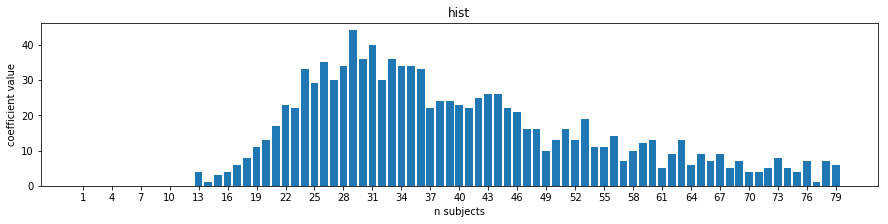

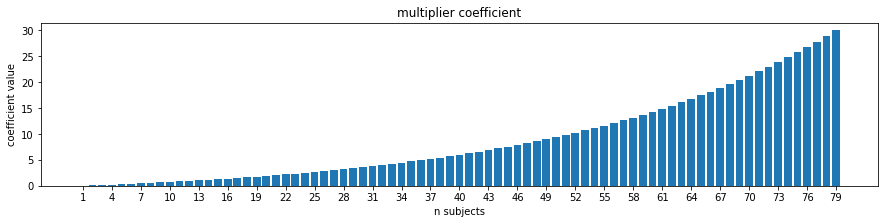

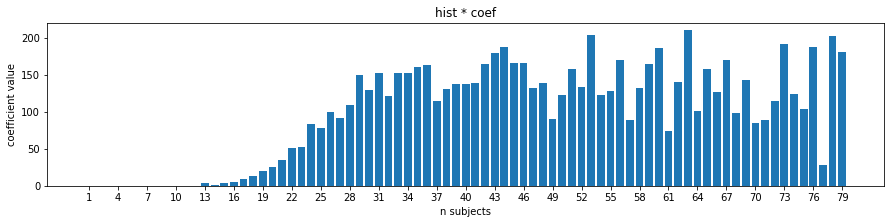

In [49]:
#robust = np.logspace(1, 5, num=79, base=2)-2
robust = np.array(range(79))
#robust = robust/robust.max()

y_pos = np.arange(1,80)
plt.figure(figsize=(15,3))
plt.bar(y_pos, hist, align='center', alpha=1)
plt.xticks(y_pos[::3], y_pos[::3])
plt.ylabel('coefficient value')
plt.xlabel('n subjects')
plt.title('hist')
plt.show()

y_pos = np.arange(1,80)
plt.figure(figsize=(15,3))
plt.bar(y_pos, robust, align='center', alpha=1)
plt.xticks(y_pos[::3], y_pos[::3])
plt.ylabel('coefficient value')
plt.xlabel('n subjects')
plt.title('multiplier coefficient')
plt.show()

y_pos = np.arange(1,80)
plt.figure(figsize=(15,3))
plt.bar(y_pos, robust * hist, align='center', alpha=1)
plt.xticks(y_pos[::3], y_pos[::3])
plt.ylabel('coefficient value')
plt.xlabel('n subjects')
plt.title('hist * coef')
plt.show()

In [237]:
print('min_samples', 'min_cluster_size', 'time', 'n_clusters', 'noise_fibers', 'diversity_score', 'robust_score', 'score','other')

location = './cachedir'
memory = Memory(location, verbose=0)
ds = []
n_clus = []
n_noise = []
scorem = []
robustm = []
penalty_score = []
for i, ms in enumerate([1,2,3,4,5]):
    ds_ = []
    n_clus_ = []
    n_noise_ = []
    score_ = []
    robust_ = []
    penalty_score_ = []
    for j, mcs in enumerate([10,15,20,25,30,35,40,45,50,55,60,65,70,79]):
        
        clusterer = hdbscan.HDBSCAN(
            algorithm='boruvka_kdtree',
            cluster_selection_method='leaf',
            min_samples=ms,
            min_cluster_size=mcs, 
            alpha=1.0,
            core_dist_n_jobs = 4,
            memory=memory)

        t0 = time.time()
        clusterer.fit(latent, ids)
        exe_time = time.time() - t0
        
        clusters_dict = defaultdict(list)
        for k, clus in enumerate(clusterer.labels_):
            clusters_dict[clus].append(k)
        n = len(set(clusters_dict))
        ds_.append(diversity_score(clusters_dict, ids))
        n_clus_.append(n)
        n_noise_.append(len(clusters_dict[-1]))
        #score_.append(score(clusters_dict, ids))
        robust_.append(robust_score(clusters_dict, ids))
        penalty_score_.append(other(clusters_dict,ids))
        
        print(ms, mcs, exe_time, n, len(clusters_dict[-1]), diversity_score(clusters_dict, ids), robust_score(clusters_dict, ids), other(clusters_dict, ids))
    ds.append(ds_)
    n_clus.append(n_clus_)
    n_noise.append(n_noise_)
    #scorem.append(score_)
    robustm.append(robust_)
    penalty_score.append(penalty_score_)

min_samples min_cluster_size time n_clusters noise_fibers diversity_score robust_score score other
1 10 17.35964584350586 11867 569841 122.12658227848101 0.22807530296226208 0.1428010662479613
1 15 10.801636457443237 6480 599101 181.873417721519 0.33473980309423346 0.21107594936708854
1 20 8.811503410339355 4278 614239 232.58227848101265 0.4080606695427297 0.27224066611039116
1 25 7.455187797546387 3140 621151 270.82278481012656 0.44307425622833185 0.32788438281061033
1 30 7.377893924713135 2502 623474 309.4810126582278 0.44462657721923726 0.3760333505347621
1 35 6.939339876174927 2029 625209 347.44303797468353 0.42737271587300596 0.4245902764347343
1 40 6.169856309890747 1742 625347 379.0759493670886 0.399526224767109 0.46151666206455544
1 45 6.3315815925598145 1505 627263 406.2025316455696 0.36111695193237736 0.49589133268850655
1 50 5.830797433853149 1328 628824 432.43037974683546 0.316684459356413 0.5271560927253316
1 55 6.220524549484253 1194 627322 455.34177215189874 0.2680597078

In [126]:
ds = np.array(ds)
dsmax = ds.max()
ds2=ds
for numi,i in enumerate(ds):
    for numj, j in enumerate(i):
        ds2[numi,numj] = ((j*100)/dsmax)/100

robustm = np.array(robustm)
robustmmax = robustm.max()
robustm2=robustm
for numi,i in enumerate(robustm):
    for numj, j in enumerate(i):
        robustm2[numi,numj] = ((j*100)/robustmmax)/100



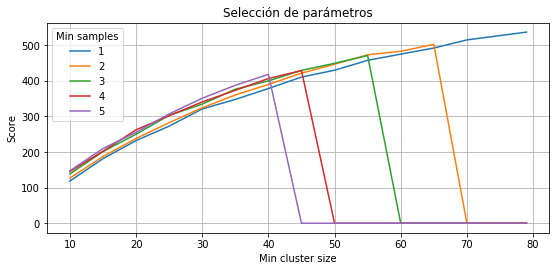

In [238]:
best_n_clusters = len(latent)/75 #9953.708860759494
colors = ['C0','C1','C2','C3','C4','C5']
fig = plt.figure(figsize=(9,4))
plt.gcf().subplots_adjust(bottom=0.15)
count = 0
'''for num, i in enumerate(ds2):
    plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79],i,colors[num])
for num, i in enumerate(robustm2):
    plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79],i,colors[num])'''
for num, i in enumerate(np.array(ds)):
    plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79],i,colors[num])

plt.title('Selección de parámetros')
plt.ylabel('Score')
plt.xlabel('Min cluster size')
plt.legend(['1','2','3','4','5'], loc='upper left', title="Min samples")
plt.grid()
plt.show()
fig.savefig("seleccion_parametros.pdf",dpi=300)

## Display

In [132]:
ids_ = []
for i in range(20):
    ids_ += clusters_dict[i]
display(all_centroids[ids_])
print(len(ids_))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


1755


In [130]:
dm = calculate_distance_matrix(all_centroids[ids_])

0
1000


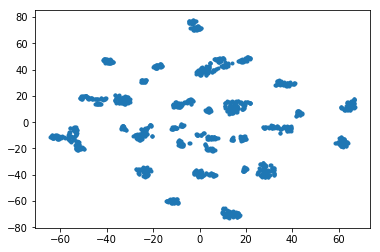

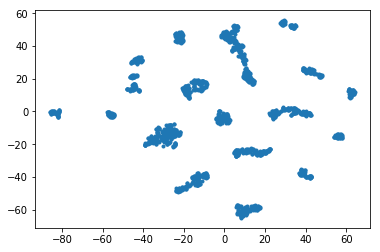

In [131]:
from sklearn.manifold import TSNE

Y = TSNE(n_components=2, metric='precomputed').fit_transform(dm)
vis_x = Y[:, 0]
vis_y = Y[:, 1]
plt.scatter(vis_x, vis_y, marker='.')
plt.clim(-0.5, 9.5)
plt.show()

Y = TSNE(n_components=2).fit_transform(latent[ids_])
vis_x = Y[:, 0]
vis_y = Y[:, 1]
plt.scatter(vis_x, vis_y, marker='.')
plt.clim(-0.5, 9.5)
plt.show()

In [5]:
location = './cachedir'
memory = Memory(location, verbose=0)

In [221]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    ms = i
    mcs = 70

    clusterer = hdbscan.HDBSCAN(
        algorithm='boruvka_kdtree',
        cluster_selection_method='leaf',
        min_samples=ms,
        min_cluster_size=mcs, 
        alpha=1.0,
        core_dist_n_jobs = 4,
        )

    t0 = time.time()
    clusterer.fit(latent,ids)
    exe_time = time.time() - t0

    clusters_dict = defaultdict(list)
    for k, clus in enumerate(clusterer.labels_):
        clusters_dict[clus].append(k)

    n = len(set(clusters_dict))

    print('min samples: ',ms)
    print('min cluster size: ',mcs)
    print('execution time', exe_time)
    print('n clusters',n)
    print('n noise fibers', len(clusters_dict[-1]))
    print('% noise fibers', 100*len(clusters_dict[-1])/len(latent))
    print('diversity score', diversity_score(clusters_dict, ids))
    print('robust score', robust_score(clusters_dict, ids))
    print('score', other(clusters_dict, ids))
    print('__________________________________')

min samples:  1
min cluster size:  70
execution time 269.86306595802307
n clusters 917
n noise fibers 622626
% noise fibers 79.17995073396723
diversity score 0.6410093416615994
robust score 0.10223209971977965
score 16.18123120957632
__________________________________
min samples:  2
min cluster size:  70
execution time 250.32789278030396
n clusters 756
n noise fibers 644654
% noise fibers 81.98127280334408
diversity score 0.6478162461228939
robust score 0.10625544169847967
score 16.26356020302085
__________________________________
min samples:  3
min cluster size:  70
execution time 239.91574573516846
n clusters 638
n noise fibers 661151
% noise fibers 84.07921225215968
diversity score 0.654690698090337
robust score 0.11759453989921032
score 13.975349766822118
__________________________________
min samples:  4
min cluster size:  70
execution time 237.6791331768036
n clusters 559
n noise fibers 667731
% noise fibers 84.91599721749924
diversity score 0.6648518669751833
robust score 0.11

In [222]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    ms = i
    mcs = 70

    clusterer = hdbscan.HDBSCAN(
        algorithm='boruvka_kdtree',
        cluster_selection_method='leaf',
        min_samples=ms,
        min_cluster_size=mcs, 
        alpha=1.0,
        core_dist_n_jobs = 4,
        )

    t0 = time.time()
    clusterer.fit(latent)
    exe_time = time.time() - t0

    clusters_dict = defaultdict(list)
    for k, clus in enumerate(clusterer.labels_):
        clusters_dict[clus].append(k)

    n = len(set(clusters_dict))

    print('min samples: ',ms)
    print('min cluster size: ',mcs)
    print('execution time', exe_time)
    print('n clusters',n)
    print('n noise fibers', len(clusters_dict[-1]))
    print('% noise fibers', 100*len(clusters_dict[-1])/len(latent))
    print('diversity score', diversity_score(clusters_dict, ids))
    print('robust score', robust_score(clusters_dict, ids))
    print('score', other(clusters_dict, ids))
    print('__________________________________')

min samples:  1
min cluster size:  70
execution time 288.04378962516785
n clusters 991
n noise fibers 609299
% noise fibers 77.4851432517362
diversity score 0.6174913693901042
robust score 0.11314488625477392
score 15.473318829113923
__________________________________
min samples:  2
min cluster size:  70
execution time 242.9036087989807
n clusters 801
n noise fibers 636417
% noise fibers 80.93376554506112
diversity score 0.6197784810126578
robust score 0.10580129268793759
score 17.373861162621946
__________________________________
min samples:  3
min cluster size:  70
execution time 237.15017557144165
n clusters 658
n noise fibers 657917
% noise fibers 83.667941343663
diversity score 0.6303681868100115
robust score 0.1102881766765419
score 13.273397917251167
__________________________________
min samples:  4
min cluster size:  70
execution time 237.32803225517273
n clusters 587
n noise fibers 666974
% noise fibers 84.81972879519498
diversity score 0.6393485116861803
robust score 0.101

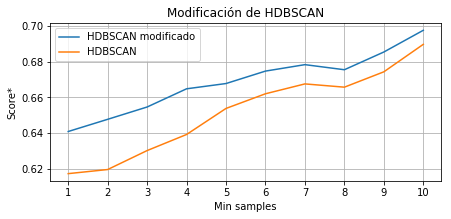

In [224]:
mod = [0.6410093416615994,0.6478162461228939,0.654690698090337,0.6648518669751833,0.6677939897574648,0.6747385800770505,0.6783369803063463,0.6754992967651203,0.685390915860015,0.6975204585159533]
non_mod=[0.6174913693901042,0.6197784810126578,0.6303681868100115,0.6393485116861803,0.6538967720322563,0.662079235884664,0.6675851156700134,0.6657625075346593,0.6743330533267675,0.6896751563214885]
colors = ['C0','C1']
fig = plt.figure(figsize=(7,3))
plt.gcf().subplots_adjust(bottom=0.15)

plt.plot([1,2,3,4,5,6,7,8,9,10],mod)
plt.plot([1,2,3,4,5,6,7,8,9,10],non_mod)
plt.xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10])
plt.title('Modificación de HDBSCAN')
plt.ylabel('Score*')
plt.xlabel('Min samples')
plt.legend(['HDBSCAN modificado','HDBSCAN'], loc='upper left')
plt.grid()
plt.show()
fig.savefig("modified_hdbscan.pdf",dpi=300)

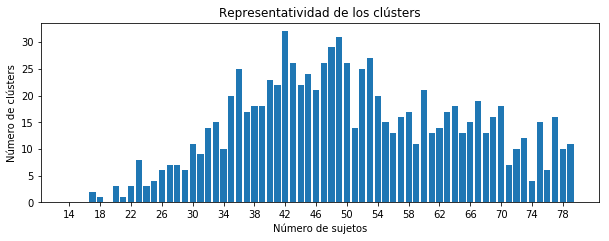

In [22]:
hist = [0]*79
for i in clusters_dict.keys():
    hist[len(set(ids[clusters_dict[i]]))-1] +=1

y_pos = np.arange(1,80)
fig = plt.figure(figsize=(10,3.3))
plt.bar(y_pos[13:], hist[13:], align='center', alpha=1)
plt.xticks(y_pos[13::4], y_pos[13::4])
plt.ylabel('Número de clústers')
plt.xlabel('Número de sujetos')
plt.title('Representatividad de los clústers')

fig.savefig("representatividad.pdf",dpi=300)
plt.show()

# HDBSCAN!!!

OJO! Correr en PC del lab que tiene librería HDBSCAN modificada

In [8]:
ms = 1
mcs = 70

clusterer = hdbscan.HDBSCAN(
    algorithm='boruvka_kdtree',
    cluster_selection_method='leaf',
    min_samples=ms,
    min_cluster_size=mcs, 
    alpha=1.0,
    core_dist_n_jobs = -1,
    )

t0 = time.time()
clusterer.fit(latent,ids)
exe_time = time.time() - t0

clusters_dict = defaultdict(list)
for k, clus in enumerate(clusterer.labels_):
    clusters_dict[clus].append(k)

n = len(set(clusters_dict))

print('min samples: ',ms)
print('min cluster size: ',mcs)
print('execution time', exe_time)
print('n clusters',n)
print('n noise fibers', len(clusters_dict[-1]))
print('% noise fibers', 100*len(clusters_dict[-1])/len(latent))
#print('diversity score', diversity_score(clusters_dict, ids))
#print('robust score', robust_score(clusters_dict, ids))
#print('score', other(clusters_dict, ids))

NameError: name 'defaultdict' is not defined

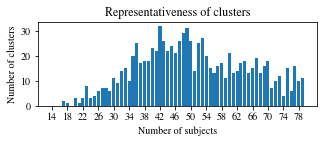

In [203]:
hist = [0]*79
for i in clusters_dict.keys():
    hist[len(set(ids[clusters_dict[i]]))-1] +=1

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

y_pos = np.arange(1,80)
fig = matplotlib.pyplot.figure(figsize=(5,2))
matplotlib.pyplot.gcf().subplots_adjust(bottom=0.3)
matplotlib.pyplot.bar(y_pos[13:], hist[13:], align='center', alpha=1)
matplotlib.pyplot.xticks(y_pos[13::4], y_pos[13::4])
matplotlib.pyplot.ylabel('Number of clusters')
matplotlib.pyplot.xlabel('Number of subjects')
matplotlib.pyplot.title('Representativeness of clusters')

fig.savefig("representatividad.pdf",dpi=300)
matplotlib.pyplot.show()

# DISPLAY results

In [8]:
def get_long(fiber):
    size = 0
    for i in range(1,21):
        if i == 0:
            continue
        size += np.linalg.norm(fiber[i] - fiber[i-1])
    return size

In [36]:
save_ = []
len_cluster = []
long_cluster = []
for i in clusters_dict.keys():
    if i == -1:
        continue
    if (len(set(ids[clusters_dict[i]]))>50):
        save_.append(i)
        len_cluster.append(len(clusters_dict[i]))
        long_cluster.append(get_long(get_centroid(all_centroids[clusters_dict[i]])))

In [37]:
len(save_)

425

In [38]:
sorted_by_size = np.array(save_)[np.argsort(len_cluster)[::-1]]
sorted_by_long = np.array(save_)[np.argsort(long_cluster)[::-1]]

#### Short fibers

In [29]:
n = 70
to_display = []
short_dict = defaultdict(list)
current = 0
for num, i in enumerate(sorted_by_long[-n:]):
    to_display.append(clusters_dict[i])
    short_dict[num] = range(current, current + len(clusters_dict[i]))
    current += len(clusters_dict[i])
to_display = np.concatenate(to_display)
display(all_centroids[to_display], short_dict, ids=range(n), color='nipy_spectral')

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [28]:
display(np.concatenate(all_data)[to_display])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Long fibers

In [91]:
n = 20
to_display = []
long_dict = defaultdict(list)
current = 0
select = [50,49,47,46,45,43,42,6,8,9,11,13,22,28,29]
for num, i in enumerate(sorted_by_long[select]):
    to_display.append(clusters_dict[i])
    long_dict[num] = range(current, current + len(clusters_dict[i]))
    current += len(clusters_dict[i])
to_display = np.concatenate(to_display)
display(all_centroids[to_display], long_dict, ids=range(len(select)),color='nipy_spectral')

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Bigger fibers

In [88]:
n = 70
to_display = []
size_dict = defaultdict(list)
current = 0
select = [0,1,2,3,5,6,7,8,9,10,11,14,15,16,17,18,19,21,22,24,29,30,31,34,36,46,49,50,51,52]
random.shuffle(select)
for num, i in enumerate(sorted_by_size[[select]]):
    to_display.append(clusters_dict[i])
    size_dict[num] = range(current, current + len(clusters_dict[i]))
    current += len(clusters_dict[i])
to_display = np.concatenate(to_display)
display(all_centroids[to_display], size_dict, ids=range(len(select)),color='nipy_spectral')

/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [45]:
save_ = []
len_cluster = []
for i in clusters_dict.keys():
    if i == -1:
        continue
    if (len(set(ids[clusters_dict[i]]))>50):
        save_.append(i)
        len_cluster.append(len(clusters_dict[i]))
sorted_ = np.array(save_)[np.argsort(len_cluster)[::-1]]

In [284]:
def clustered_display_brain(centroids, clusters_dict, ids):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)), name='hsv')
    np.random.shuffle(colormap)
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = centroids[clusters_dict[id_]]
        colors += [colormap[i]*10]*len(all_f)
        streamlines.append(all_f)
        
    ren.add(actor.streamtube(np.concatenate(streamlines), colors, linewidth=0.001))
    ren.add(actor.line(centroids[::100], [(0,0,0)]*7864, opacity=0.05))
    window.show(ren, size=(1500, 1100))

In [289]:
new_save = [501, 951, 968, 284, 283, 558, 598, 149, 979, 879, 66, 825, 905] 

In [293]:
all_data = np.array(all_data)

In [296]:
len(np.concatenate(all_data))

221604

In [297]:
clustered_display_delayed(np.concatenate(all_data), clusters_dict, ids=[501])

IndexError: index 224988 is out of bounds for axis 0 with size 221604

In [290]:
for i in [501]:
    print(i)
    clustered_display_brain(all_centroids, clusters_dict, ids=[i])
    clustered_display_delayed(all_centroids, clusters_dict, ids=[i])

501


/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


TypeError: list indices must be integers or slices, not list

In [369]:
def colormap_display_centroids(centroids, clusters_dict, n):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    
    sizes = [0]*(len(clusters_dict.keys())-1)
    for i in clusters_dict.keys():
        if i == -1:
            continue
        sizes[i] = len(clusters_dict[i])
    sizes = np.argsort(sizes)[-n:]

    colormap = actor.create_colormap(np.arange(len(sizes)), name='YlGnBu')
    streamlines = []
    colors = []
    num=0
    
    for num,i in enumerate(sizes):
        ids_ = clusters_dict[i]
        colors += [colormap[num]]*len(ids_)
        streamlines.append(centroids[ids_])
    ren.add(actor.streamtube(np.concatenate(streamlines), colors, opacity=1,linewidth=0.3))
    #ren.add(actor.line(np.concatenate(clustered_streamlines)[::500], [(0,0,0)]*10702, opacity=0.05))
    window.show(ren, size=(1500, 1100))

In [584]:
def colormap_display(clustered_streamlines, clusters_dict, sizes,ids_clusters):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(max(sizes - min(sizes))+1), name='PuBu')[sizes - min(sizes)]
    streamlines = []
    colors = []
    num=0
    
    for num,i in enumerate(ids_clusters):
        ids_ = clusters_dict[i]
        all_f = np.concatenate(clustered_streamlines[ids_])
        colors += [colormap[num]]*len(all_f)
        streamlines.append(all_f)

    ren.add(actor.line(np.concatenate(streamlines), colors, opacity=0.01))
    #ren.add(actor.line(np.concatenate(clustered_streamlines)[::500], [(0,0,0)]*10702, opacity=0.05))
    window.show(ren, size=(1500, 1100))

In [265]:
save_ = []
len_cluster = []
for i in clusters_dict.keys():
    if i == -1:
        continue
    if (len(set(ids[clusters_dict[i]])) > 60):
        save_.append(i)
        len_cluster.append(len(set(ids[clusters_dict[i]])))
ids_ = np.argsort(len_cluster)
sizes = np.array(len_cluster)[ids_]

In [266]:
len(save_)

0

### Based on atlas

In [254]:
atlas_labels_name = ['THAL_PAR_LEFT','AR_POST_RIGHT','IL_LEFT','IFO_LEFT','FORNIX_RIGHT','CST_LEFT','THAL_OCC_RIGHT','CG_LEFT','THAL_MOT_LEFT','THAL_TEMP_RIGHT','CG_RIGHT','CG2_RIGHT','AR_RIGHT','UN_LEFT','AR_ANT_LEFT','THAL_OCC_LEFT','CST_RIGHT','CG3_LEFT','CG2_LEFT','CC_BODY','IFO_RIGHT','CG3_RIGHT','AR_LEFT','THAL_FRONT_LEFT','IL_RIGHT','THAL_TEMP_LEFT','THAL_PAR_RIGHT','CC_SPLENIUM','FORNIX_LEFT','THAL_MOT_RIGHT','UN_RIGHT','CC_ROSTRUM','AR_POST_LEFT','AR_ANT_RIGHT','THAL_FRONT_RIGHT','CC_GENU']

In [255]:
centroids = []
for i in save_:
    centroids.append(get_centroid(all_centroids[clusters_dict[i]]))

In [256]:
def get_selected_ids(tract_name, n_best):
    num_atlas = atlas_labels_name.index(tract_name)
    ix_ = np.where(ATLAS_labels == num_atlas)
    cent = get_centroid(ATLAS[ix_])
    centroid_dists = []
    for i in range(len(save_)):
        centroid_dists.append(mdf(cent, centroids[i]))
    sorted_ = np.argsort(centroid_dists)
    selected_ids = np.concatenate([clusters_dict[save_[i]] for i in sorted_[:n_best]])
    display(ATLAS[ix_])
    display(all_centroids[selected_ids])
    return selected_ids

In [117]:
CC_SPLENIUM = get_selected_ids('CC_SPLENIUM', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [118]:
CC_ROSTRUM = get_selected_ids('CC_ROSTRUM', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [119]:
CC_GENU = get_selected_ids('CC_GENU', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [257]:
AR_POST_RIGHT = get_selected_ids('AR_POST_RIGHT', 1)

NameError: name 'ATLAS_labels' is not defined

In [121]:
AR_RIGHT = get_selected_ids('AR_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [260]:
AR_ANT_LEFT = get_selected_ids('AR_ANT_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [123]:
AR_LEFT = get_selected_ids('AR_LEFT', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [124]:
AR_POST_LEFT = get_selected_ids('AR_POST_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [125]:
AR_ANT_RIGHT = get_selected_ids('AR_ANT_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [128]:
CG_LEFT = get_selected_ids('CG_LEFT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [131]:
CG_RIGHT = get_selected_ids('CG_RIGHT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [132]:
IFO_LEFT = get_selected_ids('IFO_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [133]:
IFO_RIGHT = get_selected_ids('IFO_RIGHT', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [138]:
IL_LEFT = get_selected_ids('IL_LEFT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [150]:
IL_RIGHT = get_selected_ids('IL_RIGHT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [155]:
UN_LEFT = get_selected_ids('UN_LEFT', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [157]:
UN_RIGHT = get_selected_ids('UN_RIGHT', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [156]:
FORNIX_RIGHT = get_selected_ids('FORNIX_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [158]:
FORNIX_LEFT = get_selected_ids('FORNIX_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [159]:
THAL_OCC_RIGHT = get_selected_ids('THAL_OCC_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [161]:
THAL_MOT_LEFT = get_selected_ids('THAL_MOT_LEFT', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [164]:
THAL_OCC_LEFT = get_selected_ids('THAL_OCC_LEFT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [170]:
THAL_FRONT_LEFT = get_selected_ids('THAL_FRONT_LEFT', 6)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [171]:
THAL_MOT_RIGHT = get_selected_ids('THAL_MOT_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [176]:
THAL_FRONT_RIGHT = get_selected_ids('THAL_FRONT_RIGHT', 5)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [181]:
CG2_RIGHT = get_selected_ids('CG2_RIGHT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [182]:
CG3_LEFT = get_selected_ids('CG3_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [186]:
CG2_LEFT = get_selected_ids('CG2_LEFT', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [187]:
CG3_RIGHT = get_selected_ids('CG3_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [190]:
THAL_PAR_RIGHT = get_selected_ids('THAL_PAR_RIGHT', 3)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [194]:
THAL_PAR_LEFT = get_selected_ids('THAL_PAR_LEFT', 4)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [195]:
THAL_TEMP_RIGHT = get_selected_ids('THAL_TEMP_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [196]:
THAL_TEMP_LEFT = get_selected_ids('THAL_TEMP_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [197]:
CST_RIGHT = get_selected_ids('CST_RIGHT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [198]:
CST_LEFT = get_selected_ids('CST_LEFT', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [199]:
CC_SPLENIUM = get_selected_ids('CC_SPLENIUM', 1)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [202]:
CC_ROSTRUM = get_selected_ids('CC_ROSTRUM', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [203]:
CC_GENU = get_selected_ids('CC_GENU', 2)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [204]:
CC = [CC_SPLENIUM, CC_ROSTRUM, CC_GENU]

AR_CLUSTERS_LEFT = [AR_ANT_LEFT, AR_LEFT, AR_POST_LEFT]
AR_CLUSTERS_RIGHT = [AR_POST_RIGHT, AR_RIGHT, AR_ANT_RIGHT]

CG_CLUSTERS_LEFT = [CG_LEFT, CG2_LEFT, CG3_LEFT]
CG_CLUSTERS_RIGHT = [CG_RIGHT, CG2_RIGHT, CG3_RIGHT]

IFO_CLUSTERS = [IFO_LEFT, IFO_RIGHT]

IL_CLUSTERS = [IL_LEFT, IL_RIGHT]

UN_CLUSTERS = [UN_LEFT, UN_RIGHT]

FORNIX_CLUSTERS = [FORNIX_RIGHT, FORNIX_LEFT]

THAL_CLUSTERS = [THAL_OCC_RIGHT,THAL_OCC_LEFT, THAL_MOT_LEFT, THAL_MOT_RIGHT, THAL_FRONT_LEFT, THAL_FRONT_RIGHT]
THAL_CLUSTERS_LEFT = [THAL_OCC_LEFT, THAL_MOT_LEFT, THAL_FRONT_LEFT, THAL_TEMP_LEFT, THAL_PAR_LEFT]
THAL_CLUSTERS_RIGHT = [THAL_OCC_RIGHT, THAL_MOT_RIGHT, THAL_FRONT_RIGHT, THAL_TEMP_RIGHT, THAL_PAR_RIGHT]

LEFT_CLUSTERS = [AR_ANT_LEFT, AR_LEFT, AR_POST_LEFT, 
                 CG_LEFT, CG2_LEFT, CG3_LEFT,
                 IFO_LEFT, 
                 IL_LEFT, 
                 UN_LEFT, 
                 FORNIX_LEFT, 
                 THAL_OCC_LEFT, THAL_MOT_LEFT, THAL_FRONT_LEFT, THAL_TEMP_LEFT, THAL_PAR_LEFT,
                 CST_LEFT]
RIGHT_CLUSTERS = [AR_ANT_RIGHT, AR_RIGHT, AR_POST_RIGHT, 
                  CG_RIGHT, CG2_RIGHT, CG3_RIGHT,
                  IFO_RIGHT, 
                  IL_RIGHT, 
                  UN_RIGHT, 
                  FORNIX_RIGHT,
                  THAL_OCC_RIGHT, THAL_MOT_RIGHT, THAL_FRONT_RIGHT, THAL_TEMP_RIGHT, THAL_PAR_RIGHT,
                  CST_RIGHT]

TOTAL_BRAIN = [*LEFT_CLUSTERS, *RIGHT_CLUSTERS, np.concatenate(CC)]

ILFOUL_RIGHT = [IL_RIGHT, UN_RIGHT,IFO_RIGHT, FORNIX_RIGHT, CST_RIGHT]
ILFOUL_LEFT = [IL_LEFT, UN_LEFT,IFO_LEFT, FORNIX_LEFT, CST_LEFT]


In [208]:
ALL_SELECTED_DICT = defaultdict(list)
count = 0
for num, i in enumerate(THAL_CLUSTERS_LEFT):
    ALL_SELECTED_DICT[num] = range(count, count + len(i))
    count += len(i)
    
display(all_centroids[np.concatenate(THAL_CLUSTERS_LEFT)], ALL_SELECTED_DICT, ids=range(len(THAL_CLUSTERS_LEFT)), hd=False)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [196]:
TOTAL_BRAIN = np.load('TOTAL_BRAIN.npy', allow_pickle=True)

In [298]:
for i in range(2):
    clear_output()
    print(len(set(ids[clusters_dict[i]])), " sujetos considerados en ", len(clusters_dict[i]), ' fibras')
    #weighted_display(all_centroids, weights, clusters_dict, ids=[i])
    clustered_display_delayed(all_data, clusters_dict, ids=[i], subjects=ids)
    #clustered_display_brain(all_data, clusters_dict, ids=[i], subjects=ids)
    #clustered_display(all_data, clusters_dict, ids=[i], subjects=ids)
    #adjusted_clustered_display(all_data, all_centroids, weights,clusters_dict, ids=[i])

32  sujetos considerados en  84  fibras


IndexError: index 2253 is out of bounds for axis 0 with size 20

In [299]:
clustered_display_delayed(all_data, clusters_dict, ids=[3], subjects=ids)

IndexError: index 2082 is out of bounds for axis 0 with size 20

In [247]:
selected = range(60,80)
index_selected = []
for i in clusters_dict.keys():
    if len(set(ids[clusters_dict[i]])) in selected and i != -1:
        index_selected.append(i)

In [248]:
clustered_display(all_data, clusters_dict, ids=index_selected)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [277]:
all_data = np.array(all_data)

In [276]:
save_[0]

914

In [306]:
for i in [1]:
    print(len(set(ids[clusters_dict[i]])), " sujetos considerados en ", len(clusters_dict[i]), ' fibras')
    #weighted_display(all_centroids, weights, clusters_dict, ids=[i])
    clustered_display_delayed(all_data, clusters_dict, ids=[i], subjects=ids)
    #clustered_display_brain(np.concatenate(all_data), clusters_dict, ids=[i], subjects=ids)
    #clustered_display(all_data, clusters_dict, ids=[i], subjects=ids)
    #adjusted_clustered_display(all_data, all_centroids, weights,clusters_dict, ids=[i])

33  sujetos considerados en  135  fibras


IndexError: index 45249 is out of bounds for axis 0 with size 20

In [65]:
clustered_display(all_data, clusters_dict, ids=index_selected[:10])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### One by one

In [380]:
def clustered_display_delayed(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = clustered_streamlines[clusters_dict[id_]]
        sub_ids = subjects[clusters_dict[id_]]
        count = 0
        row = 0
        last = sub_ids[0]
        for sid, clus in zip(sub_ids, all_f):
            if sid != last:
                count += 1
                if count%10 == 0:
                    count = 0
                    row += 1
                last = sid
            colors += [colormap[0]*30]*len(clus)
            streamlines.append(clus+[0,count*60,row*60])
            
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1500, 1100))

In [310]:
len(np.concatenate(all_data))

221604

In [311]:
len(all_centroids)

786343

In [382]:
i = new_save[13]
print(i, len(set(ids[clusters_dict[i]])), " sujetos considerados en ", len(clusters_dict[i]), ' fibras')
#weighted_display(all_centroids, weights, clusters_dict, ids=[i])
clustered_display_delayed(all_data, clusters_dict, ids=[i], subjects=ids)
clustered_display_brain(all_data, clusters_dict, ids=[i], subjects=ids)
#clustered_display(all_data, clusters_dict, ids=[i], subjects=ids)
#adjusted_clustered_display(all_data, all_centroids, weights,clusters_dict, ids=[i])

IndexError: list index out of range

In [28]:
for i in range(21,30):
    clustered_display(all_data, clusters_dict, ids=[i], subjects=ids)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Some clusters

In [29]:
from_, to_ = 30,70
weighted_display(all_centroids, weights, clusters_dict, ids=range(from_, to_))
clustered_display(all_data, clusters_dict, ids=range(from_, to_))
#adjusted_clustered_display(all_data, all_centroids, weights,clusters_dict, ids=range(from_, to_))

ValueError: zero-size array to reduction operation maximum which has no identity

#### All togheter

In [30]:
#centroids
display(all_centroids, clusters_dict, ids=range(n))
#full data clustered
clustered_display(all_data, clusters_dict, ids=range(n-1))
#full data adjusted clustered
#adjusted_clustered_display(all_data, all_centroids, weights, clusters_dict, ids=range(n-1))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Biggest clusters

In [31]:
n_fibers = [sum(weights[clusters_dict[i]]) for i in range(0,len(clusters_dict.keys())-1)]
fat_clusters = np.argsort(n_fibers)[-30:]

display(all_centroids, clusters_dict, ids=fat_clusters)
clustered_display(all_data, clusters_dict, ids=fat_clusters, sample=20)
#adjusted_clustered_display(all_data, all_centroids, weights_selected, clusters_dict, ids=fat_clusters, sample=20)

TypeError: list indices must be integers or slices, not list

# Validation

### Import ATLAS

In [5]:
import glob
files = [f for f in glob.glob("data/deep_atlas/*.bundles")]

ATLAS = []
ATLAS_labels = []
atlas_dict = defaultdict(list)
curr = 0
for i, file in enumerate(files):
    cluster = np.array(BT.read_bundle_severalbundles(file))[0][0]
    ATLAS.append(cluster)
    ATLAS_labels.append([i]*len(cluster))
    atlas_dict[i] = range(curr, curr + len(cluster))
    curr += len(cluster)
ATLAS = np.concatenate(ATLAS, axis=0)
ATLAS_labels = np.concatenate(ATLAS_labels, axis=0)

data/deep_atlas/atlas_THAL_PAR_LEFT.bundlesdata
data/deep_atlas/atlas_AR_POST_RIGHT.bundlesdata
data/deep_atlas/atlas_IL_LEFT.bundlesdata
data/deep_atlas/atlas_IFO_LEFT.bundlesdata
data/deep_atlas/atlas_FORNIX_RIGHT.bundlesdata
data/deep_atlas/atlas_CST_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_OCC_RIGHT.bundlesdata
data/deep_atlas/atlas_CG_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_MOT_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_TEMP_RIGHT.bundlesdata
data/deep_atlas/atlas_CG_RIGHT.bundlesdata
data/deep_atlas/atlas_CG2_RIGHT.bundlesdata
data/deep_atlas/atlas_AR_RIGHT.bundlesdata
data/deep_atlas/atlas_UN_LEFT.bundlesdata
data/deep_atlas/atlas_AR_ANT_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_OCC_LEFT.bundlesdata
data/deep_atlas/atlas_CST_RIGHT.bundlesdata
data/deep_atlas/atlas_CG3_LEFT.bundlesdata
data/deep_atlas/atlas_CG2_LEFT.bundlesdata
data/deep_atlas/atlas_CC_BODY.bundlesdata
data/deep_atlas/atlas_IFO_RIGHT.bundlesdata
data/deep_atlas/atlas_CG3_RIGHT.bundlesdata
data/deep_atla

In [6]:
print('n clusters: ',len(atlas_dict))
print('n fibers: ', len(ATLAS))

n clusters:  36
n fibers:  11079


In [35]:
display(ATLAS, atlas_dict, ids=range(38))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [44]:
ATLAS.max()

115.88924

In [45]:
ATLAS.min()

-87.13878

In [47]:
all_centroids.max()

112.6824

In [48]:
all_centroids.min()

-87.84369

In [7]:
xmax, xmin = 150, -100
ATLAS = (ATLAS - xmin)/(xmax - xmin)

for i, fiber in enumerate(ATLAS):
        if np.mean(fiber[0]) > np.mean(fiber[-1]):
            ATLAS[i] = np.flip(ATLAS[i], axis=0)

In [54]:
ATLAS.max()

0.8635569

In [55]:
ATLAS.min()

0.051444884

In [ ]:
np.save('x_train', x_train)
np.save('y_train', y_train)

### Create synthetic subjects

In [8]:
inputs = Input(shape=(7,))

decoder = sequence_autoencoder.layers[4](inputs)
decoder = sequence_autoencoder.layers[5](decoder)
decoder = sequence_autoencoder.layers[6](decoder)
decoder = sequence_autoencoder.layers[7](decoder)
sequence_decoder = Model(inputs, decoder)
sequence_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 7)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 64)            18432     
_________________________________________________________________
lstm_5 (LSTM)                (None, 21, 128)           98816     
_________________________________________________________________
lstm_6 (LSTM)                (None, 21, 3)             1584      
Total params: 118,832
Trainable params: 118,832
Non-trainable params: 0
_________________________________________________________________


In [57]:
reconstruction = sequence_autoencoder.predict(ATLAS)

In [291]:
ATLAS.max()

115.88924

In [293]:
latent = sequence_encoder.predict(ATLAS)

In [63]:
reconstruction = sequence_decoder.predict(latent)

In [64]:
display(reconstruction)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [332]:
extended_latent = np.array([*latent,*latent,*latent,*latent,*latent])

extended_y_train = np.array([*ATLAS_labels,*ATLAS_labels,*ATLAS_labels,*ATLAS_labels,*ATLAS_labels])

In [336]:
from sklearn.linear_model import LinearRegression

all_data = []
bundles_labels = []
for i in range(5):
    
    size = int(np.random.normal(len(latent),int(len(latent)/3)))
    selected = random.sample(range(len(latent)*2), size)
    
    # General subject noise
    mean = np.random.uniform(0, 0.001)
    std = np.random.uniform(0, 0.2)
    
    print('size: ', size, ' mean: ', mean, ' std: ', std)
    
    segment_ids = extended_y_train[selected]
    a=[]
    b=[]
    for segment in set(segment_ids):
        idxs = np.where(segment_ids==segment)
        
        #display(sequence_decoder.predict(extended_latent[idxs]))
        model = LinearRegression()
        model.fit(extended_latent[idxs], extended_latent[idxs])
        y_pred = model.predict(extended_latent[idxs]+np.random.random(extended_latent[idxs].shape)/10)
        a.append(y_pred)
        b.append(extended_y_train[idxs])
    noised_reconstruction = sequence_decoder.predict(np.concatenate(a))#*(xmax - xmin) + xmin
    display(noised_reconstruction)
    all_data.append(noised_reconstruction)
    bundles_labels.append(np.concatenate(b))
    #PATH = 'data/synthetic_data/noised_'+str(i)
    #BT.write_bundle(PATH+'.bundles', noised_reconstruction)
    #np.save(PATH, extended_y_train[selected])

size:  16026  mean:  0.00012243331488008503  std:  0.19434665569849774


/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


size:  8000  mean:  0.0008930878745527629  std:  0.128783687407912
size:  9636  mean:  0.00013988299206049503  std:  0.020416590854302454
size:  17601  mean:  0.00034081444651854734  std:  0.07498459370339483
size:  17905  mean:  0.0007396627824824487  std:  0.14595378082810775


In [334]:
display(all_data[1])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### Compare synthetic subjects

### Centella clustering...

### Load independently clustered subjects

In [5]:
#path = 'data/synthetic_subjects/clustered/'
all_clusters = []
all_labels = []
all_data = []
for subject in range(0,20):
    data = np.array(BT.read_bundle_severalbundles('data/synthetic_subjects/generated/'+str(subject)+'.bundles')[0][0])
    all_data.append(data)
    
    clusters = np.load('data/synthetic_subjects/clustered/'+str(subject)+'/dict_clusters.npy', allow_pickle=True)
    clusters_dict = defaultdict(list)
    for i, cluster in enumerate(clusters):
        clusters_dict[i] = cluster.indices
    all_clusters.append(clusters_dict)
    
    labels = np.load('data/synthetic_subjects/generated/'+str(subject)+'_dict.npy', allow_pickle=True).tolist()
    atlas_dict = defaultdict(list)
    for i, cluster in enumerate(labels):
        atlas_dict[i] = list(labels[cluster])
    all_labels.append(atlas_dict)

data/synthetic_subjects/generated/0.bundlesdata
data/synthetic_subjects/generated/1.bundlesdata
data/synthetic_subjects/generated/2.bundlesdata
data/synthetic_subjects/generated/3.bundlesdata
data/synthetic_subjects/generated/4.bundlesdata
data/synthetic_subjects/generated/5.bundlesdata
data/synthetic_subjects/generated/6.bundlesdata
data/synthetic_subjects/generated/7.bundlesdata
data/synthetic_subjects/generated/8.bundlesdata
data/synthetic_subjects/generated/9.bundlesdata
data/synthetic_subjects/generated/10.bundlesdata
data/synthetic_subjects/generated/11.bundlesdata
data/synthetic_subjects/generated/12.bundlesdata
data/synthetic_subjects/generated/13.bundlesdata
data/synthetic_subjects/generated/14.bundlesdata
data/synthetic_subjects/generated/15.bundlesdata
data/synthetic_subjects/generated/16.bundlesdata
data/synthetic_subjects/generated/17.bundlesdata
data/synthetic_subjects/generated/18.bundlesdata
data/synthetic_subjects/generated/19.bundlesdata


In [6]:
len(np.concatenate(all_data))

221604

## Current method

In [7]:
sizes = []
for data in all_data:
    sizes.append(len(data))

all_centroids = []
ids = []
references = []
current = 0
for subject in range(20):
    
    for cluster in all_clusters[subject]:
        d = all_data[subject][all_clusters[subject][cluster]]
        references.append(np.array(all_clusters[subject][cluster]) + current)
        all_centroids.append(get_centroid(d))
        ids.append(subject)
    current += len(all_data[subject])
all_centroids = np.array(all_centroids)
references = np.array(references)
ids = np.array(ids)

In [8]:
label_reference = [-1]*len(np.concatenate(all_data))
current = 0
for subject in range(20):
    for label in range(36):
        for i in all_labels[subject][label]:
            label_reference[i+current]=label
    current += len(all_data[subject])
label_reference = np.array(label_reference)

In [9]:
xmax, xmin = 150, -100

all_centroids = (all_centroids - xmin)/(xmax - xmin)
#all_data = (all_data - xmin)/(xmax - xmin)

for k, fiber in enumerate(all_centroids):
        if np.mean(fiber[0]) > np.mean(fiber[-1]):
            all_centroids[k] = np.flip(all_centroids[k], axis=0)


In [61]:
display(reconstructed)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [60]:
reconstructed = sequence_autoencoder.predict(all_centroids)

In [101]:
t0 = time.time()
latent = sequence_encoder.predict(all_centroids)
print(time.time()-t0)

8.284549951553345


In [14]:
t0 = time.time()
matrix_distances = calculate_distance_matrix(all_centroids,all_centroids)
print(time.time()-t0)

7029.89745593071


In [175]:
matrix_distances = []

In [187]:
t0 = time.time()
matrix_distances = intra_cluster_distances(all_centroids[:5000])
print(time.time()-t0)

202.85708856582642


In [194]:
t0 = time.time()
matrix_distances = intra_cluster_distances(all_centroids)
print(time.time()-t0)

5792.308222055435


In [193]:
import numpy as np
import math
from sklearn.externals.joblib import Parallel, delayed

def direct_dist(v1, v2):
    """
    Returns the maximum direct distance between two streamlines
    """
    return math.sqrt(((v1-v2)**2).sum(axis=1).max())
def max_dist(v1, v2):
    """
    Returns the maximum distancia between two streamlines independent of orientation
    by obtaining the direct distance two times, one of them with a flipped streamline, finally choosing the minimum  between the two.
    """
    return min(direct_dist(v1, v2), direct_dist(v1, v2[::-1]))

def intra_cluster_distances(cluster):
    """
    Calculate distance between all elements in a cluster using
    a metric (by default max distance), then save the resulting matrix in 
    """
    
    #callable should be tested for metric.
    n = len(cluster)
    #dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n):
            a = direct_dist(cluster[i], cluster[j])
    #Since metric(x,y) = metric(y,x) we can make it so that the lower
    #triangular is the same as the upper
    #y = np.triu(dist_matrix) + np.triu(dist_matrix,k=1).T
    # for i in range(n):
    #     for j in range(n):
    #         dist_matrix[i][j] = metric(dataset[c[i]], dataset[c[j]])
    return a

In [70]:
display(all_centroids[clusters_dict[10]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [4]:
import hdbscan

ModuleNotFoundError: No module named 'hdbscan'

In [16]:
len(matrix_distances)

40800

In [1]:
from collections import defaultdict
import hdbscan
import numpy as np
import time
matrix_distances = np.load('pairwise.npy', allow_pickle=False)

In [3]:
matrix_distances = []

In [51]:
md = []

In [2]:
selected = np.random.choice(len(matrix_distances), 20000)
md=matrix_distances[selected][:,selected].astype('float64')

In [17]:
clusters_dict[0]

[0, 86, 107, 99, 127]

In [19]:
selected[clusters_dict[0]]

array([22767, 32665,  2832,  9467, 10152])

In [20]:
method_dict = defaultdict(list)
for clus in clusters_dict:
    method_dict[clus] = np.concatenate(references[selected[clusters_dict[clus]]])

In [4]:
ms = 1
mcs = 70
        
clusterer = hdbscan.HDBSCAN(
    algorithm='generic',
    metric='precomputed',
    cluster_selection_method='leaf',
    min_samples=ms,
    min_cluster_size=mcs, 
    alpha=1.0,
    core_dist_n_jobs = 4)

t0 = time.time()
clusterer.fit(md)
exe_time = time.time() - t0

clusters_dict = defaultdict(list)
for k, clus in enumerate(clusterer.labels_):
    clusters_dict[clus].append(k)

n = len(set(clusters_dict))

print('min samples: ',ms)
print('min cluster size: ',mcs)
print('execution time', exe_time)
print('n clusters',n)
print('n noise fibers', len(clusters_dict[-1]))
#print('% noise fibers', 100*len(clusters_dict[-1])/len(matrix_distances[::2,::2]))
#print('diversity score', diversity_score(clusters_dict, ids))
noise = clusters_dict[-1]
del clusters_dict[-1]

min samples:  1
min cluster size:  70
execution time 19.16634726524353
n clusters 60
n noise fibers 6873


In [10]:
clusters_dict = defaultdict(list)
for k, clus in enumerate(res):
    clusters_dict[clus].append(k)

In [30]:
display(all_centroids[clusters_dict[0]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [12]:
method_dict = defaultdict(list)
for clus in clusters_dict:
    method_dict[clus] = np.concatenate(references[clusters_dict[clus]])

In [27]:
display(all_centroids, clusters_dict, ids=range(60))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [28]:
display(np.concatenate(all_data), method_dict, ids=range(60))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [72]:
display(all_centroids, clusters_dict, ids=range(60))
display(np.concatenate(all_data), method_dict, ids=range(60))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [22]:
def compare_bundles(fascicle, cluster, threshold, per=True):
    n = len(cluster)
    counter = 0
    for cluster_fiber in cluster:
        for tract_fiber in fascicle:
            if (mdf(cluster_fiber, tract_fiber) < threshold):
                counter += 1
                break
    if per:
        return counter * 100 / n
    else:
        return (counter * 100 / n) >= 0.9

In [13]:
def calculate_distance_matrix(x,y):
    matrix = []
    for num,i in enumerate(x):
        row = []
        for j in y:
            row.append(mdf(i,j))
        matrix.append(np.array(row))
    return np.array(matrix)

In [14]:
def compare_bundles(fascicle, cluster, threshold):
    n_cluster = len(cluster)
    n_fascicle = len(fascicle)
    visited_fibers = []
    counter = 0
    sum_ = 0
    dm = calculate_distance_matrix(cluster, fascicle)
    for i in range(n_cluster):
        ix = np.argmin(dm[i])
        if (dm[i][ix] < threshold):
            counter += 1
            visited_fibers.append(ix)
    #print(counter * 100 / n_cluster)
    if counter / n_cluster > 0.8:
        return 1, visited_fibers
    else:
        return 0, visited_fibers
    #return counter * 100 / n_cluster, visited_fibers

In [118]:
display(label_fibers)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [112]:
len(label_fibers)

404

In [15]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_dict:
        cluster_fibers = np.concatenate(all_data)[method_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        if len(set(a))/len(data[labels[i]]) > 0.8:
            c_per.append(1)
        else:
            c_per.append(0)
        #c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' precision: ', per, ' recall: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total precision: ', np.mean(all_percentages))
print('Total recall: ', np.mean(all_completness))

Subject 0 precision:  0.8969072164948454  recall:  0.7142857142857143
Subject 1 precision:  0.9072164948453608  recall:  0.7428571428571429
Subject 2 precision:  0.8762886597938144  recall:  0.8
Subject 3 precision:  0.8041237113402062  recall:  0.8
Subject 4 precision:  0.8762886597938144  recall:  0.7428571428571429
Subject 5 precision:  0.845360824742268  recall:  0.7142857142857143
Subject 6 precision:  0.8350515463917526  recall:  0.6857142857142857
Subject 7 precision:  0.8247422680412371  recall:  0.6857142857142857
Subject 8 precision:  0.8865979381443299  recall:  0.7714285714285715
Subject 9 precision:  0.8350515463917526  recall:  0.7142857142857143
Subject 10 precision:  0.8556701030927835  recall:  0.7428571428571429
Subject 11 precision:  0.8556701030927835  recall:  0.7142857142857143
Subject 12 precision:  0.8556701030927835  recall:  0.7714285714285715
Subject 13 precision:  0.7628865979381443  recall:  0.7142857142857143
Subject 14 precision:  0.7938144329896907  reca

In [152]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_dict:
        cluster_fibers = np.concatenate(all_data)[method_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        if len(set(a))/len(data[labels[i]]) > 0.8:
            c_per.append(1)
        else:
            c_per.append(0)
        #c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' precision: ', per, ' recall: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total precision: ', np.mean(all_percentages))
print('Total recall: ', np.mean(all_completness))

Subject 0 precision:  0.875  recall:  0.7714285714285715
Subject 1 precision:  0.9270833333333334  recall:  0.8857142857142857
Subject 2 precision:  0.8958333333333334  recall:  0.8857142857142857
Subject 3 precision:  0.8645833333333334  recall:  0.8285714285714286
Subject 4 precision:  0.9166666666666666  recall:  0.8857142857142857
Subject 5 precision:  0.8854166666666666  recall:  0.8
Subject 6 precision:  0.8854166666666666  recall:  0.8285714285714286
Subject 7 precision:  0.8645833333333334  recall:  0.8571428571428571
Subject 8 precision:  0.8541666666666666  recall:  0.8571428571428571
Subject 9 precision:  0.84375  recall:  0.8571428571428571
Subject 10 precision:  0.8854166666666666  recall:  0.8571428571428571
Subject 11 precision:  0.8541666666666666  recall:  0.8
Subject 12 precision:  0.875  recall:  0.8857142857142857
Subject 13 precision:  0.8125  recall:  0.8285714285714286
Subject 14 precision:  0.8125  recall:  0.8857142857142857
Subject 15 precision:  0.89583333333

In [20]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_dict:
        cluster_fibers = np.concatenate(all_data)[method_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' belonging score: ', per, ' integrity score: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total precision: ', np.mean(all_percentages))
print('Total recall: ', np.mean(all_completness))

Subject 0 belonging score:  89.69578569797818  integrity score:  87.94317011965325
Subject 1 belonging score:  93.3757022390406  integrity score:  89.36417186168285
Subject 2 belonging score:  92.41700854605104  integrity score:  89.42572415151554
Subject 3 belonging score:  90.32045175785102  integrity score:  88.28845884387879
Subject 4 belonging score:  92.4970589011403  integrity score:  88.99249136484724
Subject 5 belonging score:  91.42629571842822  integrity score:  87.42979471159695
Subject 6 belonging score:  91.28270600579685  integrity score:  87.81494844860299
Subject 7 belonging score:  91.0775817224159  integrity score:  88.75988269342372
Subject 8 belonging score:  90.70865061772689  integrity score:  88.6704752136201
Subject 9 belonging score:  90.84881613084463  integrity score:  88.32915071364594
Subject 10 belonging score:  91.63520368901702  integrity score:  88.55817703381169
Subject 11 belonging score:  91.67660266376333  integrity score:  87.68612118288928
Subjec

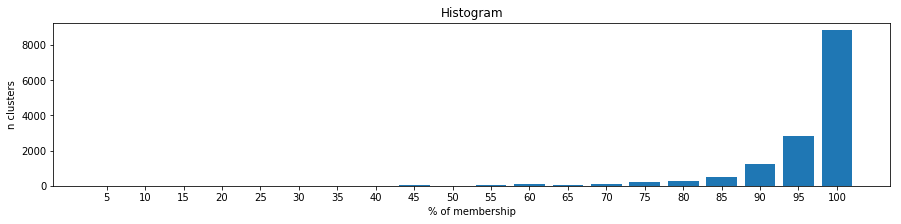

In [246]:
hist = [0]*20
for i in np.concatenate(percentages):
    hist[int(i/5)-1] +=1

y_pos = np.arange(0,20)
plt.figure(figsize=(15,3))
plt.bar(y_pos, hist, align='center', alpha=1)
plt.xticks(y_pos, (y_pos+1)*5)
plt.ylabel('n clusters')
plt.xlabel('% of membership')
plt.title('Histogram')

plt.show()

### kmeans over latent of centroids

#### Parameter selection

In [153]:
from sklearn.cluster import KMeans

In [155]:

#save_score = []
#for n in [950,975,1000,1025,1050]:
t0 = time.time()
kmeans = KMeans(n_clusters=97, random_state=0, n_jobs=-1).fit(latent)
clusters_kmeans_dict = defaultdict(list)
for k, clus in enumerate(kmeans.labels_):
    clusters_kmeans_dict[clus].append(k)
#s = other(clusters_kmeans_dict)
print(time.time()-t0)
#save_score.append(s)

5.891994476318359


In [23]:
display(all_centroids[::10], clusters_kmeans_dict, ids=range(10))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### execution

In [2]:
matrix_distances = np.load('pairwise.npy', allow_pickle=False)

In [166]:
import importlib
import kmedoids
importlib.reload(kmedoids)

<module 'kmedoids' from '/home/miguel/MT/Master/kmedoids.py'>

In [170]:
# split into 2 clusters
t0=time.time()
M, C = kmedoids.kMedoids(matrix_distances, 97)
print(time.time()-t0)
#print('medoids:')
#for point_idx in M:
#    print( data[point_idx] )

#print('clustering result:')
#for label in C:
#    for point_idx in C[label]:
#        print('label {0}:　{1}'.format(label, data[point_idx]))

6.867285966873169


In [171]:
clusters_kmeans_dict = defaultdict(list)
for num in range(97):
    clusters_kmeans_dict[num] = C[num]

In [169]:
t0 = time.time()
kmeans = KMeans(n_clusters=97, random_state=0).fit(latent)
print(time.time()-t0)
clusters_kmeans_dict = defaultdict(list)
for k, clus in enumerate(kmeans.labels_):
    clusters_kmeans_dict[clus].append(k)
print(other(clusters_kmeans_dict, ids))

KeyboardInterrupt: 

In [172]:
method_kmeans_dict = defaultdict(list)
for clus in clusters_kmeans_dict:
    method_kmeans_dict[clus] = np.concatenate(references[clusters_kmeans_dict[clus]])

In [35]:
def calculate_distance_matrix(x,y):
    matrix = []
    for num,i in enumerate(x):
        row = []
        for j in y:
            row.append(mdf(i,j))
        matrix.append(np.array(row))
    return np.array(matrix)

In [36]:
def compare_bundles(fascicle, cluster, threshold):
    n_cluster = len(cluster)
    n_fascicle = len(fascicle)
    visited_fibers = []
    counter = 0
    
    dm = calculate_distance_matrix(cluster, fascicle)
    for i in range(n_cluster):
        ix = np.argmin(dm[i])
        if (dm[i][ix] < threshold):
            counter += 1
            visited_fibers.append(ix)
    return counter * 100 / n_cluster, visited_fibers
    '''
    for cluster_fiber in cluster:
        for ix, tract_fiber in enumerate(fascicle):
            if (mdf(cluster_fiber, tract_fiber) < threshold):
                counter += 1
                break
    return counter * 100 / n
    '''

In [70]:
compare_bundles(all_data[0][labels[0]], np.concatenate(all_data)[method_kmeans_dict[101]],8)

2007 2029


98.91572203055692

In [36]:
display(np.concatenate(all_data)[method_kmeans_dict[101]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [35]:
display(all_data[0][labels[0]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [173]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_kmeans_dict:
        cluster_fibers = np.concatenate(all_data)[method_kmeans_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_kmeans_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        if len(set(a))/len(data[labels[i]]) > 0.9:
            c_per.append(1)
        else:
            c_per.append(0)
        #c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' precision: ', per, ' recall: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total precision: ', np.mean(all_percentages))
print('Total recall: ', np.mean(all_completness))

Subject 0 precision:  0.7835051546391752  recall:  0.8571428571428571
Subject 1 precision:  0.8556701030927835  recall:  0.8571428571428571
Subject 2 precision:  0.865979381443299  recall:  0.8571428571428571
Subject 3 precision:  0.7422680412371134  recall:  0.8571428571428571
Subject 4 precision:  0.8144329896907216  recall:  0.8571428571428571
Subject 5 precision:  0.7835051546391752  recall:  0.8285714285714286
Subject 6 precision:  0.7628865979381443  recall:  0.8571428571428571
Subject 7 precision:  0.7422680412371134  recall:  0.8285714285714286
Subject 8 precision:  0.7938144329896907  recall:  0.9142857142857143
Subject 9 precision:  0.8350515463917526  recall:  0.9142857142857143
Subject 10 precision:  0.8556701030927835  recall:  0.8857142857142857
Subject 11 precision:  0.7938144329896907  recall:  0.8
Subject 12 precision:  0.8041237113402062  recall:  0.8285714285714286
Subject 13 precision:  0.6597938144329897  recall:  0.8571428571428571
Subject 14 precision:  0.7113402

In [160]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_kmeans_dict:
        cluster_fibers = np.concatenate(all_data)[method_kmeans_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_kmeans_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        if len(set(a))/len(data[labels[i]]) > 0.9:
            c_per.append(1)
        else:
            c_per.append(0)
        #c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' precision: ', per, ' recall: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total precision: ', np.mean(all_percentages))
print('Total recall: ', np.mean(all_completness))

Subject 0 precision:  0.7708333333333334  recall:  0.8611111111111112
Subject 1 precision:  0.8229166666666666  recall:  0.8333333333333334
Subject 2 precision:  0.8229166666666666  recall:  0.9166666666666666
Subject 3 precision:  0.7604166666666666  recall:  0.8888888888888888
Subject 4 precision:  0.7916666666666666  recall:  0.8611111111111112
Subject 5 precision:  0.78125  recall:  0.8333333333333334
Subject 6 precision:  0.7395833333333334  recall:  0.8611111111111112
Subject 7 precision:  0.7604166666666666  recall:  0.8333333333333334
Subject 8 precision:  0.78125  recall:  0.8888888888888888
Subject 9 precision:  0.7916666666666666  recall:  0.8888888888888888
Subject 10 precision:  0.7604166666666666  recall:  0.8888888888888888
Subject 11 precision:  0.8020833333333334  recall:  0.8611111111111112
Subject 12 precision:  0.8020833333333334  recall:  0.8888888888888888
Subject 13 precision:  0.6666666666666666  recall:  0.8611111111111112
Subject 14 precision:  0.71875  recall

In [37]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_kmeans_dict:
        cluster_fibers = np.concatenate(all_data)[method_kmeans_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_kmeans_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' belonging score: ', per, ' integrity score: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total belonging score: ', np.mean(all_percentages))
print('Total integrity score: ', np.mean(all_completness))

Subject 0 belonging score:  85.20033170763601  integrity score:  95.61695616980504
Subject 1 belonging score:  88.63570377967915  integrity score:  95.84882293093997
Subject 2 belonging score:  88.28180632758244  integrity score:  96.12962271953992
Subject 3 belonging score:  84.70429924986233  integrity score:  96.31678556290132
Subject 4 belonging score:  87.62323747972209  integrity score:  95.41601541976219
Subject 5 belonging score:  87.8193568579295  integrity score:  95.70299484375177
Subject 6 belonging score:  86.36287843050725  integrity score:  96.60881140355937
Subject 7 belonging score:  86.88788250235166  integrity score:  96.32618174832696
Subject 8 belonging score:  85.94449023069104  integrity score:  96.32912130346837
Subject 9 belonging score:  88.24069364069021  integrity score:  96.19665408104456
Subject 10 belonging score:  87.22938825662807  integrity score:  95.84688985144527
Subject 11 belonging score:  86.82336293558069  integrity score:  95.98879134411474
Sub

In [24]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_kmeans_dict:
        cluster_fibers = np.concatenate(all_data)[method_kmeans_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_kmeans_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' belonging score: ', per, ' integrity score: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total belonging score: ', np.mean(all_percentages))
print('Total integrity score: ', np.mean(all_completness))

Subject 0 belonging score:  84.76685133419123  integrity score:  96.86186230342035
Subject 1 belonging score:  87.48706957108561  integrity score:  96.54849443948328
Subject 2 belonging score:  87.16826432586878  integrity score:  97.08904030343274
Subject 3 belonging score:  84.87054177832638  integrity score:  96.69628850446497
Subject 4 belonging score:  87.41820455625789  integrity score:  96.62445303086253
Subject 5 belonging score:  86.89338609519716  integrity score:  96.33167011320656
Subject 6 belonging score:  85.80777167066795  integrity score:  96.75978211014531
Subject 7 belonging score:  85.7640730668486  integrity score:  96.35388463065236
Subject 8 belonging score:  85.56389734754403  integrity score:  96.83277058634728
Subject 9 belonging score:  86.70419312116063  integrity score:  96.95205958730126
Subject 10 belonging score:  86.21778600604489  integrity score:  96.94242926615154
Subject 11 belonging score:  86.43335209988216  integrity score:  96.9184230064287
Subj

97.14007038912517


In [ ]:
completness = [0]*36

In [29]:
labels.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [ ]:
threshold = 8
all_percentages = []
for subject in range(20):
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_kmeans_dict:
        cluster_fibers = np.concatenate(all_data)[method_kmeans_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_kmeans_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per = compare_bundles(label_fibers, cluster_fibers, threshold)
        percentages.append(per)
    per = np.mean(percentages)
    print('Subject '+str(subject)+' score: ', per)
    all_percentages.append(per)
print('Total score: ', np.mean(all_percentages))

In [330]:
display(all_centroids, clusters_kmeans_dict, ids=range(10,20))
display(np.concatenate(all_data), method_kmeans_dict, ids=range(10,20))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### Two-level FFClust

#### Parameter selection

In [5]:
scores = []
for i in [60,70,80,90,100,110,120]:
    for j in [10,20,30,40,50,60,70]:
        path = 'data/79subjects/clustered/filtered/'+str(i)+'_'+str(j)+'/output/final_clusters.txt'
        f=open(path, "r")
        ffclust_dict = defaultdict(list)
        for k, clust in enumerate(f):
            ffclust_dict[k] = [int(fib) for fib in clust.split()[1:]]
        s = other(ffclust_dict,ids)
        print(i,j,k,s)
        scores.append(s)

10 10 27207 0.14128662828133196
10 20 17186 0.26616820337420155
10 30 15985 0.2967762931805838
10 40 15649 0.30784810126582274
10 50 15537 0.3126186352445861
10 60 15508 0.3143376936707228
10 70 15507 0.3144077536134882
20 10 18966 0.15414781035415945
20 20 11651 0.29102300034328876
20 30 10704 0.32765122177617223
20 40 10440 0.3407198253234873
20 50 10349 0.3464037179722376
20 60 10324 0.34847825420663875
20 70 10323 0.348568408869097
30 10 15108 0.14228756269840004
30 20 8911 0.2826625457355181
30 30 8108 0.32210030736281464
30 40 7882 0.33622103003258086
30 50 7803 0.3426172232350823
30 60 7780 0.3449330485326966
30 70 7779 0.3450489733493866
40 10 11931 0.13394361296290794
40 20 6558 0.2810825206837258
40 30 5782 0.3306986650089634
40 40 5581 0.3480717858940808
40 50 5509 0.35573525695513336
40 60 5488 0.3586113538930564
40 70 5487 0.35872974868066587
50 10 9321 0.12117109654852139
50 20 4882 0.2705433731597871
50 30 4122 0.3332309950048662
50 40 3897 0.35810964402387446
50 50 3816

#### Open two level clustered synthetic

In [57]:
len(all_centroids)

40800

In [58]:
BT.write_bundle('data/synthetic_subjects/two_level/joined.bundles', all_centroids)

In [161]:
path = 'data/synthetic_subjects/two_level/joined/output/final_clusters.txt'
f=open(path, "r")
ffclust_dict = defaultdict(list)
for k, clust in enumerate(f):
    ffclust_dict[k] = [int(fib) for fib in clust.split()[1:]]
print(k)

131


In [162]:
display(all_centroids, ffclust_dict, ids=range(10) )

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [163]:
method_twolevel_dict = defaultdict(list)
for clus in ffclust_dict:
    print(clus)
    method_twolevel_dict[clus] = np.concatenate(references[ffclust_dict[clus]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


In [164]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_twolevel_dict:
        cluster_fibers = np.concatenate(all_data)[method_twolevel_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_twolevel_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        if len(set(a))/len(data[labels[i]]) > 0.9:
            c_per.append(1)
        else:
            c_per.append(0)
        #c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' precision: ', per, ' recall: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total precision: ', np.mean(all_percentages))
print('Total recall: ', np.mean(all_completness))

Subject 0 precision:  0.7045454545454546  recall:  0.75
Subject 1 precision:  0.803030303030303  recall:  0.7777777777777778
Subject 2 precision:  0.7651515151515151  recall:  0.8055555555555556
Subject 3 precision:  0.6515151515151515  recall:  0.8333333333333334
Subject 4 precision:  0.7348484848484849  recall:  0.75
Subject 5 precision:  0.7348484848484849  recall:  0.7777777777777778
Subject 6 precision:  0.7196969696969697  recall:  0.7777777777777778
Subject 7 precision:  0.7272727272727273  recall:  0.7222222222222222
Subject 8 precision:  0.6742424242424242  recall:  0.7222222222222222
Subject 9 precision:  0.7196969696969697  recall:  0.7777777777777778
Subject 10 precision:  0.7348484848484849  recall:  0.7777777777777778
Subject 11 precision:  0.7196969696969697  recall:  0.7222222222222222
Subject 12 precision:  0.696969696969697  recall:  0.75
Subject 13 precision:  0.6666666666666666  recall:  0.7777777777777778
Subject 14 precision:  0.7196969696969697  recall:  0.777777

In [27]:
threshold = 8
all_percentages = []
all_completness = []
for subject in range(20):
    completness = defaultdict(list)
    data = all_data[subject]
    labels = all_labels[subject]
    percentages = []
    for cluster in method_twolevel_dict:
        cluster_fibers = np.concatenate(all_data)[method_twolevel_dict[cluster]]
        associated_label = np.argmax(np.bincount(label_reference[method_twolevel_dict[cluster]]))
        label_fibers = data[labels[associated_label]]
        per, visited_fibers = compare_bundles(label_fibers, cluster_fibers, threshold)
        completness[associated_label].append(visited_fibers)
        percentages.append(per)
    per = np.mean(percentages)
    
    c_per = []
    for i in completness:
        if(len(np.array(completness[i]).shape) == 1):
            a = np.concatenate(completness[i])
        else:
            a = completness[i][0]
        c_per.append(len(set(a))*100/len(data[labels[i]]))
    c_per = np.mean(c_per)
    print('Subject '+str(subject)+' belonging score: ', per, ' integrity score: ', c_per)
    all_percentages.append(per)
    all_completness.append(c_per)
print('Total belonging score: ', np.mean(all_percentages))
print('Total integrity score: ', np.mean(all_completness))

Subject 0 belonging score:  83.90745383043398  integrity score:  92.75031194989866
Subject 1 belonging score:  87.46022302144918  integrity score:  93.12905810173277
Subject 2 belonging score:  87.1263465866672  integrity score:  93.27368559839556
Subject 3 belonging score:  80.83216999293415  integrity score:  92.82005078894046
Subject 4 belonging score:  86.20395396323423  integrity score:  92.58303562341905
Subject 5 belonging score:  85.5788166801252  integrity score:  93.15028911351975
Subject 6 belonging score:  85.09691926801712  integrity score:  93.28054855704227
Subject 7 belonging score:  86.30377174894583  integrity score:  92.54646436927565
Subject 8 belonging score:  83.72221855574026  integrity score:  93.17552736178902
Subject 9 belonging score:  85.43479224033244  integrity score:  93.38468748132749
Subject 10 belonging score:  86.00577114151815  integrity score:  92.70418154538669
Subject 11 belonging score:  85.68930371890525  integrity score:  93.09729792301039
Subj

In [206]:
synthetic = []
synthetic_labels = []
for num, i in enumerate(data):
    synthetic.append((np.array(i)-xmin)/(xmax-xmin))
    synthetic_labels += [num] * len(i)
synthetic = np.concatenate(synthetic)
synthetic_labels = np.array(synthetic_labels)

In [207]:
validation_score(ATLAS, ATLAS_labels, synthetic, synthetic_labels, threshold = 0.02)

Creating dicts...
Getting tract centroids...
Getting cluster centroids...
93 42352
Pairing tracts and clusters...
Calculating percentage of membership of each cluster...
-------- 0 --------
for cluster  0 :  98.828125 %
for cluster  1 :  92.5925925925926 %
for cluster  2 :  100.0 %
for cluster  3 :  100.0 %
for cluster  4 :  100.0 %
for cluster  5 :  100.0 %
for cluster  6 :  100.0 %
for cluster  7 :  99.04306220095694 %
for cluster  8 :  91.74757281553399 %
for cluster  9 :  100.0 %
for cluster  10 :  100.0 %
for cluster  11 :  100.0 %
for cluster  12 :  100.0 %
for cluster  13 :  100.0 %
for cluster  14 :  100.0 %
for cluster  15 :  99.0909090909091 %
for cluster  16 :  100.0 %
for cluster  17 :  95.23809523809524 %
for cluster  18 :  86.36363636363636 %
for cluster  19 :  99.4535519125683 %
for cluster  20 :  100.0 %
for cluster  21 :  100.0 %
for cluster  22 :  72.72727272727273 %
for cluster  23 :  100.0 %
for cluster  24 :  98.42931937172774 %
for cluster  25 :  100.0 %
for clust

for cluster  287 :  100.0 %
for cluster  288 :  0.0 %
for cluster  289 :  100.0 %
for cluster  290 :  100.0 %
for cluster  291 :  100.0 %
for cluster  292 :  100.0 %
for cluster  293 :  100.0 %
for cluster  294 :  0.0 %
for cluster  295 :  0.0 %
for cluster  296 :  100.0 %
for cluster  297 :  100.0 %
for cluster  298 :  100.0 %
for cluster  299 :  100.0 %
-------- 300 --------
for cluster  300 :  0.0 %
for cluster  301 :  100.0 %
for cluster  302 :  0.0 %
for cluster  303 :  0.0 %
for cluster  304 :  100.0 %
for cluster  305 :  100.0 %
for cluster  306 :  100.0 %
for cluster  307 :  100.0 %
for cluster  308 :  100.0 %
for cluster  309 :  100.0 %
for cluster  310 :  100.0 %
for cluster  311 :  100.0 %
for cluster  312 :  100.0 %
for cluster  313 :  100.0 %
for cluster  314 :  100.0 %
for cluster  315 :  100.0 %
for cluster  316 :  100.0 %
for cluster  317 :  96.29629629629629 %
for cluster  318 :  100.0 %
for cluster  319 :  84.21052631578948 %
for cluster  320 :  100.0 %
for cluster  3

for cluster  565 :  94.1717791411043 %
for cluster  566 :  96.57483246463143 %
for cluster  567 :  90.7103825136612 %
for cluster  568 :  83.33333333333333 %
for cluster  569 :  100.0 %
for cluster  570 :  100.0 %
for cluster  571 :  100.0 %
for cluster  572 :  52.38095238095238 %
for cluster  573 :  32.53968253968254 %
for cluster  574 :  100.0 %
for cluster  575 :  100.0 %
for cluster  576 :  42.666666666666664 %
for cluster  577 :  34.78260869565217 %
for cluster  578 :  100.0 %
for cluster  579 :  100.0 %
for cluster  580 :  10.526315789473685 %
for cluster  581 :  0.0 %
for cluster  582 :  0.0 %
for cluster  583 :  0.0 %
for cluster  584 :  97.99154334038055 %
for cluster  585 :  100.0 %
for cluster  586 :  100.0 %
for cluster  587 :  40.0 %
for cluster  588 :  93.75 %
for cluster  589 :  100.0 %
for cluster  590 :  100.0 %
for cluster  591 :  50.0 %
for cluster  592 :  55.55555555555556 %
for cluster  593 :  94.87179487179488 %
for cluster  594 :  100.0 %
for cluster  595 :  100.

for cluster  844 :  100.0 %
for cluster  845 :  100.0 %
for cluster  846 :  100.0 %
for cluster  847 :  100.0 %
for cluster  848 :  96.7741935483871 %
for cluster  849 :  100.0 %
for cluster  850 :  94.36619718309859 %
for cluster  851 :  100.0 %
for cluster  852 :  100.0 %
for cluster  853 :  100.0 %
for cluster  854 :  100.0 %
for cluster  855 :  94.28571428571429 %
for cluster  856 :  100.0 %
for cluster  857 :  100.0 %
for cluster  858 :  100.0 %
for cluster  859 :  100.0 %
for cluster  860 :  100.0 %
for cluster  861 :  91.30434782608695 %
for cluster  862 :  100.0 %
for cluster  863 :  96.66666666666667 %
for cluster  864 :  72.0 %
for cluster  865 :  75.0 %
for cluster  866 :  100.0 %
for cluster  867 :  0.0 %
for cluster  868 :  100.0 %
for cluster  869 :  100.0 %
for cluster  870 :  100.0 %
for cluster  871 :  100.0 %
for cluster  872 :  100.0 %
for cluster  873 :  100.0 %
for cluster  874 :  100.0 %
for cluster  875 :  100.0 %
for cluster  876 :  84.90566037735849 %
for clust

for cluster  1120 :  75.0 %
for cluster  1121 :  0.0 %
for cluster  1122 :  100.0 %
for cluster  1123 :  100.0 %
for cluster  1124 :  38.46153846153846 %
for cluster  1125 :  0.0 %
for cluster  1126 :  0.0 %
for cluster  1127 :  100.0 %
for cluster  1128 :  0.0 %
for cluster  1129 :  70.0 %
for cluster  1130 :  100.0 %
for cluster  1131 :  100.0 %
for cluster  1132 :  37.5 %
for cluster  1133 :  0.0 %
for cluster  1134 :  0.0 %
for cluster  1135 :  100.0 %
for cluster  1136 :  100.0 %
for cluster  1137 :  100.0 %
for cluster  1138 :  87.5 %
for cluster  1139 :  60.0 %
for cluster  1140 :  42.857142857142854 %
for cluster  1141 :  0.0 %
for cluster  1142 :  100.0 %
for cluster  1143 :  100.0 %
for cluster  1144 :  100.0 %
for cluster  1145 :  100.0 %
for cluster  1146 :  100.0 %
for cluster  1147 :  83.33333333333333 %
for cluster  1148 :  100.0 %
for cluster  1149 :  100.0 %
for cluster  1150 :  100.0 %
for cluster  1151 :  100.0 %
for cluster  1152 :  100.0 %
for cluster  1153 :  25.0

for cluster  1391 :  96.2406015037594 %
for cluster  1392 :  100.0 %
for cluster  1393 :  100.0 %
for cluster  1394 :  100.0 %
for cluster  1395 :  96.90721649484536 %
for cluster  1396 :  100.0 %
for cluster  1397 :  100.0 %
for cluster  1398 :  100.0 %
for cluster  1399 :  100.0 %
-------- 1400 --------
for cluster  1400 :  99.07407407407408 %
for cluster  1401 :  100.0 %
for cluster  1402 :  100.0 %
for cluster  1403 :  93.33333333333333 %
for cluster  1404 :  69.23076923076923 %
for cluster  1405 :  81.81818181818181 %
for cluster  1406 :  86.20689655172414 %
for cluster  1407 :  93.62244897959184 %
for cluster  1408 :  98.88268156424581 %
for cluster  1409 :  92.5925925925926 %
for cluster  1410 :  95.51569506726457 %
for cluster  1411 :  100.0 %
for cluster  1412 :  100.0 %
for cluster  1413 :  71.42857142857143 %
for cluster  1414 :  100.0 %
for cluster  1415 :  100.0 %
for cluster  1416 :  78.4 %
for cluster  1417 :  93.54838709677419 %
for cluster  1418 :  82.05128205128206 %


for cluster  1648 :  100.0 %
for cluster  1649 :  57.142857142857146 %
for cluster  1650 :  0.0 %
for cluster  1651 :  0.0 %
for cluster  1652 :  0.0 %
for cluster  1653 :  68.42105263157895 %
for cluster  1654 :  30.0 %
for cluster  1655 :  84.61538461538461 %
for cluster  1656 :  100.0 %
for cluster  1657 :  50.0 %
for cluster  1658 :  0.0 %
for cluster  1659 :  0.0 %
for cluster  1660 :  76.92307692307692 %
for cluster  1661 :  0.0 %
for cluster  1662 :  55.55555555555556 %
for cluster  1663 :  100.0 %
for cluster  1664 :  100.0 %
for cluster  1665 :  100.0 %
for cluster  1666 :  100.0 %
for cluster  1667 :  100.0 %
for cluster  1668 :  100.0 %
for cluster  1669 :  100.0 %
for cluster  1670 :  100.0 %
for cluster  1671 :  0.0 %
for cluster  1672 :  100.0 %
for cluster  1673 :  100.0 %
for cluster  1674 :  100.0 %
for cluster  1675 :  0.0 %
for cluster  1676 :  0.0 %
for cluster  1677 :  0.0 %
for cluster  1678 :  50.0 %
for cluster  1679 :  20.0 %
for cluster  1680 :  62.5 %
for clu

for cluster  1925 :  0.0 %
for cluster  1926 :  0.0 %
for cluster  1927 :  0.0 %
for cluster  1928 :  0.0 %
for cluster  1929 :  100.0 %
for cluster  1930 :  100.0 %
for cluster  1931 :  0.0 %
for cluster  1932 :  0.0 %
for cluster  1933 :  0.0 %
for cluster  1934 :  0.0 %
for cluster  1935 :  0.0 %
for cluster  1936 :  100.0 %
for cluster  1937 :  100.0 %
for cluster  1938 :  100.0 %
for cluster  1939 :  100.0 %
for cluster  1940 :  100.0 %
for cluster  1941 :  100.0 %
for cluster  1942 :  100.0 %
for cluster  1943 :  100.0 %
for cluster  1944 :  100.0 %
for cluster  1945 :  100.0 %
for cluster  1946 :  86.11111111111111 %
for cluster  1947 :  100.0 %
for cluster  1948 :  96.29629629629629 %
for cluster  1949 :  100.0 %
for cluster  1950 :  100.0 %
for cluster  1951 :  100.0 %
for cluster  1952 :  100.0 %
for cluster  1953 :  100.0 %
for cluster  1954 :  100.0 %
for cluster  1955 :  100.0 %
for cluster  1956 :  100.0 %
for cluster  1957 :  100.0 %
for cluster  1958 :  100.0 %
for clus

for cluster  2209 :  100.0 %
for cluster  2210 :  100.0 %
for cluster  2211 :  100.0 %
for cluster  2212 :  100.0 %
for cluster  2213 :  100.0 %
for cluster  2214 :  84.21052631578948 %
for cluster  2215 :  100.0 %
for cluster  2216 :  0.0 %
for cluster  2217 :  100.0 %
for cluster  2218 :  0.0 %
for cluster  2219 :  64.28571428571429 %
for cluster  2220 :  93.22033898305085 %
for cluster  2221 :  100.0 %
for cluster  2222 :  100.0 %
for cluster  2223 :  100.0 %
for cluster  2224 :  43.75 %
for cluster  2225 :  100.0 %
for cluster  2226 :  0.0 %
for cluster  2227 :  100.0 %
for cluster  2228 :  100.0 %
for cluster  2229 :  100.0 %
for cluster  2230 :  95.16129032258064 %
for cluster  2231 :  100.0 %
for cluster  2232 :  100.0 %
for cluster  2233 :  100.0 %
for cluster  2234 :  100.0 %
for cluster  2235 :  0.0 %
for cluster  2236 :  100.0 %
for cluster  2237 :  94.33962264150944 %
for cluster  2238 :  100.0 %
for cluster  2239 :  0.0 %
for cluster  2240 :  100.0 %
for cluster  2241 :  1

for cluster  2487 :  100.0 %
for cluster  2488 :  62.5 %
for cluster  2489 :  100.0 %
for cluster  2490 :  89.6103896103896 %
for cluster  2491 :  90.0 %
for cluster  2492 :  100.0 %
for cluster  2493 :  100.0 %
for cluster  2494 :  100.0 %
for cluster  2495 :  0.0 %
for cluster  2496 :  100.0 %
for cluster  2497 :  28.571428571428573 %
for cluster  2498 :  100.0 %
for cluster  2499 :  0.0 %
-------- 2500 --------
for cluster  2500 :  94.44444444444444 %
for cluster  2501 :  95.1219512195122 %
for cluster  2502 :  100.0 %
for cluster  2503 :  100.0 %
for cluster  2504 :  100.0 %
for cluster  2505 :  0.0 %
for cluster  2506 :  100.0 %
for cluster  2507 :  100.0 %
for cluster  2508 :  0.0 %
for cluster  2509 :  83.33333333333333 %
for cluster  2510 :  92.85714285714286 %
for cluster  2511 :  100.0 %
for cluster  2512 :  100.0 %
for cluster  2513 :  100.0 %
for cluster  2514 :  100.0 %
for cluster  2515 :  96.47058823529412 %
for cluster  2516 :  100.0 %
for cluster  2517 :  100.0 %
for c

for cluster  2760 :  100.0 %
for cluster  2761 :  86.56716417910448 %
for cluster  2762 :  100.0 %
for cluster  2763 :  100.0 %
for cluster  2764 :  92.85714285714286 %
for cluster  2765 :  100.0 %
for cluster  2766 :  100.0 %
for cluster  2767 :  100.0 %
for cluster  2768 :  100.0 %
for cluster  2769 :  100.0 %
for cluster  2770 :  100.0 %
for cluster  2771 :  100.0 %
for cluster  2772 :  100.0 %
for cluster  2773 :  100.0 %
for cluster  2774 :  100.0 %
for cluster  2775 :  100.0 %
for cluster  2776 :  100.0 %
for cluster  2777 :  100.0 %
for cluster  2778 :  100.0 %
for cluster  2779 :  100.0 %
for cluster  2780 :  80.0 %
for cluster  2781 :  100.0 %
for cluster  2782 :  100.0 %
for cluster  2783 :  100.0 %
for cluster  2784 :  92.3076923076923 %
for cluster  2785 :  100.0 %
for cluster  2786 :  100.0 %
for cluster  2787 :  100.0 %
for cluster  2788 :  87.34567901234568 %
for cluster  2789 :  100.0 %
for cluster  2790 :  23.076923076923077 %
for cluster  2791 :  96.93251533742331 %
f

for cluster  3021 :  100.0 %
for cluster  3022 :  50.0 %
for cluster  3023 :  100.0 %
for cluster  3024 :  100.0 %
for cluster  3025 :  100.0 %
for cluster  3026 :  94.11764705882354 %
for cluster  3027 :  100.0 %
for cluster  3028 :  100.0 %
for cluster  3029 :  100.0 %
for cluster  3030 :  100.0 %
for cluster  3031 :  92.6470588235294 %
for cluster  3032 :  100.0 %
for cluster  3033 :  100.0 %
for cluster  3034 :  100.0 %
for cluster  3035 :  94.82758620689656 %
for cluster  3036 :  100.0 %
for cluster  3037 :  100.0 %
for cluster  3038 :  100.0 %
for cluster  3039 :  0.0 %
for cluster  3040 :  0.0 %
for cluster  3041 :  0.0 %
for cluster  3042 :  100.0 %
for cluster  3043 :  100.0 %
for cluster  3044 :  100.0 %
for cluster  3045 :  100.0 %
for cluster  3046 :  25.58139534883721 %
for cluster  3047 :  100.0 %
for cluster  3048 :  100.0 %
for cluster  3049 :  100.0 %
for cluster  3050 :  100.0 %
for cluster  3051 :  93.20388349514563 %
for cluster  3052 :  83.33333333333333 %
for clus

for cluster  3286 :  100.0 %
for cluster  3287 :  100.0 %
for cluster  3288 :  0.0 %
for cluster  3289 :  100.0 %
for cluster  3290 :  100.0 %
for cluster  3291 :  100.0 %
for cluster  3292 :  82.85714285714286 %
for cluster  3293 :  0.0 %
for cluster  3294 :  0.0 %
for cluster  3295 :  0.0 %
for cluster  3296 :  42.857142857142854 %
for cluster  3297 :  0.0 %
for cluster  3298 :  100.0 %
for cluster  3299 :  100.0 %
-------- 3300 --------
for cluster  3300 :  100.0 %
for cluster  3301 :  100.0 %
for cluster  3302 :  0.0 %
for cluster  3303 :  100.0 %
for cluster  3304 :  100.0 %
for cluster  3305 :  100.0 %
for cluster  3306 :  100.0 %
for cluster  3307 :  100.0 %
for cluster  3308 :  100.0 %
for cluster  3309 :  75.0 %
for cluster  3310 :  100.0 %
for cluster  3311 :  100.0 %
for cluster  3312 :  0.0 %
for cluster  3313 :  100.0 %
for cluster  3314 :  22.857142857142858 %
for cluster  3315 :  100.0 %
for cluster  3316 :  100.0 %
for cluster  3317 :  100.0 %
for cluster  3318 :  50.0 

for cluster  3560 :  100.0 %
for cluster  3561 :  100.0 %
for cluster  3562 :  100.0 %
for cluster  3563 :  100.0 %
for cluster  3564 :  0.0 %
for cluster  3565 :  60.0 %
for cluster  3566 :  85.71428571428571 %
for cluster  3567 :  100.0 %
for cluster  3568 :  100.0 %
for cluster  3569 :  100.0 %
for cluster  3570 :  100.0 %
for cluster  3571 :  100.0 %
for cluster  3572 :  0.0 %
for cluster  3573 :  0.0 %
for cluster  3574 :  0.0 %
for cluster  3575 :  100.0 %
for cluster  3576 :  100.0 %
for cluster  3577 :  76.13636363636364 %
for cluster  3578 :  100.0 %
for cluster  3579 :  13.157894736842104 %
for cluster  3580 :  71.42857142857143 %
for cluster  3581 :  100.0 %
for cluster  3582 :  100.0 %
for cluster  3583 :  22.22222222222222 %
for cluster  3584 :  100.0 %
for cluster  3585 :  100.0 %
for cluster  3586 :  100.0 %
for cluster  3587 :  100.0 %
for cluster  3588 :  100.0 %
for cluster  3589 :  48.78048780487805 %
for cluster  3590 :  0.0 %
for cluster  3591 :  71.42857142857143 

for cluster  3831 :  100.0 %
for cluster  3832 :  100.0 %
for cluster  3833 :  100.0 %
for cluster  3834 :  78.94736842105263 %
for cluster  3835 :  95.06172839506173 %
for cluster  3836 :  77.35849056603773 %
for cluster  3837 :  100.0 %
for cluster  3838 :  100.0 %
for cluster  3839 :  100.0 %
for cluster  3840 :  100.0 %
for cluster  3841 :  100.0 %
for cluster  3842 :  9.523809523809524 %
for cluster  3843 :  30.76923076923077 %
for cluster  3844 :  100.0 %
for cluster  3845 :  100.0 %
for cluster  3846 :  90.625 %
for cluster  3847 :  100.0 %
for cluster  3848 :  100.0 %
for cluster  3849 :  100.0 %
for cluster  3850 :  95.34883720930233 %
for cluster  3851 :  90.625 %
for cluster  3852 :  100.0 %
for cluster  3853 :  76.92307692307692 %
for cluster  3854 :  59.523809523809526 %
for cluster  3855 :  100.0 %
for cluster  3856 :  100.0 %
for cluster  3857 :  78.33333333333333 %
for cluster  3858 :  97.84172661870504 %
for cluster  3859 :  100.0 %
for cluster  3860 :  100.0 %
for clu

for cluster  4093 :  84.0 %
for cluster  4094 :  100.0 %
for cluster  4095 :  0.0 %
for cluster  4096 :  75.0 %
for cluster  4097 :  100.0 %
for cluster  4098 :  100.0 %
for cluster  4099 :  0.0 %
-------- 4100 --------
for cluster  4100 :  0.0 %
for cluster  4101 :  0.0 %
for cluster  4102 :  0.0 %
for cluster  4103 :  100.0 %
for cluster  4104 :  100.0 %
for cluster  4105 :  0.0 %
for cluster  4106 :  0.0 %
for cluster  4107 :  25.0 %
for cluster  4108 :  0.0 %
for cluster  4109 :  0.0 %
for cluster  4110 :  0.0 %
for cluster  4111 :  100.0 %
for cluster  4112 :  100.0 %
for cluster  4113 :  100.0 %
for cluster  4114 :  0.0 %
for cluster  4115 :  0.0 %
for cluster  4116 :  0.0 %
for cluster  4117 :  100.0 %
for cluster  4118 :  0.0 %
for cluster  4119 :  100.0 %
for cluster  4120 :  0.0 %
for cluster  4121 :  100.0 %
for cluster  4122 :  100.0 %
for cluster  4123 :  0.0 %
for cluster  4124 :  100.0 %
for cluster  4125 :  0.0 %
for cluster  4126 :  0.0 %
for cluster  4127 :  100.0 %
f

for cluster  4359 :  100.0 %
for cluster  4360 :  91.66666666666667 %
for cluster  4361 :  100.0 %
for cluster  4362 :  100.0 %
for cluster  4363 :  100.0 %
for cluster  4364 :  100.0 %
for cluster  4365 :  100.0 %
for cluster  4366 :  100.0 %
for cluster  4367 :  100.0 %
for cluster  4368 :  100.0 %
for cluster  4369 :  100.0 %
for cluster  4370 :  100.0 %
for cluster  4371 :  100.0 %
for cluster  4372 :  100.0 %
for cluster  4373 :  100.0 %
for cluster  4374 :  100.0 %
for cluster  4375 :  100.0 %
for cluster  4376 :  100.0 %
for cluster  4377 :  100.0 %
for cluster  4378 :  100.0 %
for cluster  4379 :  100.0 %
for cluster  4380 :  100.0 %
for cluster  4381 :  100.0 %
for cluster  4382 :  95.6140350877193 %
for cluster  4383 :  96.47058823529412 %
for cluster  4384 :  100.0 %
for cluster  4385 :  100.0 %
for cluster  4386 :  96.875 %
for cluster  4387 :  64.70588235294117 %
for cluster  4388 :  100.0 %
for cluster  4389 :  100.0 %
for cluster  4390 :  100.0 %
for cluster  4391 :  100

for cluster  4629 :  100.0 %
for cluster  4630 :  100.0 %
for cluster  4631 :  0.0 %
for cluster  4632 :  100.0 %
for cluster  4633 :  100.0 %
for cluster  4634 :  100.0 %
for cluster  4635 :  97.59036144578313 %
for cluster  4636 :  100.0 %
for cluster  4637 :  87.09677419354838 %
for cluster  4638 :  53.84615384615385 %
for cluster  4639 :  100.0 %
for cluster  4640 :  100.0 %
for cluster  4641 :  97.61904761904762 %
for cluster  4642 :  100.0 %
for cluster  4643 :  100.0 %
for cluster  4644 :  100.0 %
for cluster  4645 :  100.0 %
for cluster  4646 :  100.0 %
for cluster  4647 :  100.0 %
for cluster  4648 :  100.0 %
for cluster  4649 :  100.0 %
for cluster  4650 :  0.0 %
for cluster  4651 :  93.33333333333333 %
for cluster  4652 :  100.0 %
for cluster  4653 :  100.0 %
for cluster  4654 :  100.0 %
for cluster  4655 :  100.0 %
for cluster  4656 :  100.0 %
for cluster  4657 :  100.0 %
for cluster  4658 :  100.0 %
for cluster  4659 :  100.0 %
for cluster  4660 :  0.0 %
for cluster  4661 

for cluster  4904 :  83.33333333333333 %
for cluster  4905 :  100.0 %
for cluster  4906 :  0.0 %
for cluster  4907 :  0.0 %
for cluster  4908 :  100.0 %
for cluster  4909 :  0.0 %
for cluster  4910 :  100.0 %
for cluster  4911 :  100.0 %
for cluster  4912 :  33.333333333333336 %
for cluster  4913 :  100.0 %
for cluster  4914 :  100.0 %
for cluster  4915 :  0.0 %
for cluster  4916 :  100.0 %
for cluster  4917 :  100.0 %
for cluster  4918 :  50.0 %
for cluster  4919 :  88.23529411764706 %
for cluster  4920 :  100.0 %
for cluster  4921 :  100.0 %
for cluster  4922 :  81.25 %
for cluster  4923 :  100.0 %
for cluster  4924 :  100.0 %
for cluster  4925 :  100.0 %
for cluster  4926 :  100.0 %
for cluster  4927 :  100.0 %
for cluster  4928 :  100.0 %
for cluster  4929 :  0.0 %
for cluster  4930 :  85.71428571428571 %
for cluster  4931 :  0.0 %
for cluster  4932 :  100.0 %
for cluster  4933 :  100.0 %
for cluster  4934 :  100.0 %
for cluster  4935 :  100.0 %
for cluster  4936 :  100.0 %
for clu

for cluster  5171 :  25.0 %
for cluster  5172 :  100.0 %
for cluster  5173 :  88.88888888888889 %
for cluster  5174 :  100.0 %
for cluster  5175 :  0.0 %
for cluster  5176 :  94.28571428571429 %
for cluster  5177 :  66.66666666666667 %
for cluster  5178 :  100.0 %
for cluster  5179 :  100.0 %
for cluster  5180 :  83.33333333333333 %
for cluster  5181 :  40.0 %
for cluster  5182 :  91.42857142857143 %
for cluster  5183 :  100.0 %
for cluster  5184 :  33.333333333333336 %
for cluster  5185 :  100.0 %
for cluster  5186 :  100.0 %
for cluster  5187 :  91.30434782608695 %
for cluster  5188 :  100.0 %
for cluster  5189 :  100.0 %
for cluster  5190 :  0.0 %
for cluster  5191 :  78.94736842105263 %
for cluster  5192 :  100.0 %
for cluster  5193 :  100.0 %
for cluster  5194 :  98.87005649717514 %
for cluster  5195 :  100.0 %
for cluster  5196 :  100.0 %
for cluster  5197 :  0.0 %
for cluster  5198 :  100.0 %
for cluster  5199 :  100.0 %
-------- 5200 --------
for cluster  5200 :  84.44444444444

for cluster  5430 :  100.0 %
for cluster  5431 :  100.0 %
for cluster  5432 :  100.0 %
for cluster  5433 :  100.0 %
for cluster  5434 :  100.0 %
for cluster  5435 :  100.0 %
for cluster  5436 :  100.0 %
for cluster  5437 :  100.0 %
for cluster  5438 :  100.0 %
for cluster  5439 :  100.0 %
for cluster  5440 :  100.0 %
for cluster  5441 :  100.0 %
for cluster  5442 :  100.0 %
for cluster  5443 :  42.68292682926829 %
for cluster  5444 :  0.0 %
for cluster  5445 :  0.0 %
for cluster  5446 :  85.0 %
for cluster  5447 :  88.0952380952381 %
for cluster  5448 :  55.55555555555556 %
for cluster  5449 :  100.0 %
for cluster  5450 :  50.0 %
for cluster  5451 :  100.0 %
for cluster  5452 :  100.0 %
for cluster  5453 :  100.0 %
for cluster  5454 :  100.0 %
for cluster  5455 :  100.0 %
for cluster  5456 :  100.0 %
for cluster  5457 :  100.0 %
for cluster  5458 :  100.0 %
for cluster  5459 :  0.0 %
for cluster  5460 :  100.0 %
for cluster  5461 :  0.0 %
for cluster  5462 :  76.92307692307692 %
for cl

for cluster  5705 :  100.0 %
for cluster  5706 :  100.0 %
for cluster  5707 :  100.0 %
for cluster  5708 :  100.0 %
for cluster  5709 :  82.89473684210526 %
for cluster  5710 :  100.0 %
for cluster  5711 :  100.0 %
for cluster  5712 :  100.0 %
for cluster  5713 :  100.0 %
for cluster  5714 :  100.0 %
for cluster  5715 :  100.0 %
for cluster  5716 :  100.0 %
for cluster  5717 :  87.5 %
for cluster  5718 :  100.0 %
for cluster  5719 :  100.0 %
for cluster  5720 :  100.0 %
for cluster  5721 :  100.0 %
for cluster  5722 :  96.42857142857143 %
for cluster  5723 :  100.0 %
for cluster  5724 :  100.0 %
for cluster  5725 :  100.0 %
for cluster  5726 :  100.0 %
for cluster  5727 :  100.0 %
for cluster  5728 :  100.0 %
for cluster  5729 :  100.0 %
for cluster  5730 :  100.0 %
for cluster  5731 :  100.0 %
for cluster  5732 :  100.0 %
for cluster  5733 :  100.0 %
for cluster  5734 :  66.66666666666667 %
for cluster  5735 :  100.0 %
for cluster  5736 :  100.0 %
for cluster  5737 :  100.0 %
for clus

for cluster  5972 :  96.5079365079365 %
for cluster  5973 :  93.93939393939394 %
for cluster  5974 :  40.0 %
for cluster  5975 :  75.0 %
for cluster  5976 :  100.0 %
for cluster  5977 :  75.0 %
for cluster  5978 :  100.0 %
for cluster  5979 :  100.0 %
for cluster  5980 :  100.0 %
for cluster  5981 :  100.0 %
for cluster  5982 :  100.0 %
for cluster  5983 :  65.77181208053692 %
for cluster  5984 :  100.0 %
for cluster  5985 :  100.0 %
for cluster  5986 :  100.0 %
for cluster  5987 :  90.0 %
for cluster  5988 :  100.0 %
for cluster  5989 :  100.0 %
for cluster  5990 :  96.49122807017544 %
for cluster  5991 :  100.0 %
for cluster  5992 :  100.0 %
for cluster  5993 :  100.0 %
for cluster  5994 :  100.0 %
for cluster  5995 :  100.0 %
for cluster  5996 :  63.63636363636363 %
for cluster  5997 :  100.0 %
for cluster  5998 :  72.0 %
for cluster  5999 :  42.857142857142854 %
-------- 6000 --------
for cluster  6000 :  100.0 %
for cluster  6001 :  100.0 %
for cluster  6002 :  97.67441860465117 %

for cluster  6234 :  90.14084507042253 %
for cluster  6235 :  91.89189189189189 %
for cluster  6236 :  61.111111111111114 %
for cluster  6237 :  92.06349206349206 %
for cluster  6238 :  100.0 %
for cluster  6239 :  85.18518518518519 %
for cluster  6240 :  100.0 %
for cluster  6241 :  23.529411764705884 %
for cluster  6242 :  74.4186046511628 %
for cluster  6243 :  76.08695652173913 %
for cluster  6244 :  100.0 %
for cluster  6245 :  68.18181818181819 %
for cluster  6246 :  100.0 %
for cluster  6247 :  92.6829268292683 %
for cluster  6248 :  100.0 %
for cluster  6249 :  100.0 %
for cluster  6250 :  100.0 %
for cluster  6251 :  100.0 %
for cluster  6252 :  100.0 %
for cluster  6253 :  100.0 %
for cluster  6254 :  100.0 %
for cluster  6255 :  97.73584905660377 %
for cluster  6256 :  100.0 %
for cluster  6257 :  100.0 %
for cluster  6258 :  100.0 %
for cluster  6259 :  0.0 %
for cluster  6260 :  100.0 %
for cluster  6261 :  100.0 %
for cluster  6262 :  100.0 %
for cluster  6263 :  100.0 %


for cluster  6502 :  100.0 %
for cluster  6503 :  0.0 %
for cluster  6504 :  81.25 %
for cluster  6505 :  100.0 %
for cluster  6506 :  87.5 %
for cluster  6507 :  100.0 %
for cluster  6508 :  100.0 %
for cluster  6509 :  100.0 %
for cluster  6510 :  100.0 %
for cluster  6511 :  100.0 %
for cluster  6512 :  100.0 %
for cluster  6513 :  100.0 %
for cluster  6514 :  100.0 %
for cluster  6515 :  100.0 %
for cluster  6516 :  100.0 %
for cluster  6517 :  0.0 %
for cluster  6518 :  74.19354838709677 %
for cluster  6519 :  100.0 %
for cluster  6520 :  100.0 %
for cluster  6521 :  100.0 %
for cluster  6522 :  100.0 %
for cluster  6523 :  100.0 %
for cluster  6524 :  55.55555555555556 %
for cluster  6525 :  100.0 %
for cluster  6526 :  100.0 %
for cluster  6527 :  100.0 %
for cluster  6528 :  100.0 %
for cluster  6529 :  100.0 %
for cluster  6530 :  87.09677419354838 %
for cluster  6531 :  10.0 %
for cluster  6532 :  0.0 %
for cluster  6533 :  0.0 %
for cluster  6534 :  100.0 %
for cluster  6535

for cluster  6781 :  90.29126213592232 %
for cluster  6782 :  83.87096774193549 %
for cluster  6783 :  100.0 %
for cluster  6784 :  100.0 %
for cluster  6785 :  100.0 %
for cluster  6786 :  45.45454545454545 %
for cluster  6787 :  100.0 %
for cluster  6788 :  98.82352941176471 %
for cluster  6789 :  100.0 %
for cluster  6790 :  93.65671641791045 %
for cluster  6791 :  48.0 %
for cluster  6792 :  96.98275862068965 %
for cluster  6793 :  100.0 %
for cluster  6794 :  100.0 %
for cluster  6795 :  100.0 %
for cluster  6796 :  100.0 %
for cluster  6797 :  100.0 %
for cluster  6798 :  95.11754068716094 %
for cluster  6799 :  98.28571428571429 %
-------- 6800 --------
for cluster  6800 :  98.9010989010989 %
for cluster  6801 :  100.0 %
for cluster  6802 :  97.08222811671088 %
for cluster  6803 :  94.18604651162791 %
for cluster  6804 :  86.51315789473684 %
for cluster  6805 :  78.49829351535836 %
for cluster  6806 :  96.0 %
for cluster  6807 :  100.0 %
for cluster  6808 :  100.0 %
for cluster 

for cluster  7035 :  0.0 %
for cluster  7036 :  0.0 %
for cluster  7037 :  63.1578947368421 %
for cluster  7038 :  0.0 %
for cluster  7039 :  0.0 %
for cluster  7040 :  87.5 %
for cluster  7041 :  0.0 %
for cluster  7042 :  0.0 %
for cluster  7043 :  73.33333333333333 %
for cluster  7044 :  0.0 %
for cluster  7045 :  77.77777777777777 %
for cluster  7046 :  82.75862068965517 %
for cluster  7047 :  91.30434782608695 %
for cluster  7048 :  100.0 %
for cluster  7049 :  45.16129032258065 %
for cluster  7050 :  100.0 %
for cluster  7051 :  100.0 %
for cluster  7052 :  100.0 %
for cluster  7053 :  100.0 %
for cluster  7054 :  100.0 %
for cluster  7055 :  9.090909090909092 %
for cluster  7056 :  0.0 %
for cluster  7057 :  0.0 %
for cluster  7058 :  100.0 %
for cluster  7059 :  100.0 %
for cluster  7060 :  50.0 %
for cluster  7061 :  57.142857142857146 %
for cluster  7062 :  0.0 %
for cluster  7063 :  100.0 %
for cluster  7064 :  0.0 %
for cluster  7065 :  100.0 %
for cluster  7066 :  100.0 %


for cluster  7307 :  100.0 %
for cluster  7308 :  100.0 %
for cluster  7309 :  100.0 %
for cluster  7310 :  100.0 %
for cluster  7311 :  100.0 %
for cluster  7312 :  100.0 %
for cluster  7313 :  96.45390070921985 %
for cluster  7314 :  100.0 %
for cluster  7315 :  87.5 %
for cluster  7316 :  100.0 %
for cluster  7317 :  100.0 %
for cluster  7318 :  100.0 %
for cluster  7319 :  100.0 %
for cluster  7320 :  100.0 %
for cluster  7321 :  100.0 %
for cluster  7322 :  100.0 %
for cluster  7323 :  100.0 %
for cluster  7324 :  100.0 %
for cluster  7325 :  89.28571428571429 %
for cluster  7326 :  94.54545454545455 %
for cluster  7327 :  100.0 %
for cluster  7328 :  100.0 %
for cluster  7329 :  100.0 %
for cluster  7330 :  100.0 %
for cluster  7331 :  100.0 %
for cluster  7332 :  98.83720930232558 %
for cluster  7333 :  100.0 %
for cluster  7334 :  100.0 %
for cluster  7335 :  76.0 %
for cluster  7336 :  100.0 %
for cluster  7337 :  40.0 %
for cluster  7338 :  85.71428571428571 %
for cluster  73

for cluster  7588 :  100.0 %
for cluster  7589 :  100.0 %
for cluster  7590 :  100.0 %
for cluster  7591 :  0.0 %
for cluster  7592 :  0.0 %
for cluster  7593 :  100.0 %
for cluster  7594 :  100.0 %
for cluster  7595 :  42.857142857142854 %
for cluster  7596 :  100.0 %
for cluster  7597 :  55.55555555555556 %
for cluster  7598 :  100.0 %
for cluster  7599 :  100.0 %
-------- 7600 --------
for cluster  7600 :  100.0 %
for cluster  7601 :  0.0 %
for cluster  7602 :  100.0 %
for cluster  7603 :  100.0 %
for cluster  7604 :  100.0 %
for cluster  7605 :  0.0 %
for cluster  7606 :  62.5 %
for cluster  7607 :  100.0 %
for cluster  7608 :  0.0 %
for cluster  7609 :  0.0 %
for cluster  7610 :  100.0 %
for cluster  7611 :  0.0 %
for cluster  7612 :  0.0 %
for cluster  7613 :  36.36363636363637 %
for cluster  7614 :  100.0 %
for cluster  7615 :  100.0 %
for cluster  7616 :  0.0 %
for cluster  7617 :  83.33333333333333 %
for cluster  7618 :  0.0 %
for cluster  7619 :  0.0 %
for cluster  7620 :  10

for cluster  7845 :  100.0 %
for cluster  7846 :  100.0 %
for cluster  7847 :  87.5 %
for cluster  7848 :  40.90909090909091 %
for cluster  7849 :  100.0 %
for cluster  7850 :  100.0 %
for cluster  7851 :  0.0 %
for cluster  7852 :  0.0 %
for cluster  7853 :  0.0 %
for cluster  7854 :  0.0 %
for cluster  7855 :  93.4065934065934 %
for cluster  7856 :  0.0 %
for cluster  7857 :  95.55555555555556 %
for cluster  7858 :  100.0 %
for cluster  7859 :  94.44444444444444 %
for cluster  7860 :  78.19548872180451 %
for cluster  7861 :  0.0 %
for cluster  7862 :  100.0 %
for cluster  7863 :  0.0 %
for cluster  7864 :  0.0 %
for cluster  7865 :  87.5 %
for cluster  7866 :  86.20689655172414 %
for cluster  7867 :  0.0 %
for cluster  7868 :  94.64285714285714 %
for cluster  7869 :  100.0 %
for cluster  7870 :  83.78378378378379 %
for cluster  7871 :  80.95238095238095 %
for cluster  7872 :  0.0 %
for cluster  7873 :  71.42857142857143 %
for cluster  7874 :  0.0 %
for cluster  7875 :  100.0 %
for cl

for cluster  8112 :  100.0 %
for cluster  8113 :  100.0 %
for cluster  8114 :  100.0 %
for cluster  8115 :  98.83040935672514 %
for cluster  8116 :  45.714285714285715 %
for cluster  8117 :  100.0 %
for cluster  8118 :  90.47619047619048 %
for cluster  8119 :  86.17886178861788 %
for cluster  8120 :  67.85714285714286 %
for cluster  8121 :  100.0 %
for cluster  8122 :  100.0 %
for cluster  8123 :  100.0 %
for cluster  8124 :  100.0 %
for cluster  8125 :  100.0 %
for cluster  8126 :  100.0 %
for cluster  8127 :  100.0 %
for cluster  8128 :  0.0 %
for cluster  8129 :  0.0 %
for cluster  8130 :  0.0 %
for cluster  8131 :  71.91011235955057 %
for cluster  8132 :  100.0 %
for cluster  8133 :  91.89189189189189 %
for cluster  8134 :  100.0 %
for cluster  8135 :  61.29032258064516 %
for cluster  8136 :  100.0 %
for cluster  8137 :  100.0 %
for cluster  8138 :  100.0 %
for cluster  8139 :  25.0 %
for cluster  8140 :  100.0 %
for cluster  8141 :  100.0 %
for cluster  8142 :  100.0 %
for cluster

for cluster  8370 :  100.0 %
for cluster  8371 :  100.0 %
for cluster  8372 :  96.29629629629629 %
for cluster  8373 :  100.0 %
for cluster  8374 :  100.0 %
for cluster  8375 :  100.0 %
for cluster  8376 :  100.0 %
for cluster  8377 :  100.0 %
for cluster  8378 :  100.0 %
for cluster  8379 :  96.98795180722891 %
for cluster  8380 :  100.0 %
for cluster  8381 :  100.0 %
for cluster  8382 :  100.0 %
for cluster  8383 :  100.0 %
for cluster  8384 :  100.0 %
for cluster  8385 :  100.0 %
for cluster  8386 :  96.15384615384616 %
for cluster  8387 :  100.0 %
for cluster  8388 :  62.5 %
for cluster  8389 :  100.0 %
for cluster  8390 :  100.0 %
for cluster  8391 :  100.0 %
for cluster  8392 :  100.0 %
for cluster  8393 :  100.0 %
for cluster  8394 :  100.0 %
for cluster  8395 :  100.0 %
for cluster  8396 :  100.0 %
for cluster  8397 :  100.0 %
for cluster  8398 :  98.26589595375722 %
for cluster  8399 :  100.0 %
-------- 8400 --------
for cluster  8400 :  100.0 %
for cluster  8401 :  100.0 %
fo

for cluster  8642 :  100.0 %
for cluster  8643 :  52.63157894736842 %
for cluster  8644 :  100.0 %
for cluster  8645 :  100.0 %
for cluster  8646 :  0.0 %
for cluster  8647 :  100.0 %
for cluster  8648 :  0.0 %
for cluster  8649 :  0.0 %
for cluster  8650 :  0.0 %
for cluster  8651 :  100.0 %
for cluster  8652 :  0.0 %
for cluster  8653 :  100.0 %
for cluster  8654 :  14.285714285714286 %
for cluster  8655 :  0.0 %
for cluster  8656 :  0.0 %
for cluster  8657 :  0.0 %
for cluster  8658 :  0.0 %
for cluster  8659 :  100.0 %
for cluster  8660 :  0.0 %
for cluster  8661 :  0.0 %
for cluster  8662 :  0.0 %
for cluster  8663 :  0.0 %
for cluster  8664 :  70.0 %
for cluster  8665 :  100.0 %
for cluster  8666 :  0.0 %
for cluster  8667 :  25.0 %
for cluster  8668 :  0.0 %
for cluster  8669 :  0.0 %
for cluster  8670 :  0.0 %
for cluster  8671 :  0.0 %
for cluster  8672 :  0.0 %
for cluster  8673 :  0.0 %
for cluster  8674 :  0.0 %
for cluster  8675 :  28.571428571428573 %
for cluster  8676 : 

for cluster  8920 :  100.0 %
for cluster  8921 :  100.0 %
for cluster  8922 :  100.0 %
for cluster  8923 :  100.0 %
for cluster  8924 :  100.0 %
for cluster  8925 :  100.0 %
for cluster  8926 :  100.0 %
for cluster  8927 :  100.0 %
for cluster  8928 :  100.0 %
for cluster  8929 :  100.0 %
for cluster  8930 :  100.0 %
for cluster  8931 :  100.0 %
for cluster  8932 :  100.0 %
for cluster  8933 :  100.0 %
for cluster  8934 :  100.0 %
for cluster  8935 :  100.0 %
for cluster  8936 :  100.0 %
for cluster  8937 :  100.0 %
for cluster  8938 :  100.0 %
for cluster  8939 :  100.0 %
for cluster  8940 :  100.0 %
for cluster  8941 :  100.0 %
for cluster  8942 :  100.0 %
for cluster  8943 :  100.0 %
for cluster  8944 :  100.0 %
for cluster  8945 :  100.0 %
for cluster  8946 :  100.0 %
for cluster  8947 :  100.0 %
for cluster  8948 :  100.0 %
for cluster  8949 :  100.0 %
for cluster  8950 :  100.0 %
for cluster  8951 :  100.0 %
for cluster  8952 :  100.0 %
for cluster  8953 :  100.0 %
for cluster  8

for cluster  9201 :  0.0 %
for cluster  9202 :  100.0 %
for cluster  9203 :  100.0 %
for cluster  9204 :  100.0 %
for cluster  9205 :  100.0 %
for cluster  9206 :  100.0 %
for cluster  9207 :  100.0 %
for cluster  9208 :  100.0 %
for cluster  9209 :  33.333333333333336 %
for cluster  9210 :  100.0 %
for cluster  9211 :  94.3609022556391 %
for cluster  9212 :  100.0 %
for cluster  9213 :  86.95652173913044 %
for cluster  9214 :  100.0 %
for cluster  9215 :  100.0 %
for cluster  9216 :  100.0 %
for cluster  9217 :  100.0 %
for cluster  9218 :  100.0 %
for cluster  9219 :  100.0 %
for cluster  9220 :  100.0 %
for cluster  9221 :  100.0 %
for cluster  9222 :  100.0 %
for cluster  9223 :  100.0 %
for cluster  9224 :  37.5 %
for cluster  9225 :  100.0 %
for cluster  9226 :  0.0 %
for cluster  9227 :  100.0 %
for cluster  9228 :  100.0 %
for cluster  9229 :  100.0 %
for cluster  9230 :  100.0 %
for cluster  9231 :  100.0 %
for cluster  9232 :  100.0 %
for cluster  9233 :  100.0 %
for cluster 

for cluster  9469 :  92.3076923076923 %
for cluster  9470 :  100.0 %
for cluster  9471 :  80.0 %
for cluster  9472 :  100.0 %
for cluster  9473 :  51.42857142857143 %
for cluster  9474 :  80.18018018018019 %
for cluster  9475 :  100.0 %
for cluster  9476 :  0.0 %
for cluster  9477 :  100.0 %
for cluster  9478 :  100.0 %
for cluster  9479 :  85.18518518518519 %
for cluster  9480 :  100.0 %
for cluster  9481 :  100.0 %
for cluster  9482 :  100.0 %
for cluster  9483 :  100.0 %
for cluster  9484 :  100.0 %
for cluster  9485 :  100.0 %
for cluster  9486 :  94.23076923076923 %
for cluster  9487 :  100.0 %
for cluster  9488 :  100.0 %
for cluster  9489 :  100.0 %
for cluster  9490 :  100.0 %
for cluster  9491 :  16.666666666666668 %
for cluster  9492 :  57.89473684210526 %
for cluster  9493 :  100.0 %
for cluster  9494 :  100.0 %
for cluster  9495 :  100.0 %
for cluster  9496 :  36.36363636363637 %
for cluster  9497 :  100.0 %
for cluster  9498 :  100.0 %
for cluster  9499 :  60.0 %
-------- 

for cluster  9727 :  0.0 %
for cluster  9728 :  100.0 %
for cluster  9729 :  100.0 %
for cluster  9730 :  39.285714285714285 %
for cluster  9731 :  87.5 %
for cluster  9732 :  100.0 %
for cluster  9733 :  100.0 %
for cluster  9734 :  100.0 %
for cluster  9735 :  100.0 %
for cluster  9736 :  31.25 %
for cluster  9737 :  100.0 %
for cluster  9738 :  100.0 %
for cluster  9739 :  100.0 %
for cluster  9740 :  100.0 %
for cluster  9741 :  0.0 %
for cluster  9742 :  0.0 %
for cluster  9743 :  100.0 %
for cluster  9744 :  93.13725490196079 %
for cluster  9745 :  50.0 %
for cluster  9746 :  100.0 %
for cluster  9747 :  100.0 %
for cluster  9748 :  100.0 %
for cluster  9749 :  4.065040650406504 %
for cluster  9750 :  0.0 %
for cluster  9751 :  100.0 %
for cluster  9752 :  100.0 %
for cluster  9753 :  100.0 %
for cluster  9754 :  100.0 %
for cluster  9755 :  91.91176470588235 %
for cluster  9756 :  100.0 %
for cluster  9757 :  35.714285714285715 %
for cluster  9758 :  100.0 %
for cluster  9759 : 

for cluster  10002 :  100.0 %
for cluster  10003 :  100.0 %
for cluster  10004 :  100.0 %
for cluster  10005 :  100.0 %
for cluster  10006 :  100.0 %
for cluster  10007 :  100.0 %
for cluster  10008 :  100.0 %
for cluster  10009 :  100.0 %
for cluster  10010 :  98.21428571428571 %
for cluster  10011 :  100.0 %
for cluster  10012 :  100.0 %
for cluster  10013 :  100.0 %
for cluster  10014 :  100.0 %
for cluster  10015 :  100.0 %
for cluster  10016 :  100.0 %
for cluster  10017 :  100.0 %
for cluster  10018 :  100.0 %
for cluster  10019 :  100.0 %
for cluster  10020 :  100.0 %
for cluster  10021 :  100.0 %
for cluster  10022 :  100.0 %
for cluster  10023 :  100.0 %
for cluster  10024 :  100.0 %
for cluster  10025 :  100.0 %
for cluster  10026 :  100.0 %
for cluster  10027 :  100.0 %
for cluster  10028 :  99.15254237288136 %
for cluster  10029 :  100.0 %
for cluster  10030 :  100.0 %
for cluster  10031 :  50.0 %
for cluster  10032 :  100.0 %
for cluster  10033 :  100.0 %
for cluster  1003

for cluster  10270 :  100.0 %
for cluster  10271 :  100.0 %
for cluster  10272 :  100.0 %
for cluster  10273 :  100.0 %
for cluster  10274 :  100.0 %
for cluster  10275 :  100.0 %
for cluster  10276 :  100.0 %
for cluster  10277 :  100.0 %
for cluster  10278 :  100.0 %
for cluster  10279 :  100.0 %
for cluster  10280 :  100.0 %
for cluster  10281 :  77.38095238095238 %
for cluster  10282 :  100.0 %
for cluster  10283 :  100.0 %
for cluster  10284 :  100.0 %
for cluster  10285 :  100.0 %
for cluster  10286 :  82.6086956521739 %
for cluster  10287 :  100.0 %
for cluster  10288 :  100.0 %
for cluster  10289 :  100.0 %
for cluster  10290 :  100.0 %
for cluster  10291 :  87.38574040219379 %
for cluster  10292 :  100.0 %
for cluster  10293 :  100.0 %
for cluster  10294 :  40.476190476190474 %
for cluster  10295 :  100.0 %
for cluster  10296 :  100.0 %
for cluster  10297 :  100.0 %
for cluster  10298 :  100.0 %
for cluster  10299 :  100.0 %
-------- 10300 --------
for cluster  10300 :  0.0 %


for cluster  10536 :  100.0 %
for cluster  10537 :  0.0 %
for cluster  10538 :  0.0 %
for cluster  10539 :  0.0 %
for cluster  10540 :  95.27027027027027 %
for cluster  10541 :  100.0 %
for cluster  10542 :  100.0 %
for cluster  10543 :  100.0 %
for cluster  10544 :  100.0 %
for cluster  10545 :  85.18518518518519 %
for cluster  10546 :  100.0 %
for cluster  10547 :  100.0 %
for cluster  10548 :  100.0 %
for cluster  10549 :  100.0 %
for cluster  10550 :  0.0 %
for cluster  10551 :  37.5 %
for cluster  10552 :  37.5 %
for cluster  10553 :  82.5 %
for cluster  10554 :  100.0 %
for cluster  10555 :  100.0 %
for cluster  10556 :  100.0 %
for cluster  10557 :  64.70588235294117 %
for cluster  10558 :  100.0 %
for cluster  10559 :  91.55844155844156 %
for cluster  10560 :  0.0 %
for cluster  10561 :  0.0 %
for cluster  10562 :  100.0 %
for cluster  10563 :  100.0 %
for cluster  10564 :  0.0 %
for cluster  10565 :  100.0 %
for cluster  10566 :  100.0 %
for cluster  10567 :  0.0 %
for cluster

for cluster  10791 :  0.0 %
for cluster  10792 :  50.0 %
for cluster  10793 :  100.0 %
for cluster  10794 :  76.47058823529412 %
for cluster  10795 :  100.0 %
for cluster  10796 :  27.272727272727273 %
for cluster  10797 :  100.0 %
for cluster  10798 :  100.0 %
for cluster  10799 :  100.0 %
-------- 10800 --------
for cluster  10800 :  0.0 %
for cluster  10801 :  100.0 %
for cluster  10802 :  0.0 %
for cluster  10803 :  100.0 %
for cluster  10804 :  0.0 %
for cluster  10805 :  33.333333333333336 %
for cluster  10806 :  100.0 %
for cluster  10807 :  100.0 %
for cluster  10808 :  100.0 %
for cluster  10809 :  100.0 %
for cluster  10810 :  0.0 %
for cluster  10811 :  0.0 %
for cluster  10812 :  0.0 %
for cluster  10813 :  0.0 %
for cluster  10814 :  0.0 %
for cluster  10815 :  100.0 %
for cluster  10816 :  100.0 %
for cluster  10817 :  67.25806451612904 %
for cluster  10818 :  78.125 %
for cluster  10819 :  54.54545454545455 %
for cluster  10820 :  71.42857142857143 %
for cluster  10821 :

for cluster  11046 :  100.0 %
for cluster  11047 :  100.0 %
for cluster  11048 :  82.3529411764706 %
for cluster  11049 :  100.0 %
for cluster  11050 :  100.0 %
for cluster  11051 :  100.0 %
for cluster  11052 :  100.0 %
for cluster  11053 :  100.0 %
for cluster  11054 :  100.0 %
for cluster  11055 :  100.0 %
for cluster  11056 :  27.77777777777778 %
for cluster  11057 :  100.0 %
for cluster  11058 :  100.0 %
for cluster  11059 :  100.0 %
for cluster  11060 :  88.40579710144928 %
for cluster  11061 :  100.0 %
for cluster  11062 :  55.55555555555556 %
for cluster  11063 :  100.0 %
for cluster  11064 :  50.68493150684932 %
for cluster  11065 :  20.0 %
for cluster  11066 :  0.0 %
for cluster  11067 :  100.0 %
for cluster  11068 :  90.3225806451613 %
for cluster  11069 :  100.0 %
for cluster  11070 :  81.81818181818181 %
for cluster  11071 :  100.0 %
for cluster  11072 :  100.0 %
for cluster  11073 :  100.0 %
for cluster  11074 :  100.0 %
for cluster  11075 :  100.0 %
for cluster  11076 : 

for cluster  11316 :  0.0 %
for cluster  11317 :  0.0 %
for cluster  11318 :  100.0 %
for cluster  11319 :  0.0 %
for cluster  11320 :  62.06896551724138 %
for cluster  11321 :  0.0 %
for cluster  11322 :  0.0 %
for cluster  11323 :  16.666666666666668 %
for cluster  11324 :  0.0 %
for cluster  11325 :  16.666666666666668 %
for cluster  11326 :  0.0 %
for cluster  11327 :  0.0 %
for cluster  11328 :  0.0 %
for cluster  11329 :  100.0 %
for cluster  11330 :  0.0 %
for cluster  11331 :  0.0 %
for cluster  11332 :  0.0 %
for cluster  11333 :  90.0 %
for cluster  11334 :  100.0 %
for cluster  11335 :  100.0 %
for cluster  11336 :  0.0 %
for cluster  11337 :  0.0 %
for cluster  11338 :  0.0 %
for cluster  11339 :  0.0 %
for cluster  11340 :  100.0 %
for cluster  11341 :  0.0 %
for cluster  11342 :  0.0 %
for cluster  11343 :  0.0 %
for cluster  11344 :  0.0 %
for cluster  11345 :  100.0 %
for cluster  11346 :  0.0 %
for cluster  11347 :  0.0 %
for cluster  11348 :  100.0 %
for cluster  1134

for cluster  11570 :  93.79115710253998 %
for cluster  11571 :  100.0 %
for cluster  11572 :  96.69421487603306 %
for cluster  11573 :  0.0 %
for cluster  11574 :  0.0 %
for cluster  11575 :  0.0 %
for cluster  11576 :  0.0 %
for cluster  11577 :  100.0 %
for cluster  11578 :  100.0 %
for cluster  11579 :  100.0 %
for cluster  11580 :  73.33333333333333 %
for cluster  11581 :  100.0 %
for cluster  11582 :  100.0 %
for cluster  11583 :  100.0 %
for cluster  11584 :  0.0 %
for cluster  11585 :  30.76923076923077 %
for cluster  11586 :  0.0 %
for cluster  11587 :  100.0 %
for cluster  11588 :  100.0 %
for cluster  11589 :  57.89473684210526 %
for cluster  11590 :  100.0 %
for cluster  11591 :  100.0 %
for cluster  11592 :  0.0 %
for cluster  11593 :  100.0 %
for cluster  11594 :  100.0 %
for cluster  11595 :  0.0 %
for cluster  11596 :  100.0 %
for cluster  11597 :  0.0 %
for cluster  11598 :  0.0 %
for cluster  11599 :  0.0 %
-------- 11600 --------
for cluster  11600 :  100.0 %
for clus

for cluster  11835 :  100.0 %
for cluster  11836 :  100.0 %
for cluster  11837 :  100.0 %
for cluster  11838 :  100.0 %
for cluster  11839 :  100.0 %
for cluster  11840 :  86.04651162790698 %
for cluster  11841 :  100.0 %
for cluster  11842 :  100.0 %
for cluster  11843 :  90.9090909090909 %
for cluster  11844 :  100.0 %
for cluster  11845 :  100.0 %
for cluster  11846 :  100.0 %
for cluster  11847 :  71.7948717948718 %
for cluster  11848 :  78.46153846153847 %
for cluster  11849 :  0.0 %
for cluster  11850 :  96.42857142857143 %
for cluster  11851 :  100.0 %
for cluster  11852 :  100.0 %
for cluster  11853 :  100.0 %
for cluster  11854 :  100.0 %
for cluster  11855 :  100.0 %
for cluster  11856 :  93.61702127659575 %
for cluster  11857 :  100.0 %
for cluster  11858 :  100.0 %
for cluster  11859 :  100.0 %
for cluster  11860 :  100.0 %
for cluster  11861 :  100.0 %
for cluster  11862 :  90.69767441860465 %
for cluster  11863 :  100.0 %
for cluster  11864 :  100.0 %
for cluster  11865 :

for cluster  12086 :  100.0 %
for cluster  12087 :  100.0 %
for cluster  12088 :  100.0 %
for cluster  12089 :  100.0 %
for cluster  12090 :  100.0 %
for cluster  12091 :  93.42105263157895 %
for cluster  12092 :  95.80246913580247 %
for cluster  12093 :  92.10526315789474 %
for cluster  12094 :  100.0 %
for cluster  12095 :  84.21052631578948 %
for cluster  12096 :  100.0 %
for cluster  12097 :  100.0 %
for cluster  12098 :  100.0 %
for cluster  12099 :  92.85714285714286 %
-------- 12100 --------
for cluster  12100 :  99.70149253731343 %
for cluster  12101 :  100.0 %
for cluster  12102 :  100.0 %
for cluster  12103 :  82.3529411764706 %
for cluster  12104 :  57.142857142857146 %
for cluster  12105 :  99.70674486803519 %
for cluster  12106 :  91.02564102564102 %
for cluster  12107 :  100.0 %
for cluster  12108 :  96.75324675324676 %
for cluster  12109 :  100.0 %
for cluster  12110 :  100.0 %
for cluster  12111 :  100.0 %
for cluster  12112 :  100.0 %
for cluster  12113 :  100.0 %
for 

for cluster  12346 :  100.0 %
for cluster  12347 :  44.44444444444444 %
for cluster  12348 :  72.05882352941177 %
for cluster  12349 :  100.0 %
for cluster  12350 :  100.0 %
for cluster  12351 :  100.0 %
for cluster  12352 :  100.0 %
for cluster  12353 :  0.0 %
for cluster  12354 :  0.0 %
for cluster  12355 :  100.0 %
for cluster  12356 :  100.0 %
for cluster  12357 :  100.0 %
for cluster  12358 :  100.0 %
for cluster  12359 :  100.0 %
for cluster  12360 :  60.714285714285715 %
for cluster  12361 :  62.22222222222222 %
for cluster  12362 :  100.0 %
for cluster  12363 :  100.0 %
for cluster  12364 :  100.0 %
for cluster  12365 :  100.0 %
for cluster  12366 :  100.0 %
for cluster  12367 :  100.0 %
for cluster  12368 :  100.0 %
for cluster  12369 :  100.0 %
for cluster  12370 :  100.0 %
for cluster  12371 :  0.0 %
for cluster  12372 :  0.0 %
for cluster  12373 :  89.47368421052632 %
for cluster  12374 :  100.0 %
for cluster  12375 :  88.88888888888889 %
for cluster  12376 :  63.1578947368

for cluster  12612 :  100.0 %
for cluster  12613 :  0.0 %
for cluster  12614 :  0.0 %
for cluster  12615 :  100.0 %
for cluster  12616 :  0.0 %
for cluster  12617 :  100.0 %
for cluster  12618 :  18.75 %
for cluster  12619 :  100.0 %
for cluster  12620 :  0.0 %
for cluster  12621 :  100.0 %
for cluster  12622 :  100.0 %
for cluster  12623 :  50.0 %
for cluster  12624 :  0.0 %
for cluster  12625 :  0.0 %
for cluster  12626 :  100.0 %
for cluster  12627 :  0.0 %
for cluster  12628 :  100.0 %
for cluster  12629 :  0.0 %
for cluster  12630 :  100.0 %
for cluster  12631 :  0.0 %
for cluster  12632 :  100.0 %
for cluster  12633 :  100.0 %
for cluster  12634 :  95.27272727272727 %
for cluster  12635 :  98.71559633027523 %
for cluster  12636 :  96.05263157894737 %
for cluster  12637 :  100.0 %
for cluster  12638 :  88.93442622950819 %
for cluster  12639 :  99.53271028037383 %
for cluster  12640 :  55.55555555555556 %
for cluster  12641 :  93.18181818181819 %
for cluster  12642 :  72.5 %
for cl

for cluster  12862 :  95.9349593495935 %
for cluster  12863 :  100.0 %
for cluster  12864 :  95.0 %
for cluster  12865 :  100.0 %
for cluster  12866 :  90.19607843137256 %
for cluster  12867 :  80.0 %
for cluster  12868 :  100.0 %
for cluster  12869 :  68.88888888888889 %
for cluster  12870 :  100.0 %
for cluster  12871 :  96.0 %
for cluster  12872 :  100.0 %
for cluster  12873 :  92.85714285714286 %
for cluster  12874 :  100.0 %
for cluster  12875 :  100.0 %
for cluster  12876 :  37.5 %
for cluster  12877 :  100.0 %
for cluster  12878 :  94.64285714285714 %
for cluster  12879 :  100.0 %
for cluster  12880 :  100.0 %
for cluster  12881 :  97.5609756097561 %
for cluster  12882 :  50.0 %
for cluster  12883 :  100.0 %
for cluster  12884 :  84.61538461538461 %
for cluster  12885 :  100.0 %
for cluster  12886 :  100.0 %
for cluster  12887 :  100.0 %
for cluster  12888 :  100.0 %
for cluster  12889 :  100.0 %
for cluster  12890 :  93.61702127659575 %
for cluster  12891 :  100.0 %
for cluster

for cluster  13112 :  100.0 %
for cluster  13113 :  0.0 %
for cluster  13114 :  0.0 %
for cluster  13115 :  94.44444444444444 %
for cluster  13116 :  100.0 %
for cluster  13117 :  80.0 %
for cluster  13118 :  42.857142857142854 %
for cluster  13119 :  68.08510638297872 %
for cluster  13120 :  0.0 %
for cluster  13121 :  75.0 %
for cluster  13122 :  100.0 %
for cluster  13123 :  76.66666666666667 %
for cluster  13124 :  100.0 %
for cluster  13125 :  100.0 %
for cluster  13126 :  100.0 %
for cluster  13127 :  0.0 %
for cluster  13128 :  100.0 %
for cluster  13129 :  88.0 %
for cluster  13130 :  100.0 %
for cluster  13131 :  100.0 %
for cluster  13132 :  100.0 %
for cluster  13133 :  100.0 %
for cluster  13134 :  100.0 %
for cluster  13135 :  100.0 %
for cluster  13136 :  100.0 %
for cluster  13137 :  100.0 %
for cluster  13138 :  85.71428571428571 %
for cluster  13139 :  0.0 %
for cluster  13140 :  100.0 %
for cluster  13141 :  40.0 %
for cluster  13142 :  100.0 %
for cluster  13143 :  1

for cluster  13382 :  0.0 %
for cluster  13383 :  0.0 %
for cluster  13384 :  80.8695652173913 %
for cluster  13385 :  100.0 %
for cluster  13386 :  0.0 %
for cluster  13387 :  100.0 %
for cluster  13388 :  84.21052631578948 %
for cluster  13389 :  76.05633802816901 %
for cluster  13390 :  80.0 %
for cluster  13391 :  25.0 %
for cluster  13392 :  72.72727272727273 %
for cluster  13393 :  65.3061224489796 %
for cluster  13394 :  0.0 %
for cluster  13395 :  0.0 %
for cluster  13396 :  83.9080459770115 %
for cluster  13397 :  0.0 %
for cluster  13398 :  0.0 %
for cluster  13399 :  22.22222222222222 %
-------- 13400 --------
for cluster  13400 :  52.38095238095238 %
for cluster  13401 :  0.0 %
for cluster  13402 :  0.0 %
for cluster  13403 :  66.66666666666667 %
for cluster  13404 :  0.0 %
for cluster  13405 :  100.0 %
for cluster  13406 :  100.0 %
for cluster  13407 :  100.0 %
for cluster  13408 :  100.0 %
for cluster  13409 :  0.0 %
for cluster  13410 :  0.0 %
for cluster  13411 :  0.0 %

for cluster  13637 :  100.0 %
for cluster  13638 :  73.40425531914893 %
for cluster  13639 :  0.0 %
for cluster  13640 :  31.944444444444443 %
for cluster  13641 :  96.42857142857143 %
for cluster  13642 :  100.0 %
for cluster  13643 :  97.61092150170649 %
for cluster  13644 :  92.80575539568345 %
for cluster  13645 :  0.0 %
for cluster  13646 :  95.0354609929078 %
for cluster  13647 :  100.0 %
for cluster  13648 :  98.95287958115183 %
for cluster  13649 :  88.88888888888889 %
for cluster  13650 :  87.91208791208791 %
for cluster  13651 :  100.0 %
for cluster  13652 :  80.0 %
for cluster  13653 :  50.0 %
for cluster  13654 :  83.33333333333333 %
for cluster  13655 :  80.0 %
for cluster  13656 :  98.57142857142857 %
for cluster  13657 :  84.21052631578948 %
for cluster  13658 :  100.0 %
for cluster  13659 :  0.0 %
for cluster  13660 :  0.0 %
for cluster  13661 :  1.408450704225352 %
for cluster  13662 :  92.92929292929293 %
for cluster  13663 :  13.333333333333334 %
for cluster  13664 :

for cluster  13892 :  0.0 %
for cluster  13893 :  80.0 %
for cluster  13894 :  0.0 %
for cluster  13895 :  0.0 %
for cluster  13896 :  0.0 %
for cluster  13897 :  0.0 %
for cluster  13898 :  0.0 %
for cluster  13899 :  0.0 %
-------- 13900 --------
for cluster  13900 :  0.0 %
for cluster  13901 :  0.0 %
for cluster  13902 :  100.0 %
for cluster  13903 :  0.0 %
for cluster  13904 :  0.0 %
for cluster  13905 :  0.0 %
for cluster  13906 :  0.0 %
for cluster  13907 :  0.0 %
for cluster  13908 :  0.0 %
for cluster  13909 :  0.0 %
for cluster  13910 :  0.0 %
for cluster  13911 :  0.0 %
for cluster  13912 :  0.0 %
for cluster  13913 :  0.0 %
for cluster  13914 :  0.0 %
for cluster  13915 :  100.0 %
for cluster  13916 :  38.46153846153846 %
for cluster  13917 :  97.92746113989638 %
for cluster  13918 :  93.28358208955224 %
for cluster  13919 :  100.0 %
for cluster  13920 :  100.0 %
for cluster  13921 :  100.0 %
for cluster  13922 :  99.39024390243902 %
for cluster  13923 :  100.0 %
for cluster

for cluster  14153 :  83.33333333333333 %
for cluster  14154 :  100.0 %
for cluster  14155 :  83.33333333333333 %
for cluster  14156 :  0.0 %
for cluster  14157 :  100.0 %
for cluster  14158 :  100.0 %
for cluster  14159 :  100.0 %
for cluster  14160 :  100.0 %
for cluster  14161 :  100.0 %
for cluster  14162 :  14.285714285714286 %
for cluster  14163 :  0.0 %
for cluster  14164 :  100.0 %
for cluster  14165 :  100.0 %
for cluster  14166 :  100.0 %
for cluster  14167 :  100.0 %
for cluster  14168 :  100.0 %
for cluster  14169 :  100.0 %
for cluster  14170 :  100.0 %
for cluster  14171 :  100.0 %
for cluster  14172 :  0.0 %
for cluster  14173 :  66.66666666666667 %
for cluster  14174 :  100.0 %
for cluster  14175 :  0.0 %
for cluster  14176 :  0.0 %
for cluster  14177 :  57.142857142857146 %
for cluster  14178 :  20.0 %
for cluster  14179 :  0.0 %
for cluster  14180 :  88.46153846153847 %
for cluster  14181 :  0.0 %
for cluster  14182 :  100.0 %
for cluster  14183 :  100.0 %
for cluster

for cluster  14409 :  0.0 %
for cluster  14410 :  0.0 %
for cluster  14411 :  0.0 %
for cluster  14412 :  0.0 %
for cluster  14413 :  100.0 %
for cluster  14414 :  100.0 %
for cluster  14415 :  100.0 %
for cluster  14416 :  100.0 %
for cluster  14417 :  50.0 %
for cluster  14418 :  100.0 %
for cluster  14419 :  0.0 %
for cluster  14420 :  0.0 %
for cluster  14421 :  16.129032258064516 %
for cluster  14422 :  100.0 %
for cluster  14423 :  100.0 %
for cluster  14424 :  100.0 %
for cluster  14425 :  100.0 %
for cluster  14426 :  100.0 %
for cluster  14427 :  100.0 %
for cluster  14428 :  100.0 %
for cluster  14429 :  0.0 %
for cluster  14430 :  97.22955145118733 %
for cluster  14431 :  0.819672131147541 %
for cluster  14432 :  100.0 %
for cluster  14433 :  96.64804469273743 %
for cluster  14434 :  88.88888888888889 %
for cluster  14435 :  15.841584158415841 %
for cluster  14436 :  100.0 %
for cluster  14437 :  100.0 %
for cluster  14438 :  100.0 %
for cluster  14439 :  100.0 %
for cluster

for cluster  14671 :  0.0 %
for cluster  14672 :  0.0 %
for cluster  14673 :  7.6923076923076925 %
for cluster  14674 :  100.0 %
for cluster  14675 :  0.0 %
for cluster  14676 :  0.0 %
for cluster  14677 :  0.0 %
for cluster  14678 :  0.0 %
for cluster  14679 :  100.0 %
for cluster  14680 :  0.0 %
for cluster  14681 :  0.0 %
for cluster  14682 :  94.33962264150944 %
for cluster  14683 :  100.0 %
for cluster  14684 :  100.0 %
for cluster  14685 :  100.0 %
for cluster  14686 :  0.0 %
for cluster  14687 :  0.0 %
for cluster  14688 :  100.0 %
for cluster  14689 :  100.0 %
for cluster  14690 :  90.0 %
for cluster  14691 :  77.55102040816327 %
for cluster  14692 :  100.0 %
for cluster  14693 :  100.0 %
for cluster  14694 :  79.22077922077922 %
for cluster  14695 :  86.79245283018868 %
for cluster  14696 :  89.55223880597015 %
for cluster  14697 :  97.32142857142857 %
for cluster  14698 :  92.82511210762331 %
for cluster  14699 :  0.0 %
-------- 14700 --------
for cluster  14700 :  0.0 %
for 

for cluster  14922 :  51.282051282051285 %
for cluster  14923 :  0.0 %
for cluster  14924 :  0.0 %
for cluster  14925 :  0.0 %
for cluster  14926 :  77.27272727272727 %
for cluster  14927 :  100.0 %
for cluster  14928 :  0.0 %
for cluster  14929 :  100.0 %
for cluster  14930 :  64.28571428571429 %
for cluster  14931 :  100.0 %
for cluster  14932 :  100.0 %
for cluster  14933 :  100.0 %
for cluster  14934 :  45.45454545454545 %
for cluster  14935 :  100.0 %
for cluster  14936 :  100.0 %
for cluster  14937 :  100.0 %
for cluster  14938 :  100.0 %
for cluster  14939 :  0.0 %
for cluster  14940 :  20.0 %
for cluster  14941 :  0.0 %
for cluster  14942 :  60.57692307692308 %
for cluster  14943 :  77.63157894736842 %
for cluster  14944 :  100.0 %
for cluster  14945 :  0.0 %
for cluster  14946 :  0.0 %
for cluster  14947 :  0.0 %
for cluster  14948 :  0.0 %
for cluster  14949 :  0.0 %
for cluster  14950 :  0.0 %
for cluster  14951 :  0.0 %
for cluster  14952 :  100.0 %
for cluster  14953 :  0.

for cluster  15180 :  60.869565217391305 %
for cluster  15181 :  0.0 %
for cluster  15182 :  100.0 %
for cluster  15183 :  33.333333333333336 %
for cluster  15184 :  100.0 %
for cluster  15185 :  100.0 %
for cluster  15186 :  8.333333333333334 %
for cluster  15187 :  40.0 %
for cluster  15188 :  100.0 %
for cluster  15189 :  100.0 %
for cluster  15190 :  0.0 %
for cluster  15191 :  100.0 %
for cluster  15192 :  0.0 %
for cluster  15193 :  0.0 %
for cluster  15194 :  0.0 %
for cluster  15195 :  0.0 %
for cluster  15196 :  100.0 %
for cluster  15197 :  0.0 %
for cluster  15198 :  0.0 %
for cluster  15199 :  0.0 %
-------- 15200 --------
for cluster  15200 :  79.5964125560538 %
for cluster  15201 :  100.0 %
for cluster  15202 :  34.375 %
for cluster  15203 :  100.0 %
for cluster  15204 :  50.0 %
for cluster  15205 :  52.77777777777778 %
for cluster  15206 :  77.77777777777777 %
for cluster  15207 :  100.0 %
for cluster  15208 :  0.0 %
for cluster  15209 :  0.0 %
for cluster  15210 :  100.

for cluster  15439 :  0.0 %
for cluster  15440 :  30.0 %
for cluster  15441 :  0.0 %
for cluster  15442 :  63.888888888888886 %
for cluster  15443 :  70.0 %
for cluster  15444 :  0.0 %
for cluster  15445 :  0.0 %
for cluster  15446 :  0.0 %
for cluster  15447 :  50.0 %
for cluster  15448 :  100.0 %
for cluster  15449 :  0.0 %
for cluster  15450 :  0.0 %
for cluster  15451 :  0.0 %
for cluster  15452 :  89.36170212765957 %
for cluster  15453 :  0.0 %
for cluster  15454 :  100.0 %
for cluster  15455 :  0.0 %
for cluster  15456 :  100.0 %
for cluster  15457 :  0.0 %
for cluster  15458 :  0.0 %
for cluster  15459 :  100.0 %
for cluster  15460 :  0.0 %
for cluster  15461 :  100.0 %
for cluster  15462 :  100.0 %
for cluster  15463 :  100.0 %
for cluster  15464 :  100.0 %
for cluster  15465 :  11.764705882352942 %
for cluster  15466 :  100.0 %
for cluster  15467 :  0.0 %
for cluster  15468 :  100.0 %
for cluster  15469 :  0.0 %
for cluster  15470 :  0.0 %
for cluster  15471 :  0.0 %
for clust

for cluster  15708 :  100.0 %
for cluster  15709 :  100.0 %
for cluster  15710 :  100.0 %
for cluster  15711 :  100.0 %
for cluster  15712 :  100.0 %
for cluster  15713 :  100.0 %
for cluster  15714 :  61.40350877192982 %
for cluster  15715 :  78.84615384615384 %
for cluster  15716 :  93.11475409836065 %
for cluster  15717 :  100.0 %
for cluster  15718 :  100.0 %
for cluster  15719 :  88.59649122807018 %
for cluster  15720 :  100.0 %
for cluster  15721 :  63.1578947368421 %
for cluster  15722 :  97.39413680781759 %
for cluster  15723 :  99.69442322383499 %
for cluster  15724 :  90.74074074074075 %
for cluster  15725 :  82.5 %
for cluster  15726 :  100.0 %
for cluster  15727 :  100.0 %
for cluster  15728 :  100.0 %
for cluster  15729 :  100.0 %
for cluster  15730 :  11.666666666666666 %
for cluster  15731 :  100.0 %
for cluster  15732 :  66.66666666666667 %
for cluster  15733 :  58.42696629213483 %
for cluster  15734 :  42.857142857142854 %
for cluster  15735 :  100.0 %
for cluster  157

for cluster  15963 :  100.0 %
for cluster  15964 :  100.0 %
for cluster  15965 :  100.0 %
for cluster  15966 :  100.0 %
for cluster  15967 :  100.0 %
for cluster  15968 :  100.0 %
for cluster  15969 :  94.8051948051948 %
for cluster  15970 :  100.0 %
for cluster  15971 :  100.0 %
for cluster  15972 :  94.3089430894309 %
for cluster  15973 :  100.0 %
for cluster  15974 :  100.0 %
for cluster  15975 :  100.0 %
for cluster  15976 :  100.0 %
for cluster  15977 :  100.0 %
for cluster  15978 :  89.01098901098901 %
for cluster  15979 :  100.0 %
for cluster  15980 :  100.0 %
for cluster  15981 :  92.95774647887323 %
for cluster  15982 :  100.0 %
for cluster  15983 :  100.0 %
for cluster  15984 :  96.18768328445748 %
for cluster  15985 :  100.0 %
for cluster  15986 :  100.0 %
for cluster  15987 :  97.67441860465117 %
for cluster  15988 :  100.0 %
for cluster  15989 :  98.50746268656717 %
for cluster  15990 :  100.0 %
for cluster  15991 :  0.0 %
for cluster  15992 :  100.0 %
for cluster  15993 :

for cluster  16221 :  0.0 %
for cluster  16222 :  85.36585365853658 %
for cluster  16223 :  10.869565217391305 %
for cluster  16224 :  96.0 %
for cluster  16225 :  100.0 %
for cluster  16226 :  42.857142857142854 %
for cluster  16227 :  100.0 %
for cluster  16228 :  0.0 %
for cluster  16229 :  100.0 %
for cluster  16230 :  0.0 %
for cluster  16231 :  20.512820512820515 %
for cluster  16232 :  0.0 %
for cluster  16233 :  100.0 %
for cluster  16234 :  100.0 %
for cluster  16235 :  100.0 %
for cluster  16236 :  100.0 %
for cluster  16237 :  100.0 %
for cluster  16238 :  0.0 %
for cluster  16239 :  0.0 %
for cluster  16240 :  0.0 %
for cluster  16241 :  0.0 %
for cluster  16242 :  0.0 %
for cluster  16243 :  0.0 %
for cluster  16244 :  0.0 %
for cluster  16245 :  100.0 %
for cluster  16246 :  100.0 %
for cluster  16247 :  0.0 %
for cluster  16248 :  0.0 %
for cluster  16249 :  100.0 %
for cluster  16250 :  100.0 %
for cluster  16251 :  100.0 %
for cluster  16252 :  100.0 %
for cluster  162

for cluster  16478 :  69.23076923076923 %
for cluster  16479 :  100.0 %
for cluster  16480 :  100.0 %
for cluster  16481 :  100.0 %
for cluster  16482 :  37.03703703703704 %
for cluster  16483 :  42.857142857142854 %
for cluster  16484 :  33.333333333333336 %
for cluster  16485 :  100.0 %
for cluster  16486 :  53.333333333333336 %
for cluster  16487 :  14.285714285714286 %
for cluster  16488 :  100.0 %
for cluster  16489 :  100.0 %
for cluster  16490 :  100.0 %
for cluster  16491 :  60.0 %
for cluster  16492 :  100.0 %
for cluster  16493 :  25.0 %
for cluster  16494 :  70.0 %
for cluster  16495 :  100.0 %
for cluster  16496 :  100.0 %
for cluster  16497 :  57.142857142857146 %
for cluster  16498 :  0.0 %
for cluster  16499 :  42.857142857142854 %
-------- 16500 --------
for cluster  16500 :  100.0 %
for cluster  16501 :  100.0 %
for cluster  16502 :  50.0 %
for cluster  16503 :  100.0 %
for cluster  16504 :  100.0 %
for cluster  16505 :  46.15384615384615 %
for cluster  16506 :  14.285

for cluster  16734 :  0.0 %
for cluster  16735 :  100.0 %
for cluster  16736 :  100.0 %
for cluster  16737 :  100.0 %
for cluster  16738 :  33.333333333333336 %
for cluster  16739 :  100.0 %
for cluster  16740 :  100.0 %
for cluster  16741 :  56.52173913043478 %
for cluster  16742 :  93.75 %
for cluster  16743 :  94.38202247191012 %
for cluster  16744 :  83.33333333333333 %
for cluster  16745 :  100.0 %
for cluster  16746 :  98.75 %
for cluster  16747 :  100.0 %
for cluster  16748 :  100.0 %
for cluster  16749 :  100.0 %
for cluster  16750 :  88.23529411764706 %
for cluster  16751 :  100.0 %
for cluster  16752 :  71.42857142857143 %
for cluster  16753 :  20.0 %
for cluster  16754 :  80.0 %
for cluster  16755 :  100.0 %
for cluster  16756 :  100.0 %
for cluster  16757 :  100.0 %
for cluster  16758 :  0.0 %
for cluster  16759 :  0.0 %
for cluster  16760 :  0.0 %
for cluster  16761 :  0.0 %
for cluster  16762 :  100.0 %
for cluster  16763 :  0.0 %
for cluster  16764 :  0.0 %
for cluster  

for cluster  16989 :  0.0 %
for cluster  16990 :  10.344827586206897 %
for cluster  16991 :  0.0 %
for cluster  16992 :  33.333333333333336 %
for cluster  16993 :  33.333333333333336 %
for cluster  16994 :  0.0 %
for cluster  16995 :  0.0 %
for cluster  16996 :  0.0 %
for cluster  16997 :  0.0 %
for cluster  16998 :  0.0 %
for cluster  16999 :  100.0 %
-------- 17000 --------
for cluster  17000 :  100.0 %
for cluster  17001 :  47.16981132075472 %
for cluster  17002 :  58.333333333333336 %
for cluster  17003 :  85.71428571428571 %
for cluster  17004 :  0.0 %
for cluster  17005 :  0.0 %
for cluster  17006 :  0.0 %
for cluster  17007 :  100.0 %
for cluster  17008 :  77.77777777777777 %
for cluster  17009 :  0.0 %
for cluster  17010 :  0.0 %
for cluster  17011 :  100.0 %
for cluster  17012 :  50.0 %
for cluster  17013 :  100.0 %
for cluster  17014 :  100.0 %
for cluster  17015 :  100.0 %
for cluster  17016 :  0.0 %
for cluster  17017 :  0.0 %
for cluster  17018 :  0.0 %
for cluster  17019 

for cluster  17255 :  70.0 %
for cluster  17256 :  100.0 %
for cluster  17257 :  100.0 %
for cluster  17258 :  100.0 %
for cluster  17259 :  100.0 %
for cluster  17260 :  100.0 %
for cluster  17261 :  100.0 %
for cluster  17262 :  100.0 %
for cluster  17263 :  96.85452162516383 %
for cluster  17264 :  100.0 %
for cluster  17265 :  100.0 %
for cluster  17266 :  100.0 %
for cluster  17267 :  100.0 %
for cluster  17268 :  100.0 %
for cluster  17269 :  100.0 %
for cluster  17270 :  100.0 %
for cluster  17271 :  100.0 %
for cluster  17272 :  100.0 %
for cluster  17273 :  100.0 %
for cluster  17274 :  100.0 %
for cluster  17275 :  100.0 %
for cluster  17276 :  100.0 %
for cluster  17277 :  100.0 %
for cluster  17278 :  100.0 %
for cluster  17279 :  100.0 %
for cluster  17280 :  100.0 %
for cluster  17281 :  100.0 %
for cluster  17282 :  25.0 %
for cluster  17283 :  63.63636363636363 %
for cluster  17284 :  94.11764705882354 %
for cluster  17285 :  37.5 %
for cluster  17286 :  43.478260869565

for cluster  17516 :  93.47826086956522 %
for cluster  17517 :  100.0 %
for cluster  17518 :  100.0 %
for cluster  17519 :  41.666666666666664 %
for cluster  17520 :  84.90566037735849 %
for cluster  17521 :  100.0 %
for cluster  17522 :  100.0 %
for cluster  17523 :  53.333333333333336 %
for cluster  17524 :  0.0 %
for cluster  17525 :  100.0 %
for cluster  17526 :  100.0 %
for cluster  17527 :  100.0 %
for cluster  17528 :  100.0 %
for cluster  17529 :  100.0 %
for cluster  17530 :  100.0 %
for cluster  17531 :  0.0 %
for cluster  17532 :  0.0 %
for cluster  17533 :  100.0 %
for cluster  17534 :  40.0 %
for cluster  17535 :  0.0 %
for cluster  17536 :  0.0 %
for cluster  17537 :  100.0 %
for cluster  17538 :  0.0 %
for cluster  17539 :  0.0 %
for cluster  17540 :  100.0 %
for cluster  17541 :  100.0 %
for cluster  17542 :  100.0 %
for cluster  17543 :  100.0 %
for cluster  17544 :  88.88888888888889 %
for cluster  17545 :  100.0 %
for cluster  17546 :  100.0 %
for cluster  17547 :  1

for cluster  17779 :  100.0 %
for cluster  17780 :  100.0 %
for cluster  17781 :  100.0 %
for cluster  17782 :  68.0 %
for cluster  17783 :  100.0 %
for cluster  17784 :  100.0 %
for cluster  17785 :  100.0 %
for cluster  17786 :  100.0 %
for cluster  17787 :  76.92307692307692 %
for cluster  17788 :  100.0 %
for cluster  17789 :  100.0 %
for cluster  17790 :  100.0 %
for cluster  17791 :  100.0 %
for cluster  17792 :  100.0 %
for cluster  17793 :  100.0 %
for cluster  17794 :  100.0 %
for cluster  17795 :  100.0 %
for cluster  17796 :  100.0 %
for cluster  17797 :  100.0 %
for cluster  17798 :  63.63636363636363 %
for cluster  17799 :  100.0 %
-------- 17800 --------
for cluster  17800 :  100.0 %
for cluster  17801 :  100.0 %
for cluster  17802 :  100.0 %
for cluster  17803 :  100.0 %
for cluster  17804 :  100.0 %
for cluster  17805 :  100.0 %
for cluster  17806 :  100.0 %
for cluster  17807 :  100.0 %
for cluster  17808 :  100.0 %
for cluster  17809 :  100.0 %
for cluster  17810 :  1

for cluster  18042 :  100.0 %
for cluster  18043 :  0.0 %
for cluster  18044 :  0.0 %
for cluster  18045 :  0.0 %
for cluster  18046 :  0.0 %
for cluster  18047 :  0.0 %
for cluster  18048 :  100.0 %
for cluster  18049 :  0.0 %
for cluster  18050 :  100.0 %
for cluster  18051 :  92.3076923076923 %
for cluster  18052 :  80.0 %
for cluster  18053 :  100.0 %
for cluster  18054 :  0.0 %
for cluster  18055 :  100.0 %
for cluster  18056 :  100.0 %
for cluster  18057 :  100.0 %
for cluster  18058 :  100.0 %
for cluster  18059 :  0.0 %
for cluster  18060 :  0.0 %
for cluster  18061 :  0.0 %
for cluster  18062 :  100.0 %
for cluster  18063 :  0.0 %
for cluster  18064 :  100.0 %
for cluster  18065 :  100.0 %
for cluster  18066 :  100.0 %
for cluster  18067 :  0.0 %
for cluster  18068 :  100.0 %
for cluster  18069 :  100.0 %
for cluster  18070 :  100.0 %
for cluster  18071 :  100.0 %
for cluster  18072 :  100.0 %
for cluster  18073 :  0.0 %
for cluster  18074 :  100.0 %
for cluster  18075 :  0.0 

for cluster  18298 :  48.97959183673469 %
for cluster  18299 :  100.0 %
-------- 18300 --------
for cluster  18300 :  100.0 %
for cluster  18301 :  100.0 %
for cluster  18302 :  98.48484848484848 %
for cluster  18303 :  100.0 %
for cluster  18304 :  88.23529411764706 %
for cluster  18305 :  76.66666666666667 %
for cluster  18306 :  84.84848484848484 %
for cluster  18307 :  80.0 %
for cluster  18308 :  77.77777777777777 %
for cluster  18309 :  93.25153374233129 %
for cluster  18310 :  100.0 %
for cluster  18311 :  0.0 %
for cluster  18312 :  81.81818181818181 %
for cluster  18313 :  100.0 %
for cluster  18314 :  100.0 %
for cluster  18315 :  78.57142857142857 %
for cluster  18316 :  70.0 %
for cluster  18317 :  100.0 %
for cluster  18318 :  97.59679572763685 %
for cluster  18319 :  100.0 %
for cluster  18320 :  50.0 %
for cluster  18321 :  92.5925925925926 %
for cluster  18322 :  66.66666666666667 %
for cluster  18323 :  100.0 %
for cluster  18324 :  100.0 %
for cluster  18325 :  100.0 

for cluster  18547 :  93.02325581395348 %
for cluster  18548 :  100.0 %
for cluster  18549 :  99.69040247678019 %
for cluster  18550 :  0.0 %
for cluster  18551 :  100.0 %
for cluster  18552 :  92.0 %
for cluster  18553 :  94.44444444444444 %
for cluster  18554 :  50.0 %
for cluster  18555 :  100.0 %
for cluster  18556 :  93.75 %
for cluster  18557 :  100.0 %
for cluster  18558 :  73.2484076433121 %
for cluster  18559 :  100.0 %
for cluster  18560 :  80.26315789473684 %
for cluster  18561 :  100.0 %
for cluster  18562 :  95.65217391304348 %
for cluster  18563 :  100.0 %
for cluster  18564 :  100.0 %
for cluster  18565 :  0.0 %
for cluster  18566 :  100.0 %
for cluster  18567 :  100.0 %
for cluster  18568 :  98.33333333333333 %
for cluster  18569 :  99.38650306748467 %
for cluster  18570 :  100.0 %
for cluster  18571 :  92.04545454545455 %
for cluster  18572 :  100.0 %
for cluster  18573 :  98.78048780487805 %
for cluster  18574 :  100.0 %
for cluster  18575 :  65.33333333333333 %
for c

for cluster  18803 :  29.838709677419356 %
for cluster  18804 :  72.0 %
for cluster  18805 :  92.7797833935018 %
for cluster  18806 :  72.46376811594203 %
for cluster  18807 :  53.84615384615385 %
for cluster  18808 :  56.25 %
for cluster  18809 :  92.3076923076923 %
for cluster  18810 :  100.0 %
for cluster  18811 :  56.0 %
for cluster  18812 :  100.0 %
for cluster  18813 :  100.0 %
for cluster  18814 :  71.54150197628458 %
for cluster  18815 :  100.0 %
for cluster  18816 :  89.1891891891892 %
for cluster  18817 :  100.0 %
for cluster  18818 :  100.0 %
for cluster  18819 :  89.80891719745223 %
for cluster  18820 :  91.95402298850574 %
for cluster  18821 :  28.571428571428573 %
for cluster  18822 :  60.0 %
for cluster  18823 :  87.09677419354838 %
for cluster  18824 :  100.0 %
for cluster  18825 :  79.16666666666667 %
for cluster  18826 :  100.0 %
for cluster  18827 :  100.0 %
for cluster  18828 :  33.333333333333336 %
for cluster  18829 :  0.0 %
for cluster  18830 :  100.0 %
for clust

for cluster  19055 :  100.0 %
for cluster  19056 :  100.0 %
for cluster  19057 :  100.0 %
for cluster  19058 :  100.0 %
for cluster  19059 :  100.0 %
for cluster  19060 :  100.0 %
for cluster  19061 :  95.23809523809524 %
for cluster  19062 :  100.0 %
for cluster  19063 :  5.555555555555555 %
for cluster  19064 :  100.0 %
for cluster  19065 :  100.0 %
for cluster  19066 :  91.30434782608695 %
for cluster  19067 :  63.63636363636363 %
for cluster  19068 :  97.81021897810218 %
for cluster  19069 :  93.80165289256199 %
for cluster  19070 :  100.0 %
for cluster  19071 :  93.92712550607287 %
for cluster  19072 :  100.0 %
for cluster  19073 :  100.0 %
for cluster  19074 :  100.0 %
for cluster  19075 :  97.51552795031056 %
for cluster  19076 :  82.39795918367346 %
for cluster  19077 :  92.78350515463917 %
for cluster  19078 :  100.0 %
for cluster  19079 :  27.11864406779661 %
for cluster  19080 :  82.6086956521739 %
for cluster  19081 :  100.0 %
for cluster  19082 :  89.83050847457628 %
for c

for cluster  19310 :  99.28057553956835 %
for cluster  19311 :  98.7603305785124 %
for cluster  19312 :  100.0 %
for cluster  19313 :  99.83164983164983 %
for cluster  19314 :  100.0 %
for cluster  19315 :  100.0 %
for cluster  19316 :  100.0 %
for cluster  19317 :  100.0 %
for cluster  19318 :  83.33333333333333 %
for cluster  19319 :  100.0 %
for cluster  19320 :  100.0 %
for cluster  19321 :  100.0 %
for cluster  19322 :  36.53846153846154 %
for cluster  19323 :  100.0 %
for cluster  19324 :  100.0 %
for cluster  19325 :  93.61702127659575 %
for cluster  19326 :  99.0049751243781 %
for cluster  19327 :  100.0 %
for cluster  19328 :  96.07843137254902 %
for cluster  19329 :  100.0 %
for cluster  19330 :  100.0 %
for cluster  19331 :  94.81132075471699 %
for cluster  19332 :  86.63594470046083 %
for cluster  19333 :  96.36363636363636 %
for cluster  19334 :  100.0 %
for cluster  19335 :  100.0 %
for cluster  19336 :  100.0 %
for cluster  19337 :  92.98245614035088 %
for cluster  19338

for cluster  19557 :  100.0 %
for cluster  19558 :  82.3529411764706 %
for cluster  19559 :  100.0 %
for cluster  19560 :  97.97979797979798 %
for cluster  19561 :  100.0 %
for cluster  19562 :  93.33333333333333 %
for cluster  19563 :  100.0 %
for cluster  19564 :  100.0 %
for cluster  19565 :  71.875 %
for cluster  19566 :  100.0 %
for cluster  19567 :  100.0 %
for cluster  19568 :  100.0 %
for cluster  19569 :  100.0 %
for cluster  19570 :  100.0 %
for cluster  19571 :  80.95238095238095 %
for cluster  19572 :  100.0 %
for cluster  19573 :  100.0 %
for cluster  19574 :  100.0 %
for cluster  19575 :  66.66666666666667 %
for cluster  19576 :  83.33333333333333 %
for cluster  19577 :  100.0 %
for cluster  19578 :  100.0 %
for cluster  19579 :  84.11764705882354 %
for cluster  19580 :  100.0 %
for cluster  19581 :  100.0 %
for cluster  19582 :  71.51515151515152 %
for cluster  19583 :  100.0 %
for cluster  19584 :  86.81318681318682 %
for cluster  19585 :  100.0 %
for cluster  19586 :  

for cluster  19808 :  100.0 %
for cluster  19809 :  28.571428571428573 %
for cluster  19810 :  69.23076923076923 %
for cluster  19811 :  71.42857142857143 %
for cluster  19812 :  100.0 %
for cluster  19813 :  100.0 %
for cluster  19814 :  100.0 %
for cluster  19815 :  0.0 %
for cluster  19816 :  100.0 %
for cluster  19817 :  11.764705882352942 %
for cluster  19818 :  100.0 %
for cluster  19819 :  100.0 %
for cluster  19820 :  100.0 %
for cluster  19821 :  100.0 %
for cluster  19822 :  0.0 %
for cluster  19823 :  0.0 %
for cluster  19824 :  0.0 %
for cluster  19825 :  100.0 %
for cluster  19826 :  100.0 %
for cluster  19827 :  0.0 %
for cluster  19828 :  0.0 %
for cluster  19829 :  0.0 %
for cluster  19830 :  100.0 %
for cluster  19831 :  57.5 %
for cluster  19832 :  0.0 %
for cluster  19833 :  57.142857142857146 %
for cluster  19834 :  100.0 %
for cluster  19835 :  0.0 %
for cluster  19836 :  0.0 %
for cluster  19837 :  0.0 %
for cluster  19838 :  0.0 %
for cluster  19839 :  0.0 %
for 

for cluster  20071 :  39.37007874015748 %
for cluster  20072 :  86.95652173913044 %
for cluster  20073 :  100.0 %
for cluster  20074 :  88.75502008032129 %
for cluster  20075 :  100.0 %
for cluster  20076 :  100.0 %
for cluster  20077 :  89.1891891891892 %
for cluster  20078 :  100.0 %
for cluster  20079 :  100.0 %
for cluster  20080 :  100.0 %
for cluster  20081 :  100.0 %
for cluster  20082 :  100.0 %
for cluster  20083 :  0.0 %
for cluster  20084 :  94.44444444444444 %
for cluster  20085 :  42.10526315789474 %
for cluster  20086 :  100.0 %
for cluster  20087 :  100.0 %
for cluster  20088 :  0.0 %
for cluster  20089 :  100.0 %
for cluster  20090 :  100.0 %
for cluster  20091 :  100.0 %
for cluster  20092 :  100.0 %
for cluster  20093 :  100.0 %
for cluster  20094 :  100.0 %
for cluster  20095 :  100.0 %
for cluster  20096 :  100.0 %
for cluster  20097 :  100.0 %
for cluster  20098 :  91.42857142857143 %
for cluster  20099 :  100.0 %
-------- 20100 --------
for cluster  20100 :  100.0

for cluster  20330 :  91.4798206278027 %
for cluster  20331 :  100.0 %
for cluster  20332 :  82.14285714285714 %
for cluster  20333 :  100.0 %
for cluster  20334 :  100.0 %
for cluster  20335 :  100.0 %
for cluster  20336 :  91.16719242902208 %
for cluster  20337 :  100.0 %
for cluster  20338 :  100.0 %
for cluster  20339 :  100.0 %
for cluster  20340 :  100.0 %
for cluster  20341 :  91.3312693498452 %
for cluster  20342 :  100.0 %
for cluster  20343 :  41.666666666666664 %
for cluster  20344 :  100.0 %
for cluster  20345 :  100.0 %
for cluster  20346 :  100.0 %
for cluster  20347 :  100.0 %
for cluster  20348 :  100.0 %
for cluster  20349 :  60.0 %
for cluster  20350 :  100.0 %
for cluster  20351 :  0.0 %
for cluster  20352 :  100.0 %
for cluster  20353 :  100.0 %
for cluster  20354 :  100.0 %
for cluster  20355 :  100.0 %
for cluster  20356 :  22.75862068965517 %
for cluster  20357 :  100.0 %
for cluster  20358 :  77.60416666666667 %
for cluster  20359 :  97.15447154471545 %
for clus

for cluster  20590 :  100.0 %
for cluster  20591 :  0.0 %
for cluster  20592 :  0.0 %
for cluster  20593 :  100.0 %
for cluster  20594 :  75.0 %
for cluster  20595 :  0.0 %
for cluster  20596 :  100.0 %
for cluster  20597 :  100.0 %
for cluster  20598 :  0.0 %
for cluster  20599 :  73.33333333333333 %
-------- 20600 --------
for cluster  20600 :  0.0 %
for cluster  20601 :  0.0 %
for cluster  20602 :  0.0 %
for cluster  20603 :  0.0 %
for cluster  20604 :  100.0 %
for cluster  20605 :  0.0 %
for cluster  20606 :  0.0 %
for cluster  20607 :  100.0 %
for cluster  20608 :  0.0 %
for cluster  20609 :  0.0 %
for cluster  20610 :  0.0 %
for cluster  20611 :  0.0 %
for cluster  20612 :  0.0 %
for cluster  20613 :  66.66666666666667 %
for cluster  20614 :  0.0 %
for cluster  20615 :  100.0 %
for cluster  20616 :  99.02234636871508 %
for cluster  20617 :  94.37229437229438 %
for cluster  20618 :  61.53846153846154 %
for cluster  20619 :  100.0 %
for cluster  20620 :  100.0 %
for cluster  20621 

for cluster  20855 :  100.0 %
for cluster  20856 :  60.0 %
for cluster  20857 :  0.0 %
for cluster  20858 :  33.333333333333336 %
for cluster  20859 :  0.0 %
for cluster  20860 :  100.0 %
for cluster  20861 :  0.0 %
for cluster  20862 :  70.9090909090909 %
for cluster  20863 :  100.0 %
for cluster  20864 :  100.0 %
for cluster  20865 :  100.0 %
for cluster  20866 :  100.0 %
for cluster  20867 :  100.0 %
for cluster  20868 :  0.0 %
for cluster  20869 :  0.0 %
for cluster  20870 :  0.0 %
for cluster  20871 :  0.0 %
for cluster  20872 :  62.857142857142854 %
for cluster  20873 :  100.0 %
for cluster  20874 :  100.0 %
for cluster  20875 :  100.0 %
for cluster  20876 :  100.0 %
for cluster  20877 :  0.0 %
for cluster  20878 :  0.0 %
for cluster  20879 :  58.333333333333336 %
for cluster  20880 :  100.0 %
for cluster  20881 :  18.75 %
for cluster  20882 :  100.0 %
for cluster  20883 :  0.0 %
for cluster  20884 :  100.0 %
for cluster  20885 :  100.0 %
for cluster  20886 :  100.0 %
for cluster

for cluster  21118 :  100.0 %
for cluster  21119 :  100.0 %
for cluster  21120 :  100.0 %
for cluster  21121 :  88.0794701986755 %
for cluster  21122 :  100.0 %
for cluster  21123 :  100.0 %
for cluster  21124 :  100.0 %
for cluster  21125 :  100.0 %
for cluster  21126 :  96.7479674796748 %
for cluster  21127 :  84.12698412698413 %
for cluster  21128 :  100.0 %
for cluster  21129 :  100.0 %
for cluster  21130 :  100.0 %
for cluster  21131 :  100.0 %
for cluster  21132 :  71.42857142857143 %
for cluster  21133 :  100.0 %
for cluster  21134 :  100.0 %
for cluster  21135 :  100.0 %
for cluster  21136 :  100.0 %
for cluster  21137 :  63.63636363636363 %
for cluster  21138 :  100.0 %
for cluster  21139 :  100.0 %
for cluster  21140 :  100.0 %
for cluster  21141 :  100.0 %
for cluster  21142 :  70.0 %
for cluster  21143 :  98.84393063583815 %
for cluster  21144 :  95.06172839506173 %
for cluster  21145 :  100.0 %
for cluster  21146 :  100.0 %
for cluster  21147 :  100.0 %
for cluster  21148 

for cluster  21369 :  99.38398357289527 %
for cluster  21370 :  91.30434782608695 %
for cluster  21371 :  100.0 %
for cluster  21372 :  100.0 %
for cluster  21373 :  100.0 %
for cluster  21374 :  100.0 %
for cluster  21375 :  100.0 %
for cluster  21376 :  98.6842105263158 %
for cluster  21377 :  100.0 %
for cluster  21378 :  89.74358974358974 %
for cluster  21379 :  97.97979797979798 %
for cluster  21380 :  90.2439024390244 %
for cluster  21381 :  99.0453460620525 %
for cluster  21382 :  100.0 %
for cluster  21383 :  100.0 %
for cluster  21384 :  97.67441860465117 %
for cluster  21385 :  100.0 %
for cluster  21386 :  98.50746268656717 %
for cluster  21387 :  91.17647058823529 %
for cluster  21388 :  100.0 %
for cluster  21389 :  100.0 %
for cluster  21390 :  100.0 %
for cluster  21391 :  100.0 %
for cluster  21392 :  100.0 %
for cluster  21393 :  100.0 %
for cluster  21394 :  100.0 %
for cluster  21395 :  100.0 %
for cluster  21396 :  100.0 %
for cluster  21397 :  100.0 %
for cluster  

for cluster  21637 :  50.98039215686274 %
for cluster  21638 :  100.0 %
for cluster  21639 :  100.0 %
for cluster  21640 :  100.0 %
for cluster  21641 :  60.0 %
for cluster  21642 :  100.0 %
for cluster  21643 :  100.0 %
for cluster  21644 :  84.375 %
for cluster  21645 :  100.0 %
for cluster  21646 :  100.0 %
for cluster  21647 :  0.0 %
for cluster  21648 :  100.0 %
for cluster  21649 :  100.0 %
for cluster  21650 :  100.0 %
for cluster  21651 :  66.66666666666667 %
for cluster  21652 :  100.0 %
for cluster  21653 :  66.17647058823529 %
for cluster  21654 :  0.0 %
for cluster  21655 :  82.3529411764706 %
for cluster  21656 :  100.0 %
for cluster  21657 :  100.0 %
for cluster  21658 :  100.0 %
for cluster  21659 :  100.0 %
for cluster  21660 :  100.0 %
for cluster  21661 :  100.0 %
for cluster  21662 :  90.9090909090909 %
for cluster  21663 :  0.0 %
for cluster  21664 :  92.3076923076923 %
for cluster  21665 :  100.0 %
for cluster  21666 :  100.0 %
for cluster  21667 :  0.0 %
for clust

for cluster  21908 :  0.0 %
for cluster  21909 :  0.0 %
for cluster  21910 :  0.0 %
for cluster  21911 :  0.0 %
for cluster  21912 :  100.0 %
for cluster  21913 :  100.0 %
for cluster  21914 :  100.0 %
for cluster  21915 :  0.0 %
for cluster  21916 :  100.0 %
for cluster  21917 :  0.0 %
for cluster  21918 :  62.35294117647059 %
for cluster  21919 :  100.0 %
for cluster  21920 :  66.66666666666667 %
for cluster  21921 :  97.84172661870504 %
for cluster  21922 :  0.0 %
for cluster  21923 :  100.0 %
for cluster  21924 :  100.0 %
for cluster  21925 :  100.0 %
for cluster  21926 :  100.0 %
for cluster  21927 :  100.0 %
for cluster  21928 :  86.04651162790698 %
for cluster  21929 :  100.0 %
for cluster  21930 :  100.0 %
for cluster  21931 :  98.38709677419355 %
for cluster  21932 :  100.0 %
for cluster  21933 :  31.70731707317073 %
for cluster  21934 :  0.0 %
for cluster  21935 :  44.534412955465584 %
for cluster  21936 :  90.10989010989012 %
for cluster  21937 :  100.0 %
for cluster  21938 

for cluster  22169 :  97.3913043478261 %
for cluster  22170 :  97.85202863961814 %
for cluster  22171 :  100.0 %
for cluster  22172 :  97.29119638826185 %
for cluster  22173 :  100.0 %
for cluster  22174 :  88.13559322033899 %
for cluster  22175 :  100.0 %
for cluster  22176 :  43.39622641509434 %
for cluster  22177 :  100.0 %
for cluster  22178 :  93.62745098039215 %
for cluster  22179 :  100.0 %
for cluster  22180 :  100.0 %
for cluster  22181 :  100.0 %
for cluster  22182 :  100.0 %
for cluster  22183 :  55.55555555555556 %
for cluster  22184 :  100.0 %
for cluster  22185 :  0.0 %
for cluster  22186 :  22.22222222222222 %
for cluster  22187 :  100.0 %
for cluster  22188 :  100.0 %
for cluster  22189 :  100.0 %
for cluster  22190 :  78.57142857142857 %
for cluster  22191 :  98.0952380952381 %
for cluster  22192 :  0.0 %
for cluster  22193 :  80.0 %
for cluster  22194 :  100.0 %
for cluster  22195 :  100.0 %
for cluster  22196 :  100.0 %
for cluster  22197 :  100.0 %
for cluster  2219

for cluster  22425 :  93.27354260089686 %
for cluster  22426 :  100.0 %
for cluster  22427 :  100.0 %
for cluster  22428 :  100.0 %
for cluster  22429 :  100.0 %
for cluster  22430 :  100.0 %
for cluster  22431 :  100.0 %
for cluster  22432 :  100.0 %
for cluster  22433 :  100.0 %
for cluster  22434 :  100.0 %
for cluster  22435 :  0.0 %
for cluster  22436 :  0.0 %
for cluster  22437 :  100.0 %
for cluster  22438 :  0.0 %
for cluster  22439 :  81.81818181818181 %
for cluster  22440 :  0.0 %
for cluster  22441 :  99.37923250564334 %
for cluster  22442 :  100.0 %
for cluster  22443 :  100.0 %
for cluster  22444 :  100.0 %
for cluster  22445 :  100.0 %
for cluster  22446 :  92.0 %
for cluster  22447 :  100.0 %
for cluster  22448 :  92.23300970873787 %
for cluster  22449 :  100.0 %
for cluster  22450 :  100.0 %
for cluster  22451 :  71.7948717948718 %
for cluster  22452 :  94.0 %
for cluster  22453 :  100.0 %
for cluster  22454 :  100.0 %
for cluster  22455 :  85.91549295774648 %
for clust

for cluster  22678 :  96.81978798586573 %
for cluster  22679 :  100.0 %
for cluster  22680 :  100.0 %
for cluster  22681 :  100.0 %
for cluster  22682 :  100.0 %
for cluster  22683 :  100.0 %
for cluster  22684 :  100.0 %
for cluster  22685 :  100.0 %
for cluster  22686 :  0.0 %
for cluster  22687 :  100.0 %
for cluster  22688 :  100.0 %
for cluster  22689 :  100.0 %
for cluster  22690 :  37.5 %
for cluster  22691 :  100.0 %
for cluster  22692 :  100.0 %
for cluster  22693 :  100.0 %
for cluster  22694 :  100.0 %
for cluster  22695 :  98.2905982905983 %
for cluster  22696 :  100.0 %
for cluster  22697 :  77.77777777777777 %
for cluster  22698 :  88.46153846153847 %
for cluster  22699 :  100.0 %
-------- 22700 --------
for cluster  22700 :  57.57575757575758 %
for cluster  22701 :  100.0 %
for cluster  22702 :  100.0 %
for cluster  22703 :  100.0 %
for cluster  22704 :  9.523809523809524 %
for cluster  22705 :  100.0 %
for cluster  22706 :  100.0 %
for cluster  22707 :  84.8484848484848

for cluster  22947 :  96.15384615384616 %
for cluster  22948 :  100.0 %
for cluster  22949 :  100.0 %
for cluster  22950 :  100.0 %
for cluster  22951 :  78.125 %
for cluster  22952 :  75.0 %
for cluster  22953 :  100.0 %
for cluster  22954 :  76.66666666666667 %
for cluster  22955 :  100.0 %
for cluster  22956 :  59.01639344262295 %
for cluster  22957 :  100.0 %
for cluster  22958 :  100.0 %
for cluster  22959 :  100.0 %
for cluster  22960 :  100.0 %
for cluster  22961 :  100.0 %
for cluster  22962 :  83.6734693877551 %
for cluster  22963 :  96.51741293532338 %
for cluster  22964 :  100.0 %
for cluster  22965 :  89.65517241379311 %
for cluster  22966 :  72.72727272727273 %
for cluster  22967 :  100.0 %
for cluster  22968 :  100.0 %
for cluster  22969 :  100.0 %
for cluster  22970 :  33.333333333333336 %
for cluster  22971 :  100.0 %
for cluster  22972 :  100.0 %
for cluster  22973 :  92.85714285714286 %
for cluster  22974 :  100.0 %
for cluster  22975 :  66.15384615384616 %
for cluste

for cluster  23210 :  100.0 %
for cluster  23211 :  100.0 %
for cluster  23212 :  100.0 %
for cluster  23213 :  100.0 %
for cluster  23214 :  100.0 %
for cluster  23215 :  75.0 %
for cluster  23216 :  0.0 %
for cluster  23217 :  90.47619047619048 %
for cluster  23218 :  100.0 %
for cluster  23219 :  100.0 %
for cluster  23220 :  100.0 %
for cluster  23221 :  100.0 %
for cluster  23222 :  54.54545454545455 %
for cluster  23223 :  57.142857142857146 %
for cluster  23224 :  100.0 %
for cluster  23225 :  55.55555555555556 %
for cluster  23226 :  76.66666666666667 %
for cluster  23227 :  0.0 %
for cluster  23228 :  100.0 %
for cluster  23229 :  100.0 %
for cluster  23230 :  100.0 %
for cluster  23231 :  83.78378378378379 %
for cluster  23232 :  64.28571428571429 %
for cluster  23233 :  40.0 %
for cluster  23234 :  0.0 %
for cluster  23235 :  0.0 %
for cluster  23236 :  100.0 %
for cluster  23237 :  100.0 %
for cluster  23238 :  100.0 %
for cluster  23239 :  75.0 %
for cluster  23240 :  100.

for cluster  23479 :  90.54054054054055 %
for cluster  23480 :  100.0 %
for cluster  23481 :  44.44444444444444 %
for cluster  23482 :  100.0 %
for cluster  23483 :  100.0 %
for cluster  23484 :  100.0 %
for cluster  23485 :  100.0 %
for cluster  23486 :  100.0 %
for cluster  23487 :  100.0 %
for cluster  23488 :  100.0 %
for cluster  23489 :  100.0 %
for cluster  23490 :  100.0 %
for cluster  23491 :  100.0 %
for cluster  23492 :  100.0 %
for cluster  23493 :  100.0 %
for cluster  23494 :  100.0 %
for cluster  23495 :  100.0 %
for cluster  23496 :  100.0 %
for cluster  23497 :  100.0 %
for cluster  23498 :  100.0 %
for cluster  23499 :  100.0 %
-------- 23500 --------
for cluster  23500 :  100.0 %
for cluster  23501 :  100.0 %
for cluster  23502 :  100.0 %
for cluster  23503 :  100.0 %
for cluster  23504 :  100.0 %
for cluster  23505 :  100.0 %
for cluster  23506 :  100.0 %
for cluster  23507 :  0.0 %
for cluster  23508 :  100.0 %
for cluster  23509 :  78.57142857142857 %
for cluster 

for cluster  23743 :  100.0 %
for cluster  23744 :  39.583333333333336 %
for cluster  23745 :  100.0 %
for cluster  23746 :  100.0 %
for cluster  23747 :  100.0 %
for cluster  23748 :  100.0 %
for cluster  23749 :  0.0 %
for cluster  23750 :  100.0 %
for cluster  23751 :  42.857142857142854 %
for cluster  23752 :  0.0 %
for cluster  23753 :  0.0 %
for cluster  23754 :  100.0 %
for cluster  23755 :  0.0 %
for cluster  23756 :  100.0 %
for cluster  23757 :  0.0 %
for cluster  23758 :  100.0 %
for cluster  23759 :  100.0 %
for cluster  23760 :  62.5 %
for cluster  23761 :  100.0 %
for cluster  23762 :  0.0 %
for cluster  23763 :  100.0 %
for cluster  23764 :  0.0 %
for cluster  23765 :  100.0 %
for cluster  23766 :  100.0 %
for cluster  23767 :  28.571428571428573 %
for cluster  23768 :  0.0 %
for cluster  23769 :  100.0 %
for cluster  23770 :  0.0 %
for cluster  23771 :  100.0 %
for cluster  23772 :  81.81818181818181 %
for cluster  23773 :  87.5 %
for cluster  23774 :  100.0 %
for clust

for cluster  24008 :  100.0 %
for cluster  24009 :  0.0 %
for cluster  24010 :  100.0 %
for cluster  24011 :  0.0 %
for cluster  24012 :  100.0 %
for cluster  24013 :  76.92307692307692 %
for cluster  24014 :  100.0 %
for cluster  24015 :  100.0 %
for cluster  24016 :  100.0 %
for cluster  24017 :  100.0 %
for cluster  24018 :  100.0 %
for cluster  24019 :  100.0 %
for cluster  24020 :  0.0 %
for cluster  24021 :  67.21311475409836 %
for cluster  24022 :  100.0 %
for cluster  24023 :  100.0 %
for cluster  24024 :  95.23809523809524 %
for cluster  24025 :  100.0 %
for cluster  24026 :  100.0 %
for cluster  24027 :  100.0 %
for cluster  24028 :  100.0 %
for cluster  24029 :  100.0 %
for cluster  24030 :  100.0 %
for cluster  24031 :  0.0 %
for cluster  24032 :  100.0 %
for cluster  24033 :  20.27027027027027 %
for cluster  24034 :  100.0 %
for cluster  24035 :  100.0 %
for cluster  24036 :  100.0 %
for cluster  24037 :  100.0 %
for cluster  24038 :  100.0 %
for cluster  24039 :  50.0 %
f

for cluster  24275 :  80.0 %
for cluster  24276 :  100.0 %
for cluster  24277 :  100.0 %
for cluster  24278 :  0.0 %
for cluster  24279 :  0.0 %
for cluster  24280 :  100.0 %
for cluster  24281 :  100.0 %
for cluster  24282 :  0.0 %
for cluster  24283 :  0.0 %
for cluster  24284 :  0.0 %
for cluster  24285 :  0.0 %
for cluster  24286 :  100.0 %
for cluster  24287 :  0.0 %
for cluster  24288 :  0.0 %
for cluster  24289 :  0.0 %
for cluster  24290 :  0.0 %
for cluster  24291 :  50.0 %
for cluster  24292 :  100.0 %
for cluster  24293 :  100.0 %
for cluster  24294 :  54.54545454545455 %
for cluster  24295 :  100.0 %
for cluster  24296 :  0.0 %
for cluster  24297 :  100.0 %
for cluster  24298 :  60.0 %
for cluster  24299 :  0.0 %
-------- 24300 --------
for cluster  24300 :  100.0 %
for cluster  24301 :  0.0 %
for cluster  24302 :  100.0 %
for cluster  24303 :  50.0 %
for cluster  24304 :  100.0 %
for cluster  24305 :  0.0 %
for cluster  24306 :  100.0 %
for cluster  24307 :  100.0 %
for cl

for cluster  24548 :  100.0 %
for cluster  24549 :  100.0 %
for cluster  24550 :  100.0 %
for cluster  24551 :  100.0 %
for cluster  24552 :  70.0 %
for cluster  24553 :  0.0 %
for cluster  24554 :  100.0 %
for cluster  24555 :  100.0 %
for cluster  24556 :  100.0 %
for cluster  24557 :  100.0 %
for cluster  24558 :  100.0 %
for cluster  24559 :  100.0 %
for cluster  24560 :  100.0 %
for cluster  24561 :  100.0 %
for cluster  24562 :  100.0 %
for cluster  24563 :  100.0 %
for cluster  24564 :  33.333333333333336 %
for cluster  24565 :  100.0 %
for cluster  24566 :  100.0 %
for cluster  24567 :  84.21052631578948 %
for cluster  24568 :  100.0 %
for cluster  24569 :  92.3076923076923 %
for cluster  24570 :  100.0 %
for cluster  24571 :  100.0 %
for cluster  24572 :  100.0 %
for cluster  24573 :  100.0 %
for cluster  24574 :  100.0 %
for cluster  24575 :  100.0 %
for cluster  24576 :  93.22033898305085 %
for cluster  24577 :  100.0 %
for cluster  24578 :  86.36363636363636 %
for cluster  

for cluster  24811 :  90.0 %
for cluster  24812 :  100.0 %
for cluster  24813 :  46.666666666666664 %
for cluster  24814 :  40.0 %
for cluster  24815 :  100.0 %
for cluster  24816 :  100.0 %
for cluster  24817 :  100.0 %
for cluster  24818 :  100.0 %
for cluster  24819 :  66.66666666666667 %
for cluster  24820 :  100.0 %
for cluster  24821 :  100.0 %
for cluster  24822 :  0.0 %
for cluster  24823 :  84.21052631578948 %
for cluster  24824 :  100.0 %
for cluster  24825 :  100.0 %
for cluster  24826 :  100.0 %
for cluster  24827 :  0.0 %
for cluster  24828 :  100.0 %
for cluster  24829 :  100.0 %
for cluster  24830 :  100.0 %
for cluster  24831 :  100.0 %
for cluster  24832 :  0.0 %
for cluster  24833 :  100.0 %
for cluster  24834 :  100.0 %
for cluster  24835 :  50.0 %
for cluster  24836 :  0.0 %
for cluster  24837 :  0.0 %
for cluster  24838 :  60.0 %
for cluster  24839 :  0.0 %
for cluster  24840 :  70.58823529411765 %
for cluster  24841 :  0.0 %
for cluster  24842 :  100.0 %
for clust

for cluster  25082 :  0.0 %
for cluster  25083 :  0.0 %
for cluster  25084 :  0.0 %
for cluster  25085 :  61.53846153846154 %
for cluster  25086 :  52.94117647058823 %
for cluster  25087 :  0.0 %
for cluster  25088 :  100.0 %
for cluster  25089 :  0.0 %
for cluster  25090 :  0.0 %
for cluster  25091 :  100.0 %
for cluster  25092 :  100.0 %
for cluster  25093 :  100.0 %
for cluster  25094 :  100.0 %
for cluster  25095 :  0.0 %
for cluster  25096 :  100.0 %
for cluster  25097 :  0.0 %
for cluster  25098 :  0.0 %
for cluster  25099 :  28.571428571428573 %
-------- 25100 --------
for cluster  25100 :  0.0 %
for cluster  25101 :  0.0 %
for cluster  25102 :  0.0 %
for cluster  25103 :  0.0 %
for cluster  25104 :  28.571428571428573 %
for cluster  25105 :  0.0 %
for cluster  25106 :  100.0 %
for cluster  25107 :  100.0 %
for cluster  25108 :  0.0 %
for cluster  25109 :  0.0 %
for cluster  25110 :  0.0 %
for cluster  25111 :  0.0 %
for cluster  25112 :  100.0 %
for cluster  25113 :  0.0 %
for 

for cluster  25339 :  50.0 %
for cluster  25340 :  0.0 %
for cluster  25341 :  0.0 %
for cluster  25342 :  0.0 %
for cluster  25343 :  0.0 %
for cluster  25344 :  0.0 %
for cluster  25345 :  0.0 %
for cluster  25346 :  0.0 %
for cluster  25347 :  0.0 %
for cluster  25348 :  0.0 %
for cluster  25349 :  0.0 %
for cluster  25350 :  0.0 %
for cluster  25351 :  0.0 %
for cluster  25352 :  0.0 %
for cluster  25353 :  0.0 %
for cluster  25354 :  0.0 %
for cluster  25355 :  0.0 %
for cluster  25356 :  98.41269841269842 %
for cluster  25357 :  96.36363636363636 %
for cluster  25358 :  100.0 %
for cluster  25359 :  100.0 %
for cluster  25360 :  100.0 %
for cluster  25361 :  100.0 %
for cluster  25362 :  99.18478260869566 %
for cluster  25363 :  100.0 %
for cluster  25364 :  100.0 %
for cluster  25365 :  100.0 %
for cluster  25366 :  100.0 %
for cluster  25367 :  100.0 %
for cluster  25368 :  100.0 %
for cluster  25369 :  100.0 %
for cluster  25370 :  100.0 %
for cluster  25371 :  100.0 %
for clu

for cluster  25611 :  100.0 %
for cluster  25612 :  100.0 %
for cluster  25613 :  100.0 %
for cluster  25614 :  64.86486486486487 %
for cluster  25615 :  100.0 %
for cluster  25616 :  100.0 %
for cluster  25617 :  100.0 %
for cluster  25618 :  0.0 %
for cluster  25619 :  100.0 %
for cluster  25620 :  100.0 %
for cluster  25621 :  100.0 %
for cluster  25622 :  100.0 %
for cluster  25623 :  100.0 %
for cluster  25624 :  100.0 %
for cluster  25625 :  100.0 %
for cluster  25626 :  100.0 %
for cluster  25627 :  63.63636363636363 %
for cluster  25628 :  100.0 %
for cluster  25629 :  0.0 %
for cluster  25630 :  100.0 %
for cluster  25631 :  0.0 %
for cluster  25632 :  0.0 %
for cluster  25633 :  100.0 %
for cluster  25634 :  37.5 %
for cluster  25635 :  100.0 %
for cluster  25636 :  100.0 %
for cluster  25637 :  100.0 %
for cluster  25638 :  100.0 %
for cluster  25639 :  100.0 %
for cluster  25640 :  100.0 %
for cluster  25641 :  0.0 %
for cluster  25642 :  100.0 %
for cluster  25643 :  37.5 

for cluster  25869 :  0.0 %
for cluster  25870 :  61.904761904761905 %
for cluster  25871 :  0.0 %
for cluster  25872 :  0.0 %
for cluster  25873 :  77.27272727272727 %
for cluster  25874 :  0.0 %
for cluster  25875 :  0.0 %
for cluster  25876 :  0.0 %
for cluster  25877 :  0.0 %
for cluster  25878 :  100.0 %
for cluster  25879 :  0.0 %
for cluster  25880 :  100.0 %
for cluster  25881 :  58.333333333333336 %
for cluster  25882 :  100.0 %
for cluster  25883 :  40.0 %
for cluster  25884 :  0.0 %
for cluster  25885 :  0.0 %
for cluster  25886 :  0.0 %
for cluster  25887 :  94.44444444444444 %
for cluster  25888 :  0.0 %
for cluster  25889 :  0.0 %
for cluster  25890 :  100.0 %
for cluster  25891 :  100.0 %
for cluster  25892 :  0.0 %
for cluster  25893 :  100.0 %
for cluster  25894 :  100.0 %
for cluster  25895 :  100.0 %
for cluster  25896 :  0.0 %
for cluster  25897 :  0.0 %
for cluster  25898 :  0.0 %
for cluster  25899 :  0.0 %
-------- 25900 --------
for cluster  25900 :  0.0 %
for c

for cluster  26126 :  58.94736842105263 %
for cluster  26127 :  94.64285714285714 %
for cluster  26128 :  100.0 %
for cluster  26129 :  100.0 %
for cluster  26130 :  100.0 %
for cluster  26131 :  100.0 %
for cluster  26132 :  35.55555555555556 %
for cluster  26133 :  81.53846153846153 %
for cluster  26134 :  100.0 %
for cluster  26135 :  100.0 %
for cluster  26136 :  0.0 %
for cluster  26137 :  70.9090909090909 %
for cluster  26138 :  83.33333333333333 %
for cluster  26139 :  100.0 %
for cluster  26140 :  100.0 %
for cluster  26141 :  0.0 %
for cluster  26142 :  100.0 %
for cluster  26143 :  100.0 %
for cluster  26144 :  57.69230769230769 %
for cluster  26145 :  100.0 %
for cluster  26146 :  100.0 %
for cluster  26147 :  42.857142857142854 %
for cluster  26148 :  100.0 %
for cluster  26149 :  100.0 %
for cluster  26150 :  90.52631578947368 %
for cluster  26151 :  100.0 %
for cluster  26152 :  100.0 %
for cluster  26153 :  100.0 %
for cluster  26154 :  100.0 %
for cluster  26155 :  100.

for cluster  26384 :  97.22222222222223 %
for cluster  26385 :  100.0 %
for cluster  26386 :  85.18518518518519 %
for cluster  26387 :  100.0 %
for cluster  26388 :  100.0 %
for cluster  26389 :  81.25 %
for cluster  26390 :  100.0 %
for cluster  26391 :  100.0 %
for cluster  26392 :  100.0 %
for cluster  26393 :  93.33333333333333 %
for cluster  26394 :  100.0 %
for cluster  26395 :  100.0 %
for cluster  26396 :  100.0 %
for cluster  26397 :  100.0 %
for cluster  26398 :  0.0 %
for cluster  26399 :  70.37037037037037 %
-------- 26400 --------
for cluster  26400 :  42.10526315789474 %
for cluster  26401 :  13.333333333333334 %
for cluster  26402 :  100.0 %
for cluster  26403 :  100.0 %
for cluster  26404 :  100.0 %
for cluster  26405 :  94.28571428571429 %
for cluster  26406 :  100.0 %
for cluster  26407 :  100.0 %
for cluster  26408 :  0.0 %
for cluster  26409 :  100.0 %
for cluster  26410 :  100.0 %
for cluster  26411 :  100.0 %
for cluster  26412 :  100.0 %
for cluster  26413 :  37.

for cluster  26642 :  100.0 %
for cluster  26643 :  100.0 %
for cluster  26644 :  100.0 %
for cluster  26645 :  100.0 %
for cluster  26646 :  100.0 %
for cluster  26647 :  100.0 %
for cluster  26648 :  100.0 %
for cluster  26649 :  100.0 %
for cluster  26650 :  100.0 %
for cluster  26651 :  100.0 %
for cluster  26652 :  100.0 %
for cluster  26653 :  100.0 %
for cluster  26654 :  100.0 %
for cluster  26655 :  100.0 %
for cluster  26656 :  100.0 %
for cluster  26657 :  100.0 %
for cluster  26658 :  97.52066115702479 %
for cluster  26659 :  0.0 %
for cluster  26660 :  0.0 %
for cluster  26661 :  100.0 %
for cluster  26662 :  37.5 %
for cluster  26663 :  0.0 %
for cluster  26664 :  100.0 %
for cluster  26665 :  100.0 %
for cluster  26666 :  100.0 %
for cluster  26667 :  100.0 %
for cluster  26668 :  100.0 %
for cluster  26669 :  100.0 %
for cluster  26670 :  76.96629213483146 %
for cluster  26671 :  100.0 %
for cluster  26672 :  100.0 %
for cluster  26673 :  0.0 %
for cluster  26674 :  91.

for cluster  26909 :  97.69673704414588 %
for cluster  26910 :  94.73684210526316 %
for cluster  26911 :  100.0 %
for cluster  26912 :  100.0 %
for cluster  26913 :  64.70588235294117 %
for cluster  26914 :  100.0 %
for cluster  26915 :  0.0 %
for cluster  26916 :  100.0 %
for cluster  26917 :  100.0 %
for cluster  26918 :  100.0 %
for cluster  26919 :  100.0 %
for cluster  26920 :  100.0 %
for cluster  26921 :  100.0 %
for cluster  26922 :  100.0 %
for cluster  26923 :  100.0 %
for cluster  26924 :  100.0 %
for cluster  26925 :  100.0 %
for cluster  26926 :  88.46153846153847 %
for cluster  26927 :  100.0 %
for cluster  26928 :  100.0 %
for cluster  26929 :  100.0 %
for cluster  26930 :  60.0 %
for cluster  26931 :  100.0 %
for cluster  26932 :  100.0 %
for cluster  26933 :  98.98989898989899 %
for cluster  26934 :  100.0 %
for cluster  26935 :  99.4475138121547 %
for cluster  26936 :  100.0 %
for cluster  26937 :  100.0 %
for cluster  26938 :  65.0 %
for cluster  26939 :  100.0 %
for

for cluster  27178 :  100.0 %
for cluster  27179 :  0.0 %
for cluster  27180 :  0.0 %
for cluster  27181 :  0.0 %
for cluster  27182 :  100.0 %
for cluster  27183 :  100.0 %
for cluster  27184 :  100.0 %
for cluster  27185 :  100.0 %
for cluster  27186 :  0.0 %
for cluster  27187 :  0.0 %
for cluster  27188 :  0.0 %
for cluster  27189 :  75.0 %
for cluster  27190 :  0.0 %
for cluster  27191 :  100.0 %
for cluster  27192 :  0.0 %
for cluster  27193 :  50.0 %
for cluster  27194 :  0.0 %
for cluster  27195 :  0.0 %
for cluster  27196 :  0.0 %
for cluster  27197 :  100.0 %
for cluster  27198 :  100.0 %
for cluster  27199 :  0.0 %
-------- 27200 --------
for cluster  27200 :  0.0 %
for cluster  27201 :  0.0 %
for cluster  27202 :  0.0 %
for cluster  27203 :  84.61538461538461 %
for cluster  27204 :  60.0 %
for cluster  27205 :  100.0 %
for cluster  27206 :  100.0 %
for cluster  27207 :  0.0 %
for cluster  27208 :  0.0 %
for cluster  27209 :  100.0 %
for cluster  27210 :  0.0 %
for cluster  

for cluster  27436 :  100.0 %
for cluster  27437 :  100.0 %
for cluster  27438 :  100.0 %
for cluster  27439 :  100.0 %
for cluster  27440 :  100.0 %
for cluster  27441 :  100.0 %
for cluster  27442 :  100.0 %
for cluster  27443 :  100.0 %
for cluster  27444 :  100.0 %
for cluster  27445 :  100.0 %
for cluster  27446 :  0.0 %
for cluster  27447 :  84.61538461538461 %
for cluster  27448 :  98.78048780487805 %
for cluster  27449 :  100.0 %
for cluster  27450 :  0.0 %
for cluster  27451 :  93.29073482428115 %
for cluster  27452 :  100.0 %
for cluster  27453 :  100.0 %
for cluster  27454 :  0.0 %
for cluster  27455 :  0.0 %
for cluster  27456 :  72.09302325581395 %
for cluster  27457 :  48.93617021276596 %
for cluster  27458 :  0.0 %
for cluster  27459 :  0.0 %
for cluster  27460 :  88.46153846153847 %
for cluster  27461 :  100.0 %
for cluster  27462 :  0.0 %
for cluster  27463 :  92.5 %
for cluster  27464 :  100.0 %
for cluster  27465 :  81.48148148148148 %
for cluster  27466 :  100.0 %
f

for cluster  27696 :  91.89189189189189 %
for cluster  27697 :  0.0 %
for cluster  27698 :  100.0 %
for cluster  27699 :  100.0 %
-------- 27700 --------
for cluster  27700 :  100.0 %
for cluster  27701 :  52.94117647058823 %
for cluster  27702 :  100.0 %
for cluster  27703 :  100.0 %
for cluster  27704 :  100.0 %
for cluster  27705 :  100.0 %
for cluster  27706 :  100.0 %
for cluster  27707 :  100.0 %
for cluster  27708 :  100.0 %
for cluster  27709 :  66.66666666666667 %
for cluster  27710 :  100.0 %
for cluster  27711 :  100.0 %
for cluster  27712 :  100.0 %
for cluster  27713 :  0.0 %
for cluster  27714 :  100.0 %
for cluster  27715 :  100.0 %
for cluster  27716 :  100.0 %
for cluster  27717 :  100.0 %
for cluster  27718 :  100.0 %
for cluster  27719 :  100.0 %
for cluster  27720 :  0.0 %
for cluster  27721 :  100.0 %
for cluster  27722 :  100.0 %
for cluster  27723 :  100.0 %
for cluster  27724 :  100.0 %
for cluster  27725 :  75.0 %
for cluster  27726 :  100.0 %
for cluster  2772

for cluster  27957 :  78.72340425531915 %
for cluster  27958 :  87.5 %
for cluster  27959 :  100.0 %
for cluster  27960 :  89.65517241379311 %
for cluster  27961 :  0.0 %
for cluster  27962 :  100.0 %
for cluster  27963 :  100.0 %
for cluster  27964 :  18.75 %
for cluster  27965 :  100.0 %
for cluster  27966 :  100.0 %
for cluster  27967 :  100.0 %
for cluster  27968 :  100.0 %
for cluster  27969 :  100.0 %
for cluster  27970 :  97.82608695652173 %
for cluster  27971 :  60.0 %
for cluster  27972 :  75.0 %
for cluster  27973 :  65.625 %
for cluster  27974 :  100.0 %
for cluster  27975 :  81.32911392405063 %
for cluster  27976 :  85.71428571428571 %
for cluster  27977 :  0.0 %
for cluster  27978 :  70.37037037037037 %
for cluster  27979 :  84.21052631578948 %
for cluster  27980 :  100.0 %
for cluster  27981 :  100.0 %
for cluster  27982 :  100.0 %
for cluster  27983 :  90.9090909090909 %
for cluster  27984 :  83.33333333333333 %
for cluster  27985 :  100.0 %
for cluster  27986 :  0.0 %
f

for cluster  28208 :  50.0 %
for cluster  28209 :  100.0 %
for cluster  28210 :  100.0 %
for cluster  28211 :  0.0 %
for cluster  28212 :  100.0 %
for cluster  28213 :  100.0 %
for cluster  28214 :  100.0 %
for cluster  28215 :  100.0 %
for cluster  28216 :  100.0 %
for cluster  28217 :  100.0 %
for cluster  28218 :  100.0 %
for cluster  28219 :  78.04878048780488 %
for cluster  28220 :  81.81818181818181 %
for cluster  28221 :  0.0 %
for cluster  28222 :  100.0 %
for cluster  28223 :  0.0 %
for cluster  28224 :  100.0 %
for cluster  28225 :  100.0 %
for cluster  28226 :  0.0 %
for cluster  28227 :  0.0 %
for cluster  28228 :  100.0 %
for cluster  28229 :  100.0 %
for cluster  28230 :  100.0 %
for cluster  28231 :  100.0 %
for cluster  28232 :  96.0 %
for cluster  28233 :  100.0 %
for cluster  28234 :  83.33333333333333 %
for cluster  28235 :  93.4065934065934 %
for cluster  28236 :  100.0 %
for cluster  28237 :  77.77777777777777 %
for cluster  28238 :  100.0 %
for cluster  28239 :  1

for cluster  28475 :  0.0 %
for cluster  28476 :  0.0 %
for cluster  28477 :  0.0 %
for cluster  28478 :  0.0 %
for cluster  28479 :  0.0 %
for cluster  28480 :  0.0 %
for cluster  28481 :  0.0 %
for cluster  28482 :  27.272727272727273 %
for cluster  28483 :  0.0 %
for cluster  28484 :  0.0 %
for cluster  28485 :  0.0 %
for cluster  28486 :  0.0 %
for cluster  28487 :  0.0 %
for cluster  28488 :  0.0 %
for cluster  28489 :  0.0 %
for cluster  28490 :  0.0 %
for cluster  28491 :  0.0 %
for cluster  28492 :  0.0 %
for cluster  28493 :  0.0 %
for cluster  28494 :  0.0 %
for cluster  28495 :  0.0 %
for cluster  28496 :  0.0 %
for cluster  28497 :  0.0 %
for cluster  28498 :  0.0 %
for cluster  28499 :  0.0 %
-------- 28500 --------
for cluster  28500 :  0.0 %
for cluster  28501 :  0.0 %
for cluster  28502 :  0.0 %
for cluster  28503 :  0.0 %
for cluster  28504 :  0.0 %
for cluster  28505 :  0.0 %
for cluster  28506 :  0.0 %
for cluster  28507 :  0.0 %
for cluster  28508 :  0.0 %
for clust

for cluster  28742 :  15.151515151515152 %
for cluster  28743 :  52.63157894736842 %
for cluster  28744 :  0.0 %
for cluster  28745 :  100.0 %
for cluster  28746 :  42.857142857142854 %
for cluster  28747 :  33.333333333333336 %
for cluster  28748 :  50.0 %
for cluster  28749 :  0.0 %
for cluster  28750 :  0.0 %
for cluster  28751 :  100.0 %
for cluster  28752 :  100.0 %
for cluster  28753 :  0.0 %
for cluster  28754 :  75.0 %
for cluster  28755 :  33.333333333333336 %
for cluster  28756 :  100.0 %
for cluster  28757 :  100.0 %
for cluster  28758 :  85.71428571428571 %
for cluster  28759 :  28.571428571428573 %
for cluster  28760 :  36.36363636363637 %
for cluster  28761 :  27.272727272727273 %
for cluster  28762 :  85.71428571428571 %
for cluster  28763 :  76.47058823529412 %
for cluster  28764 :  0.0 %
for cluster  28765 :  0.0 %
for cluster  28766 :  75.0 %
for cluster  28767 :  53.333333333333336 %
for cluster  28768 :  0.0 %
for cluster  28769 :  78.57142857142857 %
for cluster  2

for cluster  28995 :  70.31802120141343 %
for cluster  28996 :  0.0 %
for cluster  28997 :  100.0 %
for cluster  28998 :  100.0 %
for cluster  28999 :  100.0 %
-------- 29000 --------
for cluster  29000 :  100.0 %
for cluster  29001 :  80.55555555555556 %
for cluster  29002 :  100.0 %
for cluster  29003 :  100.0 %
for cluster  29004 :  100.0 %
for cluster  29005 :  50.0 %
for cluster  29006 :  100.0 %
for cluster  29007 :  100.0 %
for cluster  29008 :  43.10344827586207 %
for cluster  29009 :  0.0 %
for cluster  29010 :  100.0 %
for cluster  29011 :  100.0 %
for cluster  29012 :  100.0 %
for cluster  29013 :  0.0 %
for cluster  29014 :  100.0 %
for cluster  29015 :  97.65258215962442 %
for cluster  29016 :  80.0 %
for cluster  29017 :  73.33333333333333 %
for cluster  29018 :  37.5 %
for cluster  29019 :  90.0 %
for cluster  29020 :  78.57142857142857 %
for cluster  29021 :  100.0 %
for cluster  29022 :  100.0 %
for cluster  29023 :  100.0 %
for cluster  29024 :  0.0 %
for cluster  290

for cluster  29247 :  92.6829268292683 %
for cluster  29248 :  45.45454545454545 %
for cluster  29249 :  0.0 %
for cluster  29250 :  100.0 %
for cluster  29251 :  0.0 %
for cluster  29252 :  100.0 %
for cluster  29253 :  100.0 %
for cluster  29254 :  100.0 %
for cluster  29255 :  0.0 %
for cluster  29256 :  0.0 %
for cluster  29257 :  100.0 %
for cluster  29258 :  76.47058823529412 %
for cluster  29259 :  100.0 %
for cluster  29260 :  0.0 %
for cluster  29261 :  0.0 %
for cluster  29262 :  0.0 %
for cluster  29263 :  0.0 %
for cluster  29264 :  100.0 %
for cluster  29265 :  100.0 %
for cluster  29266 :  0.0 %
for cluster  29267 :  90.0 %
for cluster  29268 :  88.46153846153847 %
for cluster  29269 :  0.0 %
for cluster  29270 :  0.0 %
for cluster  29271 :  100.0 %
for cluster  29272 :  0.0 %
for cluster  29273 :  0.0 %
for cluster  29274 :  100.0 %
for cluster  29275 :  100.0 %
for cluster  29276 :  100.0 %
for cluster  29277 :  0.0 %
for cluster  29278 :  66.66666666666667 %
for cluste

for cluster  29505 :  100.0 %
for cluster  29506 :  0.0 %
for cluster  29507 :  100.0 %
for cluster  29508 :  0.0 %
for cluster  29509 :  39.285714285714285 %
for cluster  29510 :  0.0 %
for cluster  29511 :  100.0 %
for cluster  29512 :  0.0 %
for cluster  29513 :  100.0 %
for cluster  29514 :  83.33333333333333 %
for cluster  29515 :  44.23076923076923 %
for cluster  29516 :  0.0 %
for cluster  29517 :  62.5 %
for cluster  29518 :  0.0 %
for cluster  29519 :  0.0 %
for cluster  29520 :  0.0 %
for cluster  29521 :  73.5632183908046 %
for cluster  29522 :  96.03960396039604 %
for cluster  29523 :  92.5 %
for cluster  29524 :  0.0 %
for cluster  29525 :  0.0 %
for cluster  29526 :  0.0 %
for cluster  29527 :  13.043478260869565 %
for cluster  29528 :  50.0 %
for cluster  29529 :  100.0 %
for cluster  29530 :  100.0 %
for cluster  29531 :  0.0 %
for cluster  29532 :  89.74358974358974 %
for cluster  29533 :  13.043478260869565 %
for cluster  29534 :  0.0 %
for cluster  29535 :  0.0 %
for

for cluster  29768 :  38.46153846153846 %
for cluster  29769 :  0.0 %
for cluster  29770 :  0.0 %
for cluster  29771 :  0.0 %
for cluster  29772 :  100.0 %
for cluster  29773 :  100.0 %
for cluster  29774 :  100.0 %
for cluster  29775 :  0.0 %
for cluster  29776 :  100.0 %
for cluster  29777 :  0.0 %
for cluster  29778 :  0.0 %
for cluster  29779 :  0.0 %
for cluster  29780 :  0.0 %
for cluster  29781 :  100.0 %
for cluster  29782 :  0.0 %
for cluster  29783 :  0.0 %
for cluster  29784 :  0.0 %
for cluster  29785 :  0.0 %
for cluster  29786 :  99.5260663507109 %
for cluster  29787 :  100.0 %
for cluster  29788 :  100.0 %
for cluster  29789 :  87.5 %
for cluster  29790 :  100.0 %
for cluster  29791 :  100.0 %
for cluster  29792 :  100.0 %
for cluster  29793 :  94.20289855072464 %
for cluster  29794 :  100.0 %
for cluster  29795 :  100.0 %
for cluster  29796 :  100.0 %
for cluster  29797 :  95.0 %
for cluster  29798 :  92.21556886227545 %
for cluster  29799 :  100.0 %
-------- 29800 ----

for cluster  30029 :  96.7741935483871 %
for cluster  30030 :  100.0 %
for cluster  30031 :  100.0 %
for cluster  30032 :  100.0 %
for cluster  30033 :  51.31578947368421 %
for cluster  30034 :  100.0 %
for cluster  30035 :  100.0 %
for cluster  30036 :  100.0 %
for cluster  30037 :  100.0 %
for cluster  30038 :  100.0 %
for cluster  30039 :  100.0 %
for cluster  30040 :  100.0 %
for cluster  30041 :  100.0 %
for cluster  30042 :  100.0 %
for cluster  30043 :  100.0 %
for cluster  30044 :  100.0 %
for cluster  30045 :  50.0 %
for cluster  30046 :  98.21428571428571 %
for cluster  30047 :  100.0 %
for cluster  30048 :  0.0 %
for cluster  30049 :  100.0 %
for cluster  30050 :  100.0 %
for cluster  30051 :  100.0 %
for cluster  30052 :  97.53086419753086 %
for cluster  30053 :  100.0 %
for cluster  30054 :  100.0 %
for cluster  30055 :  100.0 %
for cluster  30056 :  87.5 %
for cluster  30057 :  100.0 %
for cluster  30058 :  100.0 %
for cluster  30059 :  100.0 %
for cluster  30060 :  100.0

for cluster  30286 :  100.0 %
for cluster  30287 :  100.0 %
for cluster  30288 :  20.0 %
for cluster  30289 :  100.0 %
for cluster  30290 :  0.0 %
for cluster  30291 :  90.0 %
for cluster  30292 :  0.0 %
for cluster  30293 :  100.0 %
for cluster  30294 :  0.0 %
for cluster  30295 :  0.0 %
for cluster  30296 :  63.63636363636363 %
for cluster  30297 :  0.0 %
for cluster  30298 :  0.0 %
for cluster  30299 :  23.333333333333332 %
-------- 30300 --------
for cluster  30300 :  0.0 %
for cluster  30301 :  0.0 %
for cluster  30302 :  100.0 %
for cluster  30303 :  0.0 %
for cluster  30304 :  89.47368421052632 %
for cluster  30305 :  60.0 %
for cluster  30306 :  0.0 %
for cluster  30307 :  100.0 %
for cluster  30308 :  100.0 %
for cluster  30309 :  0.0 %
for cluster  30310 :  0.0 %
for cluster  30311 :  100.0 %
for cluster  30312 :  100.0 %
for cluster  30313 :  100.0 %
for cluster  30314 :  0.0 %
for cluster  30315 :  78.04878048780488 %
for cluster  30316 :  100.0 %
for cluster  30317 :  100.

for cluster  30545 :  95.6896551724138 %
for cluster  30546 :  100.0 %
for cluster  30547 :  100.0 %
for cluster  30548 :  63.63636363636363 %
for cluster  30549 :  100.0 %
for cluster  30550 :  100.0 %
for cluster  30551 :  100.0 %
for cluster  30552 :  0.0 %
for cluster  30553 :  100.0 %
for cluster  30554 :  0.0 %
for cluster  30555 :  68.42105263157895 %
for cluster  30556 :  61.53846153846154 %
for cluster  30557 :  44.44444444444444 %
for cluster  30558 :  100.0 %
for cluster  30559 :  100.0 %
for cluster  30560 :  0.0 %
for cluster  30561 :  87.5 %
for cluster  30562 :  90.9090909090909 %
for cluster  30563 :  100.0 %
for cluster  30564 :  0.0 %
for cluster  30565 :  100.0 %
for cluster  30566 :  100.0 %
for cluster  30567 :  100.0 %
for cluster  30568 :  100.0 %
for cluster  30569 :  46.15384615384615 %
for cluster  30570 :  100.0 %
for cluster  30571 :  100.0 %
for cluster  30572 :  100.0 %
for cluster  30573 :  0.0 %
for cluster  30574 :  66.66666666666667 %
for cluster  3057

for cluster  30810 :  0.0 %
for cluster  30811 :  0.0 %
for cluster  30812 :  100.0 %
for cluster  30813 :  100.0 %
for cluster  30814 :  100.0 %
for cluster  30815 :  0.0 %
for cluster  30816 :  100.0 %
for cluster  30817 :  100.0 %
for cluster  30818 :  0.0 %
for cluster  30819 :  0.0 %
for cluster  30820 :  100.0 %
for cluster  30821 :  100.0 %
for cluster  30822 :  100.0 %
for cluster  30823 :  0.0 %
for cluster  30824 :  0.0 %
for cluster  30825 :  20.0 %
for cluster  30826 :  100.0 %
for cluster  30827 :  100.0 %
for cluster  30828 :  100.0 %
for cluster  30829 :  0.0 %
for cluster  30830 :  100.0 %
for cluster  30831 :  100.0 %
for cluster  30832 :  100.0 %
for cluster  30833 :  0.0 %
for cluster  30834 :  100.0 %
for cluster  30835 :  100.0 %
for cluster  30836 :  0.0 %
for cluster  30837 :  100.0 %
for cluster  30838 :  100.0 %
for cluster  30839 :  100.0 %
for cluster  30840 :  100.0 %
for cluster  30841 :  100.0 %
for cluster  30842 :  100.0 %
for cluster  30843 :  0.0 %
for

for cluster  31083 :  20.0 %
for cluster  31084 :  100.0 %
for cluster  31085 :  77.27272727272727 %
for cluster  31086 :  89.60573476702508 %
for cluster  31087 :  100.0 %
for cluster  31088 :  100.0 %
for cluster  31089 :  100.0 %
for cluster  31090 :  44.44444444444444 %
for cluster  31091 :  100.0 %
for cluster  31092 :  100.0 %
for cluster  31093 :  100.0 %
for cluster  31094 :  100.0 %
for cluster  31095 :  100.0 %
for cluster  31096 :  100.0 %
for cluster  31097 :  60.0 %
for cluster  31098 :  100.0 %
for cluster  31099 :  100.0 %
-------- 31100 --------
for cluster  31100 :  100.0 %
for cluster  31101 :  100.0 %
for cluster  31102 :  100.0 %
for cluster  31103 :  100.0 %
for cluster  31104 :  100.0 %
for cluster  31105 :  100.0 %
for cluster  31106 :  100.0 %
for cluster  31107 :  100.0 %
for cluster  31108 :  100.0 %
for cluster  31109 :  100.0 %
for cluster  31110 :  100.0 %
for cluster  31111 :  0.0 %
for cluster  31112 :  100.0 %
for cluster  31113 :  100.0 %
for cluster  3

for cluster  31347 :  98.79518072289157 %
for cluster  31348 :  100.0 %
for cluster  31349 :  100.0 %
for cluster  31350 :  100.0 %
for cluster  31351 :  100.0 %
for cluster  31352 :  100.0 %
for cluster  31353 :  100.0 %
for cluster  31354 :  100.0 %
for cluster  31355 :  100.0 %
for cluster  31356 :  100.0 %
for cluster  31357 :  100.0 %
for cluster  31358 :  100.0 %
for cluster  31359 :  100.0 %
for cluster  31360 :  100.0 %
for cluster  31361 :  100.0 %
for cluster  31362 :  96.875 %
for cluster  31363 :  100.0 %
for cluster  31364 :  100.0 %
for cluster  31365 :  100.0 %
for cluster  31366 :  100.0 %
for cluster  31367 :  100.0 %
for cluster  31368 :  100.0 %
for cluster  31369 :  100.0 %
for cluster  31370 :  100.0 %
for cluster  31371 :  100.0 %
for cluster  31372 :  100.0 %
for cluster  31373 :  100.0 %
for cluster  31374 :  100.0 %
for cluster  31375 :  100.0 %
for cluster  31376 :  99.21875 %
for cluster  31377 :  100.0 %
for cluster  31378 :  84.0909090909091 %
for cluster  

for cluster  31613 :  100.0 %
for cluster  31614 :  100.0 %
for cluster  31615 :  75.0 %
for cluster  31616 :  100.0 %
for cluster  31617 :  100.0 %
for cluster  31618 :  100.0 %
for cluster  31619 :  100.0 %
for cluster  31620 :  100.0 %
for cluster  31621 :  12.76595744680851 %
for cluster  31622 :  100.0 %
for cluster  31623 :  97.72727272727273 %
for cluster  31624 :  100.0 %
for cluster  31625 :  100.0 %
for cluster  31626 :  84.61538461538461 %
for cluster  31627 :  100.0 %
for cluster  31628 :  100.0 %
for cluster  31629 :  100.0 %
for cluster  31630 :  100.0 %
for cluster  31631 :  100.0 %
for cluster  31632 :  0.0 %
for cluster  31633 :  100.0 %
for cluster  31634 :  100.0 %
for cluster  31635 :  100.0 %
for cluster  31636 :  100.0 %
for cluster  31637 :  100.0 %
for cluster  31638 :  100.0 %
for cluster  31639 :  100.0 %
for cluster  31640 :  100.0 %
for cluster  31641 :  100.0 %
for cluster  31642 :  85.71428571428571 %
for cluster  31643 :  100.0 %
for cluster  31644 :  100

for cluster  31887 :  40.0 %
for cluster  31888 :  0.0 %
for cluster  31889 :  100.0 %
for cluster  31890 :  100.0 %
for cluster  31891 :  100.0 %
for cluster  31892 :  0.0 %
for cluster  31893 :  100.0 %
for cluster  31894 :  0.0 %
for cluster  31895 :  100.0 %
for cluster  31896 :  100.0 %
for cluster  31897 :  100.0 %
for cluster  31898 :  100.0 %
for cluster  31899 :  0.0 %
-------- 31900 --------
for cluster  31900 :  100.0 %
for cluster  31901 :  50.0 %
for cluster  31902 :  100.0 %
for cluster  31903 :  0.0 %
for cluster  31904 :  0.0 %
for cluster  31905 :  0.0 %
for cluster  31906 :  100.0 %
for cluster  31907 :  0.0 %
for cluster  31908 :  0.0 %
for cluster  31909 :  0.0 %
for cluster  31910 :  0.0 %
for cluster  31911 :  0.0 %
for cluster  31912 :  0.0 %
for cluster  31913 :  0.0 %
for cluster  31914 :  0.0 %
for cluster  31915 :  0.0 %
for cluster  31916 :  0.0 %
for cluster  31917 :  0.0 %
for cluster  31918 :  0.0 %
for cluster  31919 :  0.0 %
for cluster  31920 :  100.0 

for cluster  32144 :  86.04651162790698 %
for cluster  32145 :  100.0 %
for cluster  32146 :  100.0 %
for cluster  32147 :  100.0 %
for cluster  32148 :  100.0 %
for cluster  32149 :  40.0 %
for cluster  32150 :  99.26829268292683 %
for cluster  32151 :  97.05882352941177 %
for cluster  32152 :  63.768115942028984 %
for cluster  32153 :  90.3225806451613 %
for cluster  32154 :  100.0 %
for cluster  32155 :  100.0 %
for cluster  32156 :  100.0 %
for cluster  32157 :  100.0 %
for cluster  32158 :  100.0 %
for cluster  32159 :  100.0 %
for cluster  32160 :  100.0 %
for cluster  32161 :  96.86274509803921 %
for cluster  32162 :  40.0 %
for cluster  32163 :  100.0 %
for cluster  32164 :  97.14285714285714 %
for cluster  32165 :  100.0 %
for cluster  32166 :  100.0 %
for cluster  32167 :  100.0 %
for cluster  32168 :  100.0 %
for cluster  32169 :  100.0 %
for cluster  32170 :  97.3753280839895 %
for cluster  32171 :  76.47058823529412 %
for cluster  32172 :  100.0 %
for cluster  32173 :  100

for cluster  32404 :  96.58119658119658 %
for cluster  32405 :  100.0 %
for cluster  32406 :  100.0 %
for cluster  32407 :  97.61904761904762 %
for cluster  32408 :  100.0 %
for cluster  32409 :  100.0 %
for cluster  32410 :  97.95918367346938 %
for cluster  32411 :  100.0 %
for cluster  32412 :  100.0 %
for cluster  32413 :  100.0 %
for cluster  32414 :  100.0 %
for cluster  32415 :  0.0 %
for cluster  32416 :  100.0 %
for cluster  32417 :  100.0 %
for cluster  32418 :  100.0 %
for cluster  32419 :  100.0 %
for cluster  32420 :  100.0 %
for cluster  32421 :  100.0 %
for cluster  32422 :  100.0 %
for cluster  32423 :  100.0 %
for cluster  32424 :  69.23076923076923 %
for cluster  32425 :  100.0 %
for cluster  32426 :  100.0 %
for cluster  32427 :  100.0 %
for cluster  32428 :  100.0 %
for cluster  32429 :  100.0 %
for cluster  32430 :  100.0 %
for cluster  32431 :  100.0 %
for cluster  32432 :  100.0 %
for cluster  32433 :  100.0 %
for cluster  32434 :  100.0 %
for cluster  32435 :  0.

for cluster  32672 :  0.0 %
for cluster  32673 :  0.0 %
for cluster  32674 :  0.0 %
for cluster  32675 :  95.37037037037037 %
for cluster  32676 :  100.0 %
for cluster  32677 :  95.16129032258064 %
for cluster  32678 :  100.0 %
for cluster  32679 :  100.0 %
for cluster  32680 :  100.0 %
for cluster  32681 :  100.0 %
for cluster  32682 :  100.0 %
for cluster  32683 :  100.0 %
for cluster  32684 :  100.0 %
for cluster  32685 :  100.0 %
for cluster  32686 :  93.10344827586206 %
for cluster  32687 :  100.0 %
for cluster  32688 :  100.0 %
for cluster  32689 :  100.0 %
for cluster  32690 :  100.0 %
for cluster  32691 :  100.0 %
for cluster  32692 :  100.0 %
for cluster  32693 :  100.0 %
for cluster  32694 :  35.483870967741936 %
for cluster  32695 :  11.538461538461538 %
for cluster  32696 :  55.55555555555556 %
for cluster  32697 :  100.0 %
for cluster  32698 :  100.0 %
for cluster  32699 :  100.0 %
-------- 32700 --------
for cluster  32700 :  100.0 %
for cluster  32701 :  32.9670329670329

for cluster  32932 :  97.36842105263158 %
for cluster  32933 :  98.4771573604061 %
for cluster  32934 :  81.81818181818181 %
for cluster  32935 :  100.0 %
for cluster  32936 :  100.0 %
for cluster  32937 :  100.0 %
for cluster  32938 :  75.0 %
for cluster  32939 :  100.0 %
for cluster  32940 :  70.0 %
for cluster  32941 :  14.285714285714286 %
for cluster  32942 :  100.0 %
for cluster  32943 :  100.0 %
for cluster  32944 :  100.0 %
for cluster  32945 :  100.0 %
for cluster  32946 :  96.07250755287009 %
for cluster  32947 :  69.23076923076923 %
for cluster  32948 :  75.75757575757575 %
for cluster  32949 :  100.0 %
for cluster  32950 :  100.0 %
for cluster  32951 :  70.58823529411765 %
for cluster  32952 :  100.0 %
for cluster  32953 :  100.0 %
for cluster  32954 :  100.0 %
for cluster  32955 :  100.0 %
for cluster  32956 :  0.0 %
for cluster  32957 :  100.0 %
for cluster  32958 :  100.0 %
for cluster  32959 :  94.11764705882354 %
for cluster  32960 :  100.0 %
for cluster  32961 :  0.0 

for cluster  33439 :  100.0 %
for cluster  33440 :  100.0 %
for cluster  33441 :  100.0 %
for cluster  33442 :  100.0 %
for cluster  33443 :  100.0 %
for cluster  33444 :  0.0 %
for cluster  33445 :  0.0 %
for cluster  33446 :  100.0 %
for cluster  33447 :  0.0 %
for cluster  33448 :  100.0 %
for cluster  33449 :  100.0 %
for cluster  33450 :  100.0 %
for cluster  33451 :  100.0 %
for cluster  33452 :  89.58333333333333 %
for cluster  33453 :  81.60919540229885 %
for cluster  33454 :  94.91525423728814 %
for cluster  33455 :  100.0 %
for cluster  33456 :  100.0 %
for cluster  33457 :  0.0 %
for cluster  33458 :  100.0 %
for cluster  33459 :  100.0 %
for cluster  33460 :  22.22222222222222 %
for cluster  33461 :  100.0 %
for cluster  33462 :  100.0 %
for cluster  33463 :  100.0 %
for cluster  33464 :  100.0 %
for cluster  33465 :  100.0 %
for cluster  33466 :  100.0 %
for cluster  33467 :  0.0 %
for cluster  33468 :  70.0 %
for cluster  33469 :  100.0 %
for cluster  33470 :  100.0 %
for

for cluster  33706 :  100.0 %
for cluster  33707 :  100.0 %
for cluster  33708 :  100.0 %
for cluster  33709 :  100.0 %
for cluster  33710 :  100.0 %
for cluster  33711 :  100.0 %
for cluster  33712 :  100.0 %
for cluster  33713 :  100.0 %
for cluster  33714 :  100.0 %
for cluster  33715 :  100.0 %
for cluster  33716 :  100.0 %
for cluster  33717 :  100.0 %
for cluster  33718 :  100.0 %
for cluster  33719 :  100.0 %
for cluster  33720 :  100.0 %
for cluster  33721 :  100.0 %
for cluster  33722 :  94.33962264150944 %
for cluster  33723 :  100.0 %
for cluster  33724 :  100.0 %
for cluster  33725 :  90.47619047619048 %
for cluster  33726 :  100.0 %
for cluster  33727 :  25.984251968503937 %
for cluster  33728 :  100.0 %
for cluster  33729 :  100.0 %
for cluster  33730 :  100.0 %
for cluster  33731 :  48.148148148148145 %
for cluster  33732 :  57.142857142857146 %
for cluster  33733 :  100.0 %
for cluster  33734 :  82.3529411764706 %
for cluster  33735 :  100.0 %
for cluster  33736 :  86.4

for cluster  33963 :  100.0 %
for cluster  33964 :  100.0 %
for cluster  33965 :  100.0 %
for cluster  33966 :  100.0 %
for cluster  33967 :  100.0 %
for cluster  33968 :  99.57081545064378 %
for cluster  33969 :  100.0 %
for cluster  33970 :  100.0 %
for cluster  33971 :  100.0 %
for cluster  33972 :  100.0 %
for cluster  33973 :  100.0 %
for cluster  33974 :  100.0 %
for cluster  33975 :  100.0 %
for cluster  33976 :  100.0 %
for cluster  33977 :  100.0 %
for cluster  33978 :  100.0 %
for cluster  33979 :  98.1651376146789 %
for cluster  33980 :  77.77777777777777 %
for cluster  33981 :  96.49122807017544 %
for cluster  33982 :  100.0 %
for cluster  33983 :  100.0 %
for cluster  33984 :  50.0 %
for cluster  33985 :  100.0 %
for cluster  33986 :  87.5 %
for cluster  33987 :  100.0 %
for cluster  33988 :  100.0 %
for cluster  33989 :  70.0 %
for cluster  33990 :  100.0 %
for cluster  33991 :  100.0 %
for cluster  33992 :  100.0 %
for cluster  33993 :  100.0 %
for cluster  33994 :  100.

for cluster  34225 :  0.0 %
for cluster  34226 :  28.571428571428573 %
for cluster  34227 :  0.0 %
for cluster  34228 :  100.0 %
for cluster  34229 :  0.0 %
for cluster  34230 :  0.0 %
for cluster  34231 :  100.0 %
for cluster  34232 :  0.0 %
for cluster  34233 :  100.0 %
for cluster  34234 :  100.0 %
for cluster  34235 :  0.0 %
for cluster  34236 :  72.72727272727273 %
for cluster  34237 :  0.0 %
for cluster  34238 :  0.0 %
for cluster  34239 :  100.0 %
for cluster  34240 :  100.0 %
for cluster  34241 :  0.0 %
for cluster  34242 :  0.0 %
for cluster  34243 :  0.0 %
for cluster  34244 :  100.0 %
for cluster  34245 :  0.0 %
for cluster  34246 :  0.0 %
for cluster  34247 :  0.0 %
for cluster  34248 :  0.0 %
for cluster  34249 :  0.0 %
for cluster  34250 :  0.0 %
for cluster  34251 :  0.0 %
for cluster  34252 :  0.0 %
for cluster  34253 :  0.0 %
for cluster  34254 :  100.0 %
for cluster  34255 :  0.0 %
for cluster  34256 :  100.0 %
for cluster  34257 :  0.0 %
for cluster  34258 :  98.7387

for cluster  34478 :  70.27027027027027 %
for cluster  34479 :  100.0 %
for cluster  34480 :  100.0 %
for cluster  34481 :  66.66666666666667 %
for cluster  34482 :  0.0 %
for cluster  34483 :  0.0 %
for cluster  34484 :  50.0 %
for cluster  34485 :  100.0 %
for cluster  34486 :  100.0 %
for cluster  34487 :  50.0 %
for cluster  34488 :  100.0 %
for cluster  34489 :  0.0 %
for cluster  34490 :  0.0 %
for cluster  34491 :  0.0 %
for cluster  34492 :  36.36363636363637 %
for cluster  34493 :  18.181818181818183 %
for cluster  34494 :  100.0 %
for cluster  34495 :  66.66666666666667 %
for cluster  34496 :  0.0 %
for cluster  34497 :  0.0 %
for cluster  34498 :  100.0 %
for cluster  34499 :  100.0 %
-------- 34500 --------
for cluster  34500 :  100.0 %
for cluster  34501 :  61.29032258064516 %
for cluster  34502 :  88.23529411764706 %
for cluster  34503 :  0.0 %
for cluster  34504 :  100.0 %
for cluster  34505 :  33.333333333333336 %
for cluster  34506 :  90.0 %
for cluster  34507 :  0.0 %

for cluster  34747 :  100.0 %
for cluster  34748 :  100.0 %
for cluster  34749 :  100.0 %
for cluster  34750 :  94.01709401709402 %
for cluster  34751 :  100.0 %
for cluster  34752 :  100.0 %
for cluster  34753 :  100.0 %
for cluster  34754 :  100.0 %
for cluster  34755 :  100.0 %
for cluster  34756 :  100.0 %
for cluster  34757 :  100.0 %
for cluster  34758 :  100.0 %
for cluster  34759 :  100.0 %
for cluster  34760 :  100.0 %
for cluster  34761 :  100.0 %
for cluster  34762 :  100.0 %
for cluster  34763 :  100.0 %
for cluster  34764 :  75.0 %
for cluster  34765 :  95.94594594594595 %
for cluster  34766 :  100.0 %
for cluster  34767 :  100.0 %
for cluster  34768 :  100.0 %
for cluster  34769 :  90.0 %
for cluster  34770 :  71.42857142857143 %
for cluster  34771 :  100.0 %
for cluster  34772 :  100.0 %
for cluster  34773 :  84.375 %
for cluster  34774 :  100.0 %
for cluster  34775 :  100.0 %
for cluster  34776 :  97.9381443298969 %
for cluster  34777 :  100.0 %
for cluster  34778 :  10

for cluster  35007 :  100.0 %
for cluster  35008 :  0.0 %
for cluster  35009 :  0.0 %
for cluster  35010 :  100.0 %
for cluster  35011 :  100.0 %
for cluster  35012 :  100.0 %
for cluster  35013 :  0.0 %
for cluster  35014 :  28.571428571428573 %
for cluster  35015 :  100.0 %
for cluster  35016 :  57.142857142857146 %
for cluster  35017 :  0.0 %
for cluster  35018 :  0.0 %
for cluster  35019 :  100.0 %
for cluster  35020 :  14.285714285714286 %
for cluster  35021 :  100.0 %
for cluster  35022 :  100.0 %
for cluster  35023 :  50.0 %
for cluster  35024 :  100.0 %
for cluster  35025 :  25.0 %
for cluster  35026 :  100.0 %
for cluster  35027 :  100.0 %
for cluster  35028 :  100.0 %
for cluster  35029 :  100.0 %
for cluster  35030 :  0.0 %
for cluster  35031 :  13.333333333333334 %
for cluster  35032 :  100.0 %
for cluster  35033 :  100.0 %
for cluster  35034 :  0.0 %
for cluster  35035 :  100.0 %
for cluster  35036 :  100.0 %
for cluster  35037 :  0.0 %
for cluster  35038 :  0.0 %
for clus

for cluster  35274 :  35.714285714285715 %
for cluster  35275 :  62.5 %
for cluster  35276 :  100.0 %
for cluster  35277 :  75.0 %
for cluster  35278 :  100.0 %
for cluster  35279 :  0.0 %
for cluster  35280 :  100.0 %
for cluster  35281 :  100.0 %
for cluster  35282 :  97.6 %
for cluster  35283 :  100.0 %
for cluster  35284 :  100.0 %
for cluster  35285 :  94.4954128440367 %
for cluster  35286 :  100.0 %
for cluster  35287 :  100.0 %
for cluster  35288 :  100.0 %
for cluster  35289 :  100.0 %
for cluster  35290 :  100.0 %
for cluster  35291 :  100.0 %
for cluster  35292 :  58.94039735099338 %
for cluster  35293 :  66.66666666666667 %
for cluster  35294 :  20.0 %
for cluster  35295 :  0.0 %
for cluster  35296 :  98.95287958115183 %
for cluster  35297 :  100.0 %
for cluster  35298 :  57.142857142857146 %
for cluster  35299 :  96.6321243523316 %
-------- 35300 --------
for cluster  35300 :  50.0 %
for cluster  35301 :  88.23529411764706 %
for cluster  35302 :  100.0 %
for cluster  35303 

for cluster  35529 :  64.44444444444444 %
for cluster  35530 :  100.0 %
for cluster  35531 :  100.0 %
for cluster  35532 :  100.0 %
for cluster  35533 :  100.0 %
for cluster  35534 :  99.15254237288136 %
for cluster  35535 :  95.23809523809524 %
for cluster  35536 :  100.0 %
for cluster  35537 :  97.05882352941177 %
for cluster  35538 :  100.0 %
for cluster  35539 :  94.0 %
for cluster  35540 :  100.0 %
for cluster  35541 :  100.0 %
for cluster  35542 :  100.0 %
for cluster  35543 :  100.0 %
for cluster  35544 :  0.0 %
for cluster  35545 :  100.0 %
for cluster  35546 :  100.0 %
for cluster  35547 :  100.0 %
for cluster  35548 :  100.0 %
for cluster  35549 :  100.0 %
for cluster  35550 :  100.0 %
for cluster  35551 :  66.66666666666667 %
for cluster  35552 :  100.0 %
for cluster  35553 :  100.0 %
for cluster  35554 :  100.0 %
for cluster  35555 :  100.0 %
for cluster  35556 :  100.0 %
for cluster  35557 :  100.0 %
for cluster  35558 :  100.0 %
for cluster  35559 :  100.0 %
for cluster  

for cluster  35793 :  98.29424307036247 %
for cluster  35794 :  100.0 %
for cluster  35795 :  98.99497487437186 %
for cluster  35796 :  82.52427184466019 %
for cluster  35797 :  100.0 %
for cluster  35798 :  100.0 %
for cluster  35799 :  100.0 %
-------- 35800 --------
for cluster  35800 :  95.34883720930233 %
for cluster  35801 :  100.0 %
for cluster  35802 :  100.0 %
for cluster  35803 :  100.0 %
for cluster  35804 :  100.0 %
for cluster  35805 :  80.0 %
for cluster  35806 :  100.0 %
for cluster  35807 :  100.0 %
for cluster  35808 :  100.0 %
for cluster  35809 :  100.0 %
for cluster  35810 :  100.0 %
for cluster  35811 :  100.0 %
for cluster  35812 :  100.0 %
for cluster  35813 :  100.0 %
for cluster  35814 :  100.0 %
for cluster  35815 :  100.0 %
for cluster  35816 :  100.0 %
for cluster  35817 :  97.5609756097561 %
for cluster  35818 :  100.0 %
for cluster  35819 :  100.0 %
for cluster  35820 :  100.0 %
for cluster  35821 :  93.96551724137932 %
for cluster  35822 :  100.0 %
for cl

for cluster  36052 :  100.0 %
for cluster  36053 :  100.0 %
for cluster  36054 :  100.0 %
for cluster  36055 :  0.0 %
for cluster  36056 :  0.0 %
for cluster  36057 :  100.0 %
for cluster  36058 :  0.0 %
for cluster  36059 :  100.0 %
for cluster  36060 :  100.0 %
for cluster  36061 :  77.77777777777777 %
for cluster  36062 :  100.0 %
for cluster  36063 :  100.0 %
for cluster  36064 :  100.0 %
for cluster  36065 :  100.0 %
for cluster  36066 :  0.0 %
for cluster  36067 :  0.0 %
for cluster  36068 :  0.0 %
for cluster  36069 :  0.0 %
for cluster  36070 :  0.0 %
for cluster  36071 :  50.0 %
for cluster  36072 :  100.0 %
for cluster  36073 :  100.0 %
for cluster  36074 :  60.0 %
for cluster  36075 :  0.0 %
for cluster  36076 :  0.0 %
for cluster  36077 :  100.0 %
for cluster  36078 :  0.0 %
for cluster  36079 :  100.0 %
for cluster  36080 :  100.0 %
for cluster  36081 :  0.0 %
for cluster  36082 :  0.0 %
for cluster  36083 :  100.0 %
for cluster  36084 :  100.0 %
for cluster  36085 :  100.

for cluster  36327 :  100.0 %
for cluster  36328 :  100.0 %
for cluster  36329 :  96.84684684684684 %
for cluster  36330 :  100.0 %
for cluster  36331 :  100.0 %
for cluster  36332 :  100.0 %
for cluster  36333 :  100.0 %
for cluster  36334 :  100.0 %
for cluster  36335 :  95.89041095890411 %
for cluster  36336 :  100.0 %
for cluster  36337 :  93.05555555555556 %
for cluster  36338 :  100.0 %
for cluster  36339 :  95.55555555555556 %
for cluster  36340 :  100.0 %
for cluster  36341 :  100.0 %
for cluster  36342 :  82.3529411764706 %
for cluster  36343 :  100.0 %
for cluster  36344 :  100.0 %
for cluster  36345 :  100.0 %
for cluster  36346 :  100.0 %
for cluster  36347 :  100.0 %
for cluster  36348 :  100.0 %
for cluster  36349 :  90.74074074074075 %
for cluster  36350 :  100.0 %
for cluster  36351 :  100.0 %
for cluster  36352 :  100.0 %
for cluster  36353 :  100.0 %
for cluster  36354 :  89.0909090909091 %
for cluster  36355 :  100.0 %
for cluster  36356 :  99.44134078212291 %
for cl

for cluster  36577 :  43.75 %
for cluster  36578 :  100.0 %
for cluster  36579 :  100.0 %
for cluster  36580 :  100.0 %
for cluster  36581 :  0.0 %
for cluster  36582 :  100.0 %
for cluster  36583 :  0.0 %
for cluster  36584 :  100.0 %
for cluster  36585 :  90.9090909090909 %
for cluster  36586 :  100.0 %
for cluster  36587 :  100.0 %
for cluster  36588 :  0.0 %
for cluster  36589 :  100.0 %
for cluster  36590 :  100.0 %
for cluster  36591 :  100.0 %
for cluster  36592 :  55.0 %
for cluster  36593 :  50.0 %
for cluster  36594 :  71.42857142857143 %
for cluster  36595 :  40.0 %
for cluster  36596 :  0.0 %
for cluster  36597 :  0.0 %
for cluster  36598 :  100.0 %
for cluster  36599 :  100.0 %
-------- 36600 --------
for cluster  36600 :  0.0 %
for cluster  36601 :  50.0 %
for cluster  36602 :  75.0 %
for cluster  36603 :  52.94117647058823 %
for cluster  36604 :  30.0 %
for cluster  36605 :  77.94117647058823 %
for cluster  36606 :  100.0 %
for cluster  36607 :  58.333333333333336 %
for 

for cluster  36828 :  100.0 %
for cluster  36829 :  100.0 %
for cluster  36830 :  92.6829268292683 %
for cluster  36831 :  100.0 %
for cluster  36832 :  100.0 %
for cluster  36833 :  98.70967741935483 %
for cluster  36834 :  100.0 %
for cluster  36835 :  94.38202247191012 %
for cluster  36836 :  50.0 %
for cluster  36837 :  66.66666666666667 %
for cluster  36838 :  100.0 %
for cluster  36839 :  94.11764705882354 %
for cluster  36840 :  100.0 %
for cluster  36841 :  100.0 %
for cluster  36842 :  100.0 %
for cluster  36843 :  100.0 %
for cluster  36844 :  100.0 %
for cluster  36845 :  100.0 %
for cluster  36846 :  100.0 %
for cluster  36847 :  100.0 %
for cluster  36848 :  100.0 %
for cluster  36849 :  60.0 %
for cluster  36850 :  100.0 %
for cluster  36851 :  100.0 %
for cluster  36852 :  100.0 %
for cluster  36853 :  100.0 %
for cluster  36854 :  100.0 %
for cluster  36855 :  100.0 %
for cluster  36856 :  78.57142857142857 %
for cluster  36857 :  71.42857142857143 %
for cluster  36858 

for cluster  37092 :  100.0 %
for cluster  37093 :  100.0 %
for cluster  37094 :  100.0 %
for cluster  37095 :  100.0 %
for cluster  37096 :  100.0 %
for cluster  37097 :  100.0 %
for cluster  37098 :  100.0 %
for cluster  37099 :  100.0 %
-------- 37100 --------
for cluster  37100 :  100.0 %
for cluster  37101 :  100.0 %
for cluster  37102 :  100.0 %
for cluster  37103 :  100.0 %
for cluster  37104 :  100.0 %
for cluster  37105 :  55.55555555555556 %
for cluster  37106 :  100.0 %
for cluster  37107 :  100.0 %
for cluster  37108 :  100.0 %
for cluster  37109 :  100.0 %
for cluster  37110 :  100.0 %
for cluster  37111 :  100.0 %
for cluster  37112 :  100.0 %
for cluster  37113 :  100.0 %
for cluster  37114 :  100.0 %
for cluster  37115 :  100.0 %
for cluster  37116 :  100.0 %
for cluster  37117 :  100.0 %
for cluster  37118 :  100.0 %
for cluster  37119 :  100.0 %
for cluster  37120 :  100.0 %
for cluster  37121 :  100.0 %
for cluster  37122 :  100.0 %
for cluster  37123 :  100.0 %
for 

for cluster  37366 :  100.0 %
for cluster  37367 :  100.0 %
for cluster  37368 :  100.0 %
for cluster  37369 :  100.0 %
for cluster  37370 :  0.0 %
for cluster  37371 :  0.0 %
for cluster  37372 :  100.0 %
for cluster  37373 :  100.0 %
for cluster  37374 :  0.0 %
for cluster  37375 :  100.0 %
for cluster  37376 :  100.0 %
for cluster  37377 :  100.0 %
for cluster  37378 :  91.17647058823529 %
for cluster  37379 :  100.0 %
for cluster  37380 :  100.0 %
for cluster  37381 :  100.0 %
for cluster  37382 :  71.42857142857143 %
for cluster  37383 :  0.0 %
for cluster  37384 :  50.0 %
for cluster  37385 :  100.0 %
for cluster  37386 :  100.0 %
for cluster  37387 :  100.0 %
for cluster  37388 :  100.0 %
for cluster  37389 :  0.0 %
for cluster  37390 :  0.0 %
for cluster  37391 :  0.0 %
for cluster  37392 :  100.0 %
for cluster  37393 :  100.0 %
for cluster  37394 :  100.0 %
for cluster  37395 :  100.0 %
for cluster  37396 :  0.0 %
for cluster  37397 :  100.0 %
for cluster  37398 :  100.0 %
for

for cluster  37627 :  100.0 %
for cluster  37628 :  100.0 %
for cluster  37629 :  100.0 %
for cluster  37630 :  100.0 %
for cluster  37631 :  97.68518518518519 %
for cluster  37632 :  100.0 %
for cluster  37633 :  100.0 %
for cluster  37634 :  100.0 %
for cluster  37635 :  100.0 %
for cluster  37636 :  97.89473684210526 %
for cluster  37637 :  100.0 %
for cluster  37638 :  96.89922480620154 %
for cluster  37639 :  100.0 %
for cluster  37640 :  100.0 %
for cluster  37641 :  100.0 %
for cluster  37642 :  100.0 %
for cluster  37643 :  100.0 %
for cluster  37644 :  100.0 %
for cluster  37645 :  100.0 %
for cluster  37646 :  100.0 %
for cluster  37647 :  82.45614035087719 %
for cluster  37648 :  100.0 %
for cluster  37649 :  100.0 %
for cluster  37650 :  100.0 %
for cluster  37651 :  100.0 %
for cluster  37652 :  100.0 %
for cluster  37653 :  100.0 %
for cluster  37654 :  100.0 %
for cluster  37655 :  92.10526315789474 %
for cluster  37656 :  100.0 %
for cluster  37657 :  100.0 %
for cluste

for cluster  37888 :  100.0 %
for cluster  37889 :  100.0 %
for cluster  37890 :  89.6103896103896 %
for cluster  37891 :  100.0 %
for cluster  37892 :  100.0 %
for cluster  37893 :  77.77777777777777 %
for cluster  37894 :  82.3529411764706 %
for cluster  37895 :  100.0 %
for cluster  37896 :  78.57142857142857 %
for cluster  37897 :  0.0 %
for cluster  37898 :  100.0 %
for cluster  37899 :  78.57142857142857 %
-------- 37900 --------
for cluster  37900 :  0.0 %
for cluster  37901 :  0.0 %
for cluster  37902 :  0.0 %
for cluster  37903 :  100.0 %
for cluster  37904 :  40.0 %
for cluster  37905 :  100.0 %
for cluster  37906 :  0.0 %
for cluster  37907 :  100.0 %
for cluster  37908 :  82.14285714285714 %
for cluster  37909 :  100.0 %
for cluster  37910 :  0.0 %
for cluster  37911 :  100.0 %
for cluster  37912 :  57.142857142857146 %
for cluster  37913 :  100.0 %
for cluster  37914 :  0.0 %
for cluster  37915 :  100.0 %
for cluster  37916 :  0.0 %
for cluster  37917 :  0.0 %
for cluster 

for cluster  38153 :  100.0 %
for cluster  38154 :  100.0 %
for cluster  38155 :  100.0 %
for cluster  38156 :  100.0 %
for cluster  38157 :  100.0 %
for cluster  38158 :  100.0 %
for cluster  38159 :  100.0 %
for cluster  38160 :  72.22222222222223 %
for cluster  38161 :  77.77777777777777 %
for cluster  38162 :  100.0 %
for cluster  38163 :  100.0 %
for cluster  38164 :  0.0 %
for cluster  38165 :  94.6969696969697 %
for cluster  38166 :  33.333333333333336 %
for cluster  38167 :  100.0 %
for cluster  38168 :  100.0 %
for cluster  38169 :  100.0 %
for cluster  38170 :  100.0 %
for cluster  38171 :  100.0 %
for cluster  38172 :  100.0 %
for cluster  38173 :  100.0 %
for cluster  38174 :  100.0 %
for cluster  38175 :  100.0 %
for cluster  38176 :  100.0 %
for cluster  38177 :  100.0 %
for cluster  38178 :  100.0 %
for cluster  38179 :  100.0 %
for cluster  38180 :  100.0 %
for cluster  38181 :  100.0 %
for cluster  38182 :  100.0 %
for cluster  38183 :  100.0 %
for cluster  38184 :  10

for cluster  38421 :  100.0 %
for cluster  38422 :  0.0 %
for cluster  38423 :  100.0 %
for cluster  38424 :  100.0 %
for cluster  38425 :  100.0 %
for cluster  38426 :  100.0 %
for cluster  38427 :  0.0 %
for cluster  38428 :  100.0 %
for cluster  38429 :  0.0 %
for cluster  38430 :  100.0 %
for cluster  38431 :  57.142857142857146 %
for cluster  38432 :  100.0 %
for cluster  38433 :  0.0 %
for cluster  38434 :  100.0 %
for cluster  38435 :  100.0 %
for cluster  38436 :  100.0 %
for cluster  38437 :  100.0 %
for cluster  38438 :  100.0 %
for cluster  38439 :  100.0 %
for cluster  38440 :  0.0 %
for cluster  38441 :  0.0 %
for cluster  38442 :  100.0 %
for cluster  38443 :  100.0 %
for cluster  38444 :  83.33333333333333 %
for cluster  38445 :  100.0 %
for cluster  38446 :  100.0 %
for cluster  38447 :  100.0 %
for cluster  38448 :  100.0 %
for cluster  38449 :  0.0 %
for cluster  38450 :  0.0 %
for cluster  38451 :  100.0 %
for cluster  38452 :  0.0 %
for cluster  38453 :  60.0 %
for 

for cluster  38688 :  90.47619047619048 %
for cluster  38689 :  100.0 %
for cluster  38690 :  100.0 %
for cluster  38691 :  100.0 %
for cluster  38692 :  100.0 %
for cluster  38693 :  0.0 %
for cluster  38694 :  100.0 %
for cluster  38695 :  0.0 %
for cluster  38696 :  0.0 %
for cluster  38697 :  100.0 %
for cluster  38698 :  100.0 %
for cluster  38699 :  87.5 %
-------- 38700 --------
for cluster  38700 :  100.0 %
for cluster  38701 :  100.0 %
for cluster  38702 :  100.0 %
for cluster  38703 :  0.0 %
for cluster  38704 :  100.0 %
for cluster  38705 :  100.0 %
for cluster  38706 :  0.0 %
for cluster  38707 :  100.0 %
for cluster  38708 :  100.0 %
for cluster  38709 :  0.0 %
for cluster  38710 :  100.0 %
for cluster  38711 :  100.0 %
for cluster  38712 :  0.0 %
for cluster  38713 :  0.0 %
for cluster  38714 :  100.0 %
for cluster  38715 :  0.0 %
for cluster  38716 :  0.0 %
for cluster  38717 :  0.0 %
for cluster  38718 :  100.0 %
for cluster  38719 :  100.0 %
for cluster  38720 :  100.0

for cluster  38949 :  40.0 %
for cluster  38950 :  0.0 %
for cluster  38951 :  100.0 %
for cluster  38952 :  100.0 %
for cluster  38953 :  0.0 %
for cluster  38954 :  0.0 %
for cluster  38955 :  100.0 %
for cluster  38956 :  92.3076923076923 %
for cluster  38957 :  100.0 %
for cluster  38958 :  100.0 %
for cluster  38959 :  100.0 %
for cluster  38960 :  0.0 %
for cluster  38961 :  100.0 %
for cluster  38962 :  0.0 %
for cluster  38963 :  76.36363636363636 %
for cluster  38964 :  58.76288659793814 %
for cluster  38965 :  100.0 %
for cluster  38966 :  100.0 %
for cluster  38967 :  100.0 %
for cluster  38968 :  0.0 %
for cluster  38969 :  0.0 %
for cluster  38970 :  0.0 %
for cluster  38971 :  100.0 %
for cluster  38972 :  84.61538461538461 %
for cluster  38973 :  96.66666666666667 %
for cluster  38974 :  76.47058823529412 %
for cluster  38975 :  0.0 %
for cluster  38976 :  71.42857142857143 %
for cluster  38977 :  62.5 %
for cluster  38978 :  0.0 %
for cluster  38979 :  63.63636363636363

for cluster  39202 :  98.0 %
for cluster  39203 :  100.0 %
for cluster  39204 :  90.74074074074075 %
for cluster  39205 :  57.77777777777778 %
for cluster  39206 :  92.94871794871794 %
for cluster  39207 :  76.47058823529412 %
for cluster  39208 :  100.0 %
for cluster  39209 :  100.0 %
for cluster  39210 :  100.0 %
for cluster  39211 :  100.0 %
for cluster  39212 :  100.0 %
for cluster  39213 :  100.0 %
for cluster  39214 :  100.0 %
for cluster  39215 :  100.0 %
for cluster  39216 :  100.0 %
for cluster  39217 :  94.28571428571429 %
for cluster  39218 :  56.92307692307692 %
for cluster  39219 :  71.39423076923077 %
for cluster  39220 :  72.04301075268818 %
for cluster  39221 :  100.0 %
for cluster  39222 :  100.0 %
for cluster  39223 :  100.0 %
for cluster  39224 :  100.0 %
for cluster  39225 :  100.0 %
for cluster  39226 :  75.43859649122807 %
for cluster  39227 :  100.0 %
for cluster  39228 :  100.0 %
for cluster  39229 :  69.76744186046511 %
for cluster  39230 :  23.529411764705884 

for cluster  39456 :  100.0 %
for cluster  39457 :  100.0 %
for cluster  39458 :  100.0 %
for cluster  39459 :  100.0 %
for cluster  39460 :  100.0 %
for cluster  39461 :  80.0 %
for cluster  39462 :  100.0 %
for cluster  39463 :  100.0 %
for cluster  39464 :  100.0 %
for cluster  39465 :  100.0 %
for cluster  39466 :  100.0 %
for cluster  39467 :  95.86206896551724 %
for cluster  39468 :  100.0 %
for cluster  39469 :  76.19047619047619 %
for cluster  39470 :  100.0 %
for cluster  39471 :  100.0 %
for cluster  39472 :  100.0 %
for cluster  39473 :  100.0 %
for cluster  39474 :  100.0 %
for cluster  39475 :  0.0 %
for cluster  39476 :  100.0 %
for cluster  39477 :  100.0 %
for cluster  39478 :  91.12903225806451 %
for cluster  39479 :  100.0 %
for cluster  39480 :  100.0 %
for cluster  39481 :  100.0 %
for cluster  39482 :  100.0 %
for cluster  39483 :  100.0 %
for cluster  39484 :  100.0 %
for cluster  39485 :  100.0 %
for cluster  39486 :  100.0 %
for cluster  39487 :  100.0 %
for clu

for cluster  39719 :  94.68599033816425 %
for cluster  39720 :  100.0 %
for cluster  39721 :  100.0 %
for cluster  39722 :  100.0 %
for cluster  39723 :  100.0 %
for cluster  39724 :  0.0 %
for cluster  39725 :  0.0 %
for cluster  39726 :  100.0 %
for cluster  39727 :  86.95652173913044 %
for cluster  39728 :  95.0 %
for cluster  39729 :  75.0 %
for cluster  39730 :  100.0 %
for cluster  39731 :  100.0 %
for cluster  39732 :  50.0 %
for cluster  39733 :  0.0 %
for cluster  39734 :  0.0 %
for cluster  39735 :  71.42857142857143 %
for cluster  39736 :  100.0 %
for cluster  39737 :  100.0 %
for cluster  39738 :  100.0 %
for cluster  39739 :  76.92307692307692 %
for cluster  39740 :  33.333333333333336 %
for cluster  39741 :  100.0 %
for cluster  39742 :  0.0 %
for cluster  39743 :  100.0 %
for cluster  39744 :  100.0 %
for cluster  39745 :  100.0 %
for cluster  39746 :  60.869565217391305 %
for cluster  39747 :  100.0 %
for cluster  39748 :  69.23076923076923 %
for cluster  39749 :  66.66

for cluster  39988 :  0.0 %
for cluster  39989 :  0.0 %
for cluster  39990 :  0.0 %
for cluster  39991 :  0.0 %
for cluster  39992 :  100.0 %
for cluster  39993 :  100.0 %
for cluster  39994 :  100.0 %
for cluster  39995 :  100.0 %
for cluster  39996 :  100.0 %
for cluster  39997 :  0.0 %
for cluster  39998 :  0.0 %
for cluster  39999 :  0.0 %
-------- 40000 --------
for cluster  40000 :  0.0 %
for cluster  40001 :  75.0 %
for cluster  40002 :  0.0 %
for cluster  40003 :  0.0 %
for cluster  40004 :  100.0 %
for cluster  40005 :  46.666666666666664 %
for cluster  40006 :  0.0 %
for cluster  40007 :  100.0 %
for cluster  40008 :  0.0 %
for cluster  40009 :  0.0 %
for cluster  40010 :  50.0 %
for cluster  40011 :  0.0 %
for cluster  40012 :  100.0 %
for cluster  40013 :  100.0 %
for cluster  40014 :  0.0 %
for cluster  40015 :  0.0 %
for cluster  40016 :  100.0 %
for cluster  40017 :  0.0 %
for cluster  40018 :  100.0 %
for cluster  40019 :  100.0 %
for cluster  40020 :  100.0 %
for clust

for cluster  40257 :  100.0 %
for cluster  40258 :  0.0 %
for cluster  40259 :  0.0 %
for cluster  40260 :  100.0 %
for cluster  40261 :  0.0 %
for cluster  40262 :  0.0 %
for cluster  40263 :  0.0 %
for cluster  40264 :  100.0 %
for cluster  40265 :  100.0 %
for cluster  40266 :  0.0 %
for cluster  40267 :  100.0 %
for cluster  40268 :  100.0 %
for cluster  40269 :  100.0 %
for cluster  40270 :  100.0 %
for cluster  40271 :  100.0 %
for cluster  40272 :  7.2727272727272725 %
for cluster  40273 :  100.0 %
for cluster  40274 :  15.151515151515152 %
for cluster  40275 :  42.857142857142854 %
for cluster  40276 :  100.0 %
for cluster  40277 :  100.0 %
for cluster  40278 :  0.0 %
for cluster  40279 :  0.0 %
for cluster  40280 :  0.0 %
for cluster  40281 :  100.0 %
for cluster  40282 :  0.0 %
for cluster  40283 :  75.0 %
for cluster  40284 :  0.0 %
for cluster  40285 :  100.0 %
for cluster  40286 :  100.0 %
for cluster  40287 :  0.0 %
for cluster  40288 :  100.0 %
for cluster  40289 :  100.

for cluster  40520 :  54.166666666666664 %
for cluster  40521 :  0.0 %
for cluster  40522 :  100.0 %
for cluster  40523 :  75.0 %
for cluster  40524 :  100.0 %
for cluster  40525 :  90.2439024390244 %
for cluster  40526 :  92.6829268292683 %
for cluster  40527 :  100.0 %
for cluster  40528 :  0.0 %
for cluster  40529 :  100.0 %
for cluster  40530 :  100.0 %
for cluster  40531 :  0.0 %
for cluster  40532 :  100.0 %
for cluster  40533 :  100.0 %
for cluster  40534 :  0.0 %
for cluster  40535 :  100.0 %
for cluster  40536 :  75.0 %
for cluster  40537 :  47.82608695652174 %
for cluster  40538 :  0.0 %
for cluster  40539 :  0.0 %
for cluster  40540 :  100.0 %
for cluster  40541 :  100.0 %
for cluster  40542 :  81.81818181818181 %
for cluster  40543 :  0.0 %
for cluster  40544 :  100.0 %
for cluster  40545 :  0.0 %
for cluster  40546 :  22.580645161290324 %
for cluster  40547 :  66.66666666666667 %
for cluster  40548 :  100.0 %
for cluster  40549 :  100.0 %
for cluster  40550 :  100.0 %
for 

for cluster  40784 :  100.0 %
for cluster  40785 :  100.0 %
for cluster  40786 :  100.0 %
for cluster  40787 :  100.0 %
for cluster  40788 :  100.0 %
for cluster  40789 :  40.0 %
for cluster  40790 :  100.0 %
for cluster  40791 :  100.0 %
for cluster  40792 :  100.0 %
for cluster  40793 :  100.0 %
for cluster  40794 :  100.0 %
for cluster  40795 :  60.0 %
for cluster  40796 :  70.0 %
for cluster  40797 :  100.0 %
for cluster  40798 :  100.0 %
for cluster  40799 :  100.0 %
-------- 40800 --------
for cluster  40800 :  100.0 %
for cluster  40801 :  100.0 %
for cluster  40802 :  100.0 %
for cluster  40803 :  42.10526315789474 %
for cluster  40804 :  100.0 %
for cluster  40805 :  100.0 %
for cluster  40806 :  0.0 %
for cluster  40807 :  100.0 %
for cluster  40808 :  100.0 %
for cluster  40809 :  0.0 %
for cluster  40810 :  100.0 %
for cluster  40811 :  100.0 %
for cluster  40812 :  100.0 %
for cluster  40813 :  100.0 %
for cluster  40814 :  100.0 %
for cluster  40815 :  100.0 %
for cluster

for cluster  41053 :  100.0 %
for cluster  41054 :  100.0 %
for cluster  41055 :  100.0 %
for cluster  41056 :  100.0 %
for cluster  41057 :  100.0 %
for cluster  41058 :  40.0 %
for cluster  41059 :  100.0 %
for cluster  41060 :  100.0 %
for cluster  41061 :  100.0 %
for cluster  41062 :  100.0 %
for cluster  41063 :  100.0 %
for cluster  41064 :  100.0 %
for cluster  41065 :  100.0 %
for cluster  41066 :  75.0 %
for cluster  41067 :  100.0 %
for cluster  41068 :  100.0 %
for cluster  41069 :  100.0 %
for cluster  41070 :  100.0 %
for cluster  41071 :  80.0 %
for cluster  41072 :  100.0 %
for cluster  41073 :  100.0 %
for cluster  41074 :  100.0 %
for cluster  41075 :  100.0 %
for cluster  41076 :  100.0 %
for cluster  41077 :  0.0 %
for cluster  41078 :  100.0 %
for cluster  41079 :  100.0 %
for cluster  41080 :  100.0 %
for cluster  41081 :  100.0 %
for cluster  41082 :  100.0 %
for cluster  41083 :  100.0 %
for cluster  41084 :  0.0 %
for cluster  41085 :  100.0 %
for cluster  4108

for cluster  41321 :  100.0 %
for cluster  41322 :  100.0 %
for cluster  41323 :  100.0 %
for cluster  41324 :  100.0 %
for cluster  41325 :  100.0 %
for cluster  41326 :  100.0 %
for cluster  41327 :  81.25 %
for cluster  41328 :  0.0 %
for cluster  41329 :  34.375 %
for cluster  41330 :  0.0 %
for cluster  41331 :  100.0 %
for cluster  41332 :  100.0 %
for cluster  41333 :  0.0 %
for cluster  41334 :  100.0 %
for cluster  41335 :  94.90445859872611 %
for cluster  41336 :  100.0 %
for cluster  41337 :  100.0 %
for cluster  41338 :  71.42857142857143 %
for cluster  41339 :  0.0 %
for cluster  41340 :  23.076923076923077 %
for cluster  41341 :  100.0 %
for cluster  41342 :  0.0 %
for cluster  41343 :  100.0 %
for cluster  41344 :  84.0909090909091 %
for cluster  41345 :  100.0 %
for cluster  41346 :  0.0 %
for cluster  41347 :  100.0 %
for cluster  41348 :  100.0 %
for cluster  41349 :  65.51724137931035 %
for cluster  41350 :  100.0 %
for cluster  41351 :  68.65671641791045 %
for clust

for cluster  41587 :  100.0 %
for cluster  41588 :  100.0 %
for cluster  41589 :  100.0 %
for cluster  41590 :  100.0 %
for cluster  41591 :  100.0 %
for cluster  41592 :  98.84169884169884 %
for cluster  41593 :  100.0 %
for cluster  41594 :  100.0 %
for cluster  41595 :  100.0 %
for cluster  41596 :  100.0 %
for cluster  41597 :  100.0 %
for cluster  41598 :  100.0 %
for cluster  41599 :  100.0 %
-------- 41600 --------
for cluster  41600 :  97.4910394265233 %
for cluster  41601 :  100.0 %
for cluster  41602 :  100.0 %
for cluster  41603 :  100.0 %
for cluster  41604 :  94.91525423728814 %
for cluster  41605 :  100.0 %
for cluster  41606 :  100.0 %
for cluster  41607 :  100.0 %
for cluster  41608 :  100.0 %
for cluster  41609 :  100.0 %
for cluster  41610 :  100.0 %
for cluster  41611 :  100.0 %
for cluster  41612 :  77.27272727272727 %
for cluster  41613 :  100.0 %
for cluster  41614 :  100.0 %
for cluster  41615 :  94.28571428571429 %
for cluster  41616 :  98.79518072289157 %
for c

for cluster  41856 :  88.23529411764706 %
for cluster  41857 :  100.0 %
for cluster  41858 :  100.0 %
for cluster  41859 :  100.0 %
for cluster  41860 :  100.0 %
for cluster  41861 :  100.0 %
for cluster  41862 :  50.0 %
for cluster  41863 :  65.0 %
for cluster  41864 :  100.0 %
for cluster  41865 :  100.0 %
for cluster  41866 :  100.0 %
for cluster  41867 :  97.3913043478261 %
for cluster  41868 :  0.0 %
for cluster  41869 :  94.44444444444444 %
for cluster  41870 :  85.27918781725889 %
for cluster  41871 :  100.0 %
for cluster  41872 :  100.0 %
for cluster  41873 :  100.0 %
for cluster  41874 :  0.0 %
for cluster  41875 :  62.857142857142854 %
for cluster  41876 :  100.0 %
for cluster  41877 :  100.0 %
for cluster  41878 :  100.0 %
for cluster  41879 :  100.0 %
for cluster  41880 :  100.0 %
for cluster  41881 :  100.0 %
for cluster  41882 :  100.0 %
for cluster  41883 :  70.58823529411765 %
for cluster  41884 :  100.0 %
for cluster  41885 :  90.4 %
for cluster  41886 :  94.8717948717

for cluster  42117 :  100.0 %
for cluster  42118 :  100.0 %
for cluster  42119 :  100.0 %
for cluster  42120 :  94.94949494949495 %
for cluster  42121 :  100.0 %
for cluster  42122 :  100.0 %
for cluster  42123 :  81.19658119658119 %
for cluster  42124 :  87.5 %
for cluster  42125 :  47.82608695652174 %
for cluster  42126 :  100.0 %
for cluster  42127 :  100.0 %
for cluster  42128 :  100.0 %
for cluster  42129 :  100.0 %
for cluster  42130 :  100.0 %
for cluster  42131 :  100.0 %
for cluster  42132 :  100.0 %
for cluster  42133 :  100.0 %
for cluster  42134 :  79.6 %
for cluster  42135 :  100.0 %
for cluster  42136 :  100.0 %
for cluster  42137 :  100.0 %
for cluster  42138 :  0.0 %
for cluster  42139 :  100.0 %
for cluster  42140 :  100.0 %
for cluster  42141 :  100.0 %
for cluster  42142 :  96.22641509433963 %
for cluster  42143 :  100.0 %
for cluster  42144 :  100.0 %
for cluster  42145 :  90.3225806451613 %
for cluster  42146 :  100.0 %
for cluster  42147 :  100.0 %
for cluster  42

In [253]:
all_centroids = []
for cluster in data:
    if len(data) < 4:
        continue
    all_centroids.append(get_centroid(cluster))

In [254]:
len(np.concatenate(data))

1414829

In [255]:
len(all_centroids)

42352

In [256]:
display(all_centroids)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [264]:
np.array(all_centroids).max()

110.82193

In [265]:
BT.write_bundle('all_centroids_.bundles', np.array(all_centroids)*10)

In [263]:
(np.array(all_centroids)*10).max()

1108.2192

In [262]:
BT.read_bundle_severalbundles('all_centroids_.bundles')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xed in position 4: invalid continuation byte

In [251]:
(np.array(all_centroids)*(xmax - xmin) + xmin).max()

27605.482

In [266]:
data = np.array(np.array(BT.read_bundle_severalbundles('data/synthetic_data/clustered/centroids.bundles'))[0])

data/synthetic_data/clustered/centroids.bundlesdata


In [270]:
synthetic = []
synthetic_labels = []
for num, d in enumerate(data):
    synthetic.append((np.array(d)/10-xmin)/((xmax-xmin)))
    synthetic_labels += [num] * len(d)
synthetic = np.concatenate(synthetic)
synthetic_labels = np.array(synthetic_labels)

In [271]:
display([*ATLAS, *synthetic])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [235]:
synthetic.min()

-86.17608

In [272]:
validation_score(ATLAS, ATLAS_labels, synthetic, synthetic_labels, threshold = 0.02)

Creating dicts...
Getting tract centroids...
Getting cluster centroids...
93 6967
Pairing tracts and clusters...
Calculating percentage of membership of each cluster...
-------- 0 --------
for cluster  0 :  100.0 %
for cluster  1 :  100.0 %
for cluster  2 :  100.0 %
for cluster  3 :  100.0 %
for cluster  4 :  100.0 %
for cluster  5 :  100.0 %
for cluster  6 :  100.0 %
for cluster  7 :  100.0 %
for cluster  8 :  100.0 %
for cluster  9 :  100.0 %
for cluster  10 :  100.0 %
for cluster  11 :  100.0 %
for cluster  12 :  100.0 %
for cluster  13 :  100.0 %
for cluster  14 :  25.0 %
for cluster  15 :  100.0 %
for cluster  16 :  50.0 %
for cluster  17 :  50.0 %
for cluster  18 :  100.0 %
for cluster  19 :  60.0 %
for cluster  20 :  100.0 %
for cluster  21 :  100.0 %
for cluster  22 :  100.0 %
for cluster  23 :  100.0 %
for cluster  24 :  66.66666666666667 %
for cluster  25 :  50.0 %
for cluster  26 :  80.0 %
for cluster  27 :  100.0 %
for cluster  28 :  0.0 %
for cluster  29 :  0.0 %
for clust

for cluster  338 :  100.0 %
for cluster  339 :  0.0 %
for cluster  340 :  100.0 %
for cluster  341 :  100.0 %
for cluster  342 :  100.0 %
for cluster  343 :  100.0 %
for cluster  344 :  100.0 %
for cluster  345 :  100.0 %
for cluster  346 :  0.0 %
for cluster  347 :  0.0 %
for cluster  348 :  0.0 %
for cluster  349 :  50.0 %
for cluster  350 :  100.0 %
for cluster  351 :  100.0 %
for cluster  352 :  100.0 %
for cluster  353 :  100.0 %
for cluster  354 :  100.0 %
for cluster  355 :  100.0 %
for cluster  356 :  100.0 %
for cluster  357 :  100.0 %
for cluster  358 :  50.0 %
for cluster  359 :  100.0 %
for cluster  360 :  66.66666666666667 %
for cluster  361 :  100.0 %
for cluster  362 :  100.0 %
for cluster  363 :  100.0 %
for cluster  364 :  100.0 %
for cluster  365 :  100.0 %
for cluster  366 :  100.0 %
for cluster  367 :  100.0 %
for cluster  368 :  66.66666666666667 %
for cluster  369 :  100.0 %
for cluster  370 :  100.0 %
for cluster  371 :  100.0 %
for cluster  372 :  66.66666666666

for cluster  662 :  50.0 %
for cluster  663 :  40.0 %
for cluster  664 :  100.0 %
for cluster  665 :  50.0 %
for cluster  666 :  0.0 %
for cluster  667 :  60.0 %
for cluster  668 :  100.0 %
for cluster  669 :  100.0 %
for cluster  670 :  50.0 %
for cluster  671 :  100.0 %
for cluster  672 :  0.0 %
for cluster  673 :  75.0 %
for cluster  674 :  100.0 %
for cluster  675 :  75.0 %
for cluster  676 :  100.0 %
for cluster  677 :  100.0 %
for cluster  678 :  66.66666666666667 %
for cluster  679 :  100.0 %
for cluster  680 :  66.66666666666667 %
for cluster  681 :  50.0 %
for cluster  682 :  100.0 %
for cluster  683 :  100.0 %
for cluster  684 :  50.0 %
for cluster  685 :  50.0 %
for cluster  686 :  66.66666666666667 %
for cluster  687 :  66.66666666666667 %
for cluster  688 :  100.0 %
for cluster  689 :  50.0 %
for cluster  690 :  100.0 %
for cluster  691 :  100.0 %
for cluster  692 :  66.66666666666667 %
for cluster  693 :  66.66666666666667 %
for cluster  694 :  0.0 %
for cluster  695 :  0

for cluster  962 :  100.0 %
for cluster  963 :  100.0 %
for cluster  964 :  100.0 %
for cluster  965 :  0.0 %
for cluster  966 :  100.0 %
for cluster  967 :  100.0 %
for cluster  968 :  100.0 %
for cluster  969 :  50.0 %
for cluster  970 :  100.0 %
for cluster  971 :  50.0 %
for cluster  972 :  100.0 %
for cluster  973 :  100.0 %
for cluster  974 :  100.0 %
for cluster  975 :  100.0 %
for cluster  976 :  100.0 %
for cluster  977 :  100.0 %
for cluster  978 :  100.0 %
for cluster  979 :  100.0 %
for cluster  980 :  100.0 %
for cluster  981 :  50.0 %
for cluster  982 :  50.0 %
for cluster  983 :  100.0 %
for cluster  984 :  0.0 %
for cluster  985 :  50.0 %
for cluster  986 :  100.0 %
for cluster  987 :  100.0 %
for cluster  988 :  0.0 %
for cluster  989 :  100.0 %
for cluster  990 :  0.0 %
for cluster  991 :  100.0 %
for cluster  992 :  100.0 %
for cluster  993 :  50.0 %
for cluster  994 :  100.0 %
for cluster  995 :  75.0 %
for cluster  996 :  100.0 %
for cluster  997 :  100.0 %
for clu

for cluster  1257 :  100.0 %
for cluster  1258 :  100.0 %
for cluster  1259 :  50.0 %
for cluster  1260 :  100.0 %
for cluster  1261 :  100.0 %
for cluster  1262 :  100.0 %
for cluster  1263 :  100.0 %
for cluster  1264 :  100.0 %
for cluster  1265 :  100.0 %
for cluster  1266 :  100.0 %
for cluster  1267 :  100.0 %
for cluster  1268 :  66.66666666666667 %
for cluster  1269 :  100.0 %
for cluster  1270 :  100.0 %
for cluster  1271 :  100.0 %
for cluster  1272 :  100.0 %
for cluster  1273 :  100.0 %
for cluster  1274 :  100.0 %
for cluster  1275 :  100.0 %
for cluster  1276 :  100.0 %
for cluster  1277 :  100.0 %
for cluster  1278 :  100.0 %
for cluster  1279 :  100.0 %
for cluster  1280 :  100.0 %
for cluster  1281 :  100.0 %
for cluster  1282 :  100.0 %
for cluster  1283 :  100.0 %
for cluster  1284 :  100.0 %
for cluster  1285 :  66.66666666666667 %
for cluster  1286 :  100.0 %
for cluster  1287 :  100.0 %
for cluster  1288 :  50.0 %
for cluster  1289 :  100.0 %
for cluster  1290 :  

for cluster  1573 :  100.0 %
for cluster  1574 :  100.0 %
for cluster  1575 :  100.0 %
for cluster  1576 :  100.0 %
for cluster  1577 :  100.0 %
for cluster  1578 :  80.0 %
for cluster  1579 :  75.0 %
for cluster  1580 :  66.66666666666667 %
for cluster  1581 :  50.0 %
for cluster  1582 :  50.0 %
for cluster  1583 :  0.0 %
for cluster  1584 :  100.0 %
for cluster  1585 :  100.0 %
for cluster  1586 :  100.0 %
for cluster  1587 :  0.0 %
for cluster  1588 :  100.0 %
for cluster  1589 :  100.0 %
for cluster  1590 :  100.0 %
for cluster  1591 :  100.0 %
for cluster  1592 :  60.0 %
for cluster  1593 :  100.0 %
for cluster  1594 :  100.0 %
for cluster  1595 :  100.0 %
for cluster  1596 :  100.0 %
for cluster  1597 :  100.0 %
for cluster  1598 :  50.0 %
for cluster  1599 :  33.333333333333336 %
-------- 1600 --------
for cluster  1600 :  0.0 %
for cluster  1601 :  66.66666666666667 %
for cluster  1602 :  50.0 %
for cluster  1603 :  100.0 %
for cluster  1604 :  100.0 %
for cluster  1605 :  100.

for cluster  1869 :  81.81818181818181 %
for cluster  1870 :  100.0 %
for cluster  1871 :  100.0 %
for cluster  1872 :  100.0 %
for cluster  1873 :  100.0 %
for cluster  1874 :  0.0 %
for cluster  1875 :  100.0 %
for cluster  1876 :  100.0 %
for cluster  1877 :  100.0 %
for cluster  1878 :  100.0 %
for cluster  1879 :  100.0 %
for cluster  1880 :  100.0 %
for cluster  1881 :  100.0 %
for cluster  1882 :  100.0 %
for cluster  1883 :  100.0 %
for cluster  1884 :  100.0 %
for cluster  1885 :  100.0 %
for cluster  1886 :  100.0 %
for cluster  1887 :  66.66666666666667 %
for cluster  1888 :  100.0 %
for cluster  1889 :  100.0 %
for cluster  1890 :  100.0 %
for cluster  1891 :  100.0 %
for cluster  1892 :  50.0 %
for cluster  1893 :  100.0 %
for cluster  1894 :  100.0 %
for cluster  1895 :  50.0 %
for cluster  1896 :  0.0 %
for cluster  1897 :  100.0 %
for cluster  1898 :  0.0 %
for cluster  1899 :  50.0 %
-------- 1900 --------
for cluster  1900 :  0.0 %
for cluster  1901 :  100.0 %
for clu

for cluster  2163 :  100.0 %
for cluster  2164 :  100.0 %
for cluster  2165 :  100.0 %
for cluster  2166 :  100.0 %
for cluster  2167 :  100.0 %
for cluster  2168 :  100.0 %
for cluster  2169 :  100.0 %
for cluster  2170 :  100.0 %
for cluster  2171 :  100.0 %
for cluster  2172 :  100.0 %
for cluster  2173 :  66.66666666666667 %
for cluster  2174 :  100.0 %
for cluster  2175 :  66.66666666666667 %
for cluster  2176 :  100.0 %
for cluster  2177 :  50.0 %
for cluster  2178 :  100.0 %
for cluster  2179 :  100.0 %
for cluster  2180 :  100.0 %
for cluster  2181 :  0.0 %
for cluster  2182 :  50.0 %
for cluster  2183 :  100.0 %
for cluster  2184 :  33.333333333333336 %
for cluster  2185 :  100.0 %
for cluster  2186 :  0.0 %
for cluster  2187 :  100.0 %
for cluster  2188 :  0.0 %
for cluster  2189 :  100.0 %
for cluster  2190 :  0.0 %
for cluster  2191 :  100.0 %
for cluster  2192 :  50.0 %
for cluster  2193 :  0.0 %
for cluster  2194 :  100.0 %
for cluster  2195 :  100.0 %
for cluster  2196 :

for cluster  2450 :  100.0 %
for cluster  2451 :  100.0 %
for cluster  2452 :  100.0 %
for cluster  2453 :  100.0 %
for cluster  2454 :  100.0 %
for cluster  2455 :  100.0 %
for cluster  2456 :  50.0 %
for cluster  2457 :  100.0 %
for cluster  2458 :  100.0 %
for cluster  2459 :  100.0 %
for cluster  2460 :  100.0 %
for cluster  2461 :  100.0 %
for cluster  2462 :  25.0 %
for cluster  2463 :  100.0 %
for cluster  2464 :  80.0 %
for cluster  2465 :  50.0 %
for cluster  2466 :  100.0 %
for cluster  2467 :  50.0 %
for cluster  2468 :  20.0 %
for cluster  2469 :  50.0 %
for cluster  2470 :  33.333333333333336 %
for cluster  2471 :  0.0 %
for cluster  2472 :  0.0 %
for cluster  2473 :  50.0 %
for cluster  2474 :  100.0 %
for cluster  2475 :  50.0 %
for cluster  2476 :  100.0 %
for cluster  2477 :  100.0 %
for cluster  2478 :  100.0 %
for cluster  2479 :  100.0 %
for cluster  2480 :  100.0 %
for cluster  2481 :  0.0 %
for cluster  2482 :  33.333333333333336 %
for cluster  2483 :  100.0 %
for

for cluster  2726 :  0.0 %
for cluster  2727 :  100.0 %
for cluster  2728 :  100.0 %
for cluster  2729 :  100.0 %
for cluster  2730 :  100.0 %
for cluster  2731 :  0.0 %
for cluster  2732 :  50.0 %
for cluster  2733 :  0.0 %
for cluster  2734 :  100.0 %
for cluster  2735 :  100.0 %
for cluster  2736 :  100.0 %
for cluster  2737 :  0.0 %
for cluster  2738 :  100.0 %
for cluster  2739 :  50.0 %
for cluster  2740 :  100.0 %
for cluster  2741 :  100.0 %
for cluster  2742 :  100.0 %
for cluster  2743 :  100.0 %
for cluster  2744 :  100.0 %
for cluster  2745 :  50.0 %
for cluster  2746 :  100.0 %
for cluster  2747 :  50.0 %
for cluster  2748 :  100.0 %
for cluster  2749 :  0.0 %
for cluster  2750 :  100.0 %
for cluster  2751 :  100.0 %
for cluster  2752 :  100.0 %
for cluster  2753 :  100.0 %
for cluster  2754 :  100.0 %
for cluster  2755 :  0.0 %
for cluster  2756 :  100.0 %
for cluster  2757 :  0.0 %
for cluster  2758 :  0.0 %
for cluster  2759 :  0.0 %
for cluster  2760 :  0.0 %
for clust

for cluster  3016 :  50.0 %
for cluster  3017 :  50.0 %
for cluster  3018 :  80.0 %
for cluster  3019 :  100.0 %
for cluster  3020 :  100.0 %
for cluster  3021 :  50.0 %
for cluster  3022 :  100.0 %
for cluster  3023 :  75.0 %
for cluster  3024 :  100.0 %
for cluster  3025 :  100.0 %
for cluster  3026 :  100.0 %
for cluster  3027 :  100.0 %
for cluster  3028 :  100.0 %
for cluster  3029 :  100.0 %
for cluster  3030 :  66.66666666666667 %
for cluster  3031 :  100.0 %
for cluster  3032 :  66.66666666666667 %
for cluster  3033 :  100.0 %
for cluster  3034 :  75.0 %
for cluster  3035 :  100.0 %
for cluster  3036 :  100.0 %
for cluster  3037 :  100.0 %
for cluster  3038 :  50.0 %
for cluster  3039 :  100.0 %
for cluster  3040 :  100.0 %
for cluster  3041 :  100.0 %
for cluster  3042 :  100.0 %
for cluster  3043 :  100.0 %
for cluster  3044 :  50.0 %
for cluster  3045 :  100.0 %
for cluster  3046 :  100.0 %
for cluster  3047 :  100.0 %
for cluster  3048 :  50.0 %
for cluster  3049 :  50.0 %


for cluster  3311 :  0.0 %
for cluster  3312 :  100.0 %
for cluster  3313 :  100.0 %
for cluster  3314 :  100.0 %
for cluster  3315 :  100.0 %
for cluster  3316 :  100.0 %
for cluster  3317 :  100.0 %
for cluster  3318 :  0.0 %
for cluster  3319 :  100.0 %
for cluster  3320 :  50.0 %
for cluster  3321 :  100.0 %
for cluster  3322 :  66.66666666666667 %
for cluster  3323 :  0.0 %
for cluster  3324 :  0.0 %
for cluster  3325 :  100.0 %
for cluster  3326 :  100.0 %
for cluster  3327 :  100.0 %
for cluster  3328 :  0.0 %
for cluster  3329 :  50.0 %
for cluster  3330 :  0.0 %
for cluster  3331 :  100.0 %
for cluster  3332 :  100.0 %
for cluster  3333 :  100.0 %
for cluster  3334 :  100.0 %
for cluster  3335 :  100.0 %
for cluster  3336 :  50.0 %
for cluster  3337 :  100.0 %
for cluster  3338 :  100.0 %
for cluster  3339 :  100.0 %
for cluster  3340 :  100.0 %
for cluster  3341 :  0.0 %
for cluster  3342 :  100.0 %
for cluster  3343 :  100.0 %
for cluster  3344 :  100.0 %
for cluster  3345 :

for cluster  3639 :  50.0 %
for cluster  3640 :  100.0 %
for cluster  3641 :  85.71428571428571 %
for cluster  3642 :  100.0 %
for cluster  3643 :  100.0 %
for cluster  3644 :  100.0 %
for cluster  3645 :  100.0 %
for cluster  3646 :  100.0 %
for cluster  3647 :  100.0 %
for cluster  3648 :  100.0 %
for cluster  3649 :  100.0 %
for cluster  3650 :  100.0 %
for cluster  3651 :  100.0 %
for cluster  3652 :  0.0 %
for cluster  3653 :  100.0 %
for cluster  3654 :  50.0 %
for cluster  3655 :  66.66666666666667 %
for cluster  3656 :  100.0 %
for cluster  3657 :  100.0 %
for cluster  3658 :  0.0 %
for cluster  3659 :  100.0 %
for cluster  3660 :  100.0 %
for cluster  3661 :  100.0 %
for cluster  3662 :  50.0 %
for cluster  3663 :  100.0 %
for cluster  3664 :  100.0 %
for cluster  3665 :  0.0 %
for cluster  3666 :  100.0 %
for cluster  3667 :  100.0 %
for cluster  3668 :  100.0 %
for cluster  3669 :  100.0 %
for cluster  3670 :  100.0 %
for cluster  3671 :  100.0 %
for cluster  3672 :  100.0 %

for cluster  3963 :  0.0 %
for cluster  3964 :  50.0 %
for cluster  3965 :  50.0 %
for cluster  3966 :  100.0 %
for cluster  3967 :  50.0 %
for cluster  3968 :  100.0 %
for cluster  3969 :  100.0 %
for cluster  3970 :  100.0 %
for cluster  3971 :  100.0 %
for cluster  3972 :  100.0 %
for cluster  3973 :  50.0 %
for cluster  3974 :  100.0 %
for cluster  3975 :  75.0 %
for cluster  3976 :  100.0 %
for cluster  3977 :  100.0 %
for cluster  3978 :  100.0 %
for cluster  3979 :  100.0 %
for cluster  3980 :  0.0 %
for cluster  3981 :  50.0 %
for cluster  3982 :  100.0 %
for cluster  3983 :  50.0 %
for cluster  3984 :  50.0 %
for cluster  3985 :  100.0 %
for cluster  3986 :  100.0 %
for cluster  3987 :  100.0 %
for cluster  3988 :  100.0 %
for cluster  3989 :  100.0 %
for cluster  3990 :  100.0 %
for cluster  3991 :  100.0 %
for cluster  3992 :  100.0 %
for cluster  3993 :  100.0 %
for cluster  3994 :  100.0 %
for cluster  3995 :  100.0 %
for cluster  3996 :  50.0 %
for cluster  3997 :  50.0 %

for cluster  4278 :  50.0 %
for cluster  4279 :  100.0 %
for cluster  4280 :  100.0 %
for cluster  4281 :  100.0 %
for cluster  4282 :  100.0 %
for cluster  4283 :  100.0 %
for cluster  4284 :  100.0 %
for cluster  4285 :  100.0 %
for cluster  4286 :  100.0 %
for cluster  4287 :  85.71428571428571 %
for cluster  4288 :  50.0 %
for cluster  4289 :  66.66666666666667 %
for cluster  4290 :  100.0 %
for cluster  4291 :  100.0 %
for cluster  4292 :  100.0 %
for cluster  4293 :  66.66666666666667 %
for cluster  4294 :  100.0 %
for cluster  4295 :  100.0 %
for cluster  4296 :  100.0 %
for cluster  4297 :  50.0 %
for cluster  4298 :  100.0 %
for cluster  4299 :  100.0 %
-------- 4300 --------
for cluster  4300 :  100.0 %
for cluster  4301 :  100.0 %
for cluster  4302 :  100.0 %
for cluster  4303 :  100.0 %
for cluster  4304 :  100.0 %
for cluster  4305 :  100.0 %
for cluster  4306 :  50.0 %
for cluster  4307 :  0.0 %
for cluster  4308 :  50.0 %
for cluster  4309 :  100.0 %
for cluster  4310 : 

for cluster  4558 :  100.0 %
for cluster  4559 :  100.0 %
for cluster  4560 :  100.0 %
for cluster  4561 :  100.0 %
for cluster  4562 :  100.0 %
for cluster  4563 :  100.0 %
for cluster  4564 :  66.66666666666667 %
for cluster  4565 :  100.0 %
for cluster  4566 :  33.333333333333336 %
for cluster  4567 :  75.0 %
for cluster  4568 :  100.0 %
for cluster  4569 :  100.0 %
for cluster  4570 :  100.0 %
for cluster  4571 :  100.0 %
for cluster  4572 :  66.66666666666667 %
for cluster  4573 :  100.0 %
for cluster  4574 :  50.0 %
for cluster  4575 :  100.0 %
for cluster  4576 :  100.0 %
for cluster  4577 :  100.0 %
for cluster  4578 :  0.0 %
for cluster  4579 :  100.0 %
for cluster  4580 :  50.0 %
for cluster  4581 :  50.0 %
for cluster  4582 :  50.0 %
for cluster  4583 :  100.0 %
for cluster  4584 :  100.0 %
for cluster  4585 :  100.0 %
for cluster  4586 :  100.0 %
for cluster  4587 :  100.0 %
for cluster  4588 :  50.0 %
for cluster  4589 :  100.0 %
for cluster  4590 :  0.0 %
for cluster  459

for cluster  4861 :  100.0 %
for cluster  4862 :  100.0 %
for cluster  4863 :  100.0 %
for cluster  4864 :  100.0 %
for cluster  4865 :  100.0 %
for cluster  4866 :  100.0 %
for cluster  4867 :  100.0 %
for cluster  4868 :  100.0 %
for cluster  4869 :  100.0 %
for cluster  4870 :  100.0 %
for cluster  4871 :  100.0 %
for cluster  4872 :  100.0 %
for cluster  4873 :  100.0 %
for cluster  4874 :  100.0 %
for cluster  4875 :  83.33333333333333 %
for cluster  4876 :  100.0 %
for cluster  4877 :  100.0 %
for cluster  4878 :  100.0 %
for cluster  4879 :  100.0 %
for cluster  4880 :  100.0 %
for cluster  4881 :  100.0 %
for cluster  4882 :  85.71428571428571 %
for cluster  4883 :  100.0 %
for cluster  4884 :  100.0 %
for cluster  4885 :  66.66666666666667 %
for cluster  4886 :  100.0 %
for cluster  4887 :  75.0 %
for cluster  4888 :  100.0 %
for cluster  4889 :  100.0 %
for cluster  4890 :  100.0 %
for cluster  4891 :  0.0 %
for cluster  4892 :  100.0 %
for cluster  4893 :  100.0 %
for cluste

for cluster  5157 :  100.0 %
for cluster  5158 :  50.0 %
for cluster  5159 :  100.0 %
for cluster  5160 :  100.0 %
for cluster  5161 :  100.0 %
for cluster  5162 :  80.0 %
for cluster  5163 :  100.0 %
for cluster  5164 :  66.66666666666667 %
for cluster  5165 :  75.0 %
for cluster  5166 :  100.0 %
for cluster  5167 :  100.0 %
for cluster  5168 :  100.0 %
for cluster  5169 :  100.0 %
for cluster  5170 :  100.0 %
for cluster  5171 :  85.71428571428571 %
for cluster  5172 :  100.0 %
for cluster  5173 :  100.0 %
for cluster  5174 :  100.0 %
for cluster  5175 :  100.0 %
for cluster  5176 :  100.0 %
for cluster  5177 :  50.0 %
for cluster  5178 :  100.0 %
for cluster  5179 :  100.0 %
for cluster  5180 :  66.66666666666667 %
for cluster  5181 :  50.0 %
for cluster  5182 :  100.0 %
for cluster  5183 :  66.66666666666667 %
for cluster  5184 :  50.0 %
for cluster  5185 :  0.0 %
for cluster  5186 :  83.33333333333333 %
for cluster  5187 :  0.0 %
for cluster  5188 :  100.0 %
for cluster  5189 :  1

for cluster  5466 :  50.0 %
for cluster  5467 :  0.0 %
for cluster  5468 :  100.0 %
for cluster  5469 :  100.0 %
for cluster  5470 :  100.0 %
for cluster  5471 :  50.0 %
for cluster  5472 :  50.0 %
for cluster  5473 :  100.0 %
for cluster  5474 :  100.0 %
for cluster  5475 :  100.0 %
for cluster  5476 :  100.0 %
for cluster  5477 :  100.0 %
for cluster  5478 :  100.0 %
for cluster  5479 :  100.0 %
for cluster  5480 :  50.0 %
for cluster  5481 :  100.0 %
for cluster  5482 :  100.0 %
for cluster  5483 :  100.0 %
for cluster  5484 :  100.0 %
for cluster  5485 :  100.0 %
for cluster  5486 :  100.0 %
for cluster  5487 :  100.0 %
for cluster  5488 :  100.0 %
for cluster  5489 :  100.0 %
for cluster  5490 :  100.0 %
for cluster  5491 :  50.0 %
for cluster  5492 :  50.0 %
for cluster  5493 :  100.0 %
for cluster  5494 :  100.0 %
for cluster  5495 :  100.0 %
for cluster  5496 :  50.0 %
for cluster  5497 :  100.0 %
for cluster  5498 :  33.333333333333336 %
for cluster  5499 :  100.0 %
-------- 5

for cluster  5781 :  100.0 %
for cluster  5782 :  100.0 %
for cluster  5783 :  100.0 %
for cluster  5784 :  100.0 %
for cluster  5785 :  100.0 %
for cluster  5786 :  100.0 %
for cluster  5787 :  0.0 %
for cluster  5788 :  100.0 %
for cluster  5789 :  100.0 %
for cluster  5790 :  100.0 %
for cluster  5791 :  0.0 %
for cluster  5792 :  100.0 %
for cluster  5793 :  100.0 %
for cluster  5794 :  100.0 %
for cluster  5795 :  100.0 %
for cluster  5796 :  100.0 %
for cluster  5797 :  100.0 %
for cluster  5798 :  100.0 %
for cluster  5799 :  100.0 %
-------- 5800 --------
for cluster  5800 :  50.0 %
for cluster  5801 :  100.0 %
for cluster  5802 :  100.0 %
for cluster  5803 :  100.0 %
for cluster  5804 :  100.0 %
for cluster  5805 :  100.0 %
for cluster  5806 :  100.0 %
for cluster  5807 :  100.0 %
for cluster  5808 :  100.0 %
for cluster  5809 :  100.0 %
for cluster  5810 :  100.0 %
for cluster  5811 :  100.0 %
for cluster  5812 :  100.0 %
for cluster  5813 :  100.0 %
for cluster  5814 :  100.

for cluster  6089 :  100.0 %
for cluster  6090 :  100.0 %
for cluster  6091 :  100.0 %
for cluster  6092 :  50.0 %
for cluster  6093 :  100.0 %
for cluster  6094 :  50.0 %
for cluster  6095 :  100.0 %
for cluster  6096 :  100.0 %
for cluster  6097 :  0.0 %
for cluster  6098 :  100.0 %
for cluster  6099 :  50.0 %
-------- 6100 --------
for cluster  6100 :  50.0 %
for cluster  6101 :  100.0 %
for cluster  6102 :  100.0 %
for cluster  6103 :  100.0 %
for cluster  6104 :  0.0 %
for cluster  6105 :  50.0 %
for cluster  6106 :  50.0 %
for cluster  6107 :  100.0 %
for cluster  6108 :  50.0 %
for cluster  6109 :  100.0 %
for cluster  6110 :  100.0 %
for cluster  6111 :  100.0 %
for cluster  6112 :  100.0 %
for cluster  6113 :  100.0 %
for cluster  6114 :  100.0 %
for cluster  6115 :  100.0 %
for cluster  6116 :  100.0 %
for cluster  6117 :  100.0 %
for cluster  6118 :  50.0 %
for cluster  6119 :  50.0 %
for cluster  6120 :  50.0 %
for cluster  6121 :  50.0 %
for cluster  6122 :  100.0 %
for cl

for cluster  6391 :  66.66666666666667 %
for cluster  6392 :  100.0 %
for cluster  6393 :  60.0 %
for cluster  6394 :  0.0 %
for cluster  6395 :  100.0 %
for cluster  6396 :  100.0 %
for cluster  6397 :  100.0 %
for cluster  6398 :  25.0 %
for cluster  6399 :  75.0 %
-------- 6400 --------
for cluster  6400 :  0.0 %
for cluster  6401 :  66.66666666666667 %
for cluster  6402 :  66.66666666666667 %
for cluster  6403 :  0.0 %
for cluster  6404 :  100.0 %
for cluster  6405 :  100.0 %
for cluster  6406 :  100.0 %
for cluster  6407 :  100.0 %
for cluster  6408 :  0.0 %
for cluster  6409 :  0.0 %
for cluster  6410 :  80.0 %
for cluster  6411 :  0.0 %
for cluster  6412 :  66.66666666666667 %
for cluster  6413 :  50.0 %
for cluster  6414 :  0.0 %
for cluster  6415 :  100.0 %
for cluster  6416 :  100.0 %
for cluster  6417 :  100.0 %
for cluster  6418 :  0.0 %
for cluster  6419 :  50.0 %
for cluster  6420 :  0.0 %
for cluster  6421 :  100.0 %
for cluster  6422 :  100.0 %
for cluster  6423 :  100.

for cluster  6702 :  100.0 %
for cluster  6703 :  0.0 %
for cluster  6704 :  50.0 %
for cluster  6705 :  100.0 %
for cluster  6706 :  100.0 %
for cluster  6707 :  50.0 %
for cluster  6708 :  100.0 %
for cluster  6709 :  100.0 %
for cluster  6710 :  100.0 %
for cluster  6711 :  62.5 %
for cluster  6712 :  100.0 %
for cluster  6713 :  100.0 %
for cluster  6714 :  33.333333333333336 %
for cluster  6715 :  100.0 %
for cluster  6716 :  100.0 %
for cluster  6717 :  88.88888888888889 %
for cluster  6718 :  100.0 %
for cluster  6719 :  40.0 %
for cluster  6720 :  60.0 %
for cluster  6721 :  100.0 %
for cluster  6722 :  100.0 %
for cluster  6723 :  50.0 %
for cluster  6724 :  50.0 %
for cluster  6725 :  50.0 %
for cluster  6726 :  100.0 %
for cluster  6727 :  85.71428571428571 %
for cluster  6728 :  100.0 %
for cluster  6729 :  100.0 %
for cluster  6730 :  100.0 %
for cluster  6731 :  100.0 %
for cluster  6732 :  100.0 %
for cluster  6733 :  50.0 %
for cluster  6734 :  100.0 %
for cluster  6735

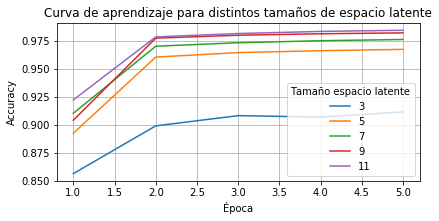

In [13]:

# summarize history for accuracy
#plt.plot([1,2,3,4,5],[0.8621,0.9048,0.9046,0.9091,0.9111])
fig = plt.figure(figsize=(6.5,3))
plt.gcf().subplots_adjust(bottom=0.15)
plt.plot([1,2,3,4,5],[0.8567,0.8993,0.9084,0.9071,0.9117])
plt.plot([1,2,3,4,5],[0.8927,0.9606,0.9646,0.9663,0.9675])
plt.plot([1,2,3,4,5],[0.9105,0.9703,0.9734,0.9752,0.9763])
plt.plot([1,2,3,4,5],[0.9043,0.9775,0.9801,0.9814,0.9822])
plt.plot([1,2,3,4,5],[0.9224,0.9786,0.9816,0.9835,0.9845])

plt.title('Curva de aprendizaje para distintos tamaños de espacio latente')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(['3','5','7','9','11'], loc='lower right', title='Tamaño espacio latente')
plt.grid()
plt.show()

fig.savefig("curva_aprendizaje.pdf",dpi=300)

In [92]:
import glob
files = [f for f in glob.glob("data/deep_atlas/*.bundles")]

ATLAS = []
ATLAS_labels = []
atlas_dict = defaultdict(list)
curr = 0
for i, file in enumerate(files):
    cluster = np.array(BT.read_bundle_severalbundles(file))[0][0]
    ATLAS.append(cluster)
    ATLAS_labels.append([i]*len(cluster))
    atlas_dict[i] = range(curr, curr + len(cluster))
    curr += len(cluster)
ATLAS = np.concatenate(ATLAS, axis=0)
ATLAS_labels = np.concatenate(ATLAS_labels, axis=0)

xmax, xmin = 150, -100
ATLAS = (ATLAS - xmin)/(xmax - xmin)
inverse_ATLAS = []
inverse_ATLAS_labels = []
for fiber, label in zip(ATLAS, ATLAS_labels):
    inverse_ATLAS.append(fiber[::-1])
    inverse_ATLAS_labels.append(label)
ATLAS = np.array([*ATLAS,*inverse_ATLAS])
ATLAS_labels = np.array([*ATLAS_labels,*inverse_ATLAS_labels])
#ATLAS = ATLAS.reshape((len(ATLAS),63))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ATLAS, ATLAS_labels, test_size=0.3, random_state=42)

data/deep_atlas/atlas_THAL_PAR_LEFT.bundlesdata
data/deep_atlas/atlas_AR_POST_RIGHT.bundlesdata
data/deep_atlas/atlas_IL_LEFT.bundlesdata
data/deep_atlas/atlas_IFO_LEFT.bundlesdata
data/deep_atlas/atlas_FORNIX_RIGHT.bundlesdata
data/deep_atlas/atlas_CST_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_OCC_RIGHT.bundlesdata
data/deep_atlas/atlas_CG_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_MOT_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_TEMP_RIGHT.bundlesdata
data/deep_atlas/atlas_CG_RIGHT.bundlesdata
data/deep_atlas/atlas_CG2_RIGHT.bundlesdata
data/deep_atlas/atlas_AR_RIGHT.bundlesdata
data/deep_atlas/atlas_UN_LEFT.bundlesdata
data/deep_atlas/atlas_AR_ANT_LEFT.bundlesdata
data/deep_atlas/atlas_THAL_OCC_LEFT.bundlesdata
data/deep_atlas/atlas_CST_RIGHT.bundlesdata
data/deep_atlas/atlas_CG3_LEFT.bundlesdata
data/deep_atlas/atlas_CG2_LEFT.bundlesdata
data/deep_atlas/atlas_CC_BODY.bundlesdata
data/deep_atlas/atlas_IFO_RIGHT.bundlesdata
data/deep_atlas/atlas_CG3_RIGHT.bundlesdata
data/deep_atla

In [102]:
display(ATLAS, atlas_dict, ids=range(36), color='tab20')

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [50]:
a = np.array(BT.read_bundle_severalbundles('data/synthetic_subjects/generated/0.bundles'))[0][0]

data/synthetic_subjects/generated/0.bundlesdata


In [51]:
len(a)

10744

In [396]:
display(a)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [392]:
np.array(a).min()

-87.923386

In [358]:
display([*a,*b])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### Synthetic generator autoencoder

In [215]:
from keras.layers import Reshape
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense
import keras

inputs = Input(shape=(21, 3))

encoder = Bidirectional(LSTM(128, return_sequences=True))(inputs)
encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder)
encoder = Bidirectional(LSTM(21, return_sequences=False))(encoder)
encoder = Dense(21)(encoder)
decoder = RepeatVector(21)(encoder)

decoder = Bidirectional(LSTM(64, return_sequences=True))(decoder)
decoder = Bidirectional(LSTM(128, return_sequences=True))(decoder)
decoder = Bidirectional(LSTM(3, return_sequences=True))(decoder)
decoder = Dense(3)(decoder)
sequence_encoder = Model(inputs, encoder)
sequence_autoencoder = Model(inputs, decoder)
sequence_autoencoder.summary()
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sequence_autoencoder.compile(optimizer=opt, loss='mse', metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 256)           135168    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 128)           164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 42)                25200     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                903       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 21, 21)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 21, 128)           44032     
__________

In [95]:
from keras.optimizers import Adam

In [96]:
opt = Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
sequence_autoencoder.compile(optimizer=opt, loss='mse', metrics=['acc'])

In [368]:
history2 = sequence_autoencoder.fit(X_train, X_train, epochs=10, batch_size=512, shuffle=True, validation_data=(X_test,X_test))

Train on 15510 samples, validate on 6648 samples
Epoch 1/10
15510/15510 [==============================] - 29s 2ms/step - loss: 5.9623e-05 - acc: 0.9784 - val_loss: 6.2737e-05 - val_acc: 0.9786
Epoch 2/10
15510/15510 [==============================] - 28s 2ms/step - loss: 6.0240e-05 - acc: 0.9782 - val_loss: 6.1321e-05 - val_acc: 0.9788
Epoch 3/10
15510/15510 [==============================] - 27s 2ms/step - loss: 6.0080e-05 - acc: 0.9784 - val_loss: 5.9369e-05 - val_acc: 0.9795
Epoch 4/10
15510/15510 [==============================] - 27s 2ms/step - loss: 5.8685e-05 - acc: 0.9787 - val_loss: 6.1514e-05 - val_acc: 0.9779
Epoch 5/10
15510/15510 [==============================] - 28s 2ms/step - loss: 5.8937e-05 - acc: 0.9786 - val_loss: 5.8017e-05 - val_acc: 0.9793
Epoch 6/10
15510/15510 [==============================] - 27s 2ms/step - loss: 5.7836e-05 - acc: 0.9788 - val_loss: 6.0549e-05 - val_acc: 0.9789
Epoch 7/10
15510/15510 [==============================] - 27s 2ms/step - loss: 5.

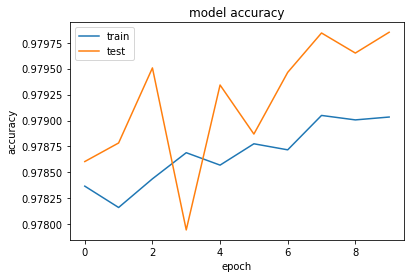

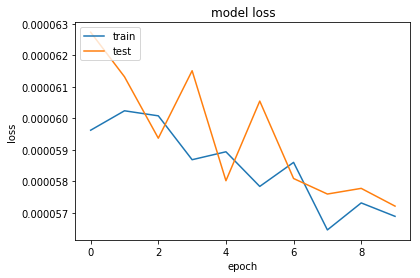

In [369]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_history(history2)

In [216]:
sequence_autoencoder.load_weights('checkpoints/autoencoder_atlas.h5')
sequence_encoder.load_weights('checkpoints/encoder_atlas.h5')

In [217]:
inputs = Input(shape=(21,))
#sequence_decoder = sequence_autoencoder.layers[4](inputs)
sequence_decoder = sequence_autoencoder.layers[5](inputs)
sequence_decoder = sequence_autoencoder.layers[6](sequence_decoder)
sequence_decoder = sequence_autoencoder.layers[7](sequence_decoder)
sequence_decoder = sequence_autoencoder.layers[8](sequence_decoder)
sequence_decoder = sequence_autoencoder.layers[9](sequence_decoder)
sequence_decoder = Model(inputs, sequence_decoder)
sequence_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 21)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 21, 21)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 21, 128)           44032     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 21, 256)           263168    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 21, 6)             6240      
_________________________________________________________________
dense_2 (Dense)              (None, 21, 3)             21        
Total params: 313,461
Trainable params: 313,461
Non-trainable params: 0
_________________________________________________________________


In [288]:
sequence_autoencoder.save_weights('checkpoints/autoencoder_atlas.h5')
sequence_encoder.save_weights('checkpoints/encoder_atlas.h5')
sequence_decoder.save_weights('checkpoints/decoder_atlas.h5')

In [222]:
len(ATLAS)

22158

#### Synthetic fibers

In [221]:
save_ = []
selected_list = [1,150,501,2850,4494]
for fiber_id in selected_list:
    latent = sequence_encoder.predict(ATLAS[fiber_id].reshape(1,21,3))
    for i in range(20):
        decoded = sequence_decoder.predict(latent + np.random.normal(0,0.02,21))
        save_.append(decoded.reshape(21,3))
aux_dict = defaultdict(list)
aux_dict[0] = range(len(save_))
aux_dict[1] = range(len(save_),len(save_)+5)
display([*save_, *ATLAS[selected_list]], aux_dict, ids=[0,1],hd=True, color='cool')

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Synthetic clusters

In [93]:
display(ATLAS)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [187]:
for cluster_id in range(30,35):
    save_ = []
    ix_ = np.where(ATLAS_labels == cluster_id)[0]
    save_.append(ATLAS[ix_])
    for i in range(3):
        size = int((len(ix_)/2) + np.random.normal(0,(len(ix_)/2)/10))
        selected_fibers = np.array(random.sample(list(ATLAS[ix_]), size))
        latent = sequence_encoder.predict(selected_fibers)
        latent += np.random.normal(0,0.025,21)
        decoded = sequence_decoder.predict(latent)
        save_.append(decoded+0.2*(i+1))
    aux_dict = defaultdict(list)
    aux_dict[1] = range(len(ix_))
    aux_dict[0] = range(len(ix_),len(np.concatenate(save_)))
    display(np.concatenate(save_), aux_dict, ids=[0,1],hd=True, color='cool')

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [49]:
len(ATLAS)

22158

In [ ]:
22158

#### Synthetic brains

In [371]:
save_ = []
subject_dict = defaultdict(list)
curr = 0
for i in range(36):
    ix_ = np.where(ATLAS_labels == i)[0]
    size = int((len(ix_)/2) + np.random.normal(0,(len(ix_)/2)/10))
    selected_fibers = np.array(random.sample(list(ATLAS[ix_]), size))
    latent = sequence_encoder.predict(selected_fibers) + np.random.normal(0,0.02,21)
    decoded = sequence_decoder.predict(latent)
    
    subject_dict[i] = range(curr, curr+size)
    curr += size
    save_.append(decoded)

In [372]:
display(np.concatenate(save_), subject_dict, ids=range(36))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [101]:
display(ATLAS, atlas_dict, ids=range(36), color='tab20')

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Save multiple synthetic brains

In [387]:
path = 'data/synthetic_subjects/generated/'
for n in range(20):
    save_ = []
    subject_dict = defaultdict(list)
    curr = 0
    for i in range(36):
        ix_ = np.where(ATLAS_labels == i)[0]
        size = int((len(ix_)/2) + np.random.normal(0,(len(ix_)/2)/10))
        selected_fibers = np.array(random.sample(list(ATLAS[ix_]), size))
        latent = sequence_encoder.predict(selected_fibers) + np.random.normal(0,0.02,21)
        decoded = sequence_decoder.predict(latent)

        subject_dict[i] = range(curr, curr+size)
        curr += size
        save_.append(decoded)
        

    BT.write_bundle(path+str(n)+'.bundles', np.concatenate(save_)*(xmax - xmin) + xmin)
    np.save(path+str(n)+'_dict', subject_dict)

In [394]:
np.concatenate(save_).shape

(11154, 21, 3)

In [2]:
res = [-1, 74, -1, 74, -1, -1, -1, -1, 74, -1, 74, -1, -1, -1, 74, 74, -1, 74, -1, -1, -1, -1, -1, -1, -1, 74, 74, -1, 42, -1, 11, -1, 45, 45, -1, 11, 42, 46, -1, 11, -1, -1, 45, 11, 45, 42, -1, 45, 45, 42, -1, 11, 11, 42, -1, 42, -1, 42, -1, -1, -1, 45, -1, 42, -1, -1, -1, -1, -1, 11, -1, -1, -1, 11, 11, -1, -1, 45, 11, -1, 11, 11, 46, 45, -1, 45, -1, 45, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 37, -1, 38, -1, 57, -1, -1, 37, -1, 39, -1, -1, -1, -1, -1, 38, -1, 40, -1, -1, -1, -1, -1, -1, -1, 38, -1, -1, -1, -1, 57, 58, -1, -1, -1, 37, -1, -1, -1, 39, -1, 38, 58, -1, -1, -1, -1, 40, -1, -1, -1, -1, 57, -1, -1, -1, -1, 81, 81, 81, 89, -1, 89, -1, -1, 88, -1, 88, 88, -1, -1, -1, 88, -1, -1, 89, -1, -1, 88, 89, 88, -1, 88, -1, -1, 88, 81, -1, 79, -1, 88, 89, -1, -1, 81, -1, 89, 88, 79, -1, 88, -1, 88, -1, 88, 88, 88, 79, 88, -1, -1, -1, -1, -1, -1, 3, 7, 3, 3, 7, 7, 7, 35, 36, 36, 36, 36, 36, 35, 35, 36, 35, 35, 36, 35, 35, 36, 36, 35, 36, 35, 36, -1, -1, 35, 36, 36, -1, 35, 36, 35, 35, -1, 35, 35, 35, -1, 35, -1, 35, 36, 35, 36, 35, 35, 36, 36, 36, -1, -1, -1, 36, 36, -1, 35, -1, 36, -1, -1, -1, -1, -1, 35, 35, 36, 36, 35, 35, 36, -1, 36, 36, 35, 36, 35, 36, 36, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, -1, -1, 95, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, -1, 95, 95, -1, -1, -1, -1, -1, 75, 75, 68, 74, -1, -1, -1, 74, -1, 68, 74, 68, -1, -1, -1, -1, -1, 75, 74, -1, -1, 68, -1, -1, 74, 74, 74, -1, 74, -1, -1, 74, -1, 74, -1, -1, 74, -1, -1, 74, -1, 75, -1, -1, 74, -1, -1, 74, -1, -1, 74, -1, 30, 30, 3, 3, 29, -1, -1, 3, 3, 30, 30, 30, -1, 29, 30, 3, -1, 3, 30, 3, -1, -1, 30, 30, 87, 87, 87, -1, 86, 87, -1, -1, 87, -1, -1, 87, -1, -1, 86, 87, -1, -1, -1, 87, 87, -1, 87, -1, 87, 87, 87, 87, 87, 87, -1, 86, 87, -1, 13, 13, -1, -1, 84, 13, -1, -1, -1, 84, -1, -1, 13, 84, 86, 13, 87, -1, 84, 13, 13, 85, 85, -1, 85, 85, -1, -1, -1, 85, -1, 85, -1, 87, 86, 84, -1, 87, -1, 13, 87, 65, 65, -1, -1, -1, -1, 66, -1, 65, -1, -1, 56, 65, -1, -1, -1, 65, -1, 66, -1, -1, -1, -1, -1, -1, 65, 56, -1, -1, -1, 56, -1, 56, -1, -1, 56, 56, 65, -1, 65, -1, 56, 65, -1, -1, -1, -1, 66, 65, 66, -1, -1, -1, -1, -1, -1, 66, 66, -1, 66, -1, -1, -1, -1, -1, 43, -1, -1, 44, 44, 43, -1, -1, 43, 43, -1, -1, 43, 44, -1, -1, 43, -1, -1, 44, -1, -1, 44, 44, 43, -1, -1, 43, 44, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, 44, -1, 44, -1, -1, -1, -1, -1, 44, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 16, 15, 15, 15, 16, 15, 15, -1, -1, 15, 16, 15, 15, 52, 47, 47, -1, 53, 52, -1, 53, 48, 52, 52, -1, -1, 48, 47, 48, -1, -1, 53, -1, -1, 53, 52, -1, -1, 47, 52, -1, 47, -1, 48, 48, -1, -1, 48, -1, 48, -1, 48, -1, 47, -1, -1, -1, 48, -1, 48, -1, -1, 47, -1, 47, -1, -1, -1, -1, -1, 53, 52, 48, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, 47, -1, 48, -1, 48, 47, 47, 47, 48, 48, 47, -1, -1, 48, 5, 5, 19, 5, 5, 5, -1, 5, 5, -1, -1, 5, 5, 5, 19, -1, -1, 5, -1, -1, 5, -1, -1, -1, -1, -1, 12, -1, -1, 12, -1, 90, 95, 12, -1, -1, 12, 12, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, 95, 12, -1, 80, 12, 94, -1, 90, -1, -1, -1, -1, -1, -1, -1, -1, 90, -1, 12, 80, -1, -1, -1, -1, 12, -1, 95, -1, -1, 90, 95, 93, -1, -1, 93, -1, -1, 12, -1, 93, -1, -1, -1, 95, -1, 17, 21, 9, 17, 23, 17, 14, 17, 23, 21, 17, 23, 22, 22, 17, 23, 91, 92, 82, 92, -1, -1, 91, -1, 91, 91, 92, 91, 92, 91, -1, 91, 78, 83, 92, -1, 83, 92, 91, -1, -1, 91, -1, -1, 91, -1, 92, -1, 92, -1, 91, -1, 91, 91, -1, 91, 91, 92, -1, 91, 91, -1, 82, 91, 83, 91, -1, 91, 91, 91, -1, 83, 91, 91, 82, 29, 2, 18, 18, 18, -1, 29, 18, 29, 29, 18, 3, -1, 2, 18, 2, 18, 18, 18, -1, 18, 18, 18, 18, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 41, 41, -1, -1, -1, 41, 60, -1, -1, 41, -1, 60, -1, -1, -1, 41, -1, -1, 41, 41, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 41, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 70, 1, -1, 70, 1, -1, -1, -1, 1, 70, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 70, 1, -1, 70, -1, 70, 67, -1, 70, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 71, 70, -1, 1, 1, 1, -1, -1, 59, -1, -1, 62, 62, -1, -1, -1, 62, 59, -1, 63, -1, -1, -1, -1, 63, 62, -1, 63, 59, -1, 62, -1, -1, 62, 62, 59, -1, 62, -1, -1, -1, -1, -1, 63, -1, 59, -1, -1, 62, 62, -1, 62, 62, 62, 62, 62, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, 59, -1, -1, -1, 20, 20, -1, -1, 19, 20, -1, -1, 20, 20, -1, -1, -1, -1, 20, 20, 77, 27, -1, -1, -1, 27, -1, 27, 27, -1, 27, 27, 27, -1, -1, 77, -1, -1, -1, -1, -1, 77, 77, -1, 27, -1, -1, 27, -1, -1, 24, 24, -1, -1, 24, 24, -1, 24, 24, 25, -1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, -1, 32, -1, -1, 32, -1, 32, 32, -1, 32, 32, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, 54, -1, -1, -1, 54, -1, 54, -1, -1, 55, -1, -1, 54, -1, -1, 49, 49, 49, 49, 49, -1, 49, 49, -1, 49, 49, -1, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, -1, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 50, 49, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, 72, 72, -1, -1, -1, 72, -1, -1, -1, -1, 72, -1, -1, 72, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 37, -1, 40, -1, -1, -1, 40, 39, -1, 39, -1, -1, -1, -1, 40, -1, -1, -1, -1, -1, 39, -1, -1, 39, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, 79, 64, -1, -1, -1, 79, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, 7, 7, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, 26, -1, -1, 26, 26, -1, -1, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, -1, -1, 26, -1, 26, 26, 26, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, 14, -1, -1, -1, 14, 14, 21, 14, -1, 14, -1, 9, -1, 14, -1, 21, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, 78, -1, -1, 78, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, 78, -1, 78, -1, -1, -1, -1, -1, 82, -1, 78, -1, -1, -1, 78, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 6, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, 25, -1, -1, 8, -1, -1, -1, 25, -1, 25, -1, -1, -1, -1, -1, 10, 4, 4, 4, 4, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, -1, -1, -1, 50, 49, -1, 49, -1, -1, 49, -1, -1, -1, 50, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 14, 14, -1, -1, -1, -1, -1, -1, -1, 14, -1, -1, 74, -1, -1, -1, -1, -1, -1, 74, -1, 74, -1, 74, -1, -1, -1, -1, 74, 74, -1, 74, 74, 74, -1, 74, -1, 74, -1, -1, 74, -1, 74, -1, -1, 11, 45, 11, -1, 42, -1, 45, -1, 45, 11, 42, 45, 11, -1, -1, 46, 11, -1, -1, 46, -1, -1, 45, 42, 11, 11, 11, 46, 42, 45, 46, -1, 11, 42, -1, -1, -1, 46, 45, -1, -1, 42, 45, 11, 45, 42, 11, 46, 11, 45, -1, 11, 45, -1, 11, 45, 46, 42, 46, -1, -1, 42, 42, 11, 11, -1, 45, -1, 11, -1, -1, 40, -1, 40, 37, -1, 57, -1, -1, -1, -1, 39, -1, -1, 58, 39, 37, 40, 58, 40, 57, -1, 40, 58, -1, 57, 40, -1, 40, 57, -1, -1, -1, -1, -1, 38, 57, -1, 57, 57, 39, -1, 37, 58, -1, -1, 57, -1, 57, 37, 38, 58, 58, 38, -1, -1, 57, 38, 89, 88, -1, 89, -1, -1, 88, 89, -1, 88, 89, -1, -1, 88, -1, 88, -1, -1, 88, -1, -1, 88, 79, -1, 88, -1, -1, 81, 88, -1, -1, 88, 88, 7, 7, 7, 7, 7, 7, 3, 7, 7, 3, 3, 35, 35, 36, 35, 36, 36, 35, 35, 36, 35, 36, 36, 36, -1, 36, -1, -1, -1, -1, 35, 35, -1, -1, -1, 36, -1, 35, 36, 35, 35, 36, -1, 35, 36, 36, 35, 35, 36, 35, 35, 36, 35, -1, -1, 35, 36, -1, 36, 36, 35, 36, 36, 35, 35, 35, 36, 35, 36, 36, -1, 36, 35, 36, 35, 36, 35, -1, -1, -1, 36, -1, 36, 36, 35, 35, 35, -1, 36, -1, 36, 36, 36, -1, -1, 35, 35, 36, 35, -1, 28, 28, 28, 28, 28, 28, 28, 28, -1, 28, 28, 28, 28, -1, 94, 95, -1, 95, -1, 95, 95, 95, -1, 95, -1, 95, 95, -1, 94, -1, 95, -1, 95, -1, -1, 95, 95, -1, -1, 95, -1, 94, -1, 95, 95, 95, 95, 95, 94, 74, 74, 68, 74, -1, 74, -1, -1, -1, -1, -1, -1, 75, -1, -1, -1, -1, -1, -1, 68, 74, -1, 74, -1, 74, 68, -1, -1, -1, 74, -1, 75, 74, -1, -1, -1, 75, -1, -1, -1, 74, 68, -1, -1, -1, -1, -1, -1, 30, 3, 30, 30, -1, 30, 29, 3, 30, 30, 30, 30, 30, -1, 3, -1, 30, 30, 30, 29, 30, 30, 30, 30, -1, -1, 87, -1, 87, 87, 87, 87, 87, 86, 87, 87, -1, 86, -1, -1, 87, -1, -1, 87, 87, -1, -1, 87, 87, 87, 87, 87, 86, 84, -1, -1, -1, 86, 84, 13, 85, -1, 13, 13, -1, 84, -1, 13, 87, -1, 13, -1, -1, 13, 13, 13, -1, 87, -1, 87, 87, 86, 85, 87, 84, 87, 87, 87, 87, 87, 85, -1, 87, 85, -1, 13, 84, 87, -1, 85, -1, 13, -1, -1, 87, 87, 13, 13, -1, 84, 87, 84, -1, -1, 56, -1, -1, 65, -1, -1, -1, 65, 66, -1, -1, -1, 66, -1, 66, -1, -1, 65, -1, 66, -1, -1, -1, -1, 66, -1, 56, -1, -1, 56, -1, -1, -1, 56, 66, -1, 65, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, 56, -1, 56, -1, 56, -1, -1, -1, -1, 56, 44, -1, 43, 44, 43, -1, -1, -1, 44, 43, 43, -1, -1, 43, -1, 44, -1, -1, -1, 43, 44, -1, 44, 43, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, 44, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, -1, 15, 15, 15, 15, 15, 16, 16, 15, 15, 16, 15, 16, 16, 15, 15, 15, -1, -1, 53, 47, 47, -1, -1, -1, -1, 48, 52, -1, -1, -1, -1, -1, -1, -1, -1, 53, -1, 53, 52, 48, 47, -1, 47, 53, 48, -1, 52, 52, -1, 48, -1, -1, -1, 53, 52, -1, 48, 47, -1, -1, 48, -1, 53, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, 48, 47, -1, -1, 47, 47, -1, 48, 52, 47, 52, -1, 48, -1, -1, -1, 52, -1, 53, -1, -1, -1, 53, 5, 5, 19, 19, 5, 5, 5, 19, -1, 5, -1, 5, 5, 19, 19, 5, -1, 5, 93, -1, 95, 95, -1, 93, -1, 95, -1, -1, -1, -1, 12, -1, -1, 93, 93, 94, -1, 12, -1, 90, -1, -1, 12, 93, -1, 95, -1, 95, -1, 12, 95, -1, -1, -1, -1, -1, 93, -1, 12, -1, -1, 90, -1, 90, -1, -1, 95, -1, 12, -1, -1, 94, -1, 93, -1, -1, 12, 94, 95, 95, 95, 12, 12, -1, -1, 93, -1, 90, -1, 14, 22, 23, 17, 22, 17, 21, -1, 17, 21, 23, 17, 91, -1, 91, 91, 91, -1, 91, 91, 92, 83, 91, 92, 91, 92, -1, 82, -1, 91, 78, 92, -1, 83, 91, -1, 91, 92, 91, -1, 83, 92, 82, 83, 91, 91, 91, -1, -1, 91, -1, -1, -1, 83, 91, 91, 83, 91, 82, 91, 92, 83, 92, -1, -1, 91, -1, 92, -1, 91, 92, -1, -1, 2, 2, 18, 18, 18, 29, 18, 18, 18, 18, 2, 18, 18, 18, 18, 18, 18, 18, 18, 18, 41, 41, -1, -1, -1, 41, -1, 60, -1, -1, -1, 60, 60, 51, 60, -1, -1, 60, 61, 51, -1, 60, 60, 41, -1, 41, -1, -1, -1, 41, 41, -1, -1, -1, 60, -1, 41, 41, -1, 61, -1, -1, 51, 41, 61, -1, 1, -1, -1, 1, -1, 1, -1, -1, 71, -1, -1, -1, -1, 1, 1, 67, -1, -1, -1, 1, 67, 71, -1, -1, -1, -1, -1, -1, -1, 71, 1, -1, -1, 1, 71, -1, -1, 70, -1, -1, 1, 1, 71, 71, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 67, -1, -1, -1, -1, -1, -1, -1, 1, 67, -1, -1, 1, 67, 67, 1, -1, 71, 1, 67, -1, 1, -1, 59, -1, 63, 62, 59, -1, 62, -1, 63, 59, 62, -1, -1, 59, -1, 63, 59, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, 62, 62, 62, 59, 62, 59, -1, 63, 62, -1, -1, -1, -1, 59, 62, -1, 62, 59, -1, -1, 62, 63, 62, 63, -1, 63, -1, -1, -1, 62, 63, 63, 62, 62, 62, 62, 62, -1, -1, -1, -1, 59, 20, 19, 20, -1, 20, -1, 20, 20, 20, 20, 20, -1, -1, -1, 20, -1, 20, 20, 20, 20, -1, -1, -1, 20, -1, 20, 20, 20, -1, 27, -1, -1, -1, -1, -1, 27, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 24, 24, 24, 25, -1, -1, 25, 24, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, 69, -1, -1, -1, 77, 76, 69, -1, -1, -1, 69, -1, -1, 77, -1, 76, -1, 69, -1, -1, -1, -1, 76, -1, -1, 69, -1, -1, -1, 69, -1, -1, 76, -1, -1, -1, -1, -1, -1, -1, -1, 76, -1, 69, 69, -1, 69, -1, -1, -1, -1, -1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, -1, 32, -1, -1, -1, -1, 32, 32, -1, 32, 32, 32, -1, -1, -1, 54, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, 54, -1, 54, -1, -1, -1, -1, 55, -1, -1, 54, -1, -1, 54, -1, -1, -1, -1, 54, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, -1, 49, -1, 49, 49, -1, 73, -1, -1, -1, 72, -1, 72, 72, -1, 73, -1, -1, -1, -1, -1, 72, 6, -1, -1, 73, -1, -1, 73, -1, 72, -1, -1, -1, 73, 69, 73, 73, 73, 73, 73, 73, 72, -1, 73, -1, -1, -1, 72, 72, 73, 72, 73, -1, -1, 73, -1, -1, -1, 73, 73, 72, -1, 72, 73, -1, 73, -1, -1, 73, -1, 73, 72, 73, 69, -1, -1, -1, 73, 72, 73, -1, -1, 73, -1, 73, -1, -1, 73, 72, -1, 73, 73, -1, 34, 33, 33, 33, 34, 34, 33, 34, 34, -1, 34, 33, 33, 34, 33, 33, -1, -1, -1, 37, -1, -1, 37, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 37, -1, 37, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, 88, -1, -1, -1, -1, 64, -1, -1, 79, -1, -1, -1, -1, 81, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, 81, -1, -1, -1, -1, 79, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, 81, -1, -1, 64, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, 64, -1, -1, -1, 81, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, 88, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, 28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, 56, -1, -1, -1, -1, -1, -1, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 80, -1, -1, -1, -1, 80, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, -1, 80, 80, 80, -1, 80, -1, 80, -1, -1, -1, -1, -1, 22, -1, 9, -1, -1, 14, 14, 22, 22, 22, 23, 21, 17, 23, 17, 23, 9, 21, -1, -1, -1, 9, 17, 22, 8, 9, -1, -1, -1, 22, 21, 21, -1, 14, -1, 21, 9, 21, 17, 23, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, 91, 92, -1, 78, -1, -1, 82, -1, -1, -1, -1, 92, -1, -1, 78, -1, -1, -1, 92, -1, -1, 92, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, 82, -1, -1, -1, -1, 92, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 8, -1, 25, -1, -1, -1, -1, -1, 10, 10, 10, 10, 10, 10, 10, -1, -1, -1, -1, -1, -1, 50, 49, 50, 49, -1, -1, 49, 49, -1, -1, -1, 50, -1, 49, -1, 50, 49, 50, 50, 49, 50, 49, 49, -1, -1, -1, -1, -1, -1, 14, -1, -1, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, -1, -1, -1, -1, 74, -1, 74, -1, 74, -1, -1, -1, -1, 11, 11, 11, -1, -1, -1, 11, -1, 11, 11, 46, -1, 45, -1, 11, -1, -1, -1, 11, 11, -1, -1, -1, -1, -1, -1, 11, 42, 11, 45, -1, -1, -1, -1, 11, 45, 46, -1, -1, -1, 11, 11, -1, -1, -1, -1, 11, 42, -1, 42, -1, -1, 11, -1, -1, -1, -1, 40, 57, -1, -1, -1, 58, 58, -1, -1, 57, -1, 57, 40, 57, -1, -1, 40, 58, 58, 57, 57, -1, -1, 40, -1, -1, 57, -1, 38, -1, -1, -1, 39, 39, -1, 37, -1, -1, 37, -1, -1, 57, -1, -1, 57, 39, 57, -1, -1, -1, -1, 39, -1, 37, 39, 37, -1, -1, 39, 37, 39, 58, 37, -1, 38, 39, -1, -1, 57, 89, 64, -1, -1, -1, 88, 88, -1, -1, -1, 81, -1, -1, -1, -1, 88, -1, 81, -1, 88, 88, -1, 88, -1, -1, -1, 79, -1, -1, 79, -1, 88, -1, -1, 88, -1, -1, 64, 88, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 35, 35, 35, 36, 35, 36, 36, 36, 35, 35, 36, 35, 35, 35, 35, 35, 35, 36, 35, 36, 35, 35, 35, 35, 35, 35, 36, 36, 35, 35, 35, 35, 36, 35, 35, 35, 35, 35, -1, 35, 35, 35, 35, -1, 36, 36, 36, 36, 36, 36, 35, 35, 36, 35, 36, 35, -1, 35, 35, 35, 36, 36, 36, 35, 36, 35, 35, 36, 36, 35, 36, 36, 36, 36, 35, 35, 35, 35, 36, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, -1, 35, 35, 36, 35, 35, 35, 36, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, -1, 95, -1, 95, 95, 95, -1, 95, 95, -1, 95, 95, -1, -1, 95, -1, -1, -1, -1, 95, -1, -1, 94, -1, 95, -1, -1, -1, 95, 95, 95, -1, 95, 95, 95, -1, -1, -1, 95, 95, 95, 95, -1, 74, 68, 68, 75, 74, 68, 74, 74, 74, 68, 75, 74, 75, 74, 74, 74, 75, 74, 68, 68, 74, 74, 68, 74, 68, 74, 74, -1, -1, 68, 75, 68, 74, 75, 75, 74, 68, 74, 74, 75, 74, 68, 74, -1, 74, 74, 68, -1, 74, 74, -1, 68, 74, 30, -1, -1, 29, 29, -1, -1, 3, 3, -1, 30, 30, 30, 29, -1, 87, 87, 87, 87, 87, 87, 87, 87, -1, -1, 86, 87, 87, 87, 87, 87, 87, 87, -1, 87, 87, 87, 87, 86, 86, 87, 87, 87, 86, 87, 87, 87, 87, 87, 87, 87, -1, 87, -1, 13, -1, 13, -1, -1, 13, 84, 85, -1, -1, 85, -1, -1, 84, -1, -1, -1, -1, -1, 84, 84, 84, 85, 13, 84, 13, 87, -1, 84, 13, -1, 13, -1, -1, 13, -1, -1, -1, 84, 85, 87, 84, -1, -1, 84, -1, -1, -1, 87, -1, 66, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, 66, -1, 65, -1, -1, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, 56, -1, 56, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, 43, -1, 44, -1, -1, 44, 44, -1, -1, 43, 43, -1, 44, -1, -1, -1, -1, 43, -1, -1, -1, -1, -1, -1, 44, -1, -1, -1, -1, 44, 44, -1, -1, -1, -1, 43, -1, -1, 44, -1, 43, -1, 44, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 16, 15, 15, 15, 15, 16, 16, 15, 15, 15, 16, 16, 15, 47, -1, -1, -1, 52, -1, 52, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, 48, -1, 52, -1, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, 47, -1, -1, -1, -1, 48, -1, -1, -1, -1, 47, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, 5, 5, 5, 19, 5, 19, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, -1, 5, 5, -1, 12, 90, 95, 12, 95, -1, 93, 93, 12, 94, 93, -1, 95, 93, 95, -1, -1, 95, 95, 94, -1, -1, -1, -1, 12, -1, -1, -1, 80, -1, 95, 93, -1, -1, -1, -1, -1, -1, 12, 95, 93, 93, 95, -1, 94, 95, 80, 93, 95, 94, 90, -1, -1, 93, 12, 90, -1, 95, 94, 93, -1, -1, 90, -1, -1, 95, 95, 95, -1, -1, 94, 17, 22, -1, 23, 17, 17, 21, 9, 21, 14, 17, 22, 9, 17, 33, 17, 17, 23, 92, 91, 91, 92, 92, 83, 83, -1, 83, -1, -1, 91, 83, 92, 91, -1, 91, 91, 91, 91, 92, -1, 91, -1, 91, -1, 92, 92, -1, -1, 91, -1, 92, 91, 91, 91, -1, 91, 91, 78, 91, -1, -1, 91, 92, 91, -1, 91, 92, -1, -1, 83, 91, -1, 92, -1, 91, 91, -1, 91, -1, 91, 91, -1, 18, 18, 2, 2, 3, 2, 2, 2, -1, -1, -1, -1, 2, 3, 18, 2, -1, 2, 2, 60, 41, -1, 60, -1, -1, -1, 41, 41, -1, 60, 41, 41, -1, -1, 51, -1, 61, 61, -1, 60, 41, -1, 60, 60, -1, 41, 61, 61, -1, 41, 61, 51, -1, 41, -1, -1, 41, 60, 60, -1, -1, -1, 61, 41, -1, 60, -1, -1, -1, 51, -1, -1, 60, 31, -1, 41, 60, 60, 41, 61, -1, -1, 31, 1, 67, 71, -1, 1, -1, 70, -1, -1, 70, 70, 67, 67, -1, 67, 71, 1, 67, 67, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 67, 70, 1, 1, -1, 1, 1, -1, 70, 70, -1, -1, -1, -1, 70, 1, 1, 1, -1, 1, 71, -1, -1, -1, 1, 70, -1, 1, 1, -1, 70, -1, -1, 1, 70, -1, 67, -1, -1, -1, 67, -1, -1, -1, 71, 70, -1, 70, -1, -1, -1, 67, -1, -1, 59, 59, 62, -1, 59, 63, -1, -1, -1, 63, -1, -1, 59, 62, 62, 59, -1, -1, -1, 62, -1, -1, -1, -1, 62, 59, -1, -1, -1, 62, 62, -1, -1, 63, 63, -1, 62, 62, 59, 62, 59, -1, 62, -1, -1, -1, 20, 20, 20, 20, 20, -1, 19, 19, 20, 20, -1, -1, 20, 20, -1, -1, -1, 27, -1, 27, 27, 27, -1, -1, -1, 77, -1, -1, -1, -1, 27, -1, 27, 27, 27, -1, -1, -1, 77, -1, 27, 27, -1, 24, -1, 24, -1, -1, 24, 25, 24, -1, 25, -1, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, 77, 76, 77, -1, -1, -1, 77, 69, 76, 69, 76, 76, -1, -1, -1, 69, 69, 76, 76, 76, -1, 69, 69, -1, 76, 76, 69, 76, -1, -1, 76, -1, 76, -1, 69, -1, 69, 69, 76, 76, 69, -1, 76, 69, -1, 76, 69, 76, 69, -1, -1, 69, -1, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 32, 32, 32, -1, 32, 32, 32, 32, 32, 32, -1, -1, 32, 32, -1, 54, 55, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, 55, -1, -1, -1, 54, -1, 55, -1, -1, -1, -1, 54, -1, -1, 54, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, 54, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, -1, 49, -1, -1, -1, 49, 49, -1, -1, 49, -1, -1, 49, 49, -1, -1, 49, 49, -1, 49, 49, 49, -1, 49, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, -1, -1, 73, 72, -1, 72, 73, -1, 73, -1, 73, 69, -1, 73, 72, -1, -1, 69, 72, 69, -1, 73, 72, 72, 72, 72, 73, -1, 72, 72, -1, 73, 73, 72, -1, 73, -1, 72, 69, -1, -1, 73, -1, 72, 73, -1, -1, 73, 72, 72, 69, 73, 72, 72, -1, 73, -1, 73, 73, 72, 73, -1, 72, -1, -1, 72, -1, 73, -1, -1, 72, -1, 72, 72, 73, 73, 73, 73, -1, 69, -1, 73, 69, 73, 72, -1, 33, 14, 34, 34, 34, -1, 33, 34, 33, 34, 33, 33, -1, 33, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, 3, -1, 29, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, 13, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, 56, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, -1, -1, 26, 26, 26, 26, 26, 26, -1, 26, 26, -1, 26, 26, 26, 26, 26, 26, -1, -1, 12, 12, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, -1, -1, 80, 80, 12, -1, 80, -1, 80, -1, 8, 14, -1, 21, -1, -1, 14, -1, -1, -1, 21, -1, 8, 9, -1, 21, -1, 14, -1, -1, -1, -1, -1, 14, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, 78, -1, 82, 92, 78, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, 82, -1, -1, -1, -1, 82, 92, 83, 82, 83, 83, 92, -1, -1, -1, -1, -1, 78, -1, 92, -1, -1, -1, 83, -1, 92, 83, -1, 83, -1, -1, -1, -1, -1, 91, 82, 78, 82, 78, 83, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, 78, 82, -1, 83, -1, -1, -1, -1, -1, 82, 83, 83, -1, -1, -1, 78, -1, 82, 82, -1, -1, 82, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, 6, -1, -1, -1, 67, -1, 6, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, 25, -1, 25, 8, -1, -1, -1, -1, 25, -1, 25, 25, 25, 25, 8, 25, 25, -1, 10, 10, 10, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 50, -1, -1, 50, 50, -1, -1, -1, 49, -1, -1, -1, 50, 50, 50, -1, 6, -1, -1, -1, 6, 6, -1, -1, -1, 74, -1, -1, -1, -1, 74, -1, -1, -1, -1, 74, -1, -1, -1, 74, -1, -1, -1, -1, 74, -1, -1, -1, 15, -1, -1, -1, 74, 74, -1, 74, -1, -1, -1, 11, 11, -1, -1, -1, 11, 11, 11, -1, -1, -1, -1, -1, -1, 11, 11, 11, 11, -1, -1, -1, 11, -1, -1, 11, -1, -1, -1, -1, -1, -1, -1, -1, 11, -1, 11, 11, 11, -1, -1, 11, -1, -1, 11, -1, -1, 11, 38, -1, 37, -1, 39, 58, 57, 38, 38, 37, -1, -1, 38, -1, -1, 38, -1, -1, 58, 57, -1, 58, 40, 39, 37, 37, 37, -1, 37, 37, -1, 39, -1, 57, 40, -1, 57, -1, 37, 58, -1, 57, -1, 38, 37, -1, -1, -1, -1, 57, 57, -1, -1, -1, 57, 57, 40, 38, -1, 38, -1, -1, -1, -1, -1, -1, 88, -1, -1, 88, 81, 88, 81, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 3, 7, 7, 7, 36, 35, 36, 36, 35, 35, 36, -1, 36, 35, 36, 35, 35, 36, 35, 35, 35, 36, 36, 35, -1, 35, 35, 36, 36, 36, 36, 35, 35, 35, 35, -1, -1, 36, -1, 35, -1, 36, 35, 35, 35, 35, -1, 36, 35, 35, 35, 36, 36, -1, 35, 35, 36, 36, 35, 36, 35, -1, 36, 36, 36, 36, 36, 36, -1, 36, -1, 36, 35, 35, 35, -1, -1, 35, 35, 35, -1, 36, 36, 35, 35, 36, 35, 35, -1, 35, 35, 35, 36, 36, 35, 35, 28, 28, 28, 28, 28, 28, 28, 28, -1, -1, -1, -1, 95, 95, -1, -1, -1, -1, -1, -1, 95, 95, -1, -1, 80, -1, 95, 95, -1, 94, -1, -1, 95, 95, -1, -1, -1, -1, -1, 95, -1, 95, 95, -1, -1, 75, 74, 74, -1, 68, 75, 68, -1, 74, 74, 74, 68, 75, 68, 74, -1, 74, -1, -1, -1, -1, 68, 68, -1, 74, 74, -1, 74, 74, -1, -1, 74, 74, 29, -1, -1, 3, 30, 30, 30, 3, 30, -1, 30, 30, 30, 30, -1, 30, 29, 30, 30, 30, 30, 87, 87, 87, 86, -1, 87, -1, -1, -1, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 86, -1, -1, 87, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, 85, -1, 13, -1, -1, -1, 13, 87, 13, -1, -1, -1, -1, 13, 86, 13, 85, 13, -1, -1, -1, 84, -1, -1, 84, -1, -1, 87, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, 85, -1, -1, 87, 13, -1, 13, 13, -1, -1, 56, -1, 56, -1, 65, -1, -1, -1, 56, 56, -1, -1, 66, -1, -1, -1, 65, -1, -1, -1, -1, -1, -1, -1, 65, 66, 56, -1, -1, -1, -1, 56, 66, -1, 66, -1, -1, -1, 56, 65, -1, 43, 44, -1, 43, -1, -1, -1, 43, -1, -1, 43, 44, -1, -1, -1, 43, -1, 44, -1, 43, 44, -1, 43, -1, -1, 43, -1, -1, 43, 43, -1, -1, 43, -1, 43, 43, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 16, 15, 15, 15, -1, 15, 16, 15, 16, 15, 15, 15, 15, -1, 53, -1, -1, 48, 48, 47, -1, -1, -1, -1, -1, 52, -1, 53, -1, 48, -1, -1, -1, -1, 52, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 53, -1, -1, 52, -1, 47, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, 5, 19, 5, 19, 19, 5, 5, 5, 5, 5, 19, 5, 5, 5, 19, 19, 5, 5, 5, 5, 95, 94, 94, -1, 12, 95, -1, 80, 95, 95, 90, -1, 12, -1, -1, 95, 95, -1, -1, -1, -1, -1, -1, 90, 95, -1, 12, -1, -1, -1, -1, 12, 93, -1, -1, -1, -1, 12, -1, -1, -1, 95, -1, -1, 80, -1, 95, -1, 93, 93, -1, -1, -1, 95, -1, 17, 17, 17, 22, 23, 23, 17, 9, 21, -1, 17, 23, 22, -1, 22, 17, -1, 91, 82, -1, -1, -1, 91, -1, 91, -1, 82, -1, 92, 91, -1, -1, -1, 91, -1, 91, 92, -1, -1, 91, 83, -1, 83, -1, 91, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, 91, -1, 91, -1, -1, 91, -1, -1, 92, 92, -1, 83, 83, 91, -1, -1, -1, -1, -1, 91, 91, 91, -1, 91, 91, -1, -1, 91, 91, -1, -1, -1, -1, 92, -1, -1, 92, -1, 18, 18, 29, 18, 18, 2, 18, 18, 29, 18, 29, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 29, -1, -1, 41, 61, -1, -1, 60, 60, 41, -1, -1, -1, 41, -1, 51, -1, -1, -1, 41, -1, 41, 41, -1, -1, 61, 61, -1, -1, 60, 60, -1, -1, 41, -1, 41, -1, 60, 61, -1, 61, -1, -1, -1, -1, -1, 71, -1, 1, 67, -1, -1, -1, -1, 1, -1, -1, 1, 71, 1, -1, -1, -1, 1, 1, -1, 71, -1, -1, -1, -1, -1, -1, 70, -1, -1, -1, 1, -1, 1, -1, 1, 71, 1, 70, 1, -1, 70, -1, -1, 70, 1, -1, -1, -1, -1, 70, 1, 70, 1, 1, 71, -1, -1, -1, -1, -1, 70, 70, 71, -1, -1, -1, -1, 63, -1, -1, -1, -1, 63, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, -1, -1, 62, -1, 63, 59, 59, -1, -1, -1, -1, -1, 62, -1, -1, 59, 59, 63, -1, -1, 59, 62, 63, -1, 20, 20, 20, 20, 20, -1, 20, 19, 19, 19, 20, 20, 20, -1, 19, 20, 19, -1, 27, 27, 27, 77, -1, -1, 27, -1, 77, -1, -1, 77, -1, 27, -1, -1, -1, -1, -1, 27, -1, 77, -1, 27, 24, 25, -1, 24, 24, 8, 25, -1, 24, 24, 24, 24, 24, 25, -1, -1, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, 76, -1, 76, -1, 76, 69, 76, 76, 69, -1, 76, 76, -1, -1, 76, 69, 69, 76, 76, 69, 69, 76, 77, 69, -1, 76, -1, 69, 69, 69, 69, 69, -1, -1, -1, 69, 76, 69, 77, 69, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, 32, 32, -1, 32, 32, 32, -1, 32, 32, 32, 32, 32, 32, -1, 32, 32, 32, 32, 32, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 49, 49, -1, 49, -1, 49, 49, 49, 49, 49, -1, -1, -1, -1, 49, 49, 49, 49, 49, 49, -1, 49, -1, 49, -1, 49, -1, 49, 49, 49, 49, -1, 49, -1, 49, -1, 49, -1, 49, -1, 49, -1, 49, 49, 49, 49, 49, -1, 49, -1, 49, 49, -1, 49, -1, 49, -1, -1, 72, -1, -1, -1, 73, 73, -1, 73, 73, -1, 72, -1, -1, -1, -1, -1, -1, 73, -1, -1, 72, -1, -1, -1, 72, -1, 73, 73, -1, 72, 72, -1, -1, -1, 72, -1, 72, 73, -1, -1, 73, -1, -1, 72, -1, -1, 73, -1, 72, -1, -1, 73, -1, -1, -1, 69, 72, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, -1, 73, 72, 72, -1, -1, 72, -1, 73, 72, -1, -1, -1, 34, 33, 33, -1, -1, -1, -1, -1, -1, 33, 34, 33, -1, 33, -1, -1, 33, -1, -1, -1, 40, -1, 40, -1, 39, -1, 39, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, 28, 28, 28, 28, 28, -1, 28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 87, -1, -1, -1, -1, -1, 56, -1, -1, 56, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, 26, -1, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, 12, 12, 12, -1, -1, -1, -1, -1, 14, -1, 9, -1, 14, -1, -1, 14, 14, 14, -1, -1, -1, 8, -1, -1, 14, -1, -1, 14, 14, 9, -1, -1, -1, -1, -1, -1, -1, 9, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, 78, 78, -1, 78, -1, -1, -1, -1, 78, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, 78, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, 78, 78, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 51, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, 31, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, 6, 6, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 10, -1, 10, -1, 10, 10, -1, 10, 10, 10, 10, 69, 4, 4, 4, -1, -1, -1, 50, 49, 49, 50, 49, -1, 49, -1, 49, -1, -1, -1, 49, -1, -1, -1, -1, -1, 6, 6, -1, 14, -1, -1, -1, -1, 14, -1, -1, -1, -1, 74, -1, -1, -1, 74, -1, 74, -1, -1, 74, 74, -1, 74, 74, 74, 74, 74, 74, -1, 74, -1, -1, -1, 74, -1, -1, 74, 45, 11, -1, 42, 45, -1, -1, 11, 42, -1, 42, 11, 11, -1, 46, 46, 11, 45, 46, -1, -1, 11, 46, 42, -1, -1, -1, 46, 11, 42, 45, 45, 46, 11, -1, 11, -1, 42, 45, 11, 11, 45, 46, 46, -1, -1, -1, -1, 11, -1, 45, 45, 46, -1, -1, -1, -1, 57, -1, -1, 40, -1, -1, -1, 38, -1, -1, -1, 38, -1, 37, 39, -1, -1, -1, -1, -1, -1, -1, 39, -1, -1, -1, 57, -1, -1, 58, -1, -1, -1, 37, -1, 40, -1, -1, 40, -1, 57, -1, 58, 58, -1, -1, 58, 37, -1, 38, 37, -1, -1, 38, 57, 57, -1, 37, -1, -1, -1, 40, 58, 57, -1, 40, -1, -1, 57, 37, 40, 58, -1, 88, -1, -1, -1, 81, 88, 88, 79, 79, 88, 88, 64, 89, -1, -1, 89, -1, 81, -1, 88, 79, -1, -1, -1, -1, -1, -1, -1, 81, 88, -1, -1, -1, -1, -1, 81, 88, -1, 88, 81, -1, 88, 88, 88, -1, -1, -1, -1, -1, 89, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 35, 35, 36, -1, 35, 36, -1, 36, 35, 35, -1, 35, 35, 35, 35, 36, -1, 36, 35, 35, -1, 36, 35, 36, 35, 36, 36, 35, 36, -1, 35, -1, 36, 36, 35, 36, -1, 36, 35, -1, 35, 35, 35, -1, 35, 35, -1, -1, -1, 35, -1, 35, 36, -1, -1, 35, 36, 35, 35, -1, 35, 35, 36, 35, 35, 36, -1, -1, -1, 35, 36, 36, 36, -1, 35, 36, 36, -1, 35, 36, -1, 35, 36, 36, -1, 35, -1, -1, 35, 28, 28, 28, 28, 28, 28, 28, 28, 28, -1, 28, 28, 27, 28, 28, 28, 28, 95, 95, -1, -1, -1, -1, -1, 95, 94, -1, 95, -1, 95, 95, -1, 95, 95, -1, 95, -1, -1, 95, 95, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, 74, 74, 75, 75, 74, 68, -1, 74, 68, 74, 74, 74, 75, 74, -1, -1, 74, 74, 74, -1, -1, -1, 75, 74, 68, 68, 74, 74, 74, 74, 74, 68, 74, 74, 74, 74, 74, 68, 74, -1, 68, 74, -1, 75, 68, 75, -1, 74, 68, 74, 75, 74, 68, 68, -1, -1, 75, 68, 68, -1, -1, 30, 30, 30, 3, 29, 30, 30, 3, -1, -1, 29, 3, 3, -1, -1, -1, -1, 87, 87, 87, 87, 87, 87, 87, 87, -1, -1, 86, 87, -1, 87, 87, 87, 87, -1, 87, -1, 87, 87, -1, -1, -1, -1, -1, 87, 87, 87, -1, 87, 87, 87, 87, -1, 87, -1, 87, 87, 86, -1, 13, -1, -1, -1, -1, 84, 85, 13, -1, 87, -1, 84, -1, -1, 13, -1, 87, -1, 84, 87, 86, 87, 87, 85, -1, 13, -1, 13, 13, 13, 13, 13, 87, 85, -1, 87, -1, 86, 84, -1, -1, -1, 13, -1, 85, 13, -1, 13, 85, -1, -1, 85, 85, -1, -1, 56, 66, -1, 66, 65, 65, -1, -1, -1, -1, -1, 66, -1, 65, -1, -1, -1, 65, -1, -1, 56, -1, -1, -1, 65, 65, -1, -1, 66, -1, 56, -1, -1, 56, -1, -1, 56, -1, -1, 66, 56, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, 43, -1, -1, -1, 43, 43, 44, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, -1, -1, -1, -1, -1, -1, -1, 44, 44, 44, -1, 43, 44, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, 15, 15, 15, 15, 16, 15, 15, 15, 15, -1, 15, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, 53, -1, -1, -1, 52, -1, 53, -1, 53, -1, 47, 52, -1, 48, -1, -1, -1, 47, -1, -1, 47, -1, -1, -1, 48, -1, 48, -1, -1, -1, -1, -1, -1, -1, 53, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, 52, -1, -1, -1, -1, 48, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, 48, 52, 48, -1, -1, 47, -1, -1, -1, -1, 53, -1, -1, 48, 5, 5, 19, 5, 5, 19, 5, 19, 5, 5, -1, 19, -1, -1, 5, -1, 19, 5, 5, 5, 5, 80, -1, 95, 95, 95, -1, -1, -1, -1, 12, 90, 80, 12, -1, -1, 90, -1, 12, 12, 93, 12, 93, -1, 90, 94, -1, -1, 12, -1, -1, 12, 93, -1, -1, 12, -1, -1, -1, 95, 93, -1, -1, 94, 93, -1, 95, 95, 93, -1, -1, -1, 93, 93, 95, 80, 93, 95, 93, 94, -1, 93, 12, 90, 95, -1, -1, 95, 95, 12, 94, -1, 80, -1, -1, 95, 17, 23, 17, 9, 22, 21, 22, 33, -1, 91, 82, 92, 92, -1, -1, 91, 91, 91, -1, 91, 91, 92, -1, 91, 91, 91, 83, 91, 82, 83, 91, -1, 82, 91, 83, -1, 92, 91, 91, 91, 83, 91, 91, 91, 91, -1, 91, 92, -1, 91, 91, 92, 82, 91, 78, 91, 91, 83, 91, 91, 91, 92, 91, 18, 18, 2, 18, 18, 18, 29, 18, 29, 18, 18, 18, 29, 18, 29, 18, 18, 18, 18, 60, 60, 60, -1, 41, -1, 41, 41, 61, -1, 60, -1, 61, -1, 61, 41, -1, -1, 60, -1, 41, 60, 60, -1, 41, -1, 61, 41, -1, 60, 61, -1, 61, 1, 1, -1, 70, 71, 71, -1, 71, 1, 1, 71, 67, -1, -1, 71, 1, 70, 67, 67, -1, 71, 1, 67, 1, 67, -1, 1, -1, 67, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 67, 1, 1, -1, -1, 70, 70, -1, 1, -1, -1, -1, -1, 70, 1, 67, 67, -1, 1, 1, 70, 1, 70, 71, 70, -1, -1, -1, -1, 63, 63, -1, 63, -1, 62, 62, 62, 63, -1, -1, -1, 62, 62, 62, -1, -1, -1, 62, 62, 59, -1, -1, 63, -1, -1, -1, 59, 59, 59, -1, 62, 62, -1, -1, 59, -1, 62, 59, 63, -1, -1, 62, -1, -1, 62, 62, -1, -1, 59, -1, 62, 59, 62, -1, 63, -1, -1, 59, 63, -1, 20, -1, -1, 19, 20, -1, -1, 20, 20, 20, 20, 20, -1, 20, 27, -1, 27, -1, 27, -1, -1, 77, 77, -1, -1, -1, -1, -1, -1, 27, -1, -1, -1, 77, 27, -1, -1, -1, 27, 27, -1, -1, 8, 24, -1, 8, 24, 24, -1, -1, 24, 8, -1, -1, -1, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, -1, -1, -1, -1, 77, 69, -1, 77, -1, -1, -1, 76, -1, -1, 69, 69, 76, 69, -1, 76, -1, 69, 69, 76, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 76, -1, -1, 69, 76, -1, -1, -1, 69, -1, -1, 69, 69, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, -1, -1, -1, -1, -1, -1, -1, 32, -1, -1, 32, 32, -1, 32, -1, 54, -1, -1, -1, -1, 55, -1, 55, 55, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, 55, -1, 54, -1, -1, 54, 55, -1, -1, -1, 54, -1, 55, -1, -1, 54, -1, -1, -1, 54, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, 54, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, -1, 73, -1, -1, 73, -1, -1, 73, 73, -1, -1, 73, 69, -1, -1, -1, -1, 72, -1, -1, 72, -1, -1, -1, 73, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, 73, -1, 73, -1, -1, -1, -1, 73, -1, 72, -1, -1, -1, -1, -1, -1, -1, 14, 33, 34, 34, 33, 33, 33, 33, -1, 33, 34, 33, 34, 33, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, 81, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, 56, -1, -1, -1, -1, -1, 56, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, -1, -1, 26, 26, -1, 16, 16, -1, 80, -1, 13, -1, -1, 80, 80, -1, -1, -1, -1, -1, -1, -1, 14, 21, 21, 21, -1, 21, 14, 14, -1, -1, 17, -1, 21, -1, 17, 14, 14, -1, -1, -1, 22, -1, 14, -1, -1, 22, -1, 21, -1, 23, -1, -1, 21, 22, 9, 21, 23, -1, 21, 21, 9, 21, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, 83, 78, -1, -1, 91, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, 82, -1, 92, 92, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, 82, 78, 92, -1, -1, -1, -1, 78, -1, -1, 92, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, 92, 78, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 51, 31, -1, 31, 31, -1, -1, 31, -1, -1, -1, 51, -1, 31, -1, 51, -1, -1, 31, -1, -1, 51, -1, -1, -1, 51, -1, -1, -1, -1, 51, -1, -1, 51, -1, -1, 51, -1, -1, 6, 6, -1, 6, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 25, 25, -1, -1, -1, -1, 24, -1, -1, 25, 25, 25, -1, -1, -1, 10, -1, -1, 49, -1, 49, -1, -1, -1, -1, -1, 50, -1, 49, 50, -1, -1, 50, -1, -1, -1, -1, 6, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, -1, 74, 74, 74, -1, -1, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, -1, -1, 74, 74, -1, 74, -1, 74, 11, -1, 11, -1, 11, -1, -1, -1, -1, -1, 45, -1, -1, -1, -1, -1, 11, 45, -1, -1, 11, 45, 11, -1, -1, 46, -1, 11, -1, -1, -1, -1, -1, -1, -1, 45, -1, 11, -1, 11, -1, -1, -1, 11, 11, -1, -1, 46, 11, -1, 11, -1, -1, -1, 11, -1, -1, 11, 11, -1, -1, -1, -1, -1, -1, 57, 37, -1, -1, -1, -1, -1, 37, 39, 40, 58, 57, -1, 38, 37, -1, 58, -1, -1, -1, -1, -1, -1, 58, 38, 37, -1, 38, -1, -1, -1, -1, -1, 39, 57, 38, 40, -1, -1, -1, 58, 58, -1, -1, -1, 57, -1, -1, 40, -1, 38, 57, -1, 37, 57, 58, 58, -1, 40, -1, 37, 37, -1, 40, -1, -1, -1, 57, 89, 88, -1, -1, 88, -1, 88, 89, 88, -1, 88, 88, 88, -1, 88, -1, -1, 81, -1, -1, -1, 88, 79, -1, -1, 89, -1, 88, -1, 88, 81, 88, 88, 88, 88, 88, 79, 88, -1, -1, 88, -1, 88, 88, -1, 89, 88, -1, 88, -1, -1, -1, 88, -1, -1, 89, 88, -1, 88, -1, 88, -1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 35, 35, 35, 35, 35, 36, 35, 36, 35, 35, 35, 36, 35, 36, 36, 36, 35, 35, 35, 35, 35, 35, 36, 35, 36, 35, 35, 36, 35, 35, -1, 35, 36, 35, 36, 35, 36, 35, 36, 36, 36, -1, 36, 35, 36, 36, 35, 35, -1, 35, 35, -1, 35, 36, 36, 36, 36, 35, 35, 36, 36, 36, 36, 36, 35, 36, -1, 35, 36, 35, 36, 35, -1, 35, 36, 35, 36, 35, -1, 36, -1, 35, 36, 28, 28, 28, 28, 28, 28, 28, -1, 28, 28, 28, 28, -1, 28, 28, 28, 28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, 74, 74, 74, 68, 74, 75, 74, 74, 75, -1, -1, 74, 75, 74, -1, 68, 74, 68, -1, 74, 68, 75, -1, -1, 74, -1, 74, 68, 74, 74, 74, 68, 74, 74, 68, -1, 74, -1, 68, 74, -1, 68, 68, -1, 74, 75, 30, 3, 30, 29, 30, 30, 29, 30, 30, 29, 30, 3, 30, 3, 30, 29, -1, 29, 3, 29, 87, 87, 87, 87, 87, 87, 87, -1, 86, 87, 86, 87, 87, -1, 87, 87, 87, -1, 87, 87, 86, -1, 87, 86, 87, 87, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, 85, -1, -1, -1, 87, 13, 87, 13, 85, 86, -1, -1, 13, 84, -1, 84, -1, 87, 85, 13, 84, -1, -1, 85, 87, -1, -1, 87, -1, -1, 84, -1, 13, -1, 85, -1, 85, 13, 13, -1, 86, -1, 13, 13, 87, 86, -1, 86, -1, -1, 13, 86, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, 44, -1, -1, -1, -1, 43, -1, 44, -1, -1, 44, 43, 43, 44, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, -1, -1, -1, 44, 43, -1, 44, -1, 44, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 16, 15, 15, 15, -1, 15, 15, 15, 15, 47, 48, -1, 52, 47, -1, 52, -1, 52, 53, 53, -1, -1, 48, 53, -1, -1, -1, -1, -1, 53, -1, -1, -1, 52, -1, 48, 48, 47, -1, 53, 47, 52, 48, 47, -1, -1, -1, -1, -1, 53, 48, -1, 47, 53, 48, -1, -1, 48, 47, 48, 47, -1, -1, -1, -1, 48, 47, -1, -1, 53, -1, 48, 48, -1, -1, -1, -1, -1, 48, -1, -1, 48, 52, 53, -1, -1, -1, 48, 48, 48, 53, -1, 52, -1, 5, -1, 5, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, 5, 5, 5, 5, 12, -1, -1, -1, 95, 95, -1, 12, 80, 95, -1, 95, 95, 95, 90, 12, -1, 93, 12, -1, -1, 12, -1, -1, -1, -1, 95, 90, -1, -1, 12, 93, 95, 95, 95, 93, -1, -1, -1, 95, -1, 95, 80, 12, -1, 95, 94, 12, -1, -1, -1, 93, -1, 95, -1, 90, 90, -1, -1, -1, -1, 90, 90, 12, -1, -1, 95, 95, 95, -1, 90, 94, -1, 93, 12, 93, 93, -1, -1, -1, -1, -1, 9, 22, 17, -1, 82, -1, 91, -1, 91, -1, -1, -1, -1, -1, -1, 91, 92, -1, 92, -1, -1, -1, -1, -1, -1, -1, 91, -1, 91, -1, 82, -1, 91, -1, -1, -1, -1, 91, 92, -1, -1, -1, -1, 91, 92, -1, 91, 91, 92, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, 91, 92, 91, 91, 83, -1, 91, -1, -1, -1, -1, -1, -1, -1, 91, 92, 83, -1, 83, 91, -1, -1, 91, 91, 91, -1, -1, 18, 29, 18, 2, 2, 18, 18, 18, 2, 29, 18, 18, 18, 18, 18, 18, 18, 2, 18, 41, -1, -1, 61, 60, -1, -1, -1, 41, -1, -1, -1, -1, -1, -1, -1, 60, -1, -1, -1, 60, -1, 60, 61, -1, -1, -1, -1, 60, -1, -1, 60, -1, -1, -1, 51, -1, -1, -1, -1, 41, 41, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 67, 1, -1, 70, -1, -1, 70, -1, -1, 71, -1, 6, 70, 67, 71, 1, 71, -1, -1, 71, 67, 71, 70, 1, -1, 70, 1, -1, -1, 70, 67, -1, 1, 71, -1, -1, 1, 70, 67, 71, 67, 70, -1, -1, 70, 1, -1, -1, -1, -1, 1, -1, 67, 70, -1, 67, 1, 1, -1, 67, 67, -1, -1, -1, 1, 1, 1, 67, -1, 1, 67, -1, 1, 1, -1, 70, -1, -1, -1, 71, -1, 67, -1, -1, -1, 59, 59, 59, 62, 63, 63, 62, 63, 63, 59, 59, -1, -1, -1, 59, 63, 59, 62, -1, 59, -1, 63, 59, 63, -1, 62, 62, 59, 59, 63, 62, -1, -1, 62, -1, 62, 62, 59, 59, 59, 59, 62, 63, 63, 62, -1, 59, 63, -1, -1, 59, 63, 62, -1, -1, -1, 63, 62, 62, -1, -1, -1, -1, -1, 20, 20, -1, 20, -1, 20, -1, -1, 20, -1, 20, -1, 20, 20, -1, 20, -1, -1, 27, 77, -1, 27, -1, -1, 77, 27, -1, -1, -1, -1, -1, -1, -1, 27, -1, -1, -1, 27, -1, -1, 27, 27, -1, -1, -1, -1, 27, 27, 27, -1, -1, 25, -1, 25, 8, 24, 24, 24, 24, -1, 25, 24, -1, -1, 24, 24, -1, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, 69, -1, -1, -1, 69, 69, 69, 76, -1, -1, 69, -1, 76, -1, -1, 69, -1, -1, 69, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, 69, 69, -1, 69, 69, 76, 69, 69, -1, -1, 76, 69, -1, 69, -1, -1, 76, -1, 69, 76, 69, -1, 69, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, -1, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, 32, 34, 32, 32, -1, 32, -1, 32, 32, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, 54, 54, -1, -1, -1, -1, -1, -1, 55, -1, -1, 54, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, 54, 55, 54, -1, 54, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, 49, 49, 49, 49, 49, 50, 49, -1, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, 49, 49, 49, -1, 73, 73, -1, -1, -1, 72, 72, 72, -1, 69, -1, 72, -1, 73, -1, -1, 72, 73, 69, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, 73, -1, -1, -1, -1, 73, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, 73, -1, -1, -1, -1, -1, 72, -1, 69, -1, 33, -1, 33, -1, -1, 34, -1, -1, -1, -1, -1, 33, 34, 34, 34, 34, 14, 34, 34, -1, 34, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, 40, -1, -1, -1, -1, 39, 39, -1, 81, 81, -1, -1, -1, -1, 64, -1, 81, -1, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, 81, -1, 81, -1, 64, -1, 81, 79, 81, -1, 81, 81, 89, 81, -1, -1, -1, 64, 81, 81, -1, -1, 81, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, 88, 81, -1, -1, 89, -1, 81, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, 81, -1, 81, -1, 64, 81, -1, -1, -1, 81, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, 81, -1, -1, 81, 64, -1, 81, -1, 81, -1, 81, 64, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, 81, -1, 64, -1, -1, -1, -1, 7, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 30, -1, -1, -1, -1, 30, 30, -1, -1, 3, 30, 29, -1, -1, 84, -1, -1, -1, -1, 84, -1, -1, -1, -1, 84, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, 84, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, -1, 26, -1, 26, -1, 26, 26, -1, -1, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, -1, 16, 16, 16, 16, 16, 16, 15, 16, 5, 5, -1, -1, -1, -1, -1, -1, 8, -1, 14, -1, -1, -1, 14, 22, 14, -1, -1, 17, 23, -1, 14, -1, 23, -1, 17, 23, 17, -1, 23, -1, 22, -1, -1, 14, -1, -1, -1, -1, 21, 17, 23, -1, 17, 9, -1, 14, 9, -1, -1, 14, -1, 17, -1, -1, -1, -1, 17, -1, -1, 21, 9, -1, -1, -1, 14, 17, -1, -1, 23, 23, -1, 23, -1, -1, -1, 14, -1, -1, 21, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, 78, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10, 10, 10, 10, 10, 10, 0, -1, -1, -1, -1, -1, 49, -1, 50, -1, 50, -1, -1, 50, -1, -1, 49, -1, 50, -1, -1, -1, -1, -1, 74, 74, 74, -1, 74, -1, 74, 74, -1, -1, 74, 74, -1, 74, -1, -1, -1, 74, 74, -1, -1, -1, 45, 42, 46, 42, 45, 11, -1, 46, 46, 45, -1, -1, 11, 45, 46, 42, 45, 45, 46, -1, 46, 45, 46, -1, -1, 45, -1, 46, -1, 45, 11, 11, 46, -1, 11, -1, 42, -1, 42, 42, 45, -1, 45, 42, 46, -1, 45, 42, 42, -1, 45, 11, 42, 45, -1, 45, 11, 45, -1, 11, 11, 45, -1, -1, -1, -1, 58, -1, -1, 58, -1, -1, -1, 38, 57, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 57, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 57, 37, -1, -1, -1, 57, -1, -1, -1, -1, -1, -1, -1, -1, -1, 40, -1, -1, -1, -1, 40, -1, -1, -1, -1, 58, -1, 88, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, 88, -1, -1, 88, -1, -1, 88, 88, -1, 88, -1, -1, 79, -1, 79, -1, -1, 89, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, 88, -1, 88, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, 88, 3, 7, 7, 7, 3, 7, 7, 7, 7, 36, 36, 35, -1, 36, 35, 36, 36, -1, 36, 36, 35, 35, 35, 35, 35, 35, -1, 36, 35, 35, 35, 36, 35, 35, 35, 36, 35, 35, 36, -1, -1, 36, 36, 35, 35, 35, 36, 35, 36, -1, 35, 36, 36, 36, 35, 35, 36, 35, 35, 36, 36, 36, 36, 36, -1, 35, 36, -1, -1, 36, 36, 35, 35, 36, 35, 36, 36, 36, 35, 36, 35, -1, 36, -1, 36, 35, 35, 36, 36, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, 95, -1, -1, -1, 95, -1, -1, 95, -1, 95, 95, 95, 95, -1, -1, 95, 95, 95, -1, 95, -1, 95, -1, 95, -1, -1, 95, -1, 95, -1, -1, -1, 75, -1, 75, 75, 68, 74, 68, 74, 74, 68, -1, 74, 75, -1, 75, 74, 74, 68, 75, 68, -1, 74, -1, 74, 74, -1, 74, 68, 74, -1, 74, 68, 68, -1, -1, 74, 74, 68, -1, -1, 74, -1, -1, -1, 75, -1, 74, 74, -1, 68, -1, -1, 75, -1, 68, 74, -1, -1, 74, -1, 3, 3, 30, 29, 29, 29, 30, 29, 3, 29, 30, 30, 3, 30, 30, 30, 29, 30, 87, 87, 87, 87, -1, -1, 87, 87, -1, -1, 87, 87, -1, 87, -1, -1, -1, 86, -1, -1, -1, -1, 87, -1, 87, -1, -1, 87, 87, 87, -1, -1, 13, 13, -1, -1, -1, 13, -1, -1, -1, -1, 87, -1, -1, -1, 87, -1, 87, 87, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, 86, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, 85, -1, -1, -1, 13, -1, -1, -1, -1, -1, 13, -1, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, 66, 66, -1, -1, -1, -1, -1, -1, -1, -1, -1, 65, -1, -1, -1, -1, -1, 65, -1, -1, -1, 56, -1, -1, -1, 66, -1, -1, -1, -1, -1, 66, 66, -1, 56, -1, -1, -1, 56, -1, 66, -1, 65, -1, 66, -1, -1, -1, -1, -1, -1, -1, 66, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, 43, -1, -1, 44, 44, 43, 44, -1, -1, -1, 44, -1, 43, -1, -1, -1, 44, 43, -1, -1, 43, 43, 43, 44, 43, -1, -1, 44, -1, -1, -1, -1, 44, 43, -1, 43, 44, 44, -1, -1, 43, 44, -1, -1, -1, 43, -1, -1, -1, -1, 44, 44, 44, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 15, 15, 15, 15, 16, 15, 15, 16, 15, 15, 16, 16, 15, 15, 15, 15, 15, -1, -1, -1, 53, 48, -1, -1, -1, -1, -1, -1, 52, -1, -1, -1, 48, 47, -1, -1, -1, -1, -1, -1, -1, 53, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 48, 48, -1, 48, -1, 52, -1, -1, 48, -1, 48, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, -1, -1, -1, -1, -1, 48, -1, -1, 5, -1, 5, 5, 19, -1, 5, 5, 5, 5, 5, 19, -1, 5, -1, 5, 5, 5, -1, 5, -1, 5, 5, 5, 5, -1, 19, -1, -1, -1, -1, 94, -1, 90, -1, -1, 12, 12, 93, -1, -1, 12, -1, 95, -1, -1, -1, 95, -1, -1, -1, 12, -1, -1, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, 94, -1, -1, -1, 90, 94, 95, -1, -1, -1, 95, -1, -1, 95, -1, 95, -1, 95, 93, -1, 95, -1, -1, 95, -1, -1, 95, -1, 95, -1, 93, 95, -1, 93, 94, -1, 12, 90, -1, -1, -1, 90, 12, -1, 90, 95, -1, 95, 12, -1, -1, -1, 21, 17, 17, 14, 17, 17, 9, 17, 23, 21, 22, 22, 17, 21, 22, 91, 92, 91, 91, 91, 91, 91, 91, -1, -1, -1, 92, 91, -1, 83, -1, -1, -1, 91, 82, -1, -1, -1, 82, -1, 91, -1, -1, 92, -1, 91, -1, 91, -1, -1, 91, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, 92, 91, 91, 92, 91, 91, -1, 91, 91, -1, 92, -1, 91, -1, -1, -1, -1, 91, -1, 2, 29, 18, 18, 2, 2, 18, 18, 18, 18, 2, 2, 2, 18, 2, 18, 18, 18, 18, 2, 29, -1, -1, -1, 61, -1, -1, -1, 60, 60, 31, 41, 41, 41, 60, 61, 61, -1, -1, 60, 41, 60, 31, 60, -1, 61, -1, 61, 41, 60, 41, 41, 60, -1, 60, 51, 41, -1, -1, -1, 41, -1, 60, 41, 41, 60, -1, 41, 60, 41, 41, 51, 41, -1, -1, 61, 51, 60, 41, 61, 61, -1, -1, -1, 51, -1, 41, 61, -1, -1, -1, -1, -1, 70, 70, 71, 70, -1, -1, 1, -1, -1, -1, -1, 1, -1, 67, -1, 67, -1, 1, -1, -1, -1, -1, -1, 67, -1, -1, -1, 1, 1, -1, -1, -1, 67, -1, -1, -1, -1, 71, -1, -1, -1, 71, 1, -1, -1, 1, 70, 71, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 71, 1, -1, 71, -1, -1, -1, -1, -1, -1, 63, 59, 59, 63, -1, -1, -1, -1, 63, 59, -1, 62, 59, 62, -1, -1, -1, -1, -1, -1, -1, -1, 62, -1, 59, -1, -1, -1, 59, -1, 63, -1, -1, 63, -1, -1, 62, 62, -1, 59, -1, -1, 62, 62, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, 62, -1, -1, -1, 63, -1, -1, 59, -1, -1, 62, -1, -1, -1, -1, -1, -1, -1, -1, 62, 20, -1, 19, 19, -1, -1, -1, 20, 19, 20, -1, 20, -1, -1, 20, -1, -1, 20, -1, -1, 20, -1, -1, 27, 27, 27, 27, -1, -1, -1, -1, -1, 77, 77, -1, -1, 27, -1, 27, -1, -1, 27, 77, 27, 27, 27, -1, -1, -1, 27, -1, -1, -1, 24, 25, 24, 8, -1, 8, 24, 24, 24, 25, -1, -1, -1, 25, 25, -1, -1, 24, -1, 24, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, 69, -1, 76, -1, 69, 76, 69, 69, -1, 69, -1, 76, 69, -1, -1, 77, 69, 69, -1, -1, -1, 69, 69, -1, 69, -1, -1, 76, 76, -1, 76, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 32, 32, -1, -1, -1, 32, -1, 32, -1, 32, -1, -1, 32, 32, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, 54, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, 55, -1, 55, 54, -1, -1, -1, -1, -1, 55, 50, 49, 49, 49, 49, 49, 49, 49, -1, -1, 49, -1, 49, 49, 49, 49, -1, -1, 49, -1, -1, 49, -1, -1, 49, -1, 49, 49, 49, 49, 49, 49, -1, 49, -1, -1, -1, 49, 49, -1, 49, 50, 49, 49, 49, 49, -1, 49, -1, 49, 49, 49, 49, 49, -1, 72, -1, -1, -1, -1, -1, -1, 72, -1, -1, 73, 72, -1, -1, -1, 73, -1, -1, -1, 73, -1, 73, -1, -1, -1, -1, 72, 73, 73, -1, -1, -1, -1, 72, -1, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, 73, -1, 72, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, 73, -1, 73, 72, -1, -1, -1, -1, -1, 72, -1, -1, -1, -1, 33, -1, -1, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, 81, 89, -1, -1, -1, -1, 81, -1, -1, 81, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, 64, 88, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, 3, 7, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, 56, 56, 56, 56, 26, 26, -1, 26, -1, 26, 26, 26, 26, 26, 26, 26, -1, -1, 26, -1, 26, 26, 26, 26, 26, -1, 26, -1, -1, -1, -1, 80, 12, -1, -1, -1, -1, -1, -1, 80, -1, 12, -1, -1, 12, -1, -1, -1, -1, -1, 80, -1, 80, -1, -1, -1, -1, -1, 80, 14, -1, 14, 14, 9, 17, 23, -1, 23, -1, 23, -1, 14, -1, 23, 23, 8, -1, 23, -1, 23, 33, 23, 14, 14, -1, 23, -1, 23, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, -1, 74, 74, 74, -1, -1, 74, 74, 74, 74, -1, 74, 74, -1, 11, -1, -1, 11, -1, 11, -1, 11, -1, -1, -1, 11, -1, 11, -1, 11, -1, 11, -1, 11, -1, -1, -1, -1, 11, 11, -1, -1, 11, 11, -1, -1, 11, 11, -1, -1, 11, 11, 11, -1, -1, -1, 11, -1, -1, -1, -1, -1, 11, -1, -1, -1, 11, 11, 11, -1, 11, -1, -1, -1, -1, -1, -1, -1, 38, -1, 38, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 37, 40, -1, 37, -1, -1, 37, -1, -1, 57, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, -1, -1, -1, 39, 37, -1, 39, -1, -1, 57, 88, 81, 88, -1, -1, -1, 88, -1, -1, 88, 88, 88, 88, 88, -1, -1, -1, 88, -1, -1, -1, 88, -1, -1, 88, 88, -1, 88, -1, -1, 88, -1, 79, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, 64, 88, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, 88, 88, 79, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 35, 35, 35, 35, 36, 36, 35, 36, 35, 35, 35, 35, 36, 36, 36, -1, 35, 35, 35, 36, 35, 36, 35, 36, 36, 36, 36, 36, 36, 36, 35, 35, 36, 36, 35, 36, 35, 35, 35, 36, 36, 36, 36, 36, 35, 35, 36, 36, 36, 35, 35, 35, 35, 35, 36, 36, 36, 35, 35, 36, 35, 36, 36, 35, 35, 35, 35, 36, 35, 35, 36, 35, 35, 35, 36, 35, 36, 36, 35, 28, 28, 28, 28, 28, -1, 28, -1, 28, 28, 28, 28, 28, 28, 28, 28, 95, 95, -1, 95, 94, 95, -1, -1, 95, 95, 95, 95, 95, -1, -1, -1, -1, 95, 95, -1, -1, 95, 95, 95, -1, -1, 95, 95, 95, 95, 95, -1, 95, 95, 75, 74, 74, 74, 74, -1, 68, 68, -1, -1, 75, 74, 74, 75, 68, 75, 74, -1, 68, -1, -1, -1, 68, 68, 74, 68, 68, 74, 75, 74, 68, -1, 74, 74, 75, 68, 74, 74, -1, 74, 74, 68, -1, 75, 74, -1, 30, 3, 30, 30, 3, 30, 29, 30, 29, -1, -1, 3, 30, 29, 30, 29, 29, 30, 30, -1, -1, -1, 29, -1, 87, 87, -1, -1, -1, 87, 87, -1, -1, -1, -1, 87, 87, -1, 87, -1, -1, 87, -1, -1, 87, -1, -1, 87, -1, -1, -1, -1, -1, 87, 87, 87, -1, 86, -1, -1, 84, -1, 13, -1, -1, -1, 84, 13, 84, 84, 13, -1, -1, -1, 87, 87, 85, -1, -1, 13, -1, -1, -1, 13, -1, 86, -1, 85, -1, 87, 87, 84, -1, 85, -1, -1, -1, 85, 13, -1, -1, -1, -1, -1, -1, 87, 66, -1, 56, -1, -1, -1, -1, 66, 65, -1, -1, -1, -1, -1, 65, -1, -1, -1, -1, -1, -1, 65, -1, -1, -1, 56, -1, 65, -1, -1, 56, -1, 65, -1, -1, -1, 56, -1, 66, -1, -1, 44, 44, -1, -1, -1, 43, -1, -1, 43, -1, -1, -1, 44, -1, -1, -1, -1, 44, -1, -1, 44, -1, -1, -1, 44, 44, -1, -1, -1, -1, 44, -1, -1, 43, -1, -1, 43, -1, -1, 44, -1, 43, 44, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 15, 15, 15, -1, 16, 15, 15, 15, 16, 15, 16, -1, 15, 15, 15, 15, 15, -1, 15, 15, 15, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, 5, 5, 5, 5, 19, 5, 5, 19, 19, -1, 5, 5, 5, 5, 19, 5, -1, -1, 5, 19, -1, 19, 5, -1, 12, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, 93, -1, -1, -1, -1, 12, 95, -1, 12, -1, 93, -1, -1, 12, -1, 12, -1, 93, -1, -1, 95, -1, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, -1, -1, 12, -1, -1, -1, 95, 95, -1, -1, 12, -1, -1, 12, 80, 12, 12, -1, -1, 21, 17, 22, 14, 9, 21, 17, 17, -1, 83, -1, 91, 92, 92, 92, 92, -1, -1, -1, -1, 91, 91, 91, -1, -1, -1, -1, 82, -1, 91, 82, -1, 92, -1, -1, 91, 91, 92, 91, 92, -1, -1, -1, 91, -1, -1, -1, 91, 18, 18, 18, 2, 29, 18, 18, 18, 2, 18, 18, 18, 3, -1, -1, 29, 18, 18, 18, 2, 18, 18, 18, 2, 60, -1, 51, 61, 61, 61, 41, 61, 60, 60, 60, 41, -1, 60, 51, -1, 41, 60, -1, 51, -1, 51, 41, 61, 61, 61, 60, 60, 51, 60, 41, 41, -1, -1, -1, 60, -1, 61, -1, 60, -1, 41, -1, 67, -1, 67, -1, 1, -1, 1, -1, 1, 70, -1, 70, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 70, -1, -1, -1, -1, 71, -1, -1, 67, -1, -1, 1, 67, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 59, 59, -1, 59, -1, -1, 59, -1, 62, -1, -1, -1, -1, 62, -1, 62, -1, -1, -1, -1, -1, -1, -1, -1, 62, 62, -1, 62, 62, 62, 63, -1, -1, -1, 59, 63, 62, -1, 62, -1, -1, -1, 63, -1, 62, 62, -1, 62, -1, -1, -1, 59, 62, -1, 59, -1, -1, -1, 20, 20, -1, 20, -1, -1, 19, 20, 20, 20, -1, -1, -1, 20, 20, 20, 19, 19, -1, -1, -1, -1, 27, -1, -1, -1, 77, -1, -1, -1, 27, 27, 27, -1, 27, 27, 27, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 27, -1, 24, 24, -1, 25, 24, 24, -1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, 69, -1, -1, -1, -1, 76, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 32, -1, 32, 32, 32, 32, 32, 32, -1, 32, -1, -1, -1, 32, 54, -1, -1, -1, -1, 54, -1, -1, 55, -1, -1, -1, -1, 55, -1, 54, -1, -1, -1, 54, -1, -1, 54, -1, 55, 54, -1, 55, -1, -1, 54, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, 55, -1, -1, -1, 54, 54, -1, 55, -1, -1, -1, -1, -1, 49, 49, -1, 49, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 73, 73, -1, -1, -1, -1, -1, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, 72, -1, -1, 34, 34, -1, 33, 33, 33, 33, -1, 33, -1, 33, -1, -1, -1, -1, 33, 34, -1, -1, -1, -1, 38, -1, -1, 38, -1, -1, -1, -1, -1, -1, -1, -1, 39, 81, 81, -1, 81, -1, -1, -1, 81, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, 81, -1, -1, -1, 81, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, 81, -1, -1, 81, -1, -1, -1, 81, -1, 81, -1, -1, -1, -1, -1, -1, 30, -1, -1, 30, 30, 30, 29, -1, -1, -1, 3, 30, -1, 30, -1, -1, -1, -1, -1, 87, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, 13, 56, -1, 56, -1, 56, -1, -1, -1, 56, 56, -1, -1, 56, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 22, -1, -1, 23, 23, 22, 14, -1, -1, -1, -1, -1, 23, 22, 14, 21, -1, 9, 21, 21, 23, 8, 17, 23, 21, 23, 14, 23, 14, 23, 21, -1, -1, 22, 14, 17, 23, 23, 14, -1, 23, 9, 8, 23, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, 91, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, 83, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, 92, 91, 91, 83, -1, -1, 78, 83, -1, 83, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, 83, -1, -1, -1, 91, -1, -1, 83, -1, 83, -1, -1, -1, -1, -1, -1, 91, 83, -1, -1, -1, 91, 83, -1, -1, 83, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, 31, -1, -1, -1, -1, 31, 31, -1, -1, -1, -1, 31, -1, -1, 6, 6, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, -1, -1, 59, -1, 59, -1, -1, -1, 8, 25, -1, -1, 25, 8, -1, -1, -1, -1, 8, -1, 10, -1, 10, -1, -1, -1, -1, -1, -1, 50, -1, -1, -1, 49, 50, -1, -1, 49, -1, -1, 49, 49, -1, 50, -1, -1, -1, -1, -1, 49, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, -1, -1, -1, 74, -1, -1, -1, 74, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, 74, 74, -1, -1, 46, -1, -1, -1, 11, 42, -1, 42, -1, 11, -1, -1, -1, -1, 11, 11, -1, 45, 45, 46, -1, 45, -1, 11, 45, 45, 46, 11, 46, -1, 11, 46, 46, -1, 11, -1, -1, 45, 11, -1, 11, 11, 46, -1, 11, 11, -1, 45, 11, -1, 11, 11, 45, 45, 38, -1, 58, 37, 58, 37, -1, 38, 58, -1, -1, -1, 39, -1, -1, 37, -1, -1, -1, -1, 58, 57, -1, -1, -1, -1, -1, 57, -1, 38, 57, 40, -1, 58, 58, -1, 58, 40, 57, -1, -1, 40, 39, 37, -1, 40, 37, -1, 57, -1, -1, 57, 37, 37, -1, 88, -1, -1, -1, -1, -1, 81, -1, -1, -1, 88, -1, 88, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, 88, -1, -1, -1, 7, 7, 3, 7, 7, 7, 7, 3, 36, 35, 35, -1, -1, -1, -1, -1, 36, 36, 35, 35, -1, -1, 35, 36, 35, -1, 35, 35, 35, 35, 36, 36, 36, 35, 36, 35, -1, 36, 35, 36, 36, 36, 35, 36, 35, -1, 35, 36, 36, 35, 36, -1, 35, 36, -1, 35, 36, 35, 35, 36, 35, 36, 36, -1, 35, -1, -1, 35, 35, 35, -1, 35, 35, 35, 35, 36, 35, -1, 36, -1, 35, -1, 36, 35, 36, 35, 35, 36, -1, -1, 35, 36, 35, 36, 35, -1, 36, 35, -1, 36, 28, 28, 28, -1, -1, 28, 28, 28, -1, 28, -1, 95, -1, 95, -1, 94, -1, -1, -1, -1, -1, 95, 95, 95, 95, 94, 95, -1, -1, -1, 95, 95, 95, 95, -1, -1, -1, 95, -1, -1, 95, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 68, 75, -1, -1, 74, -1, -1, -1, 74, -1, 68, 75, -1, 74, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, -1, 74, -1, 75, -1, -1, 68, 74, 74, -1, -1, 74, 68, -1, 74, 74, -1, 74, -1, -1, -1, 74, 68, 68, 74, -1, 75, 3, -1, -1, 30, -1, 3, 3, -1, -1, -1, 3, -1, -1, 30, 29, 3, 29, -1, 3, -1, -1, 30, -1, 29, -1, -1, -1, 29, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 87, -1, -1, 87, 87, 86, 87, -1, 87, 87, -1, 87, 87, 87, -1, 87, 87, -1, 87, 86, 87, 87, -1, -1, 13, 87, 85, -1, -1, 87, -1, -1, 13, -1, 13, 84, 87, 84, -1, 84, -1, 85, 85, 86, -1, 87, 87, -1, -1, 84, -1, -1, 87, 84, -1, -1, 87, 87, -1, -1, 84, -1, 13, 84, 85, -1, -1, 87, -1, 85, -1, 84, -1, -1, 84, 86, -1, -1, 84, -1, -1, 85, -1, -1, 85, 13, -1, 87, -1, 13, 13, 13, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, 43, -1, 43, -1, 43, 43, -1, -1, 43, 44, -1, 43, 44, -1, -1, -1, -1, 44, 43, -1, -1, -1, -1, -1, 43, -1, -1, 44, -1, 44, -1, -1, 44, -1, -1, -1, -1, 44, 43, -1, -1, 43, -1, -1, -1, -1, -1, 43, 44, -1, -1, -1, -1, -1, 44, -1, -1, -1, 44, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, -1, 15, 15, 16, 15, 16, -1, -1, 15, 15, -1, -1, 15, 15, 16, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 53, -1, 52, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, 47, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, 52, -1, -1, -1, -1, -1, -1, -1, 53, 48, -1, -1, 47, -1, 47, -1, -1, -1, 47, -1, -1, -1, -1, 48, -1, 47, 53, -1, -1, 48, 53, -1, 47, 48, -1, 48, -1, 52, -1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 19, 5, 19, 5, -1, 5, -1, 5, -1, -1, 5, 5, -1, -1, -1, -1, 93, -1, -1, 95, -1, 12, -1, -1, -1, 95, -1, -1, -1, -1, 12, 94, 12, 12, -1, 12, -1, -1, -1, -1, 12, -1, -1, -1, 12, -1, 95, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, 12, 12, -1, 90, -1, -1, -1, -1, -1, -1, 12, 12, -1, -1, 90, 12, 12, -1, 17, -1, 23, -1, 17, 17, 17, 22, 23, 23, 17, 22, 17, 17, -1, 21, -1, -1, 33, -1, 92, 91, 91, 91, 91, -1, 82, -1, 92, 91, 92, 92, -1, 92, 92, 83, 83, -1, 83, 91, 92, 92, -1, -1, 83, 91, 92, 92, 83, 91, -1, 83, 91, -1, -1, -1, 92, 91, 92, 91, 92, 92, 83, -1, -1, 83, -1, 82, 91, 92, 91, 91, 91, 92, -1, 82, 92, -1, -1, 91, 92, 18, 18, 18, 2, 18, 2, 18, 18, 18, 18, 18, 18, 18, 2, 18, 2, 18, 18, 18, 29, 18, 18, 18, 18, 18, -1, -1, -1, -1, -1, -1, -1, 60, -1, 51, 41, 61, 60, 41, 61, 61, -1, -1, 41, -1, 41, -1, 61, 60, -1, 61, 60, -1, 41, 60, 61, 60, 60, -1, 60, 41, -1, -1, 60, 41, 31, -1, -1, -1, 60, 41, 60, -1, 41, 41, -1, -1, -1, 60, 61, -1, 67, -1, 1, 71, -1, 71, 71, 71, -1, -1, 67, 70, -1, 67, -1, -1, 1, 1, 70, 1, 1, 70, 68, 1, 71, -1, 1, 67, -1, -1, -1, 1, 67, 1, -1, 70, -1, 70, -1, -1, -1, 1, 67, 1, -1, -1, 70, -1, -1, 67, -1, -1, -1, 71, -1, 1, 71, 1, 1, 67, 1, -1, -1, -1, 67, -1, -1, 70, 1, -1, 71, -1, 63, 62, 62, -1, -1, -1, -1, -1, -1, -1, 59, -1, 62, 62, 63, -1, -1, -1, -1, 62, -1, -1, -1, 62, 62, -1, -1, 62, 59, 62, 59, -1, -1, 62, 62, -1, 62, -1, 62, -1, 59, 63, -1, -1, -1, 63, 62, -1, 62, -1, -1, 63, -1, 62, -1, 20, 20, -1, 20, 20, 20, 19, 20, 20, -1, 20, 20, 20, 19, 20, 20, 20, 19, 20, -1, -1, -1, -1, -1, -1, 76, -1, 77, -1, 27, -1, -1, 27, 27, -1, -1, 27, -1, -1, 27, 77, -1, -1, -1, 27, -1, -1, -1, 77, -1, 24, -1, 24, 24, 24, 25, -1, -1, 24, 24, 25, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, 69, 76, 69, -1, 76, 69, 76, 69, -1, 69, 76, 76, 69, 69, -1, 77, 69, 69, 76, 69, 77, -1, 76, 69, 76, 77, 69, -1, 76, -1, -1, 76, 76, 69, 76, 69, 69, 76, 69, -1, 69, 76, 69, 69, 76, -1, 69, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, -1, 32, 32, -1, 32, 32, 32, -1, -1, -1, 32, -1, 32, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, 54, -1, 55, 54, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, 55, -1, 55, -1, -1, -1, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, -1, -1, 49, -1, -1, 49, 49, 49, 49, -1, 49, -1, -1, -1, 49, -1, 49, -1, -1, 49, 49, -1, -1, -1, 49, 49, 49, 49, 49, 49, 49, -1, -1, -1, 49, -1, -1, -1, -1, 73, -1, 72, -1, -1, -1, -1, 72, -1, 73, 72, 73, 72, -1, -1, 72, 73, -1, -1, -1, -1, 72, -1, 73, -1, 73, -1, -1, -1, -1, -1, 72, 72, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 73, -1, 73, -1, -1, -1, -1, -1, 72, -1, -1, -1, 72, 34, 33, 34, 33, -1, 33, 33, 34, 34, 33, 34, -1, -1, 33, 34, 34, 33, -1, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 38, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, 81, -1, -1, -1, -1, -1, 64, -1, 81, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, 64, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, 88, -1, -1, 64, 81, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, 56, 56, -1, -1, 56, -1, 56, -1, 56, 56, 56, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, 56, -1, 56, -1, -1, -1, -1, -1, -1, -1, 26, 26, 26, 26, 26, 26, -1, 26, -1, 26, 26, 26, 26, 26, -1, 80, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 14, 14, 9, -1, 9, 21, 21, 23, -1, 21, -1, 21, 14, 21, 21, 21, -1, -1, 14, 14, 21, 9, -1, 21, 21, 14, -1, 14, 21, 14, -1, 21, 14, 9, -1, -1, 21, 14, 23, 14, -1, -1, 9, 21, 21, -1, 9, 21, 14, 82, -1, -1, -1, -1, -1, 78, -1, -1, 92, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, 82, 78, 78, -1, -1, -1, -1, -1, -1, -1, 82, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, 82, 92, -1, -1, -1, -1, -1, -1, 51, -1, -1, -1, -1, 51, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 67, -1, 6, 6, -1, 67, -1, -1, 6, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 59, -1, -1, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, -1, -1, -1, -1, -1, 8, 8, -1, -1, 10, 10, 4, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, -1, 49, -1, -1, 50, -1, 50, 49, -1, 50, 50, -1, 49, -1, -1, -1, 49, -1, -1, 50, -1, -1, -1, 50, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, 74, -1, -1, -1, 74, 74, -1, -1, 74, 74, 74, -1, 74, -1, 74, -1, -1, -1, -1, 74, -1, 74, -1, 74, -1, -1, -1, 74, 74, 74, 74, 11, 11, 11, 45, 45, -1, 11, 42, 46, -1, 45, 46, -1, 42, -1, 46, 45, -1, -1, 46, 46, -1, 45, -1, -1, -1, -1, 42, -1, 11, 11, 42, -1, 42, -1, 42, -1, 45, 11, 45, -1, -1, 11, -1, 11, -1, 11, -1, -1, 11, 11, 11, 40, 38, 58, 58, 38, 58, 57, -1, -1, -1, 40, -1, 40, 37, 37, -1, 58, -1, 37, -1, 39, -1, 40, -1, -1, -1, -1, 58, -1, 39, 38, 40, -1, -1, 37, -1, 38, 58, 38, 58, -1, 58, 39, 57, -1, 40, 40, 57, 57, -1, -1, 57, 38, -1, 39, -1, 58, -1, 37, -1, 57, 58, 40, 40, 37, 58, -1, -1, -1, -1, 88, 79, 88, -1, 89, -1, 89, 88, 88, 81, -1, -1, 88, 88, 81, -1, 88, 88, -1, 88, 88, 88, 88, 88, -1, 88, 89, 88, 64, -1, 88, -1, 88, -1, 89, -1, 81, -1, 64, 88, -1, -1, 88, 88, 88, 88, 88, 88, -1, -1, -1, 81, 88, -1, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 35, 35, 36, 36, 35, 35, 36, 35, 36, -1, 35, 36, 36, 36, -1, 35, 36, 36, 36, 36, -1, 35, 36, 35, 35, -1, 35, 35, 36, 36, 36, 35, 35, 35, 36, 36, 36, 36, -1, 36, 35, 35, -1, 35, 36, 35, 35, 35, 35, 36, 35, 35, 36, 35, -1, 35, 36, 36, 36, 35, 35, 35, 36, 35, 35, 35, 36, -1, 35, 35, 28, 28, -1, -1, -1, 28, 28, -1, 27, 28, -1, 28, -1, 28, 28, 28, 95, 95, 95, -1, 95, 95, 95, 95, 95, -1, 95, -1, 95, 95, -1, -1, 95, 95, 95, -1, 95, 95, -1, 95, 94, 95, 95, 94, 95, 95, 94, 95, -1, 94, 95, 95, 74, 74, 68, -1, 74, -1, -1, 68, 68, -1, -1, 75, -1, -1, 74, -1, -1, 74, -1, 74, 74, -1, 74, -1, -1, 74, 68, -1, 74, -1, -1, 74, -1, -1, 74, 74, 74, 74, -1, -1, 68, -1, 74, 74, -1, -1, 68, 74, 74, 74, 68, 68, -1, -1, 29, -1, -1, -1, -1, -1, -1, 29, 3, 30, 30, -1, -1, -1, -1, 30, 30, 3, 30, 3, -1, -1, -1, -1, -1, 87, 87, 86, -1, 87, 87, 87, 86, 87, -1, 87, 87, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 87, 87, 87, 87, -1, 84, 84, 84, 85, 13, 85, -1, -1, 87, 84, 13, -1, 85, 13, 13, -1, 13, 84, 87, 84, -1, 87, -1, -1, -1, 84, 85, 85, 87, 87, 84, -1, 85, 84, -1, 84, -1, -1, -1, -1, -1, 85, -1, -1, -1, 85, -1, -1, 86, -1, 84, -1, -1, -1, 84, -1, 87, 13, -1, 87, 13, 87, 13, -1, -1, 87, 85, 85, 84, 13, -1, 87, -1, 56, 66, 56, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, 56, 65, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, 56, 66, 65, -1, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, 65, -1, -1, -1, -1, 66, -1, 44, 43, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, -1, -1, -1, -1, 44, -1, -1, -1, 44, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, -1, 44, -1, -1, -1, -1, -1, -1, 44, -1, -1, -1, -1, -1, -1, -1, 44, -1, 43, 44, -1, -1, -1, -1, -1, -1, 44, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, -1, -1, 15, 16, 15, 15, 16, 15, 15, 15, 15, 15, 15, 15, 15, -1, 15, 15, -1, -1, 53, -1, -1, 47, -1, 53, -1, 53, -1, 52, 53, 47, -1, 52, 48, -1, 48, -1, -1, 52, 53, 53, -1, 47, 52, 53, 53, -1, -1, 52, 52, 52, 47, -1, 48, -1, 47, 53, -1, 52, 53, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, -1, -1, -1, -1, 53, -1, 52, 47, 53, -1, -1, 47, -1, -1, -1, 53, 48, -1, -1, -1, -1, -1, -1, -1, -1, 48, 48, 47, 52, -1, 53, 48, 47, 52, 48, -1, -1, 47, -1, 5, 5, 5, 5, 5, 5, 5, -1, 5, 5, -1, 19, 5, 19, 5, -1, 5, 19, -1, -1, -1, -1, -1, -1, -1, -1, 12, 95, 95, -1, 95, 95, -1, -1, 95, -1, 93, -1, -1, 93, -1, 12, -1, -1, -1, 12, -1, -1, -1, 95, -1, 80, 12, -1, 93, 95, -1, -1, -1, -1, 12, 90, 90, -1, -1, -1, -1, -1, -1, 80, -1, -1, 12, -1, -1, -1, -1, -1, 90, 94, -1, -1, 12, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 93, -1, 22, 22, 17, 22, 17, 21, 17, 14, 22, 9, 17, 14, 23, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, 18, 18, 18, 18, 18, 18, 18, 2, 18, 29, 18, 18, 2, 2, 29, 2, 18, -1, 60, 41, 51, -1, 41, 41, 61, 60, 60, 60, -1, 41, 60, 41, 41, 61, 61, 60, 60, -1, -1, 41, 60, 41, 60, 51, 41, -1, 60, 41, -1, 41, 61, 61, -1, -1, 41, 70, 1, 70, -1, 67, 70, 67, -1, 70, 1, 70, 67, -1, -1, 1, -1, 1, -1, 71, -1, 1, -1, -1, -1, -1, 1, 70, -1, 1, 71, 67, 67, -1, -1, -1, -1, -1, 70, 1, -1, -1, -1, -1, 1, 70, 1, -1, 70, 1, 71, 71, 1, 70, 71, 1, 1, 67, 70, -1, 67, -1, -1, -1, 67, 1, -1, 67, 1, -1, 70, -1, 71, 71, 1, -1, 1, 1, 1, 71, -1, 59, 62, -1, 59, 59, -1, -1, -1, 62, -1, -1, -1, -1, 62, 59, 59, -1, 63, -1, -1, 62, 62, -1, -1, -1, 63, 63, 59, -1, 59, -1, -1, 63, 59, 62, 62, 62, -1, -1, 63, -1, -1, 59, 59, -1, 59, 63, 62, -1, -1, -1, -1, -1, 20, 20, 20, -1, 20, 20, 20, -1, -1, 20, 20, 20, -1, -1, -1, 20, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 77, 77, -1, -1, -1, -1, 27, -1, 27, -1, 27, 27, 27, -1, -1, -1, 77, -1, -1, 77, -1, 27, -1, 77, -1, -1, 27, -1, 27, 77, -1, -1, 24, 24, 24, -1, 25, 25, 24, 8, 24, 24, 8, -1, 24, 25, 24, -1, -1, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, 76, 69, -1, -1, -1, -1, 69, -1, 69, -1, 76, -1, 69, 76, 69, -1, 76, 69, 69, 77, 69, 69, 76, -1, 69, 69, -1, -1, -1, -1, -1, 69, 69, -1, -1, 69, -1, -1, -1, 76, 76, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, -1, 32, -1, -1, -1, 32, -1, 32, 32, 32, 32, 32, -1, 54, -1, -1, -1, 55, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, -1, -1, -1, 49, 49, 49, -1, 49, -1, -1, -1, -1, 49, -1, 49, 49, -1, 49, 49, -1, 49, 49, 49, 49, -1, -1, 49, 49, 49, -1, 49, 49, -1, 49, -1, 49, -1, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, 49, -1, -1, -1, 49, 49, -1, -1, -1, -1, 49, -1, 49, 49, 49, -1, 49, -1, 72, 73, 73, -1, 73, 73, -1, 73, 72, 73, -1, -1, 73, 73, 72, 72, -1, 72, 72, -1, 73, -1, 73, 72, 69, 73, 73, -1, 72, -1, -1, 72, 73, -1, 73, 72, -1, 72, -1, 73, -1, 73, 73, 73, 73, 73, -1, 73, 69, -1, -1, 73, 72, 72, -1, 73, 73, 73, -1, -1, -1, -1, 72, 69, -1, 72, 73, 73, 72, -1, 72, 69, 73, 72, 73, -1, 34, -1, 33, 34, 34, 34, 33, 34, 34, 34, 33, 33, 33, 34, 34, -1, 33, 33, 34, -1, 34, 34, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, 81, 79, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, 7, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, 84, -1, 56, -1, 56, -1, -1, -1, -1, 56, -1, -1, -1, 56, -1, 56, 26, 26, 26, -1, 26, 26, 26, -1, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 16, -1, 12, -1, -1, 12, 12, -1, 12, -1, -1, 80, 12, -1, -1, -1, 12, -1, -1, 13, 12, -1, -1, -1, 80, 80, -1, 80, -1, 23, 9, -1, -1, -1, -1, 21, 8, -1, 21, 21, 21, 21, 21, 21, -1, 14, -1, -1, -1, -1, 14, -1, -1, -1, 14, -1, 21, -1, -1, 23, -1, 23, 21, -1, 21, -1, -1, -1, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 51, -1, -1, 31, 51, -1, -1, -1, 51, -1, -1, -1, -1, -1, 31, -1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, -1, -1, -1, -1, 4, -1, -1, 32, -1, -1, -1, -1, -1, 32, -1, 50, -1, -1, -1, 50, -1, -1, -1, 50, -1, -1, -1, -1, -1, 6, -1, 6, -1, -1, 14, -1, -1, 74, -1, 74, -1, 74, 74, 74, -1, 74, -1, 74, 74, 74, 74, 74, 74, 74, 74, -1, -1, -1, -1, -1, -1, -1, 74, -1, 11, 45, 42, -1, 11, 46, 42, -1, 11, 11, 42, 46, -1, 45, -1, 11, -1, 11, 11, 46, -1, 11, 46, -1, 11, 45, -1, 45, 45, 45, -1, -1, 42, 45, 42, -1, -1, 42, -1, 46, -1, -1, -1, 46, 45, -1, -1, 42, 45, 11, 46, 42, -1, -1, 58, 58, -1, 58, 57, 40, -1, 39, -1, 37, -1, 57, 57, -1, -1, -1, -1, 38, 37, -1, -1, 40, -1, 38, 57, -1, 37, -1, 40, 57, 38, 38, 38, -1, 58, -1, 37, -1, 37, 40, 39, -1, -1, -1, -1, 57, -1, -1, 57, -1, 37, -1, -1, -1, 40, 58, 39, -1, 58, -1, 57, 88, -1, 88, -1, -1, -1, -1, 89, 88, -1, -1, -1, 88, -1, 88, 88, 81, -1, 64, 88, -1, 88, 88, 81, 88, 88, 88, 81, 88, 88, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, 88, 89, -1, -1, -1, -1, 89, -1, 88, -1, 89, 3, 7, 7, 7, 7, 7, 7, 3, 7, 7, 36, -1, -1, -1, -1, -1, 35, -1, 35, 35, -1, 35, -1, 36, 35, 35, -1, 36, 35, -1, -1, 36, -1, -1, 35, 35, -1, -1, 35, 36, 36, 35, 35, -1, -1, 36, -1, 35, -1, -1, 36, -1, 36, -1, -1, 35, -1, -1, 35, 35, -1, -1, 35, 35, 35, -1, -1, 35, 35, 35, -1, 35, -1, 35, 36, -1, -1, -1, -1, 35, 36, 35, -1, -1, -1, 35, -1, 28, 28, 28, 28, -1, 28, -1, 28, 28, 28, 28, 28, -1, 28, 28, 28, 28, -1, 28, 28, -1, -1, -1, -1, -1, 95, -1, 95, -1, -1, -1, -1, -1, 95, -1, -1, -1, 94, -1, -1, -1, -1, -1, -1, -1, -1, -1, 94, -1, 95, 95, 75, 68, -1, -1, -1, 68, -1, -1, 74, -1, -1, 74, -1, 75, -1, -1, -1, -1, -1, 74, -1, -1, -1, -1, -1, 68, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, 3, 3, -1, -1, -1, 3, 3, -1, 30, 3, 29, 3, -1, 3, 3, 30, 30, 30, 29, -1, 87, 87, 87, 87, 87, 87, 87, 87, 87, 86, 87, 87, 87, 87, 87, 87, 86, 87, 87, -1, 87, 87, 87, 84, 86, 13, 87, 85, -1, 13, 84, -1, 85, -1, 85, 85, 13, 13, -1, -1, -1, -1, 87, 84, 87, 84, 84, 13, -1, -1, 87, -1, 87, 86, -1, 84, 13, -1, 84, 87, 87, 86, 87, 13, -1, -1, -1, 84, 13, -1, 85, -1, 85, -1, -1, 84, 13, -1, -1, -1, 87, -1, -1, -1, 66, -1, -1, 66, -1, 65, 65, -1, 56, -1, 65, -1, -1, 56, -1, -1, 56, -1, -1, 65, -1, -1, -1, -1, 56, -1, -1, -1, 66, 65, 65, -1, -1, 65, -1, -1, -1, 44, 44, -1, -1, 44, 44, 44, -1, 44, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, 43, 44, 44, -1, -1, 44, -1, 44, 44, 43, -1, -1, 43, -1, 43, -1, 44, 44, -1, -1, -1, -1, 44, 44, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, 15, 16, 15, 15, 15, 15, 16, 15, -1, -1, 15, 15, 16, -1, -1, -1, 48, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, 48, -1, -1, 53, -1, -1, -1, -1, -1, 48, -1, -1, -1, 48, -1, -1, -1, -1, 47, -1, -1, 53, -1, 48, -1, 48, -1, 48, 48, -1, -1, -1, -1, 48, -1, -1, -1, 47, -1, 48, 53, -1, -1, -1, -1, 48, 48, 47, -1, -1, 47, -1, -1, -1, -1, 48, -1, -1, -1, -1, 48, 48, -1, -1, -1, 53, 47, -1, -1, -1, 5, 5, 5, 5, 5, 5, -1, 19, 5, 5, 5, 19, 5, 5, 5, 5, 5, -1, -1, -1, 12, -1, -1, -1, 93, 93, 95, -1, -1, -1, 93, 90, -1, -1, 12, 93, -1, 95, -1, 12, 12, -1, -1, 12, 12, 94, -1, 95, -1, -1, -1, -1, 90, -1, -1, -1, 90, -1, -1, -1, -1, -1, -1, -1, 12, -1, 93, -1, 93, -1, 90, -1, -1, 93, 95, 90, -1, -1, 90, -1, 12, -1, 95, 95, 12, -1, -1, 12, 95, 12, -1, 17, 21, 17, 17, 17, 22, 22, 22, 17, 23, 17, 17, -1, -1, -1, 91, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, 91, -1, 92, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 18, 29, 18, 18, 18, 29, 18, 18, 18, 18, 18, 18, 18, 18, 18, 2, 18, 18, 18, 18, 29, 18, 29, 18, 18, 18, 41, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 41, -1, -1, 41, -1, 41, -1, -1, -1, -1, -1, -1, -1, 60, -1, -1, -1, 60, -1, -1, -1, -1, -1, -1, -1, 61, -1, 60, 60, 51, 31, 41, 41, -1, -1, -1, -1, -1, -1, 41, -1, -1, -1, -1, 31, -1, 60, -1, -1, -1, -1, 41, -1, -1, -1, 61, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 71, 67, -1, 67, -1, 1, -1, -1, -1, -1, -1, 1, 71, -1, 68, -1, 67, -1, -1, 1, -1, 1, -1, -1, 70, -1, -1, -1, -1, 1, -1, 70, -1, -1, -1, -1, -1, 1, 71, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 71, 1, -1, 1, 71, 63, 62, 63, -1, 63, 59, -1, -1, 62, 59, -1, -1, 62, -1, -1, -1, -1, -1, 59, -1, 59, 63, 63, -1, -1, -1, 62, -1, -1, 62, -1, -1, 62, -1, 62, 63, -1, -1, -1, -1, 62, -1, 62, -1, 63, -1, -1, 59, 63, -1, 63, 62, -1, -1, -1, -1, -1, -1, -1, -1, 19, 20, 20, 20, 20, 19, -1, 20, 20, 20, 20, 20, -1, 20, 20, 19, 20, 20, 19, 20, 20, 20, -1, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 27, -1, -1, -1, -1, -1, -1, -1, 27, -1, 27, -1, -1, -1, -1, -1, -1, -1, -1, -1, 25, 24, 24, 24, -1, 24, 24, 24, 25, 25, 24, 25, -1, 24, 24, 8, -1, 24, 10, 10, 10, 10, 10, 10, 10, -1, 10, 10, 10, 10, 10, 10, -1, -1, -1, 76, 69, 69, 69, -1, -1, -1, 77, -1, 69, 69, -1, 69, -1, 69, -1, 69, -1, 77, -1, -1, 69, 77, -1, 69, 76, 76, 76, -1, -1, -1, 69, 76, -1, 69, 69, -1, 69, -1, 76, 69, 69, -1, 69, -1, 69, -1, -1, -1, -1, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 32, 32, 32, -1, -1, 32, 32, -1, -1, 32, 32, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, 54, -1, -1, 55, -1, -1, -1, 55, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, 54, -1, -1, -1, -1, -1, 55, -1, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, 69, 72, 72, 73, 69, 73, 72, 72, -1, 72, -1, 73, 73, 72, 73, 73, -1, 73, -1, 72, 72, 73, 73, 73, 72, 72, -1, 72, 69, 73, 72, 73, 72, -1, 72, -1, -1, 73, 72, -1, 73, 72, 72, 69, -1, -1, 73, 72, -1, 73, 73, 73, 69, -1, -1, 73, -1, 73, -1, 72, 72, 73, 72, -1, 73, -1, -1, 73, -1, -1, -1, 73, 73, -1, 73, 73, 72, -1, 33, 33, 33, 33, -1, 33, -1, 33, -1, 34, 34, 33, 34, 34, 34, 39, 39, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, 39, 40, 39, -1, -1, -1, -1, -1, -1, 40, -1, -1, 40, 39, 39, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, 89, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, 81, -1, -1, 88, -1, -1, -1, -1, -1, -1, 89, -1, 79, -1, 79, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, 81, 89, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, -1, -1, -1, 29, -1, -1, -1, 86, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, 56, 56, 56, 56, 56, 56, 56, 56, -1, -1, -1, -1, -1, -1, 56, 56, -1, 65, 56, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, 56, 26, 26, 26, 26, -1, 26, 26, -1, -1, 26, 26, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 16, 16, -1, 13, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, 80, 80, -1, 80, -1, 80, -1, 80, 80, -1, -1, -1, 21, 14, 14, -1, 21, -1, 21, 23, 14, 9, -1, 21, -1, 14, -1, 14, 9, -1, 21, -1, -1, 21, -1, 21, -1, 14, 9, -1, 14, 21, 14, -1, 9, 22, -1, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 6, 6, -1, 67, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 50, -1, 49, -1, 50, 49, -1, -1, 49, 50, -1, 50, -1, 50, -1, -1, 49, 50, 49, -1, -1, -1, 6, -1, 6, -1, -1, -1, -1, -1, -1, -1, 14, -1, -1, 74, -1, -1, -1, -1, -1, 74, -1, -1, -1, 74, -1, -1, -1, -1, 74, -1, -1, -1, 74, -1, -1, 74, -1, -1, 74, -1, 74, 45, 46, -1, -1, -1, 11, 45, -1, 11, -1, 11, 45, 11, -1, -1, 45, 46, -1, 11, 42, 11, 11, 46, -1, -1, -1, -1, 45, 46, -1, -1, 11, 42, 11, -1, 45, -1, -1, -1, 11, -1, 11, -1, 45, -1, 46, 42, 11, 42, -1, -1, -1, -1, -1, 11, 46, -1, 11, 11, 46, 45, 45, 45, 46, -1, -1, -1, 37, -1, 40, -1, -1, 57, 40, 58, -1, 57, 37, 58, 58, -1, -1, -1, -1, -1, -1, 58, 40, 38, -1, 37, -1, -1, 57, 58, 40, 57, -1, -1, 37, 40, -1, -1, 37, 58, -1, 40, 38, -1, -1, 37, -1, 58, -1, 37, -1, 38, -1, 58, -1, -1, 37, 40, -1, 39, 57, 37, 57, 40, -1, -1, -1, -1, -1, -1, 57, 58, -1, 57, 38, -1, -1, -1, 57, 39, -1, -1, 37, 88, -1, -1, -1, 79, 89, 88, 88, 88, 88, -1, 88, -1, -1, -1, 79, -1, 88, -1, -1, 81, 81, -1, 88, 81, -1, 88, -1, 89, -1, -1, 88, -1, 88, 88, -1, -1, 81, 88, 88, -1, -1, 81, 88, 88, -1, -1, 88, 88, 88, 88, 88, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 36, 36, 36, 35, 35, 35, 35, 35, 36, 35, 35, 35, 35, 36, 35, 35, 35, 36, 35, 36, 36, 35, 35, 36, 36, 35, 35, 35, 35, 35, 35, 36, 35, 35, 35, 36, 36, 36, 36, 35, 35, 35, 36, 36, 35, 36, 36, 36, 35, 36, 36, 36, 36, 35, 36, 35, 36, 35, 36, 35, 35, 36, 36, 36, 36, 36, 35, 36, 36, 36, 36, -1, 35, 36, 36, 36, 35, 36, 35, 36, 36, 36, 35, 35, 36, 36, 35, 36, 35, 36, 36, 36, 36, 36, 35, 36, 36, 36, 35, 35, 36, 36, 36, 36, 36, 35, 28, 28, 28, 28, 28, 28, 28, 28, 28, -1, 28, 28, 28, 95, 95, 95, -1, 95, 95, 95, -1, 95, -1, -1, 95, 95, 95, 95, 95, -1, -1, -1, 94, -1, -1, 95, -1, 95, 95, -1, 95, -1, 94, -1, -1, -1, 95, -1, 95, -1, 74, 68, 68, 68, -1, -1, -1, 74, 74, 74, -1, 74, 75, 68, 75, 68, 68, 74, -1, 68, 68, 68, 68, 75, -1, 68, 74, 74, -1, 74, 74, 74, 74, 74, -1, 74, 68, 74, 68, 74, -1, -1, -1, 3, 3, 30, 29, -1, -1, -1, 3, 30, -1, 3, -1, 3, 3, 3, -1, 30, -1, 3, 29, -1, 29, 3, 3, 3, -1, -1, -1, 3, 3, -1, 30, 3, -1, -1, 3, 87, -1, 87, 87, 87, 87, 86, 87, -1, -1, 87, 87, 87, -1, 87, 87, -1, 87, 87, 87, -1, 86, -1, -1, 87, 87, 87, -1, -1, -1, 84, -1, 13, -1, 13, -1, -1, -1, 84, -1, 84, -1, 86, -1, -1, 85, -1, 13, 85, 85, -1, -1, -1, -1, 13, -1, 84, 87, -1, 13, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, 87, 85, 13, -1, -1, 85, -1, -1, 84, -1, -1, -1, 13, 87, -1, -1, -1, -1, -1, -1, -1, 87, 84, 87, 13, -1, -1, -1, -1, -1, -1, 87, -1, -1, -1, -1, 87, -1, -1, 85, -1, 84, -1, 13, 85, -1, -1, 85, 84, -1, 85, 87, -1, 65, -1, -1, -1, -1, -1, -1, -1, 66, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, 65, -1, 56, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, 56, -1, -1, -1, 65, -1, -1, -1, -1, 43, 44, 44, -1, 43, 43, -1, -1, 43, -1, -1, 44, -1, 43, -1, 43, -1, -1, -1, 44, -1, -1, -1, 44, -1, -1, 44, -1, -1, 44, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, 43, -1, -1, 43, -1, -1, -1, -1, 44, 43, -1, -1, -1, 43, -1, -1, -1, 26, 26, 26, 26, -1, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, -1, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, -1, 26, -1, 26, 26, 26, 26, -1, 26, -1, 26, 26, -1, 26, 26, 15, 16, 15, 16, 15, 16, 15, 16, 15, 15, -1, 15, 15, 47, 53, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, 5, 19, 5, 5, 5, 5, 19, 5, 19, -1, 5, 5, 5, 5, 5, 5, 5, 19, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, 12, 12, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 17, 17, 17, 23, 17, -1, 14, 22, 17, -1, 23, 21, 9, 17, 91, 91, -1, 91, 91, 92, -1, 91, -1, 83, 92, 91, 91, -1, -1, -1, 91, -1, -1, 82, -1, 91, -1, -1, -1, -1, 92, -1, -1, 91, 83, 91, 91, 91, -1, -1, 91, 92, -1, 91, 91, -1, -1, -1, -1, -1, -1, -1, 91, 91, 82, -1, -1, 91, 91, -1, 18, 18, 18, 18, 29, 29, 18, 18, 18, 18, 18, 18, 18, 29, 18, 2, 18, 2, 18, 18, 18, -1, 51, 51, -1, -1, 60, 60, -1, 41, 51, 61, -1, -1, 60, -1, 41, 51, 31, 41, 60, 41, 41, 60, 60, -1, 61, 60, -1, 60, -1, 41, -1, -1, -1, 60, 31, 41, 61, -1, 41, -1, 41, 41, -1, -1, 60, 60, -1, 61, 41, -1, 51, -1, -1, 61, -1, 61, 61, -1, -1, -1, 61, -1, 70, -1, -1, 70, -1, 67, 70, -1, 70, 67, -1, -1, 1, 70, 70, 71, 71, -1, 1, 70, 1, 67, -1, 1, -1, 70, 70, -1, 71, 70, -1, 1, -1, 1, 1, 71, 67, -1, -1, 1, 71, 1, -1, -1, 67, -1, 71, -1, -1, -1, 1, -1, 70, -1, -1, -1, 1, 1, -1, 71, 1, -1, 67, 67, -1, -1, 71, 67, 1, 1, -1, -1, -1, 67, -1, 71, 70, 1, -1, -1, -1, -1, 67, 71, 67, -1, 70, 67, 1, -1, -1, 1, -1, 71, -1, 1, -1, -1, -1, 71, -1, 71, 70, -1, 59, -1, -1, 63, 63, -1, -1, 62, 59, -1, -1, 59, 63, -1, 62, -1, -1, 62, 59, 62, -1, 62, 59, 59, 62, 59, 59, -1, 63, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, -1, -1, -1, -1, 59, -1, 63, 63, -1, 63, -1, -1, 62, -1, 59, -1, 62, -1, 62, 59, -1, -1, -1, -1, -1, 20, 20, -1, 19, -1, -1, 20, -1, -1, 20, -1, -1, -1, -1, -1, -1, -1, -1, 19, -1, 20, -1, 20, 19, -1, -1, 20, -1, 27, -1, 27, -1, 77, 27, -1, -1, -1, 27, 27, 27, 27, 27, -1, -1, -1, -1, -1, -1, 27, -1, 27, 27, -1, -1, -1, -1, 8, 24, 24, 25, -1, 24, 24, 25, -1, 25, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, 69, 69, 69, 77, -1, 69, 69, -1, 69, -1, 69, -1, -1, -1, -1, 69, 76, -1, 69, -1, -1, -1, -1, 76, -1, 69, 69, -1, -1, -1, -1, -1, -1, -1, -1, 69, 69, -1, 69, -1, 69, 69, -1, 69, 69, -1, -1, -1, 77, 69, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, -1, -1, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, -1, -1, -1, 55, -1, -1, -1, 54, 55, -1, -1, 55, -1, 54, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, 55, -1, 54, 55, -1, 54, 55, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, 54, -1, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 50, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, -1, -1, -1, -1, 49, 49, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, -1, 49, -1, 49, -1, 49, 49, 72, -1, -1, -1, 72, 73, 73, -1, 69, -1, 73, -1, 73, -1, -1, 73, 6, 73, 69, 73, -1, -1, 73, 72, -1, 72, 73, -1, -1, 73, -1, -1, -1, 72, -1, 73, 72, -1, 73, -1, 73, 73, 73, 73, -1, -1, -1, 72, 69, -1, 73, -1, 73, 69, -1, 73, 72, 73, 73, -1, 73, -1, -1, -1, 72, 73, 73, 72, -1, 73, -1, 14, -1, 33, 33, -1, 34, -1, 33, -1, 33, -1, -1, 33, 34, -1, 33, -1, -1, 34, -1, 34, 39, 39, 39, 39, -1, -1, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, 81, -1, 81, -1, -1, -1, -1, -1, 81, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, 89, -1, -1, 79, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, 64, -1, -1, -1, 81, 64, 79, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, 64, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, 7, 7, 7, 7, 7, -1, -1, 7, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, -1, 26, -1, -1, -1, -1, 26, 26, 26, -1, 26, 26, 26, 15, -1, 80, -1, 80, -1, -1, -1, 80, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, 80, -1, -1, 21, 23, 9, 17, 17, 23, -1, 9, -1, 22, 14, 8, 23, -1, -1, 21, 14, -1, 14, -1, 22, 8, 21, 14, -1, 23, -1, -1, 9, -1, 22, 21, 22, 22, 23, -1, 21, 14, 21, -1, -1, 14, 17, 14, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, 83, 91, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, 92, -1, 83, -1, -1, -1, 78, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 82, 78, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, 78, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 25, 8, -1, -1, -1, -1, 25, 25, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 50, -1, 50, -1, -1, -1, -1, -1, -1, -1, -1, 49, 50, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, -1, -1, -1, -1, 42, -1, -1, -1, 45, -1, -1, -1, 11, 45, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, 42, -1, -1, 45, -1, 11, 11, -1, -1, 11, 11, -1, -1, 11, 11, -1, 11, -1, 45, -1, -1, -1, 11, -1, -1, 11, -1, 45, 11, -1, 11, 11, -1, 11, 11, 11, 11, -1, 45, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, 58, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, 40, -1, -1, -1, 37, -1, 57, -1, 37, 38, 40, 37, -1, 38, 37, -1, 38, -1, -1, 88, 88, 88, -1, 88, 88, -1, -1, -1, -1, -1, 88, 89, 88, 88, -1, -1, 88, 88, 88, 89, 88, -1, 88, 88, 88, -1, -1, 81, -1, 88, -1, 88, -1, 88, -1, -1, -1, -1, 89, -1, -1, -1, 7, 3, 7, 7, 7, 3, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 3, 7, 35, 35, 36, 35, -1, 36, 36, 35, 35, 35, 35, 36, 36, 36, 35, 35, 36, 36, 36, 36, 35, 36, 36, 36, 36, 35, 36, 35, -1, 35, 35, 35, 36, 35, 35, 35, 36, 35, 36, 36, -1, 35, 35, 35, 35, 36, 35, 35, 35, 35, 35, -1, 36, 36, -1, 35, 35, 35, 35, 36, 36, -1, 36, -1, 35, 35, 35, 36, 35, 35, 35, 36, 35, 35, 35, 35, 36, 35, 35, -1, 35, 35, 28, 28, 28, 28, -1, 28, 28, -1, -1, -1, 28, 28, 28, -1, -1, -1, 94, 95, -1, -1, -1, 95, -1, -1, 95, -1, -1, 95, 95, -1, 95, -1, 95, 95, 95, 95, 95, -1, -1, -1, -1, 94, 95, -1, -1, -1, 95, 95, 95, 95, 94, -1, 95, 94, -1, -1, 74, 75, -1, -1, -1, -1, -1, -1, 74, 74, -1, -1, -1, -1, -1, -1, -1, 74, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, -1, -1, 68, -1, 74, 74, -1, 74, -1, -1, 74, -1, -1, 3, 3, 30, -1, 30, 3, -1, 30, 30, -1, 3, 30, -1, 29, 30, -1, -1, 87, -1, 87, 87, 86, 87, 87, 87, 87, 87, 87, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 87, -1, 13, 13, -1, 13, -1, 84, -1, -1, -1, -1, 84, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 84, 13, -1, -1, -1, -1, -1, -1, -1, -1, 13, 13, -1, 84, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, 87, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, 84, -1, -1, 13, -1, -1, -1, -1, -1, -1, 85, -1, 85, -1, -1, -1, 13, -1, -1, -1, -1, -1, 65, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, 43, 44, -1, 43, 43, -1, 43, 43, 44, -1, 44, -1, -1, 43, -1, -1, 44, -1, -1, -1, 43, -1, 44, -1, -1, -1, 43, -1, -1, 44, 43, -1, 43, 44, -1, -1, -1, 44, -1, -1, -1, -1, 44, 43, -1, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, -1, -1, 16, -1, -1, 15, -1, -1, -1, 15, -1, 15, 15, 15, 15, -1, 15, -1, -1, -1, -1, 53, -1, 53, 48, 48, -1, 48, 53, -1, 47, -1, 53, -1, -1, -1, -1, -1, -1, 48, 47, 52, -1, -1, -1, -1, 52, -1, 53, -1, -1, -1, -1, -1, -1, -1, 47, 48, -1, 48, -1, 48, 48, -1, -1, -1, 53, -1, -1, -1, -1, 47, 52, 48, -1, 48, -1, -1, 48, -1, -1, -1, -1, 48, 53, 48, -1, -1, 5, 5, 19, 5, 5, 5, 5, 5, 5, 5, 19, 19, -1, 19, 5, 5, 5, 19, 5, 5, 5, 19, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, 95, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, 95, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, -1, -1, 90, -1, -1, -1, 12, 17, 23, 21, 17, 9, 23, 14, -1, 17, 17, 22, 91, -1, -1, 83, 91, 92, -1, 91, 92, -1, 91, 91, 91, -1, 92, -1, 91, -1, -1, -1, 92, -1, -1, 78, -1, 91, -1, -1, 83, 91, -1, 91, 91, -1, -1, 91, -1, 92, -1, 91, 91, -1, -1, 92, -1, 78, 91, 91, 91, 83, -1, 82, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, 91, 83, 83, -1, -1, 91, 91, 91, -1, 91, -1, 29, -1, 18, 18, 29, 18, 18, 3, -1, 18, -1, 2, 18, 18, 18, -1, -1, -1, 61, -1, 61, 61, -1, 41, -1, -1, -1, 60, -1, -1, -1, -1, -1, 51, 41, 31, -1, 60, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 70, -1, -1, -1, 1, 1, -1, -1, 67, -1, -1, 71, 67, -1, 67, 71, 67, -1, -1, 1, 1, 1, 70, 1, -1, 67, 1, 1, 70, 71, 71, -1, 1, -1, 1, 70, 1, -1, -1, -1, 70, 1, -1, -1, -1, -1, -1, -1, -1, 70, 67, 1, 70, -1, 1, 67, -1, -1, 67, 1, -1, 1, -1, 71, -1, 67, -1, 1, 1, -1, -1, -1, -1, 67, 62, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, 62, -1, -1, 63, -1, -1, -1, -1, -1, -1, 62, -1, -1, 59, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, 62, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, 63, -1, -1, -1, 59, -1, 59, 59, 62, -1, -1, 63, 63, -1, 62, -1, 63, -1, -1, -1, -1, -1, -1, 20, 20, 19, 20, 20, 20, -1, 20, 19, 20, -1, 20, 20, -1, 20, 20, 20, -1, 19, -1, 20, -1, 27, -1, 27, -1, 27, -1, 27, -1, -1, -1, -1, -1, -1, 27, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 27, -1, -1, -1, -1, -1, -1, 24, 24, -1, 24, 24, -1, 24, 25, 24, -1, 25, -1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, -1, 76, 76, -1, 76, 77, -1, -1, -1, 69, 69, -1, 77, -1, 69, -1, -1, -1, 69, -1, 69, -1, 69, -1, -1, -1, 76, 77, 76, -1, 69, -1, -1, -1, -1, -1, -1, 76, 76, -1, -1, -1, 76, 69, -1, -1, 76, 69, -1, -1, -1, -1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, -1, -1, 32, 32, 32, -1, 32, 32, -1, -1, 32, 32, -1, 32, 32, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, 49, 49, 49, -1, -1, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, -1, 49, -1, 49, 49, 49, 49, 49, 49, -1, 50, 49, -1, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 49, -1, 49, 49, 49, 49, 49, -1, -1, 73, -1, -1, -1, -1, -1, 73, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 73, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, 72, -1, -1, -1, -1, -1, -1, 72, 72, 72, -1, 72, -1, -1, -1, 73, 33, 33, 33, 33, -1, 33, 34, 34, 33, -1, -1, -1, -1, 33, -1, 33, -1, 33, 34, -1, 33, 34, 34, -1, 58, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, 79, -1, -1, -1, -1, 79, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, 64, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, 26, 26, 26, -1, -1, 26, 26, 26, 26, -1, 26, 26, 26, -1, 26, -1, 26, -1, 26, -1, -1, -1, -1, -1, -1, 80, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 14, 21, 22, 23, 23, 14, 22, -1, 23, -1, 14, 22, -1, 14, -1, 14, -1, 22, 22, 22, 22, 9, 9, 14, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, 78, -1, 82, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 82, 78, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, 82, 82, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, -1, -1, -1, 6, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, -1, -1, -1, 8, 10, -1, -1, -1, -1, -1, -1, -1, -1, 49, -1, -1, 49, 49, 49, 49, 49, -1, -1, 49, -1, -1, -1, 49, 49, 6, -1, -1, 6, 6, -1, -1, -1, -1, -1, 6, 14, -1, -1, -1, 74, 74, -1, 74, -1, -1, 74, 74, 74, -1, 74, -1, 74, 74, 74, -1, -1, 74, -1, 74, 74, 74, -1, 74, -1, -1, 74, -1, 42, -1, 46, 11, 11, -1, 42, -1, 42, 42, 42, 11, 42, -1, -1, 11, -1, 42, 11, 42, 11, 42, 46, -1, 46, 11, 11, 42, -1, -1, 42, 45, -1, 46, 11, -1, 11, 42, 11, 46, 11, 11, -1, -1, -1, -1, 45, -1, -1, 11, 11, -1, -1, -1, -1, -1, 11, -1, 45, 11, -1, -1, 11, 42, 45, -1, -1, -1, 46, 46, 37, 58, 58, -1, -1, -1, 57, 37, -1, 40, 39, 37, -1, -1, 58, -1, -1, 38, -1, -1, 37, 39, -1, -1, 57, 40, 38, 37, 57, -1, 38, -1, -1, 40, -1, -1, -1, -1, -1, 38, -1, 58, 57, 57, -1, -1, -1, 37, -1, 40, 40, -1, 38, -1, -1, -1, 57, -1, -1, -1, 40, 37, 37, 38, 57, -1, 38, -1, -1, -1, -1, -1, -1, -1, 57, 40, -1, -1, -1, 38, 37, -1, -1, -1, -1, -1, 88, -1, -1, 88, 88, -1, -1, 88, -1, -1, -1, 88, -1, -1, 88, -1, -1, 88, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, 79, -1, -1, -1, -1, 3, 7, 7, 7, 7, 7, 7, 7, 3, 7, 3, 3, 3, 7, -1, 35, -1, 35, -1, 36, 36, -1, 35, 35, -1, -1, 36, 35, -1, 36, 36, 35, -1, 35, 36, -1, 36, -1, -1, -1, -1, 36, -1, 36, -1, 36, -1, 36, 35, -1, -1, -1, 35, -1, 36, 36, -1, 36, -1, -1, -1, 35, 36, 35, -1, 36, -1, 36, -1, -1, -1, 36, -1, 35, -1, -1, 35, 35, -1, 35, 35, 35, 36, 35, -1, 35, 36, 36, -1, -1, -1, -1, 35, 28, 28, 28, 28, -1, 28, 28, 28, 28, 28, 28, -1, 95, -1, -1, -1, 95, -1, -1, -1, -1, -1, 95, 95, 95, -1, 95, -1, 95, 95, -1, -1, 95, -1, -1, 95, -1, 95, 95, -1, -1, -1, -1, 95, -1, -1, -1, -1, -1, 95, -1, -1, 95, 95, -1, 74, -1, 74, 74, -1, 68, 68, 74, 74, 68, 68, -1, -1, -1, 74, -1, 75, 75, 74, -1, 75, 75, 74, 74, 74, -1, -1, 74, -1, 74, 68, -1, 74, 74, 74, 74, -1, -1, 74, 75, -1, 74, -1, 68, 74, 67, -1, 68, 75, -1, -1, 30, 3, 29, 30, 29, 30, 30, 29, -1, 30, 30, 29, -1, -1, 30, 30, -1, 30, -1, -1, 30, 30, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, 56, 66, -1, 65, -1, 56, -1, -1, 65, -1, 56, -1, 56, 66, -1, -1, 56, 66, -1, 65, -1, 66, 65, 65, 65, -1, 66, -1, -1, -1, -1, 66, -1, -1, -1, 66, -1, -1, 65, -1, 65, 56, -1, 66, 65, -1, 56, -1, -1, -1, -1, -1, -1, 43, -1, 43, -1, -1, -1, -1, 44, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, 26, 26, -1, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 16, 16, 15, 16, 15, 15, 15, 15, 15, 15, 16, 53, -1, -1, 52, -1, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, 47, 48, -1, -1, -1, -1, 52, -1, -1, -1, -1, -1, -1, 47, -1, 52, 47, -1, -1, 48, 48, 48, -1, 48, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 53, -1, -1, -1, -1, -1, -1, -1, 52, -1, -1, -1, -1, -1, -1, 48, 47, -1, -1, 52, -1, -1, 19, 5, 19, 5, 5, 5, 5, 5, -1, -1, 5, -1, 5, 5, 5, 19, 19, -1, 5, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, -1, 12, -1, 12, -1, 12, -1, -1, -1, -1, -1, 12, -1, 95, 93, -1, -1, -1, -1, -1, 93, -1, 90, 95, -1, -1, -1, 12, -1, -1, 90, -1, -1, -1, 90, -1, -1, 12, -1, 95, -1, -1, -1, -1, -1, 95, -1, -1, -1, -1, 93, -1, -1, 95, -1, -1, -1, 12, -1, 21, -1, 17, -1, -1, 17, -1, -1, 17, 17, 22, 14, 17, -1, 91, -1, 91, -1, -1, 91, 91, -1, 92, 91, 91, 91, 92, -1, 82, 91, 83, 91, 91, 91, -1, -1, 91, 91, 91, -1, 91, -1, -1, 91, -1, 91, 91, -1, 92, 91, 91, 83, -1, 82, -1, 91, 91, 91, -1, -1, 91, 91, -1, -1, 91, -1, 91, -1, -1, 91, -1, 2, 18, 18, 18, 18, 2, 18, 18, 18, 18, -1, 29, 18, 18, 29, 18, 18, 18, 18, 2, 60, -1, 60, 41, -1, 60, -1, -1, 60, -1, -1, 51, 51, 61, -1, 41, 41, 41, 41, 41, 60, 60, 41, -1, -1, -1, 41, 60, 41, -1, -1, -1, 60, -1, -1, 60, -1, 61, -1, -1, -1, 41, 60, 61, -1, 51, 61, -1, 61, 60, 41, -1, 41, 31, 71, 71, 70, 67, 1, -1, -1, -1, -1, 1, -1, 71, -1, 67, -1, 1, -1, 1, 70, -1, 70, -1, -1, -1, 1, -1, 67, 1, 67, -1, -1, 6, 1, -1, -1, -1, -1, -1, 71, -1, -1, 71, 71, 1, -1, 70, 70, -1, -1, 70, -1, 71, 67, -1, 70, 71, -1, 71, 70, -1, -1, 1, -1, -1, 70, 71, -1, 71, -1, -1, -1, -1, 63, 63, -1, -1, -1, -1, 62, -1, -1, -1, 62, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, -1, -1, 62, -1, -1, -1, -1, -1, -1, 59, -1, 62, -1, -1, -1, -1, 62, -1, 63, -1, 19, -1, 20, 19, -1, -1, -1, 20, 20, 19, 20, -1, -1, 20, -1, 20, -1, -1, -1, 27, -1, -1, 77, -1, -1, -1, 77, -1, -1, 27, -1, -1, -1, 27, -1, 27, -1, -1, -1, -1, 27, 27, -1, -1, -1, 27, -1, -1, 25, -1, 24, 24, 24, 24, 25, -1, -1, 25, 24, -1, 24, -1, -1, -1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 76, 69, 69, -1, -1, 69, -1, 69, 69, 69, 77, 69, -1, 76, 69, 69, -1, -1, 69, 69, 76, 76, -1, 69, 76, 69, 76, 76, 76, -1, 69, 76, 76, -1, 77, 69, 69, 77, 69, 69, 69, 69, 76, -1, 69, 76, -1, 76, 76, 69, 76, 69, 69, 76, 69, 76, -1, -1, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 32, -1, 32, 32, -1, -1, -1, -1, 32, 32, 32, 32, -1, 32, -1, -1, 32, -1, 32, -1, 32, 32, 32, -1, -1, -1, -1, -1, 54, 54, 54, -1, 55, 54, 55, 55, -1, 54, -1, -1, -1, -1, -1, -1, 54, -1, 54, 54, -1, 55, -1, -1, 54, -1, -1, -1, 55, 55, -1, -1, 54, 54, -1, 54, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 50, 49, -1, 49, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, 14, 33, 34, 34, 33, -1, 33, 34, 33, -1, 34, -1, 33, 34, 33, -1, 33, -1, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, 7, 7, 7, -1, 28, -1, -1, -1, -1, -1, -1, -1, -1, 29, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, 13, -1, -1, -1, 13, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, 56, -1, 56, -1, 56, 56, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, 26, 26, -1, -1, 26, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, -1, 80, -1, 80, -1, -1, 80, -1, -1, -1, -1, -1, 80, -1, 80, -1, -1, 80, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, 80, 80, -1, -1, 23, -1, -1, 23, 23, -1, 14, 23, -1, -1, -1, -1, 14, -1, -1, -1, 23, -1, -1, -1, -1, -1, -1, 23, 14, 22, 14, 14, -1, 23, -1, -1, -1, 9, -1, -1, -1, -1, -1, -1, 17, -1, 22, -1, -1, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, 78, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, 78, -1, -1, 83, -1, -1, -1, 78, -1, -1, -1, 83, -1, -1, 78, 82, -1, -1, 78, -1, -1, -1, 92, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, 31, -1, -1, -1, -1, 62, -1, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, -1, -1, -1, -1, 62, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, 27, 8, -1, 8, -1, -1, 25, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 50, -1, -1, -1, -1, -1, -1, 49, 50, -1, -1, -1, -1, 49, -1, 49, 49, 49, 49, -1, 6, 6, -1, -1, -1, -1, -1, -1, -1, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, 74, -1, -1, -1, -1, -1, -1, 74, -1, -1, -1, 11, -1, -1, -1, -1, -1, -1, 11, 11, -1, 11, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, -1, 11, -1, -1, -1, 11, -1, -1, -1, 11, -1, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, -1, 11, -1, -1, -1, -1, -1, -1, 11, -1, -1, -1, 58, 37, -1, -1, 40, 38, -1, -1, -1, 57, -1, 58, 57, -1, -1, -1, -1, -1, 37, -1, -1, 58, -1, -1, -1, 37, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 37, -1, -1, 38, -1, -1, -1, -1, -1, -1, -1, -1, -1, 40, -1, -1, -1, 37, 38, -1, 40, 37, -1, -1, -1, -1, -1, -1, -1, 88, 88, 79, 88, 88, 88, 89, -1, -1, 89, -1, -1, -1, -1, 88, 81, -1, 79, 81, 81, -1, -1, 81, 79, -1, -1, -1, -1, 88, -1, 88, -1, 88, 88, -1, -1, -1, -1, 64, 88, 7, 7, 3, 7, 7, 3, 7, 7, 35, 35, 35, 36, 36, 35, 36, 36, 35, 35, 35, 36, 35, 36, 36, 35, 35, 35, 35, 35, -1, 36, 36, 35, 36, 35, 35, 36, 35, 35, 35, 36, 35, 35, 36, 36, 36, 35, 36, 35, 36, 35, 36, 36, 36, 35, 36, 35, 36, 36, 36, -1, 36, 36, 35, 36, 36, 36, 35, 35, 36, 35, 36, 36, 35, 36, 35, 36, 36, 35, 35, 35, 35, 35, 35, -1, 28, 28, 28, 28, 28, 28, 28, 28, -1, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 95, -1, 95, 95, 95, -1, 95, -1, 95, -1, 95, -1, 95, -1, 95, -1, 95, 95, 95, 95, 94, 95, 95, 95, 95, 74, -1, -1, -1, 75, -1, -1, -1, 74, -1, -1, -1, -1, 75, 68, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 68, -1, -1, -1, 30, -1, 3, 3, -1, 3, 30, 29, 30, 3, -1, 30, -1, 30, -1, 29, 30, -1, 30, -1, -1, 29, 30, 29, 87, 87, -1, 87, -1, 87, -1, 87, 87, 87, -1, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 86, -1, 13, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, 13, -1, 85, 85, -1, -1, 84, -1, -1, -1, -1, 13, -1, 84, -1, -1, 84, -1, -1, 13, 13, 13, -1, 13, -1, -1, 87, -1, -1, -1, 84, -1, -1, -1, -1, -1, 84, 13, -1, 13, -1, -1, 87, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, 56, 66, 66, 56, -1, -1, -1, 65, 65, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, -1, 65, 66, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, 65, -1, 65, -1, 56, -1, -1, -1, -1, -1, 43, 43, 43, -1, 44, -1, -1, 44, 44, -1, 44, -1, -1, -1, -1, 44, -1, 43, -1, 43, -1, -1, -1, -1, -1, -1, 44, -1, 43, -1, -1, 43, 43, -1, -1, 43, -1, 44, -1, 43, -1, 44, -1, -1, -1, -1, 44, -1, 44, 43, 44, 43, 44, -1, 43, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 16, 16, 15, 15, 15, 15, 16, 15, 15, 16, 15, 15, -1, 47, -1, 53, -1, -1, -1, -1, 52, -1, -1, -1, 48, -1, -1, -1, 47, -1, -1, -1, -1, 48, -1, -1, 53, -1, 48, -1, -1, 48, 48, -1, -1, -1, -1, 48, -1, 47, -1, -1, 52, 48, 53, -1, -1, 52, -1, -1, -1, -1, -1, 47, 52, -1, -1, -1, -1, 47, -1, -1, -1, -1, 48, -1, -1, -1, -1, 47, -1, -1, 48, -1, -1, -1, 47, 48, 48, -1, -1, -1, -1, -1, 52, -1, -1, -1, -1, 48, -1, -1, 5, 5, 5, 19, 5, 19, 5, 5, 5, 5, 5, -1, 5, 5, 19, 5, 5, -1, 5, -1, -1, 12, -1, 93, 80, -1, -1, -1, -1, -1, -1, 95, 12, 12, -1, 95, 90, 95, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 93, -1, -1, -1, 93, 95, -1, -1, -1, -1, -1, 90, -1, -1, -1, -1, -1, -1, 12, -1, -1, 12, -1, -1, -1, 12, 94, -1, -1, 95, 94, -1, -1, 12, -1, 12, 90, -1, -1, 94, -1, 90, 23, 17, 17, 33, 21, 21, 21, 22, 17, 17, 23, 22, 17, 33, 22, 17, 23, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, 91, -1, -1, -1, 91, 91, -1, 91, 92, -1, 91, -1, -1, 91, 92, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, 18, -1, -1, 2, -1, -1, 29, 29, 18, -1, 18, 18, 18, 18, 18, 18, 2, 2, -1, 61, 60, 41, 60, 31, -1, -1, 61, -1, -1, 61, -1, 60, -1, 61, -1, -1, -1, 41, -1, 41, -1, 61, -1, -1, 60, 60, 61, -1, 60, 60, 60, 60, 41, 51, 70, -1, -1, -1, -1, 71, 67, 1, 67, -1, -1, 1, 71, 1, 71, -1, -1, 67, 70, -1, 67, 1, -1, 70, 1, -1, 71, 67, 70, -1, -1, -1, -1, -1, 67, 1, 1, 71, -1, 1, 67, -1, -1, 71, 1, 1, -1, 71, 1, 70, 67, 67, -1, -1, -1, -1, 1, 70, -1, 67, 1, 70, 1, -1, 71, 71, -1, 1, 1, 70, 1, 1, 1, -1, 70, -1, -1, 1, 62, -1, -1, 59, -1, 62, -1, -1, 62, 63, 63, -1, -1, -1, 59, -1, -1, 59, -1, 59, 59, 63, -1, -1, 62, -1, -1, 62, -1, -1, 59, -1, -1, 63, 62, 59, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, -1, 59, 63, 63, -1, -1, 62, -1, -1, 62, -1, 59, -1, -1, -1, 62, -1, -1, 62, -1, 63, 20, -1, -1, 20, -1, 20, -1, 20, 19, -1, -1, 20, -1, 19, 20, -1, 77, -1, 77, -1, -1, -1, 27, 27, 27, -1, -1, -1, -1, -1, -1, -1, 27, 27, -1, 27, 27, -1, -1, 27, -1, -1, -1, 27, -1, 24, 24, 25, -1, 24, 8, 24, -1, 24, 24, -1, 24, -1, 24, 24, 24, 24, 24, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, -1, -1, -1, -1, -1, 69, -1, -1, -1, 69, 69, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, 69, -1, -1, -1, -1, 69, -1, -1, -1, 69, -1, -1, 76, -1, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, -1, 32, -1, -1, 32, 32, 32, -1, 32, 32, 32, 32, 54, 55, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, 54, -1, 54, 54, -1, -1, 54, 55, -1, -1, -1, -1, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, -1, 49, -1, 49, -1, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 73, -1, -1, -1, 72, -1, -1, -1, -1, -1, 72, 73, 73, -1, -1, 73, -1, -1, 72, -1, -1, -1, -1, 72, 73, -1, -1, 73, 73, -1, 73, 72, -1, 73, 73, 73, -1, -1, -1, 69, -1, 73, 73, 72, -1, -1, 73, -1, 73, -1, 72, 73, -1, 72, 73, 73, -1, 72, 72, -1, -1, 69, -1, 73, 72, -1, 72, 33, -1, 34, 34, -1, 33, -1, 33, 33, 33, 34, 33, 33, 34, -1, 33, 33, -1, 34, 34, -1, -1, -1, -1, -1, 39, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, 88, -1, -1, -1, 88, 79, -1, -1, 79, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, 88, -1, -1, -1, -1, -1, -1, 7, 7, 7, 7, 7, 3, 7, 3, 7, 3, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, 56, -1, -1, 56, 56, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, 56, -1, 56, -1, 56, -1, -1, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, -1, 16, -1, -1, 80, 13, 80, 12, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, 95, -1, 80, -1, 12, 9, -1, 14, 23, 14, 14, 17, -1, 14, -1, -1, 9, -1, 14, 14, -1, 21, -1, 14, 8, 9, 9, -1, -1, -1, -1, -1, 83, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 51, -1, -1, 31, -1, -1, -1, 51, 41, -1, 51, -1, -1, -1, -1, 51, 51, -1, -1, -1, 51, -1, -1, -1, -1, -1, -1, 51, -1, -1, -1, -1, -1, 51, -1, -1, 51, -1, -1, 6, -1, -1, -1, 6, -1, 6, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 8, 10, 10, 10, 10, 10, 10, 10, -1, 32, -1, -1, -1, 49, -1, 50, 50, -1, -1, 50, -1, -1, -1, -1, 49, -1, -1, -1, 6, -1, -1, -1, 6, 34, 14, 14, 34, -1, 34, 14, -1, -1, -1, -1, -1, -1, -1, 74, 74, -1, -1, 74, -1, -1, -1, 74, -1, -1, -1, -1, -1, -1, -1, 74, -1, 74, -1, -1, 42, 11, -1, -1, 45, 45, 45, -1, 11, -1, 42, -1, -1, -1, 42, 11, -1, -1, -1, 46, 11, 42, -1, -1, -1, 11, -1, 42, -1, -1, -1, -1, 11, -1, -1, -1, 11, -1, -1, -1, -1, 38, -1, 57, -1, 40, -1, 58, -1, -1, -1, 57, -1, 57, 37, 57, -1, -1, 37, -1, -1, 57, -1, 37, 39, 37, 57, 58, -1, 40, 38, -1, -1, 37, -1, 40, -1, 58, -1, -1, 38, -1, -1, -1, 37, -1, -1, 37, 38, 40, 37, -1, -1, -1, 40, -1, -1, -1, -1, 88, 64, 88, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, 81, 88, -1, 79, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, 88, -1, 88, -1, -1, -1, -1, -1, 88, -1, -1, 89, -1, -1, -1, -1, -1, -1, 89, 7, 3, 3, 7, 7, 3, 7, 7, 7, 36, 35, 35, 35, 35, 36, 36, 36, 35, 35, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 36, 35, 36, 36, 35, 35, 35, 36, 35, -1, 36, 36, 35, 35, 36, 35, 36, 36, 36, 35, 35, 35, 36, 36, 36, 35, 36, 35, 35, 36, 35, 35, 35, 35, 36, 35, 35, 35, 36, 35, 35, 36, 36, 35, 35, 35, 36, 36, 35, 35, 36, 35, 35, 35, 36, 35, 36, 36, 35, 36, 36, 36, 36, 35, 35, 35, 36, 36, 36, 36, 36, 35, -1, 36, 36, -1, 36, 35, 36, 36, 35, 35, 35, 36, 36, 28, 28, 27, 28, -1, 28, -1, 28, 28, 28, 28, 28, -1, -1, -1, -1, 95, 95, 95, 95, 95, 95, -1, 95, 95, 95, -1, -1, 95, -1, 94, 95, 95, -1, 95, -1, -1, 94, 95, -1, 74, 68, 75, -1, 68, 68, 74, 74, 74, 68, 68, 68, 68, 74, -1, 74, 74, -1, 74, 74, -1, 68, 74, 74, 75, 74, -1, 74, 75, -1, 74, 74, 74, 74, 74, 74, 75, 74, 74, 74, 68, 74, 75, 74, -1, 74, 74, 74, 29, 3, 3, 30, -1, 30, -1, -1, -1, -1, 30, 30, 3, 30, 30, 30, 3, 30, 87, -1, 87, 87, 87, 87, 86, 87, 87, 87, -1, -1, 87, -1, 87, 87, 87, 87, 87, -1, 86, -1, -1, -1, 87, -1, 87, 87, 87, -1, 87, 87, 87, -1, 13, -1, 13, 85, -1, 13, -1, -1, -1, 84, 13, 13, 86, -1, -1, 13, -1, -1, -1, 87, 87, 13, -1, -1, -1, 13, 84, -1, 87, -1, -1, 13, 13, 87, -1, 85, -1, -1, 87, -1, -1, -1, 13, 87, -1, -1, -1, -1, 13, -1, -1, 86, 86, -1, 84, 87, 13, 85, -1, 84, -1, -1, -1, 65, -1, -1, -1, -1, 66, -1, 56, -1, -1, -1, 66, -1, -1, 66, -1, 56, -1, -1, 56, -1, -1, -1, 65, -1, 65, -1, 56, -1, -1, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, 65, 56, -1, -1, 65, -1, 65, -1, -1, -1, -1, -1, -1, -1, 56, 56, -1, -1, -1, 65, 65, -1, -1, -1, 44, -1, -1, -1, -1, -1, 43, -1, 43, -1, -1, 44, -1, -1, 44, 44, -1, 44, -1, -1, -1, -1, -1, -1, -1, -1, 44, 44, 43, -1, -1, 44, -1, -1, 44, -1, 44, -1, -1, 44, -1, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, -1, 15, 15, 16, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, 48, -1, -1, -1, 48, -1, -1, 47, -1, -1, -1, -1, -1, 53, -1, -1, -1, 48, -1, -1, 48, 52, 48, -1, -1, -1, -1, 53, -1, 53, -1, 47, -1, 53, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 48, 47, -1, -1, -1, -1, 53, 48, -1, 53, -1, -1, -1, 47, -1, -1, -1, -1, -1, -1, 48, -1, -1, 52, 48, 5, 5, 19, 5, 5, 5, 5, 19, 19, -1, 5, -1, -1, 5, 5, 5, 5, 5, 5, -1, 5, 5, 5, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, 12, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, 12, 90, 12, 93, -1, -1, 80, -1, 12, -1, -1, -1, -1, -1, -1, 12, 12, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, 12, -1, 95, 12, 12, -1, -1, -1, -1, -1, -1, 17, 22, 23, 23, 22, 17, 33, 17, 17, 22, 22, 21, 17, -1, 91, 92, 92, 92, -1, 92, 91, 91, 83, 91, 91, -1, 92, 92, 91, 91, -1, -1, -1, 91, 92, 92, -1, 78, 91, 92, 83, -1, 82, -1, 91, 91, -1, 91, 91, 91, -1, -1, 92, 82, 92, -1, 91, 78, -1, 91, -1, 78, 92, -1, 91, -1, 92, -1, 91, 91, 18, 29, 18, 18, 3, 2, 3, 18, 3, 18, 2, 18, 18, 2, 3, 29, 2, 29, 2, 18, 2, 18, 41, -1, 41, -1, 51, -1, -1, -1, 41, -1, -1, 61, -1, -1, -1, -1, 41, -1, -1, -1, -1, 41, -1, -1, 51, 41, 41, -1, -1, 60, -1, 61, 61, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 60, -1, -1, -1, -1, -1, 60, -1, 71, 70, -1, -1, -1, 71, -1, 1, -1, -1, -1, 1, 70, -1, -1, -1, -1, 67, 67, -1, -1, 1, 67, 1, -1, 1, 1, 1, -1, 70, 1, -1, -1, -1, 67, 1, -1, 1, -1, 1, 71, 70, -1, -1, -1, 70, 71, 1, 1, 67, -1, 1, 67, 67, 1, 67, 71, -1, 67, 71, -1, 1, 70, -1, 71, 70, 71, 1, -1, -1, -1, 71, -1, 67, -1, 63, 63, -1, -1, 62, -1, -1, 62, 63, 63, -1, 62, 62, 62, -1, 63, 62, -1, -1, 59, -1, -1, 63, -1, 63, -1, 62, 62, -1, 59, -1, 59, 59, 62, 62, -1, 63, 62, 59, 59, -1, -1, 63, 62, -1, 59, 62, 59, 59, 62, 63, 59, 63, -1, -1, 62, -1, -1, -1, 59, 62, 19, 19, -1, 20, 20, 19, 20, -1, -1, 20, -1, 20, 20, -1, -1, -1, 20, -1, -1, -1, 20, 20, 20, 20, 19, 20, 20, 20, 20, 27, -1, -1, -1, -1, -1, -1, -1, -1, 27, -1, -1, -1, -1, -1, -1, 77, -1, -1, -1, -1, 24, 25, 25, 24, -1, 24, -1, 8, -1, -1, 25, -1, -1, 24, 24, 25, 24, 8, 8, 24, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, 77, 69, 69, 69, 69, 76, -1, -1, -1, -1, -1, 69, 69, -1, 69, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, 76, -1, -1, -1, -1, -1, 76, 77, -1, 76, -1, -1, 69, 69, -1, -1, 69, -1, -1, -1, -1, -1, 69, -1, -1, 69, -1, -1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, -1, 32, 32, -1, -1, -1, 32, 32, 32, -1, -1, 32, 32, 32, -1, 32, -1, -1, -1, 55, 55, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, 49, -1, 49, 49, 49, -1, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 73, -1, -1, -1, -1, -1, -1, 69, 69, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 73, -1, -1, -1, -1, -1, -1, -1, 73, 73, -1, -1, -1, 72, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 34, 33, 34, 34, 33, -1, -1, -1, -1, 34, 33, 34, -1, 33, 33, -1, 33, 34, 33, 34, 34, 33, 34, -1, -1, -1, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, 38, -1, 39, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, 7, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, 56, 56, 56, -1, 56, 56, -1, -1, -1, 56, -1, -1, -1, -1, 56, -1, -1, 56, 56, -1, 56, -1, -1, -1, 56, 56, -1, -1, -1, -1, -1, -1, -1, 26, 26, -1, 26, -1, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, -1, -1, -1, -1, -1, -1, -1, -1, -1, 80, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 14, 14, 14, -1, 21, 17, -1, 14, 14, 23, 8, 14, 9, -1, 14, 14, 14, 14, 9, 23, 9, 14, 17, -1, 8, 21, -1, 14, -1, -1, -1, -1, 78, 83, -1, -1, 91, -1, 83, 92, 78, 82, -1, -1, 83, 82, -1, -1, -1, -1, -1, -1, 82, -1, -1, 83, -1, 83, -1, 78, -1, -1, -1, -1, -1, -1, 78, 83, -1, 83, 83, -1, -1, -1, -1, 83, -1, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, 83, 83, -1, 78, 83, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, 91, -1, 83, -1, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, 83, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, 31, -1, -1, -1, 31, 31, -1, -1, 31, -1, -1, 6, -1, 6, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10, -1, -1, -1, 50, -1, 50, 49, 49, -1, -1, -1, 50, -1, 50, -1, -1, -1, -1, -1, -1, -1, 14, -1, -1, -1, -1, 14, -1, -1, -1, -1, 74, -1, 74, 74, -1, 74, 74, 74, -1, -1, -1, -1, 74, 74, -1, 74, -1, -1, 74, -1, -1, -1, 74, -1, 11, -1, -1, -1, 46, 11, -1, 11, 46, 11, 42, 11, -1, 46, -1, 11, -1, 11, -1, 42, -1, 42, 11, 45, -1, 11, -1, -1, -1, -1, 11, -1, 42, -1, 11, 11, -1, 11, 42, 11, 11, 11, 11, 46, -1, 11, 45, -1, 45, 42, -1, -1, 42, 11, -1, -1, 37, -1, -1, -1, 40, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 58, -1, -1, 38, 38, -1, -1, -1, -1, -1, -1, 39, -1, -1, -1, -1, -1, -1, 38, 58, -1, -1, -1, -1, -1, -1, -1, 37, -1, -1, -1, 37, 38, 40, 39, -1, -1, 38, -1, -1, 38, 40, 57, 38, 37, -1, -1, -1, -1, 88, 88, -1, -1, 79, 81, -1, -1, -1, -1, -1, -1, 88, 64, 88, -1, -1, -1, -1, -1, -1, 88, 88, -1, -1, -1, -1, -1, 88, 88, -1, 88, 88, 88, -1, -1, 79, -1, -1, -1, 88, 88, -1, -1, -1, -1, -1, 88, 89, -1, -1, -1, 88, -1, -1, -1, -1, 88, -1, 88, -1, -1, -1, -1, 88, -1, -1, 89, 88, 88, 88, -1, 7, 7, 7, 7, 3, 3, 7, 7, 7, 3, 7, 36, 35, 36, 35, 35, 36, 36, 35, 35, 35, 35, 35, 35, 36, 36, 36, -1, 36, 35, 35, 35, 36, 36, 36, 35, 36, 36, 35, 35, 36, 36, 35, 36, 35, 36, 36, 36, 35, 36, 36, 35, 36, 35, 35, 35, 36, 36, 35, 35, 35, 35, -1, 36, 36, 36, 35, 36, 35, 35, 36, 36, 36, 36, 36, 36, 36, 35, 36, 36, 35, 35, 36, 36, 36, 35, 35, 35, 35, 36, 35, 35, 36, 35, 35, 35, 36, 35, 35, 36, 36, 35, 35, 35, 35, 36, 35, -1, -1, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, -1, -1, -1, -1, 95, 95, -1, 95, 95, -1, -1, 95, -1, -1, 95, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, -1, -1, -1, 95, 95, -1, 75, -1, 74, 74, -1, 75, 74, 74, 74, 74, 68, 74, -1, 74, 68, 74, -1, 68, 74, 68, 75, -1, 74, 74, -1, 75, 74, 68, 74, 74, 74, 74, -1, 68, 74, 74, 74, -1, 74, 68, -1, -1, -1, 75, 74, 74, 74, 74, 74, -1, 74, -1, 74, 29, -1, 30, 29, 30, 29, 30, 30, 30, 29, 30, 30, 30, 30, 30, 30, 3, 30, 29, 30, 29, -1, 3, 7, -1, 30, 29, 30, 29, -1, 86, 86, -1, -1, 87, 87, 87, -1, 87, -1, -1, -1, 87, 87, -1, -1, -1, -1, -1, -1, -1, -1, 87, 87, -1, 87, -1, -1, -1, 84, 13, -1, -1, 13, -1, -1, -1, 13, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, 13, -1, -1, -1, -1, 13, -1, -1, -1, 13, 13, 13, -1, -1, -1, -1, -1, -1, 13, 13, -1, 13, -1, -1, 13, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, 65, -1, 65, -1, -1, -1, 56, -1, -1, 66, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, 56, -1, -1, 44, -1, -1, -1, 43, -1, -1, 44, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 16, 15, 15, 15, 15, 15, 15, 15, 15, 16, 15, -1, -1, 16, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, 5, 5, 5, 5, 19, 19, 5, 5, 5, 5, 5, 5, 5, 19, 19, 5, 5, 5, 90, -1, 95, -1, 12, 90, 93, -1, 94, 12, 95, -1, -1, -1, -1, -1, -1, 12, 93, -1, 93, -1, -1, -1, 12, 12, 95, 90, -1, -1, -1, 93, 90, -1, 95, 95, 93, -1, -1, 93, 90, -1, -1, 80, 95, 12, 93, -1, -1, -1, 94, -1, 95, -1, 95, -1, 17, 21, -1, 14, 22, 33, 21, 17, 21, 23, 17, -1, 91, 91, 91, -1, 91, -1, 91, 91, -1, 82, 83, -1, 83, -1, 91, -1, -1, 91, -1, -1, -1, -1, -1, 91, 83, 91, 91, 91, -1, -1, 91, 92, 92, -1, 3, 18, 18, 18, 18, 18, 18, 18, 2, 18, 18, 18, 18, 18, 2, 18, 2, 18, 2, 2, -1, -1, 60, 51, -1, -1, -1, -1, -1, -1, -1, -1, -1, 60, -1, -1, -1, -1, -1, 61, 41, -1, -1, -1, 41, 60, -1, -1, -1, 60, -1, -1, -1, -1, -1, -1, -1, -1, 51, 60, -1, 60, -1, -1, -1, -1, -1, 61, -1, -1, -1, -1, -1, 71, -1, 70, -1, -1, 1, 1, 1, 67, -1, 71, -1, -1, -1, 1, -1, 70, -1, -1, 1, 70, -1, -1, 1, -1, 1, -1, 70, 67, -1, -1, 67, -1, -1, 1, -1, 71, 1, -1, -1, -1, 70, -1, -1, -1, -1, 1, -1, -1, 1, 70, -1, -1, -1, -1, 1, -1, -1, -1, 63, 62, 62, -1, -1, 62, -1, -1, 62, 63, 63, 59, -1, 62, -1, 59, 62, -1, -1, -1, -1, -1, -1, -1, 63, 62, 62, 62, -1, 62, -1, 59, 62, 62, -1, 62, -1, -1, -1, -1, 62, 59, -1, 63, -1, -1, -1, 59, -1, 63, 59, -1, 62, 62, -1, -1, -1, 62, -1, -1, 59, -1, 59, 62, 63, -1, 62, 63, 59, 59, 62, -1, -1, 62, 19, -1, 20, 20, 20, 20, -1, 19, 19, -1, 20, -1, -1, -1, -1, -1, -1, -1, 77, 27, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 27, 27, -1, -1, 27, -1, -1, -1, 8, -1, -1, -1, 24, 24, 24, -1, 24, 25, -1, -1, 25, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, -1, 77, 69, -1, -1, -1, -1, -1, -1, 76, -1, 77, -1, 76, -1, -1, 69, -1, -1, 69, -1, -1, -1, 76, 76, 77, 69, 69, 76, 69, -1, -1, 69, 76, -1, -1, 69, -1, 69, 69, -1, -1, -1, 69, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, -1, 32, 32, 32, 32, -1, -1, 32, -1, -1, 32, -1, -1, 32, 32, -1, -1, -1, -1, -1, 54, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, 54, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, 54, -1, 55, -1, 55, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, 55, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, -1, 49, 49, 49, 50, 49, 49, -1, 49, 49, -1, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 73, 72, -1, 72, -1, 72, -1, 72, 72, -1, -1, 72, -1, -1, -1, -1, -1, -1, -1, -1, 73, 69, -1, 73, -1, 73, 69, -1, 73, -1, -1, 73, -1, 73, -1, 72, 72, -1, 72, -1, 72, 72, 73, -1, 73, 73, 72, 73, -1, -1, -1, 73, -1, -1, -1, -1, 72, 72, 73, 72, -1, 73, 72, -1, 72, 73, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, 72, 34, -1, -1, 33, -1, -1, -1, -1, -1, 32, -1, -1, -1, 34, -1, -1, 34, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, 38, -1, 39, -1, 39, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, -1, -1, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 16, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, 12, -1, 80, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 22, 22, -1, -1, 9, 14, -1, 9, 8, 22, 22, 14, 9, 9, -1, 14, 9, 17, 8, -1, -1, 9, 23, 21, -1, 9, -1, -1, -1, -1, 23, 17, -1, -1, 23, 22, 21, 14, 22, -1, -1, 23, 14, 14, 22, 14, -1, -1, -1, 92, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, 92, 78, -1, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, 92, 82, -1, -1, -1, 92, -1, -1, -1, 92, -1, -1, -1, 92, 78, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, 78, -1, -1, 92, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, 83, -1, 91, -1, -1, -1, 92, -1, -1, 83, 92, -1, -1, -1, -1, 78, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, 92, -1, 92, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 51, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, 31, 51, 31, -1, -1, -1, -1, -1, -1, 31, -1, -1, 31, -1, -1, 31, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 20, 8, -1, -1, -1, -1, -1, 4, 4, 0, -1, -1, -1, -1, -1, -1, 50, -1, -1, 49, -1, 49, -1, 50, -1, 49, -1, -1, -1, 49, -1, -1, 50, -1, -1, 50, 6, 6, -1, 6, -1, -1, -1, 14, 74, 74, -1, -1, 74, -1, -1, 74, -1, -1, -1, -1, 74, -1, 74, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, 42, 42, -1, 11, -1, 42, -1, -1, -1, -1, -1, 11, -1, -1, 11, 11, -1, 42, 11, -1, -1, 11, -1, 11, -1, -1, -1, -1, -1, 11, -1, 11, 11, -1, -1, 11, -1, 11, 11, -1, 11, -1, -1, -1, 11, -1, -1, 46, -1, 11, -1, 42, 11, -1, -1, -1, 11, -1, 11, 11, -1, 45, 46, 11, 45, -1, -1, -1, 57, -1, -1, 57, 37, 58, -1, -1, 57, 38, -1, 58, -1, 39, 38, 40, -1, -1, -1, -1, -1, 57, 37, -1, 37, 57, 58, -1, 58, 37, -1, -1, -1, -1, 58, 58, 40, -1, 38, 38, -1, -1, -1, 37, 39, 40, 39, -1, -1, 58, 40, -1, 57, -1, 58, 88, -1, -1, 88, -1, 88, -1, -1, 81, -1, -1, -1, -1, -1, 88, -1, 88, 81, -1, -1, 88, -1, 88, 79, -1, 88, -1, -1, -1, -1, 81, -1, -1, -1, 88, -1, -1, -1, -1, -1, 88, 88, 89, 81, 89, 88, 88, -1, 88, -1, -1, -1, -1, -1, 88, -1, 88, -1, -1, 88, -1, -1, -1, 81, -1, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, -1, 36, 35, -1, -1, 36, 35, -1, -1, 35, -1, 35, 35, 35, 35, 35, 36, -1, -1, -1, -1, 35, -1, -1, 35, 35, 35, 35, 36, 36, -1, -1, -1, 36, -1, 35, 35, 35, -1, 35, 36, 35, -1, 35, 36, -1, -1, 35, -1, 35, 35, -1, 36, -1, 35, -1, -1, -1, 36, -1, -1, 36, -1, -1, -1, 35, 35, -1, 35, 35, 36, -1, 36, -1, -1, -1, 36, -1, -1, 36, 35, 35, -1, 35, -1, 36, 28, 28, 28, 28, 28, -1, 28, 28, 28, 28, 28, 27, 28, 28, 28, 28, 28, 28, -1, 95, 95, -1, -1, 95, 95, -1, 95, 95, -1, 95, 95, -1, 95, 95, 95, 95, 95, 95, 95, -1, 95, -1, 95, 95, 95, 95, 95, 95, 95, 95, -1, -1, -1, -1, 95, -1, 94, 74, -1, 75, -1, 74, 68, 74, 74, -1, 68, 75, 74, -1, 75, -1, -1, 68, 68, 75, 74, 74, 74, 74, -1, -1, 68, -1, 74, 74, 74, 74, -1, -1, -1, -1, -1, 68, -1, 75, 74, 68, 74, 75, 74, -1, 74, 68, 74, 68, 74, 68, 68, 68, 74, 30, 29, 30, 30, 30, -1, 30, 30, -1, 30, 29, 30, 30, 29, 30, 30, 29, 30, 87, -1, 87, 86, 87, 87, 87, 87, 87, 87, 87, 87, -1, 87, 87, 87, -1, 87, 87, 87, 87, 87, 87, 87, -1, 86, 87, -1, -1, 87, -1, -1, -1, -1, -1, 87, -1, -1, 85, 87, -1, 13, -1, -1, -1, 84, -1, -1, 13, 87, -1, -1, -1, -1, -1, -1, 87, -1, -1, 13, -1, -1, 13, -1, -1, 87, -1, -1, -1, -1, -1, -1, -1, 84, 86, 13, 85, -1, -1, 84, 87, -1, 87, -1, -1, 87, 13, -1, -1, -1, -1, -1, -1, -1, 66, -1, 66, -1, -1, -1, -1, -1, -1, 66, 66, -1, -1, -1, -1, -1, 66, -1, -1, 65, -1, 56, -1, 66, 65, -1, 56, 56, 65, -1, -1, 66, -1, -1, -1, -1, -1, 65, -1, -1, 65, -1, -1, -1, -1, -1, -1, 65, 44, -1, -1, -1, 44, 44, 43, -1, 43, 44, 43, -1, 43, 43, 43, -1, 43, -1, 44, -1, -1, -1, -1, 43, -1, -1, -1, 43, -1, -1, 44, 44, 43, 43, 44, 44, -1, -1, 44, -1, 44, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, 44, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, 15, 15, 16, 16, -1, 16, 15, 15, 15, 16, 16, -1, 16, 16, 15, -1, 15, 16, 15, -1, -1, -1, 53, 52, -1, -1, -1, -1, 53, -1, -1, -1, 48, -1, -1, -1, -1, -1, 53, -1, -1, -1, -1, -1, 52, -1, -1, 47, 52, 52, -1, -1, -1, -1, -1, 48, 52, 47, -1, 48, -1, 48, -1, -1, 52, 53, -1, -1, 53, -1, -1, -1, -1, 48, 52, -1, -1, 48, -1, -1, -1, 47, -1, -1, 47, -1, -1, -1, 52, -1, -1, -1, -1, -1, 52, -1, 47, -1, -1, 53, -1, -1, -1, -1, -1, 52, 48, 47, 47, 48, -1, -1, 53, -1, -1, 5, -1, 5, 5, 5, 5, 5, 19, 5, 5, 5, 19, -1, 5, 5, 19, -1, 5, 5, 19, 5, 5, 5, 5, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, 90, -1, -1, 12, -1, -1, -1, -1, -1, -1, 12, -1, 12, -1, -1, -1, 12, 12, 12, -1, 12, -1, 12, -1, 94, -1, -1, -1, -1, -1, -1, -1, 12, -1, 94, -1, 95, -1, -1, -1, -1, -1, -1, -1, -1, 95, -1, -1, -1, -1, 17, 22, 23, 17, 21, 23, 21, 17, 22, 21, 17, 22, -1, 9, 22, 22, 17, 17, 83, -1, 91, 91, 91, 92, 82, -1, 91, -1, 91, -1, 92, -1, 83, 91, -1, 92, 92, 91, -1, 91, -1, 91, 91, -1, 92, 91, -1, 83, 92, 83, 91, 92, 83, 91, -1, 18, -1, 29, 18, 18, 2, 18, 2, 18, 18, 18, 29, 2, 18, 18, 2, 18, 18, -1, 18, 18, 29, -1, -1, -1, 41, -1, -1, -1, -1, -1, -1, -1, -1, 41, -1, -1, 60, 41, -1, -1, 41, 60, -1, 41, -1, -1, -1, -1, -1, 61, -1, -1, -1, -1, -1, -1, -1, -1, 41, -1, -1, 51, -1, -1, -1, 1, -1, 71, 1, 67, -1, -1, -1, 67, -1, -1, 70, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 71, 70, -1, 67, -1, -1, -1, 71, -1, -1, 1, -1, 1, -1, -1, 67, -1, -1, -1, 1, -1, 67, -1, 1, 1, -1, -1, -1, -1, -1, 67, -1, 1, -1, 70, -1, -1, -1, 67, 67, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 67, 1, -1, -1, 63, -1, -1, -1, 59, 59, -1, -1, 59, 62, -1, 63, -1, 59, -1, 59, 62, -1, -1, 63, 62, -1, 63, -1, 62, -1, 62, 63, -1, 62, -1, -1, 62, 59, -1, -1, -1, -1, -1, 63, -1, -1, 19, -1, -1, 20, -1, 20, -1, 20, -1, -1, 20, 20, 19, 20, 20, -1, -1, 77, -1, 27, 77, 27, -1, -1, 27, -1, -1, -1, 77, -1, -1, -1, -1, -1, 27, 77, 27, -1, -1, -1, -1, 27, 27, -1, 27, -1, -1, -1, -1, 27, -1, 27, 25, -1, 25, 24, -1, 24, -1, -1, 24, 8, 24, 10, 10, 10, 10, 10, 10, 10, 10, -1, 69, -1, -1, 76, 69, 69, 69, -1, -1, 76, 69, -1, 69, 69, 76, 69, 69, 69, -1, -1, -1, -1, 69, -1, -1, 69, -1, -1, -1, 69, 76, -1, -1, -1, 69, -1, -1, -1, 69, 76, -1, 69, -1, -1, 76, -1, 69, -1, -1, -1, 69, 76, 76, 69, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, -1, -1, 32, 32, 32, 32, 32, 32, -1, -1, 32, -1, 32, -1, -1, 32, -1, 32, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, 55, -1, -1, -1, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 49, -1, 49, 49, 49, 49, 49, 49, -1, -1, 49, 49, 49, 49, 49, -1, 49, 49, -1, 49, -1, -1, -1, 49, 49, -1, 49, 49, -1, -1, 49, -1, 49, 49, 49, 49, 49, 49, -1, 50, 49, 49, 49, 49, 49, 49, -1, -1, 49, 49, 49, 49, 49, 49, -1, -1, 49, 49, -1, 72, -1, 72, 72, 73, -1, 72, -1, 72, -1, -1, -1, -1, 73, 73, 73, -1, 73, 73, 72, -1, 69, 73, 69, -1, 72, -1, 72, 72, 73, 72, 72, -1, 72, -1, -1, 72, 72, -1, 73, 73, 72, -1, 69, -1, -1, 72, 73, 73, 72, 73, -1, -1, -1, -1, -1, -1, 73, 73, 73, 72, -1, 73, 73, -1, 72, -1, 72, -1, 73, -1, -1, -1, -1, -1, -1, 34, 33, 14, 34, 33, 33, -1, -1, 33, 33, -1, -1, 33, 33, 33, 33, 34, 33, -1, 33, 34, -1, 34, 33, 34, -1, -1, -1, -1, 38, 40, -1, 40, -1, -1, -1, 40, -1, -1, 40, -1, -1, -1, -1, -1, -1, 64, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, 64, -1, 89, -1, -1, 81, -1, -1, -1, -1, 89, 79, 64, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, 3, 29, -1, -1, 29, -1, -1, -1, -1, -1, 86, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 84, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, 56, -1, -1, 56, -1, -1, 56, -1, 56, -1, -1, -1, -1, 56, -1, 56, 56, -1, 56, -1, -1, 56, -1, -1, 56, 56, -1, -1, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, -1, -1, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, -1, -1, -1, 80, -1, -1, -1, -1, -1, 12, 14, 8, -1, 9, -1, 9, 23, -1, 14, 14, 14, 14, 14, 21, 14, 21, 14, 14, -1, -1, -1, -1, 14, -1, 21, 21, 14, -1, 9, 91, -1, -1, 78, -1, -1, -1, -1, 92, -1, 92, 92, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, -1, 92, -1, 91, -1, 92, -1, 78, 78, -1, -1, -1, -1, -1, 78, -1, -1, -1, -1, 82, 78, -1, -1, 92, -1, -1, -1, -1, -1, 92, 92, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, 91, -1, -1, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, 83, 83, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, 92, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, 92, -1, 82, 83, -1, -1, -1, -1, -1, -1, 92, -1, -1, 91, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, 83, -1, 83, 82, -1, 91, -1, -1, -1, -1, -1, -1, -1, -1, 78, -1, -1, 92, -1, -1, -1, -1, 92, -1, 92, -1, -1, 92, 91, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, 62, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, 8, -1, 24, -1, 25, -1, -1, 25, -1, 10, -1, -1, -1, -1, -1, -1, -1, -1, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, -1, -1, 6, -1, -1, 6, 6, -1, -1, 74, 74, 74, 74, 74, 74, -1, 74, -1, -1, 74, 74, 74, 74, 74, 74, 74, -1, -1, -1, 74, 74, 74, -1, -1, 74, 74, -1, -1, -1, -1, 11, -1, -1, 11, 11, -1, -1, -1, -1, 11, -1, -1, -1, 11, 11, -1, -1, -1, -1, 46, -1, 11, -1, 11, 11, -1, 11, -1, -1, -1, 11, -1, 11, -1, 45, 11, -1, 11, -1, -1, 42, -1, -1, -1, 11, -1, -1, -1, 11, -1, -1, 11, 11, 11, -1, -1, 45, 11, -1, -1, -1, -1, 58, 57, -1, -1, -1, -1, -1, -1, -1, 57, -1, -1, 40, -1, 57, 39, -1, -1, -1, -1, 40, -1, 57, -1, -1, 39, 40, 37, -1, -1, 38, -1, -1, -1, -1, 37, -1, -1, -1, -1, -1, 39, -1, 38, -1, -1, -1, -1, -1, -1, 37, -1, 58, 40, 37, -1, 88, -1, -1, 89, -1, -1, 88, -1, 88, -1, -1, -1, -1, 79, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 88, -1, 7, 7, 7, 3, 7, 7, 3, 7, 7, 3, 7, 3, 3, 7, -1, 36, 35, 36, 35, 36, 36, 36, 35, -1, 35, 36, 35, -1, 36, -1, 36, 35, 36, 35, 35, -1, 35, 36, 35, 35, 36, 35, 35, 36, -1, 35, 35, 35, -1, -1, -1, 36, 35, 36, 36, 35, 35, -1, -1, 36, 36, 35, -1, 36, -1, 35, -1, -1, 35, 35, -1, 35, -1, 36, 35, 36, 36, 36, 35, -1, 36, 35, 36, 35, 36, 36, -1, -1, 35, 36, -1, 28, -1, -1, -1, -1, -1, -1, -1, 28, 95, 95, -1, -1, 80, -1, 95, 95, -1, -1, -1, 95, -1, 95, 95, 95, 94, -1, -1, 95, -1, 94, -1, -1, -1, -1, 95, 95, -1, -1, -1, -1, -1, -1, 95, -1, 94, 94, -1, 95, -1, 74, 74, -1, 74, -1, -1, 68, -1, 74, 68, 75, -1, -1, -1, -1, 74, -1, -1, 68, -1, -1, 74, -1, 74, -1, 74, -1, -1, 75, -1, 74, 75, 68, -1, 68, -1, -1, 3, 30, 30, 3, 3, -1, 3, 30, 3, 30, 29, 3, 30, 30, 30, 30, 30, 29, -1, -1, -1, -1, 3, 30, -1, -1, 87, -1, -1, 87, 87, 87, 87, 87, -1, 87, 87, 87, 87, 87, 87, -1, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 86, 87, 87, 87, 87, 87, 87, 86, 87, 87, 87, 87, 87, -1, -1, -1, 13, -1, -1, -1, -1, -1, 85, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 84, -1, -1, -1, -1, 13, 84, -1, -1, -1, -1, -1, -1, -1, -1, -1, 85, -1, -1, -1, -1, -1, -1, -1, 13, 84, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 65, -1, -1, -1, -1, -1, 65, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 66, -1, -1, -1, -1, -1, 56, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, -1, 43, -1, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 44, -1, -1, -1, -1, -1, -1, -1, 43, -1, 43, -1, 43, 43, -1, -1, -1, -1, -1, 43, -1, -1, -1, -1, -1, -1, -1, -1, 43, -1, 43, -1, -1, -1, -1, 44, 44, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, -1, -1, 16, 15, 16, -1, 15, -1, -1, -1, -1, -1, 15, -1, 48, 47, 52, 52, 52, -1, -1, 47, -1, 48, -1, -1, -1, -1, 47, 48, -1, -1, 47, -1, -1, -1, -1, -1, -1, -1, 48, -1, 48, 48, -1, 47, -1, -1, -1, -1, -1, -1, -1, -1, 53, -1, -1, 48, -1, -1, 48, 48, -1, -1, -1, -1, -1, -1, 53, 52, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, 48, -1, -1, 48, 48, -1, -1, 48, -1, -1, -1, -1, -1, -1, 5, 5, 5, 5, 5, 5, 5, -1, 5, -1, 5, 5, 5, -1, 5, 5, 5, -1, 5, 5, 19, -1, 5, 19, -1, 5, -1, 5, 93, -1, -1, 93, -1, 12, 12, 12, 95, -1, 95, -1, 12, -1, -1, 90, -1, 80, -1, 93, 95, -1, 95, -1, -1, -1, -1, 12, 90, 12, -1, -1, -1, 95, -1, 93, 94, 95, 94, 95, 95, 95, -1, 94, 12, -1, 95, 93, 12, 12, 90, -1, -1, 95, -1, 12, 95, -1, -1, -1, 90, -1, -1, -1, -1, 93, 94, 12, -1, 95, -1, 17, 9, 23, 23, 17, 17, -1, 17, -1, 92, -1, 92, -1, -1, 91, 92, 92, -1, -1, 91, -1, 91, -1, 91, -1, -1, 92, 91, -1, 91, -1, 91, -1, 91, 91, -1, -1, 91, -1, -1, 91, -1, 91, -1, -1, 83, -1, -1, -1, 91, 92, 91, -1, -1, -1, -1, -1, -1, 91, 91, 91, -1, 92, -1, -1, -1, -1, 91, 91, 91, 91, -1, 18, -1, 18, 2, 2, 3, 18, 18, 18, 18, 2, -1, -1, -1, 2, -1, 2, 51, -1, 60, 60, 41, 51, -1, 41, -1, 60, 61, -1, -1, 61, -1, 41, 61, 60, -1, -1, 60, -1, 41, 61, 61, 61, 60, 61, 60, 60, -1, 61, 41, -1, 51, 41, 41, 61, 51, -1, 61, 60, 51, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 70, -1, -1, 71, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 70, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 71, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 70, -1, -1, 1, -1, -1, 1, 1, -1, 1, 6, 1, -1, -1, -1, -1, 1, -1, 70, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, 20, 20, 20, 20, 20, -1, 20, -1, -1, 20, 20, -1, 19, 20, 20, 20, -1, 19, -1, 20, -1, -1, 20, -1, 27, -1, 27, 27, -1, -1, -1, -1, -1, -1, 27, 27, -1, -1, 27, 27, -1, -1, -1, -1, -1, -1, -1, -1, 24, -1, -1, -1, 24, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 25, 24, -1, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, -1, 69, -1, 69, -1, -1, -1, -1, -1, 69, -1, 69, 77, -1, 69, -1, 69, 69, 77, -1, -1, 76, -1, -1, 76, -1, 77, 76, 69, -1, -1, -1, -1, -1, 69, 69, 69, -1, -1, -1, 69, -1, -1, -1, -1, -1, 69, 76, -1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, -1, -1, -1, 32, 32, 32, -1, -1, -1, -1, 32, 32, 32, -1, -1, 54, 54, -1, -1, 55, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, 55, 54, -1, -1, -1, -1, -1, -1, -1, -1, 54, -1, -1, 55, -1, -1, -1, 55, 55, -1, -1, -1, 55, 54, 55, 54, -1, 54, -1, -1, 55, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 49, 49, 49, 49, -1, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 72, -1, -1, 72, 73, -1, -1, -1, 72, 73, -1, -1, 72, -1, -1, 72, -1, 72, 72, -1, 72, -1, -1, 73, 72, -1, -1, -1, -1, 73, 72, 69, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, 73, 73, -1, 73, 73, 73, -1, 73, 69, 72, 72, 73, -1, 73, -1, -1, -1, -1, 73, -1, 72, 69, 72, -1, -1, -1, -1, -1, 73, 69, 73, -1, -1, 73, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, 33, 33, 34, 34, 34, 33, 33, 34, 33, 34, 33, -1, 33, 33, 34, 14, 34, 33, 34, 33, 34, -1, -1, -1, -1, -1, 38, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 89, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 28, -1, 28, 28, -1, -1, -1, 29, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, 56, -1, -1, -1, 26, 26, 26, 26, 26, 26, 26, -1, -1, 26, -1, 26, -1, 26, 26, -1, 5, 80, -1, -1, -1, -1, -1, 80, -1, 80, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 14, -1, -1, 21, 14, -1, -1, -1, 14, 21, 9, -1, -1, 21, -1, -1, 21, -1, 17, 9, -1, 22, 21, 8, -1, 22, -1, -1, -1, 14, -1, -1, -1, 21, -1, 23, 22, -1, -1, 14, -1, 22, -1, -1, -1, -1, 21, 22, 21, -1, -1, -1, 21, -1, 17, 14, 23, 8, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, 78, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, 92, -1, -1, -1, -1, 78, -1, -1, 83, -1, 83, 92, -1, 92, -1, -1, 78, -1, 83, -1, -1, -1, 78, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, 31, -1, -1, 31, 51, 51, 31, -1, -1, -1, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, 31, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, -1, -1, 8, -1, -1, 10, 10, 10, 4, -1, 50, 49, -1, 49, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, -1, -1, 74, -1, -1, -1, -1, 74, 74, -1, 74, -1, -1, -1, -1, 74, 74, -1, -1, -1, 74, -1, -1, 74, -1, -1, -1, -1, -1, -1, -1, 42, -1, -1, -1, -1, -1, 11, 46, 42, 42, -1, 42, 11, -1, -1, -1, -1, 46, 11, -1, -1, 11, 11, -1, -1, -1, 45, 11, -1, 45, 42, -1, 45, -1, -1, -1, -1, -1, -1, -1, -1, -1, 42, 38, -1, -1, -1, 40, -1, 58, -1, 39, 58, -1, 58, 38, -1, -1, -1, 40, -1, -1, 37, -1, 40, -1, 58, -1, -1, -1, 40, -1, -1, -1, 37, -1, 40, -1, 58, 37, 37, -1, 37, -1, -1, -1, -1, -1, -1, 57, -1, -1, 38, 58, -1, -1, -1, 57, 57, -1, -1, -1, 37, -1, 39, -1, 37, -1, -1, 38, 38, -1, -1, 37, -1, -1, 88, -1, -1, -1, -1, 79, -1, 88, -1, 88, -1, -1, 88, -1, 89, 89, -1, -1, -1, 88, 88, -1, -1, 89, -1, 88, 89, 88, -1, 88, -1, -1, 88, -1, -1, -1, 88, 79, -1, -1, -1, -1, 7, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, -1, 35, 36, 36, 36, -1, -1, 36, 36, -1, 36, -1, 35, 36, 35, -1, -1, 35, -1, 36, 35, -1, -1, -1, -1, -1, 35, 35, -1, -1, 35, 35, 35, 36, -1, 35, -1, -1, -1, 35, 36, -1, -1, 36, 36, -1, -1, -1, -1, -1, 36, -1, -1, 36, -1, -1, -1, -1, 35, -1, 35, 36, 35, -1, -1, 36, -1, 35, 36, 35, -1, -1, 36, -1, 36, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, -1, 28, 28, 28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 74, 74, 68, 74, 75, 75, -1, -1, -1, 74, -1, -1, 74, -1, 74, 68, -1, 74, 68, -1, 74, 74, 74, 74, 74, 74, 74, 68, 75, 74, -1, 68, -1, 74, 68, 75, 75, 74, -1, 74, 74, 68, -1, 74, 68, -1, 30, 29, 30, 29, 30, 30, -1, 29, 30, -1, 3, 30, 30, 3, 30, 3, 30, 30, 29, -1, 87, 87, 86, -1, -1, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 87, 87, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, -1, 87, -1, -1, -1, 13, 85, -1, 87, 13, 84, -1, 84, -1, -1, 84, -1, 85, -1, 13, 85, 85, -1, -1, 13, -1, -1, -1, -1, -1, 84, 85, 84, -1, 84, -1, 87, -1, 85, -1, -1, 13, 85, 13, 13, -1, -1, -1, 84, -1, -1, 13, 85, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, 65, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, 44, 44, -1, -1, 44, 43, 43, -1, -1, -1, -1, -1, 43, -1, 43, 44, 44, 43, 43, 44, -1, -1, 44, -1, -1, -1, -1, 44, 44, 44, 44, 43, -1, -1, 44, 44, -1, 43, 44, 44, -1, 44, -1, -1, 43, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, -1, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 15, 15, 15, 16, 16, 15, 15, 15, 16, 15, 15, 15, -1, -1, 48, -1, -1, -1, 52, -1, 52, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 47, -1, -1, 48, -1, 47, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, -1, -1, -1, 48, -1, -1, -1, -1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 19, 5, 19, 19, 5, 5, 5, 5, 5, 5, 19, 5, 19, 5, -1, 12, -1, -1, 93, 12, 12, 95, -1, -1, 95, 95, -1, 95, -1, 95, 12, -1, 12, -1, -1, 90, 12, 95, 95, 94, -1, -1, 12, 95, -1, 94, -1, 90, 95, 95, 93, 95, -1, -1, 95, 93, 90, 90, -1, 94, 94, -1, -1, 94, 90, 90, 12, 12, 12, -1, 93, 95, -1, 93, 95, 12, 95, 90, -1, 90, 80, -1, -1, -1, -1, -1, 22, 22, 17, 23, -1, 17, 21, 17, 22, 17, 14, 21, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, 91, -1, -1, -1, 91, 78, -1, 91, 92, 91, -1, -1, -1, -1, 91, 91, 91, 92, -1, -1, 91, -1, 92, 91, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 91, -1, -1, -1, -1, -1, 92, 91, -1, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, -1, -1, 18, 29, 2, 18, 18, 29, 18, 2, 18, 18, -1, 41, 60, 60, -1, 60, 60, 51, 41, -1, -1, 61, 60, -1, -1, 41, 61, -1, 41, 61, 51, 60, 60, 41, 61, -1, -1, 51, 60, -1, 61, -1, -1, 41, 60, -1, 61, 61, 60, 41, 60, -1, -1, 1, -1, 71, -1, -1, 1, 1, 70, 71, 71, 1, 67, 71, 67, 67, -1, -1, -1, 68, 1, 67, 67, 70, -1, -1, 1, -1, -1, -1, 70, 71, -1, 1, -1, 70, -1, -1, 70, -1, 70, 1, 1, 67, -1, 1, -1, -1, 1, 1, 1, -1, 67, -1, -1, 71, 1, -1, -1, 67, 71, 67, 67, 68, -1, 1, -1, 71, -1, 1, -1, -1, 71, 1, 71, 67, 1, 62, -1, -1, -1, -1, -1, -1, 59, -1, 59, -1, -1, -1, -1, -1, -1, 59, 63, -1, -1, -1, -1, 59, -1, 62, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 62, -1, -1, 59, -1, -1, 59, -1, -1, -1, -1, -1, 62, -1, 62, 59, 63, -1, -1, -1, -1, -1, -1, 20, -1, 20, 20, -1, -1, -1, -1, -1, -1, 19, -1, -1, -1, -1, 20, 20, -1, -1, 20, 20, 77, -1, -1, 77, -1, -1, -1, -1, -1, -1, -1, -1, -1, 27, -1, 77, 27, 27, 77, -1, 27, -1, 27, 27, -1, 77, 77, 27, 27, -1, 27, 27, -1, -1, 24, -1, -1, 25, 25, 8, 24, -1, -1, -1, -1, 24, 25, 25, 25, 10, 10, 10, 10, 10, 10, 76, 69, 69, 76, 69, 76, 77, 76, 69, 69, 76, 76, -1, -1, -1, 69, 76, 69, -1, 76, 69, 77, 76, 76, 76, 69, 69, 76, 76, 69, 69, 76, 69, 76, 69, -1, 76, 69, 77, 69, 77, -1, -1, 76, 69, 76, 69, -1, -1, 76, 76, 76, 69, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, -1, 32, 32, 32, 32, -1, 32, 32, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 55, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 49, 49, -1, 49, -1, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 49, 49, 49, 49, -1, 49, 49, 49, 49, 49, 49, 49, -1, 49, 49, -1, 49, 49, 49, 49, -1, 49, -1, 49, 72, 73, -1, -1, 72, -1, 72, -1, -1, -1, 72, 73, 73, 72, 72, 73, 72, -1, 72, -1, -1, -1, 73, -1, 73, 73, 72, -1, 72, -1, 73, 72, -1, -1, -1, 72, -1, 72, -1, 73, -1, -1, -1, -1, 72, 73, 72, -1, 73, 73, -1, -1, -1, 73, 73, -1, 72, -1, -1, -1, 72, -1, -1, 72, -1, -1, 73, -1, -1, -1, -1, 69, 73, -1, 73, -1, -1, 73, -1, 72, -1, 73, 72, -1, -1, 69, -1, -1, -1, -1, -1, 34, -1, 33, -1, 33, 33, 33, 34, 33, 34, 33, 33, 33, 34, 34, 33, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, 64, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, 64, -1, 81, -1, -1, -1, -1, -1, -1, -1, 79, -1, -1, -1, -1, 81, -1, 64, -1, -1, 81, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, 81, 64, 88, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, -1, -1, 81, -1, -1, -1, -1, 64, 79, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 64, -1, -1, 81, 81, -1, -1, -1, 81, -1, -1, -1, -1, 64, 64, -1, -1, -1, -1, -1, -1, -1, 81, -1, -1, 81, -1, 28, -1, -1, -1, -1, -1, -1, -1, 29, -1, -1, -1, -1, -1, 13, -1, 13, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, 56, -1, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 26, 26, 26, 26, 26, -1, 26, 26, -1, 26, 26, 26, 26, 26, -1, 26, -1, 26, -1, 26, -1, 26, -1, 26, -1, 26, 26, -1, -1, -1, 16, -1, 16, -1, 80, -1, -1, 80, -1, 80, -1, 80, -1, -1, -1, -1, -1, 80, 80, 80, -1, -1, -1, 14, 9, -1, 9, 14, -1, 8, 9, 9, 14, -1, 14, 14, 23, -1, 9, -1, 21, 14, 23, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 83, -1, -1, -1, -1, -1, -1, 92, 78, -1, -1, -1, -1, -1, -1, -1, -1, 83, 82, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 92, -1, -1, -1, -1, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, 31, -1, -1, -1, -1, 31, -1, 31, -1, 31, -1, 31, -1, -1, -1, 31, -1, 31, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 8, -1, -1, -1, -1, -1, -1, 8, 10, 10, 10, 10, 10, 10, 10, -1, 10, 10, 10, 10, 10, 10, -1, 10, 10, 4, -1, -1, 32, -1, -1, -1, -1, -1, -1, -1, 32, 49, -1, 50, -1, -1, -1, -1, -1, 50, 49, -1, -1, -1, -1, -1, -1, 49, 50, -1, -1, -1, -1, -1, 50, -1, -1, 6, 6, -1, -1, 14, 14, -1, -1, -1]